In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter, GlobalObjective
from refnx.reflect import SLD, Slab, ReflectModel
# from sepObjectiveGO import getObjective as gO
# import make_sim_data as msd
# import lipidBilayerAsGiven.SLD_maker 
import data_in as di
from lipidBilayerAsGiven.LipidLeaflet_WaterPer_builtOn2 import LipidLeafletWithWaterPer as LipidLeaflet


print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))
%matplotlib inline
SEED = 12345

refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


csv
cvs-collecting
csv
cvs-collecting


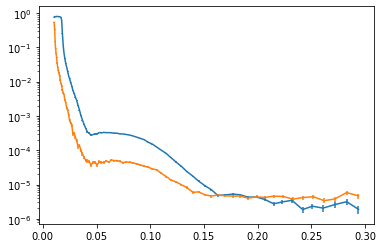

In [2]:
dataD2o = Data1D(data=di.data_in("lipidBilayerData/54696_97_edit.txt"))
dataD2o.name="d2o"
dataPmw = Data1D(data=di.data_in("lipidBilayerData/54699_00_edit.txt"))
dataPmw.name="pmw"

plt.errorbar(dataD2o.data[0],dataD2o.data[1],dataD2o.data[2])
plt.errorbar(dataPmw.data[0],dataPmw.data[1],dataPmw.data[2])
plt.yscale("log")
plt.show()

In [3]:
name = "bilayer"

d2o = SLD(6.07, "D2O")
pmw = SLD(2.35, "Protein Matched Water")
air = SLD(0.00, "Air")

d2o.real.setp(vary=True, bounds=(5.35, 6.35))
pmw.real.setp(vary=True, bounds=(1.35, 3.35))


apm = Parameter(value=140, name='%s - area_per_molecule' % name,
                bounds=(100, 180), vary=True) #bounds=(60, 150), vary=True)

#Define all the neutron b's
bc = 0.6646e-4  #Carbon
bo = 0.5804e-4  #Oxygen
bh = -0.3739e-4 #Hydrogen
bp = 0.513e-4   #Phosphorus
bn = 0.936e-4   #Nitrogen
bd = 0.6671e-4  #Deuterium

#Formulae of the molecule sections...
CH2 = (1*bc) + (2*bh)
CH = (1*bc) + (1*bh)
CH3 = (1*bc) + (3*bh)
D2O = (2*bd) + (1*bo)
H2O = (2*bh) + (1*bo)

# Calculate mole fraction of D2O from the bulk SLD..
# d2o_molfr = (1/D2O-H2O)*(contrast*27.64)-H2O
# wMol = (d2o_molfr * D2O) + ((1-d2o_molfr)*H2O)

#sum b's of all the different fragments
b_tails = Parameter(value=(28*CH2) + (2*CH) + (2*CH3),
                       name='%s - b_tails_real' % name)

sum_popc_heads = (8*bo) + (1*bp) + (1*bn) + (2*bc) + (4*CH2) + (3*CH3) + (1*CH)
sum_popg_heads = (10*bo) + (1*bp) + (2*bc) + (4*CH2) + (2*CH) + (2*bh)
b_heads = Parameter(value=(3*(sum_popc_heads) + (sum_popg_heads))/4,
                        name='%s - b_heads_real' % name)

#monolayer compositions
#sum_m_tails = (34*CH2) + (2*CH3);
#sum_m_heads = (1*bn) + (2*CH3) + (Waters_per_headD * wMol);

#volumes of each fragment
vCH2 = 27.7
nCH2 = 30
vCH3 = 54.6
vm_tails = Parameter(value=(nCH2 * vCH2) + (2 * vCH3),
            name='%s - volume_tails' % name) #
vm_heads = Parameter(value=331,
            name='%s - volume_heads' % name)  #
vm_water = Parameter(value=29.7,
            name='%s - water_vm' % name)

#thickness
thickness_tails = Parameter(6., #value=vm_tails.value/apm.value,
            name='%s - thickness_tails' % name,
            bounds=(3, #(1-0.75)*vm_tails.value/apm.value,
                    9), #(1+0.75)*vm_tails.value/apm.value),
               vary=True)
thickness_heads = Parameter(value= 11., #vm_heads.value/apm.value,
            name='%s - thickness_heads' % name,
            bounds=(9, #(1-0.75)*vm_heads.value/apm.value,
                    15), #(1+0.75)*vm_heads.value/apm.value),
               vary=True)

rough_top = Parameter(value=12.0,
            name='%s - rough_top' % name,
            bounds=(0,20), vary=True)
rough_bot = Parameter(value=10.3,
            name='%s - rough_bot' % name,
            bounds=(0,15), vary=True)

waters_per_head = Parameter(
            value=2.8,
            name="{} - Waters Per Head".format(name),
            bounds=(0, 4), vary=True)
waters_per_tail = Parameter(
            value=0.,
            name="{} - Waters Per Tail".format(name),
            vary=False)


In [4]:
# apm, b_heads, vm_heads, thickness_heads
# b_tails, vm_tails, thickness_tails, rough_head_tail
# rough_preceding_mono, head_solvent


# head_solvent_d2o = SLD(6.07, "D2O in bilayer")
# head_solvent_d2o.real.setp(6.07, vary=True, bounds=(5.35, 6.35))
upper_lipid_d2o = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
    vm_water, waters_per_head, waters_per_tail,
    d2o, reverse_monolayer=False, name="upper_lipid_d2o")

lower_lipid_d2o = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
    vm_water, waters_per_head, waters_per_tail,
    d2o, reverse_monolayer=True, name="lower_lipid_d2o")


# head_solvent_pmw = SLD(2.35, "Protein Matched Water in bilayer")
# head_solvent_pmw.real.setp(2.34, vary=True, bounds=(1.35, 3.35))
upper_lipid_pmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_bot, rough_bot,
    vm_water, waters_per_head, waters_per_tail, pmw,
    reverse_monolayer=False, name="upper_lipid_pmw")

lower_lipid_pmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_bot, rough_bot,
    vm_water, waters_per_head, waters_per_tail, pmw,
    reverse_monolayer=True, name="lower_lipid_pmw")


In [5]:
# name_m = "mono, dodab"
# APMD = Parameter(value=48, name='%s - area_per_molecule' % name_m,
#         bounds=(30,120), vary=True)

# # monolayer compositions
# m_tails = Parameter(value=(34*CH2) + (2*CH3),
#             name='%s - b_tails_real' % name_m)
# m_heads = Parameter(value=(1*bn) + (2*CH3),
#             name='%s - b_heads_real' % name_m)

# # monolayer volumes
# vm_m_tails = Parameter(value=vCH2*36,
#             name='%s - volume_tails' % name_m)
# vm_m_heads = Parameter(value=54.6,
#             name='%s - volume_heads' % name_m)

# # monolayer thicknesses
# tail_thick_m = Parameter(value=vm_m_tails.value / APMD.value,
#             name='%s - thickness_tails' % name_m,
#             bounds=((1-0.75)*vm_m_tails.value / APMD.value,
#                     (1+0.75)*vm_m_tails.value / APMD.value),
#                vary=True)
# head_thick_m = Parameter(value=vm_m_heads.value / APMD.value,
#             name='%s - thickness heads' % name_m,
#             bounds=((1-0.75)*vm_m_heads.value / APMD.value,
#                     (1+0.75)*vm_m_heads.value / APMD.value),
#                vary=True)

# roughness_m =  Parameter(value=5.8,
#             name='%s - roughness' % name_m,
#             bounds=(0,10), vary=True)


# water_vm_m = Parameter(value=vm_water,
#             name='%s - water_vm' % name_m)
# waters_per_head_m = Parameter(
#             value=2.8,
#             name="{} Waters Per Head".format(name_m),
#             vary=True,
#             bounds=(1, 20))
# waters_per_tail_m = Parameter(
#             value=0.,
#             name="{} Waters Per Tail".format(name_m),
#             vary=False)

In [6]:
# m_head_solvent_pmw=SLD(2.35, "mono, dodab - Protein Matched Water in head")
# m_head_solvent_pmw.real.setp(2.34, vary=True, bounds=(1.35, 3.35))
# m_air_in_tail=SLD(0, "mono, dodab - air in tail")

# dodab_pmw = LipidLeaflet(apm=APMD, b_heads=m_heads, vm_heads=vm_m_heads,
#     thickness_heads=head_thick_m, b_tails=m_tails, vm_tails=vm_m_tails,
#     thickness_tails=tail_thick_m, rough_head_tail=roughness_m,
#     rough_preceding_mono=roughness_m,
#     water_vm=vm_water, waters_per_head=waters_per_head_m,
#     waters_per_tail=waters_per_tail_m,
#     head_solvent=m_head_solvent_pmw, tail_solvent=m_air_in_tail) #mono

# m_head_solvent_d2o=SLD(6.07, "mono, dodab - D2O in head")
# m_head_solvent_d2o.real.setp(6.07, vary=True, bounds=(5.35, 6.35))
# dodab_d2o = LipidLeaflet(apm=APMD, b_heads=m_heads, vm_heads=vm_m_heads,
#     thickness_heads=head_thick_m, b_tails=m_tails, vm_tails=vm_m_tails,
#     thickness_tails=tail_thick_m, rough_head_tail=roughness_m,
#     water_vm=vm_water, waters_per_head=waters_per_head_m,
#     waters_per_tail=waters_per_tail_m,
#     rough_preceding_mono=roughness_m, head_solvent=m_head_solvent_d2o,
#                          tail_solvent=m_air_in_tail) #mono

layers [[ 1.10000000e+01  1.31052071e+00  7.26861572e-09  1.20000000e+01
   0.00000000e+00]
 [ 6.00000000e+00 -2.83173793e-01  0.00000000e+00  1.20000000e+01
  -1.19285714e-01]]
layers [[ 6.00000000e+00 -2.83173793e-01  0.00000000e+00  1.20000000e+01
  -1.19285714e-01]
 [ 1.10000000e+01  1.31052071e+00  7.26861572e-09  1.20000000e+01
   0.00000000e+00]]
layers [[ 1.10000000e+01  7.57790871e-01  7.26861572e-09  1.03000000e+01
   0.00000000e+00]
 [ 6.00000000e+00 -2.83173793e-01  0.00000000e+00  1.03000000e+01
  -1.19285714e-01]]
layers [[ 6.00000000e+00 -2.83173793e-01  0.00000000e+00  1.03000000e+01
  -1.19285714e-01]
 [ 1.10000000e+01  7.57790871e-01  7.26861572e-09  1.03000000e+01
   0.00000000e+00]]


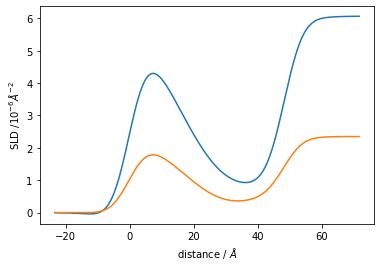

________________________________________________________________________________
Structure:       d2o      
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:      'D2O'     
<Parameter:'thickness_solution', value=14.3          , bounds=[6, 20]>
<Parameter:  'D2O - sld'  , value=6.07          , bounds=[5.35, 6.35]>
<Parameter: 'D2O - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_preceding_solution', value=4.6          , bounds=[0,

<Parameter:'Protein Matched Water - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>


In [7]:
# structure_d2o = air(0, 0) | dodab_d2o | d2o(0, 0) | upper_lipid_d2o | lower_lipid_d2o | d2o(0, 0)
# structure_pmw = air(0, 0) | dodab_pmw | pmw(0, 0) | upper_lipid_pmw | lower_lipid_pmw | pmw(0, 0)
# structure_d2o = air(0, 0) | d2o(0, 0) | upper_lipid_d2o | lower_lipid_d2o | d2o(0, 0)
# structure_pmw = air(0, 0) | pmw(0, 0) | upper_lipid_pmw | lower_lipid_pmw | pmw(0, 0)
#
#
# solution_thickness = Parameter(value=14.3, bounds=(6, 20), vary=True,
#             name='%s - thickness_solution' % name)

# rough_preceding_solution = Parameter(value=4.6, bounds=(0, 20), vary=True,
#             name='%s - rough_preceding_solution' % name)
# 
# structure_d2o[2].thick=solution_thickness#.setp(14.3, vary=True, bounds=(6, 20))
# structure_d2o[2].rough=rough_preceding_solution#.setp(4.6, vary=True, bounds=(3, 20))
# structure_pmw[2].thick=solution_thickness
# structure_pmw[2].rough=rough_preceding_solution
#
# structure_d2o[5].thick=solution_thickness
# structure_d2o[5].rough=rough_preceding_solution
# structure_pmw[5].thick=solution_thickness
# structure_pmw[5].rough=rough_preceding_solution

# to changing to
solution_thickness = Parameter(value=14.3, bounds=(6, 20), vary=True,
            name='thickness_solution')

rough_preceding_solution = Parameter(value=4.6, bounds=(0, 20), vary=True,
            name='rough_preceding_solution')

structure_d2o = air(0, 0) | d2o(solution_thickness, rough_preceding_solution) | upper_lipid_d2o | lower_lipid_d2o | d2o(solution_thickness, rough_preceding_solution)
structure_pmw = air(0, 0) | pmw(solution_thickness, rough_preceding_solution) | upper_lipid_pmw | lower_lipid_pmw | pmw(solution_thickness, rough_preceding_solution)

structure_d2o.name = "d2o"
structure_pmw.name = "protein matched water"

plt.plot(*structure_d2o.sld_profile(),label=structure_d2o)
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.plot(*structure_pmw.sld_profile(),label=structure_pmw)
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.show();
print(structure_d2o)
print(structure_pmw)

In [8]:
model1 = ReflectModel(structure_d2o)
model1.scale.setp(1./dataD2o.y.max(), vary=False)
model1.bkg.setp(dataD2o.y.min(),vary=True,bounds=(dataD2o.y.min() * 0.2, dataD2o.y.min() * 1.8))

model2 = ReflectModel(structure_pmw)
model2.scale.setp(1./dataPmw.y.max(), vary=False)
model2.bkg.setp(dataPmw.y.min(),vary=True,bounds=(dataPmw.y.min() * 0.2, dataPmw.y.min() * 1.8))

objective1 = Objective(model1, dataD2o, transform=Transform("logY"))
objective2 = Objective(model2, dataPmw, transform=Transform("logY"))
gobjective = GlobalObjective([objective1,objective2])
choose = 0
if choose==0:
    fitter = CurveFitter(gobjective)
    fitter.fit("differential_evolution", target="nlpost")#, seed=SEED)
if choose==1:
    fitter = CurveFitter(gobjective)
    fitter.sample(400)
    fitter.reset()
    res = fitter.sample(15, nthin=100)
if choose==2:
    from dynesty import DynamicNestedSampler
    from dynesty import plotting as dyplot
    from CFitter import CFitter
    fitter = CFitter(gobjective)
    # DynamicNestedSampler
    DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
    DNSampler.run_nested(dlogz_init=0.05) # was 0.01
    res1 = DNSampler.results

layers [[ 1.25170255e+01  9.56466523e-01  5.19657417e-09  1.30421550e+01
   0.00000000e+00]
 [ 7.05077216e+00 -2.83173793e-01  0.00000000e+00  1.30421550e+01
   3.88292281e-02]]
layers [[ 7.05077216e+00 -2.83173793e-01  0.00000000e+00  1.30421550e+01
   3.88292281e-02]
 [ 1.25170255e+01  9.56466523e-01  5.19657417e-09  1.30421550e+01
   0.00000000e+00]]
layers [[ 1.25170255e+01  6.49307757e-01  5.19657417e-09  3.42974682e+00
   0.00000000e+00]
 [ 7.05077216e+00 -2.83173793e-01  0.00000000e+00  3.42974682e+00
   3.88292281e-02]]
layers [[ 7.05077216e+00 -2.83173793e-01  0.00000000e+00  3.42974682e+00
   3.88292281e-02]
 [ 1.25170255e+01  6.49307757e-01  5.19657417e-09  3.42974682e+00
   0.00000000e+00]]
layers [[ 1.45600679e+01  1.34752450e+00  8.52561518e-09  1.51206165e+00
   0.00000000e+00]
 [ 8.94260720e+00 -2.83173793e-01  0.00000000e+00  1.51206165e+00
   5.18986616e-02]]
layers [[ 8.94260720e+00 -2.83173793e-01  0.00000000e+00  1.51206165e+00
   5.18986616e-02]
 [ 1.45600679e+01 

layers [[ 1.17378288e+01  6.23118910e-01  9.77673058e-09  8.35894763e-02
   0.00000000e+00]
 [ 6.44616942e+00 -2.83173793e-01  0.00000000e+00  8.35894763e-02
   1.20368678e-01]]
layers [[ 6.44616942e+00 -2.83173793e-01  0.00000000e+00  8.35894763e-02
   1.20368678e-01]
 [ 1.17378288e+01  6.23118910e-01  9.77673058e-09  8.35894763e-02
   0.00000000e+00]]
layers [[ 9.13247347e+00  9.12093866e-01  3.37473623e-09  1.96932019e+01
   0.00000000e+00]
 [ 7.23706275e+00 -2.83173793e-01  0.00000000e+00  1.96932019e+01
   7.71073132e-02]]
layers [[ 7.23706275e+00 -2.83173793e-01  0.00000000e+00  1.96932019e+01
   7.71073132e-02]
 [ 9.13247347e+00  9.12093866e-01  3.37473623e-09  1.96932019e+01
   0.00000000e+00]]
layers [[ 9.13247347e+00  5.98574120e-01  3.37473623e-09  1.47197907e+01
   0.00000000e+00]
 [ 7.23706275e+00 -2.83173793e-01  0.00000000e+00  1.47197907e+01
   7.71073132e-02]]
layers [[ 7.23706275e+00 -2.83173793e-01  0.00000000e+00  1.47197907e+01
   7.71073132e-02]
 [ 9.13247347e+00 

layers [[ 1.48402608e+01  9.94477955e-01  6.08221424e-09  3.24358956e+00
   0.00000000e+00]
 [ 6.24764971e+00 -2.83173793e-01  0.00000000e+00  3.24358956e+00
   7.77713639e-02]]
layers [[ 6.24764971e+00 -2.83173793e-01  0.00000000e+00  3.24358956e+00
   7.77713639e-02]
 [ 1.48402608e+01  9.94477955e-01  6.08221424e-09  3.24358956e+00
   0.00000000e+00]]
layers [[ 1.48402608e+01  4.29841122e-01  6.08221424e-09  3.10146677e-01
   0.00000000e+00]
 [ 6.24764971e+00 -2.83173793e-01  0.00000000e+00  3.10146677e-01
   7.77713639e-02]]
layers [[ 6.24764971e+00 -2.83173793e-01  0.00000000e+00  3.10146677e-01
   7.77713639e-02]
 [ 1.48402608e+01  4.29841122e-01  6.08221424e-09  3.10146677e-01
   0.00000000e+00]]
layers [[ 1.07090268e+01  1.16066156e+00  6.51618174e-09  1.44492576e+01
   0.00000000e+00]
 [ 8.76905842e+00 -2.83173793e-01  0.00000000e+00  1.44492576e+01
   2.91656992e-01]]
layers [[ 8.76905842e+00 -2.83173793e-01  0.00000000e+00  1.44492576e+01
   2.91656992e-01]
 [ 1.07090268e+01 

layers [[ 1.43001245e+01  5.62734508e-01  5.55683344e-09  8.26772945e+00
   0.00000000e+00]
 [ 8.43847438e+00 -2.83173793e-01  0.00000000e+00  8.26772945e+00
   1.48918422e-01]]
layers [[ 8.43847438e+00 -2.83173793e-01  0.00000000e+00  8.26772945e+00
   1.48918422e-01]
 [ 1.43001245e+01  5.62734508e-01  5.55683344e-09  8.26772945e+00
   0.00000000e+00]]
layers [[ 1.19753273e+01  9.90757835e-01  5.76989567e-09  8.76752059e+00
   0.00000000e+00]
 [ 7.54232096e+00 -2.83173793e-01  0.00000000e+00  8.76752059e+00
   2.44403884e-01]]
layers [[ 7.54232096e+00 -2.83173793e-01  0.00000000e+00  8.76752059e+00
   2.44403884e-01]
 [ 1.19753273e+01  9.90757835e-01  5.76989567e-09  8.76752059e+00
   0.00000000e+00]]
layers [[ 1.19753273e+01  5.76562744e-01  5.76989567e-09  1.18649722e+01
   0.00000000e+00]
 [ 7.54232096e+00 -2.83173793e-01  0.00000000e+00  1.18649722e+01
   2.44403884e-01]]
layers [[ 7.54232096e+00 -2.83173793e-01  0.00000000e+00  1.18649722e+01
   2.44403884e-01]
 [ 1.19753273e+01 

layers [[ 9.30311108e+00  1.51217441e+00  9.07905735e-09  5.57457219e+00
   0.00000000e+00]
 [ 5.51008470e+00 -2.83173793e-01  0.00000000e+00  5.57457219e+00
   5.06333454e-02]]
layers [[ 5.51008470e+00 -2.83173793e-01  0.00000000e+00  5.57457219e+00
   5.06333454e-02]
 [ 9.30311108e+00  1.51217441e+00  9.07905735e-09  5.57457219e+00
   0.00000000e+00]]
layers [[ 9.30311108e+00  7.62497147e-01  9.07905735e-09  7.13787426e+00
   0.00000000e+00]
 [ 5.51008470e+00 -2.83173793e-01  0.00000000e+00  7.13787426e+00
   5.06333454e-02]]
layers [[ 5.51008470e+00 -2.83173793e-01  0.00000000e+00  7.13787426e+00
   5.06333454e-02]
 [ 9.30311108e+00  7.62497147e-01  9.07905735e-09  7.13787426e+00
   0.00000000e+00]]
layers [[ 1.24567800e+01  8.50486567e-01  4.37019709e-09  1.16187560e+01
   0.00000000e+00]
 [ 6.04898918e+00 -2.83173793e-01  0.00000000e+00  1.16187560e+01
   2.00709365e-02]]
layers [[ 6.04898918e+00 -2.83173793e-01  0.00000000e+00  1.16187560e+01
   2.00709365e-02]
 [ 1.24567800e+01 

layers [[ 1.20624533e+01  6.45734642e-01  4.89515332e-09  3.84529814e+00
   0.00000000e+00]
 [ 8.87011816e+00 -2.83173793e-01  0.00000000e+00  3.84529814e+00
   1.79812689e-02]]
layers [[ 8.87011816e+00 -2.83173793e-01  0.00000000e+00  3.84529814e+00
   1.79812689e-02]
 [ 1.20624533e+01  6.45734642e-01  4.89515332e-09  3.84529814e+00
   0.00000000e+00]]
layers [[ 1.46477430e+01  8.28476922e-01  5.31462528e-09  5.20683671e+00
   0.00000000e+00]
 [ 8.17133697e+00 -2.83173793e-01  0.00000000e+00  5.20683671e+00
   3.46713992e-01]]
layers [[ 8.17133697e+00 -2.83173793e-01  0.00000000e+00  5.20683671e+00
   3.46713992e-01]
 [ 1.46477430e+01  8.28476922e-01  5.31462528e-09  5.20683671e+00
   0.00000000e+00]]
layers [[ 1.46477430e+01  5.77028432e-01  5.31462528e-09  7.64004626e+00
   0.00000000e+00]
 [ 8.17133697e+00 -2.83173793e-01  0.00000000e+00  7.64004626e+00
   3.46713992e-01]]
layers [[ 8.17133697e+00 -2.83173793e-01  0.00000000e+00  7.64004626e+00
   3.46713992e-01]
 [ 1.46477430e+01 

layers [[ 1.26426572e+01  5.58383934e-01  1.41533102e-09  1.52290815e+01
   0.00000000e+00]
 [ 8.43065067e+00 -2.83173793e-01  0.00000000e+00  1.52290815e+01
   1.43866580e-01]]
layers [[ 8.43065067e+00 -2.83173793e-01  0.00000000e+00  1.52290815e+01
   1.43866580e-01]
 [ 1.26426572e+01  5.58383934e-01  1.41533102e-09  1.52290815e+01
   0.00000000e+00]]
layers [[ 1.26426572e+01  4.58773781e-01  1.41533102e-09  6.57949836e+00
   0.00000000e+00]
 [ 8.43065067e+00 -2.83173793e-01  0.00000000e+00  6.57949836e+00
   1.43866580e-01]]
layers [[ 8.43065067e+00 -2.83173793e-01  0.00000000e+00  6.57949836e+00
   1.43866580e-01]
 [ 1.26426572e+01  4.58773781e-01  1.41533102e-09  6.57949836e+00
   0.00000000e+00]]
layers [[ 1.49463093e+01  1.41087966e+00  1.06192648e-08  1.81583859e+01
   0.00000000e+00]
 [ 8.74572184e+00 -2.83173793e-01  0.00000000e+00  1.81583859e+01
   3.70747783e-01]]
layers [[ 8.74572184e+00 -2.83173793e-01  0.00000000e+00  1.81583859e+01
   3.70747783e-01]
 [ 1.49463093e+01 

layers [[ 9.40888349e+00  8.19817501e-01  6.40354933e-09  9.19743159e-01
   0.00000000e+00]
 [ 5.38042649e+00 -2.83173793e-01  0.00000000e+00  9.19743159e-01
   9.68010005e-04]]
layers [[ 5.38042649e+00 -2.83173793e-01  0.00000000e+00  9.19743159e-01
   9.68010005e-04]
 [ 9.40888349e+00  8.19817501e-01  6.40354933e-09  9.19743159e-01
   0.00000000e+00]]
layers [[ 1.04521273e+01  1.42624565e+00  7.72365799e-09  2.80332561e+00
   0.00000000e+00]
 [ 8.50042278e+00 -2.83173793e-01  0.00000000e+00  2.80332561e+00
   8.77400368e-02]]
layers [[ 8.50042278e+00 -2.83173793e-01  0.00000000e+00  2.80332561e+00
   8.77400368e-02]
 [ 1.04521273e+01  1.42624565e+00  7.72365799e-09  2.80332561e+00
   0.00000000e+00]]
layers [[ 1.04521273e+01  7.35586933e-01  7.72365799e-09  1.23243275e+01
   0.00000000e+00]
 [ 8.50042278e+00 -2.83173793e-01  0.00000000e+00  1.23243275e+01
   8.77400368e-02]]
layers [[ 8.50042278e+00 -2.83173793e-01  0.00000000e+00  1.23243275e+01
   8.77400368e-02]
 [ 1.04521273e+01 

layers [[ 1.30088436e+01  1.14107531e+00  7.57013004e-09  1.88223413e+01
   0.00000000e+00]
 [ 7.93680628e+00 -2.83173793e-01  0.00000000e+00  1.88223413e+01
   3.26141085e-01]]
layers [[ 7.93680628e+00 -2.83173793e-01  0.00000000e+00  1.88223413e+01
   3.26141085e-01]
 [ 1.30088436e+01  1.14107531e+00  7.57013004e-09  1.88223413e+01
   0.00000000e+00]]
layers [[ 1.30088436e+01  5.76779649e-01  7.57013004e-09  3.50515371e+00
   0.00000000e+00]
 [ 7.93680628e+00 -2.83173793e-01  0.00000000e+00  3.50515371e+00
   3.26141085e-01]]
layers [[ 7.93680628e+00 -2.83173793e-01  0.00000000e+00  3.50515371e+00
   3.26141085e-01]
 [ 1.30088436e+01  5.76779649e-01  7.57013004e-09  3.50515371e+00
   0.00000000e+00]]
layers [[ 9.58321355e+00  5.84368314e-01  3.30212978e-10  1.98307495e+01
   0.00000000e+00]
 [ 7.91713062e+00 -2.83173793e-01  0.00000000e+00  1.98307495e+01
   1.70371420e-02]]
layers [[ 7.91713062e+00 -2.83173793e-01  0.00000000e+00  1.98307495e+01
   1.70371420e-02]
 [ 9.58321355e+00 

layers [[ 1.13429830e+01  4.93256882e-01  2.30132865e-09  9.75131978e+00
   0.00000000e+00]
 [ 7.37596036e+00 -2.83173793e-01  0.00000000e+00  9.75131978e+00
   1.47430893e-02]]
layers [[ 7.37596036e+00 -2.83173793e-01  0.00000000e+00  9.75131978e+00
   1.47430893e-02]
 [ 1.13429830e+01  4.93256882e-01  2.30132865e-09  9.75131978e+00
   0.00000000e+00]]
layers [[ 1.23730267e+01  1.38412024e+00  8.96602678e-09  1.41845449e+01
   0.00000000e+00]
 [ 8.62236876e+00 -2.83173793e-01  0.00000000e+00  1.41845449e+01
   3.86643908e-01]]
layers [[ 8.62236876e+00 -2.83173793e-01  0.00000000e+00  1.41845449e+01
   3.86643908e-01]
 [ 1.23730267e+01  1.38412024e+00  8.96602678e-09  1.41845449e+01
   0.00000000e+00]]
layers [[ 1.23730267e+01  7.92773866e-01  8.96602678e-09  1.07879568e+01
   0.00000000e+00]
 [ 8.62236876e+00 -2.83173793e-01  0.00000000e+00  1.07879568e+01
   3.86643908e-01]]
layers [[ 8.62236876e+00 -2.83173793e-01  0.00000000e+00  1.07879568e+01
   3.86643908e-01]
 [ 1.23730267e+01 

layers [[ 9.30311108e+00  1.48928117e+00  9.16678139e-09  7.48134644e+00
   0.00000000e+00]
 [ 8.27642527e+00 -2.83173793e-01  0.00000000e+00  7.48134644e+00
   3.67952889e-01]]
layers [[ 8.27642527e+00 -2.83173793e-01  0.00000000e+00  7.48134644e+00
   3.67952889e-01]
 [ 9.30311108e+00  1.48928117e+00  9.16678139e-09  7.48134644e+00
   0.00000000e+00]]
layers [[ 9.30311108e+00  9.30145188e-01  9.16678139e-09  7.88780457e+00
   0.00000000e+00]
 [ 8.27642527e+00 -2.83173793e-01  0.00000000e+00  7.88780457e+00
   3.67952889e-01]]
layers [[ 8.27642527e+00 -2.83173793e-01  0.00000000e+00  7.88780457e+00
   3.67952889e-01]
 [ 9.30311108e+00  9.30145188e-01  9.16678139e-09  7.88780457e+00
   0.00000000e+00]]
layers [[ 1.40719215e+01  5.85876195e-01  2.41655406e-09  1.01814178e+01
   0.00000000e+00]
 [ 6.91373977e+00 -2.83173793e-01  0.00000000e+00  1.01814178e+01
   1.45163680e-01]]
layers [[ 6.91373977e+00 -2.83173793e-01  0.00000000e+00  1.01814178e+01
   1.45163680e-01]
 [ 1.40719215e+01 

layers [[ 1.18586718e+01  7.61093830e-01  7.41193228e-09  1.23031030e+00
   0.00000000e+00]
 [ 8.17133697e+00 -2.83173793e-01  0.00000000e+00  1.23031030e+00
   1.21654451e-01]]
layers [[ 8.17133697e+00 -2.83173793e-01  0.00000000e+00  1.23031030e+00
   1.21654451e-01]
 [ 1.18586718e+01  7.61093830e-01  7.41193228e-09  1.23031030e+00
   0.00000000e+00]]
layers [[ 1.49006818e+01  6.17481792e-01  2.56687437e-09  1.15745487e+01
   0.00000000e+00]
 [ 8.47829318e+00 -2.83173793e-01  0.00000000e+00  1.15745487e+01
   1.40433301e-01]]
layers [[ 8.47829318e+00 -2.83173793e-01  0.00000000e+00  1.15745487e+01
   1.40433301e-01]
 [ 1.49006818e+01  6.17481792e-01  2.56687437e-09  1.15745487e+01
   0.00000000e+00]]
layers [[ 1.49006818e+01  4.35712602e-01  2.56687437e-09  3.25926054e+00
   0.00000000e+00]
 [ 8.47829318e+00 -2.83173793e-01  0.00000000e+00  3.25926054e+00
   1.40433301e-01]]
layers [[ 8.47829318e+00 -2.83173793e-01  0.00000000e+00  3.25926054e+00
   1.40433301e-01]
 [ 1.49006818e+01 

layers [[ 1.00976779e+01  7.66066245e-01  2.46348664e-09  7.71876957e+00
   0.00000000e+00]
 [ 7.64606052e+00 -2.83173793e-01  0.00000000e+00  7.71876957e+00
   9.98677666e-02]]
layers [[ 7.64606052e+00 -2.83173793e-01  0.00000000e+00  7.71876957e+00
   9.98677666e-02]
 [ 1.00976779e+01  7.66066245e-01  2.46348664e-09  7.71876957e+00
   0.00000000e+00]]
layers [[ 1.00976779e+01  5.68297295e-01  2.46348664e-09  8.82984515e+00
   0.00000000e+00]
 [ 7.64606052e+00 -2.83173793e-01  0.00000000e+00  8.82984515e+00
   9.98677666e-02]]
layers [[ 7.64606052e+00 -2.83173793e-01  0.00000000e+00  8.82984515e+00
   9.98677666e-02]
 [ 1.00976779e+01  5.68297295e-01  2.46348664e-09  8.82984515e+00
   0.00000000e+00]]
layers [[ 1.43066179e+01  1.13254224e+00  7.14974935e-09  1.76005629e+01
   0.00000000e+00]
 [ 6.78448558e+00 -2.83173793e-01  0.00000000e+00  1.76005629e+01
   7.37608686e-02]]
layers [[ 6.78448558e+00 -2.83173793e-01  0.00000000e+00  1.76005629e+01
   7.37608686e-02]
 [ 1.43066179e+01 

layers [[ 1.19043579e+01  5.13861616e-01  4.74800527e-09  1.47197907e+01
   0.00000000e+00]
 [ 7.00940252e+00 -2.83173793e-01  0.00000000e+00  1.47197907e+01
   1.03608354e-01]]
layers [[ 7.00940252e+00 -2.83173793e-01  0.00000000e+00  1.47197907e+01
   1.03608354e-01]
 [ 1.19043579e+01  5.13861616e-01  4.74800527e-09  1.47197907e+01
   0.00000000e+00]]
layers [[ 1.48107835e+01  6.19728326e-01  2.34976616e-09  1.72931204e+01
   0.00000000e+00]
 [ 7.34936714e+00 -2.83173793e-01  0.00000000e+00  1.72931204e+01
   3.75558387e-02]]
layers [[ 7.34936714e+00 -2.83173793e-01  0.00000000e+00  1.72931204e+01
   3.75558387e-02]
 [ 1.48107835e+01  6.19728326e-01  2.34976616e-09  1.72931204e+01
   0.00000000e+00]]
layers [[ 1.48107835e+01  4.18244119e-01  2.34976616e-09  2.47589589e+00
   0.00000000e+00]
 [ 7.34936714e+00 -2.83173793e-01  0.00000000e+00  2.47589589e+00
   3.75558387e-02]]
layers [[ 7.34936714e+00 -2.83173793e-01  0.00000000e+00  2.47589589e+00
   3.75558387e-02]
 [ 1.48107835e+01 

layers [[ 1.44557881e+01  1.16219051e+00  7.78866057e-09  9.32691693e+00
   0.00000000e+00]
 [ 8.58504893e+00 -2.83173793e-01  0.00000000e+00  9.32691693e+00
   2.69790447e-01]]
layers [[ 8.58504893e+00 -2.83173793e-01  0.00000000e+00  9.32691693e+00
   2.69790447e-01]
 [ 1.44557881e+01  1.16219051e+00  7.78866057e-09  9.32691693e+00
   0.00000000e+00]]
layers [[ 1.44557881e+01  6.63352658e-01  7.78866057e-09  2.46095356e-01
   0.00000000e+00]
 [ 8.58504893e+00 -2.83173793e-01  0.00000000e+00  2.46095356e-01
   2.69790447e-01]]
layers [[ 8.58504893e+00 -2.83173793e-01  0.00000000e+00  2.46095356e-01
   2.69790447e-01]
 [ 1.44557881e+01  6.63352658e-01  7.78866057e-09  2.46095356e-01
   0.00000000e+00]]
layers [[ 1.48141953e+01  1.30532510e+00  8.32000179e-09  9.55809794e+00
   0.00000000e+00]
 [ 8.90853181e+00 -2.83173793e-01  0.00000000e+00  9.55809794e+00
   3.09440914e-01]]
layers [[ 8.90853181e+00 -2.83173793e-01  0.00000000e+00  9.55809794e+00
   3.09440914e-01]
 [ 1.48141953e+01 

layers [[ 1.07090268e+01  4.78582731e-01  1.87318596e-09  1.36284990e+01
   0.00000000e+00]
 [ 8.76905842e+00 -2.83173793e-01  0.00000000e+00  1.36284990e+01
   2.53608233e-01]]
layers [[ 8.76905842e+00 -2.83173793e-01  0.00000000e+00  1.36284990e+01
   2.53608233e-01]
 [ 1.07090268e+01  4.78582731e-01  1.87318596e-09  1.36284990e+01
   0.00000000e+00]]
layers [[ 1.18368645e+01  8.56014745e-01  4.48647833e-09  8.48894856e+00
   0.00000000e+00]
 [ 8.33925913e+00 -2.83173793e-01  0.00000000e+00  8.48894856e+00
   2.52478197e-01]]
layers [[ 8.33925913e+00 -2.83173793e-01  0.00000000e+00  8.48894856e+00
   2.52478197e-01]
 [ 1.18368645e+01  8.56014745e-01  4.48647833e-09  8.48894856e+00
   0.00000000e+00]]
layers [[ 1.18368645e+01  5.69692561e-01  4.48647833e-09  2.27309218e+00
   0.00000000e+00]
 [ 8.33925913e+00 -2.83173793e-01  0.00000000e+00  2.27309218e+00
   2.52478197e-01]]
layers [[ 8.33925913e+00 -2.83173793e-01  0.00000000e+00  2.27309218e+00
   2.52478197e-01]
 [ 1.18368645e+01 

layers [[ 1.39108396e+01  1.06375057e+00  6.69492837e-09  4.25112582e-01
   0.00000000e+00]
 [ 5.74950196e+00 -2.83173793e-01  0.00000000e+00  4.25112582e-01
   8.28654581e-02]]
layers [[ 5.74950196e+00 -2.83173793e-01  0.00000000e+00  4.25112582e-01
   8.28654581e-02]
 [ 1.39108396e+01  1.06375057e+00  6.69492837e-09  4.25112582e-01
   0.00000000e+00]]
layers [[ 1.39108396e+01  6.80087596e-01  6.69492837e-09  5.37088287e+00
   0.00000000e+00]
 [ 5.74950196e+00 -2.83173793e-01  0.00000000e+00  5.37088287e+00
   8.28654581e-02]]
layers [[ 5.74950196e+00 -2.83173793e-01  0.00000000e+00  5.37088287e+00
   8.28654581e-02]
 [ 1.39108396e+01  6.80087596e-01  6.69492837e-09  5.37088287e+00
   0.00000000e+00]]
layers [[ 1.31892774e+01  1.13210900e+00  7.70301565e-09  5.68578963e+00
   0.00000000e+00]
 [ 8.51693303e+00 -2.83173793e-01  0.00000000e+00  5.68578963e+00
   3.44088219e-01]]
layers [[ 8.51693303e+00 -2.83173793e-01  0.00000000e+00  5.68578963e+00
   3.44088219e-01]
 [ 1.31892774e+01 

layers [[ 1.46092788e+01  4.24730570e-01  5.46541340e-09  1.06111872e+01
   0.00000000e+00]
 [ 6.24828173e+00 -2.83173793e-01  0.00000000e+00  1.06111872e+01
   1.04835196e-01]]
layers [[ 6.24828173e+00 -2.83173793e-01  0.00000000e+00  1.06111872e+01
   1.04835196e-01]
 [ 1.46092788e+01  4.24730570e-01  5.46541340e-09  1.06111872e+01
   0.00000000e+00]]
layers [[ 1.27507325e+01  6.87840243e-01  3.19944278e-09  3.56346766e+00
   0.00000000e+00]
 [ 6.47822006e+00 -2.83173793e-01  0.00000000e+00  3.56346766e+00
   3.68899470e-02]]
layers [[ 6.47822006e+00 -2.83173793e-01  0.00000000e+00  3.56346766e+00
   3.68899470e-02]
 [ 1.27507325e+01  6.87840243e-01  3.19944278e-09  3.56346766e+00
   0.00000000e+00]]
layers [[ 1.27507325e+01  4.93120720e-01  3.19944278e-09  8.05235384e+00
   0.00000000e+00]
 [ 6.47822006e+00 -2.83173793e-01  0.00000000e+00  8.05235384e+00
   3.68899470e-02]]
layers [[ 6.47822006e+00 -2.83173793e-01  0.00000000e+00  8.05235384e+00
   3.68899470e-02]
 [ 1.27507325e+01 

layers [[ 1.48672040e+01  9.94377620e-01  6.18114793e-09  9.17332480e+00
   0.00000000e+00]
 [ 8.37215426e+00 -2.83173793e-01  0.00000000e+00  9.17332480e+00
   2.37856392e-01]]
layers [[ 8.37215426e+00 -2.83173793e-01  0.00000000e+00  9.17332480e+00
   2.37856392e-01]
 [ 1.48672040e+01  9.94377620e-01  6.18114793e-09  9.17332480e+00
   0.00000000e+00]]
layers [[ 1.48672040e+01  6.56679972e-01  6.18114793e-09  3.92785086e+00
   0.00000000e+00]
 [ 8.37215426e+00 -2.83173793e-01  0.00000000e+00  3.92785086e+00
   2.37856392e-01]]
layers [[ 8.37215426e+00 -2.83173793e-01  0.00000000e+00  3.92785086e+00
   2.37856392e-01]
 [ 1.48672040e+01  6.56679972e-01  6.18114793e-09  3.92785086e+00
   0.00000000e+00]]
layers [[ 1.27089865e+01  6.89200223e-01  3.14329892e-09  1.56234947e+01
   0.00000000e+00]
 [ 7.58130002e+00 -2.83173793e-01  0.00000000e+00  1.56234947e+01
   1.71544257e-01]]
layers [[ 7.58130002e+00 -2.83173793e-01  0.00000000e+00  1.56234947e+01
   1.71544257e-01]
 [ 1.27089865e+01 

layers [[ 1.26795220e+01  3.06680908e-01  6.23560158e-10  1.22245108e+01
   0.00000000e+00]
 [ 6.91102421e+00 -2.83173793e-01  0.00000000e+00  1.22245108e+01
   2.21665570e-01]]
layers [[ 6.91102421e+00 -2.83173793e-01  0.00000000e+00  1.22245108e+01
   2.21665570e-01]
 [ 1.26795220e+01  3.06680908e-01  6.23560158e-10  1.22245108e+01
   0.00000000e+00]]
layers [[ 1.48899570e+01  1.37266089e+00  1.00859929e-08  1.59914159e+01
   0.00000000e+00]
 [ 7.93684239e+00 -2.83173793e-01  0.00000000e+00  1.59914159e+01
   3.18335031e-01]]
layers [[ 7.93684239e+00 -2.83173793e-01  0.00000000e+00  1.59914159e+01
   3.18335031e-01]
 [ 1.48899570e+01  1.37266089e+00  1.00859929e-08  1.59914159e+01
   0.00000000e+00]]
layers [[ 1.48899570e+01  5.92472244e-01  1.00859929e-08  1.42333480e+00
   0.00000000e+00]
 [ 7.93684239e+00 -2.83173793e-01  0.00000000e+00  1.42333480e+00
   3.18335031e-01]]
layers [[ 7.93684239e+00 -2.83173793e-01  0.00000000e+00  1.42333480e+00
   3.18335031e-01]
 [ 1.48899570e+01 

layers [[ 1.42585813e+01  1.13765164e+00  7.96611342e-09  1.47983282e+01
   0.00000000e+00]
 [ 6.80303441e+00 -2.83173793e-01  0.00000000e+00  1.47983282e+01
   1.91017073e-01]]
layers [[ 6.80303441e+00 -2.83173793e-01  0.00000000e+00  1.47983282e+01
   1.91017073e-01]
 [ 1.42585813e+01  1.13765164e+00  7.96611342e-09  1.47983282e+01
   0.00000000e+00]]
layers [[ 1.42585813e+01  6.79079250e-01  7.96611342e-09  2.06330814e+00
   0.00000000e+00]
 [ 6.80303441e+00 -2.83173793e-01  0.00000000e+00  2.06330814e+00
   1.91017073e-01]]
layers [[ 6.80303441e+00 -2.83173793e-01  0.00000000e+00  2.06330814e+00
   1.91017073e-01]
 [ 1.42585813e+01  6.79079250e-01  7.96611342e-09  2.06330814e+00
   0.00000000e+00]]
layers [[ 1.27061371e+01  9.72981531e-01  4.84457261e-09  3.14960596e+00
   0.00000000e+00]
 [ 8.73234198e+00 -2.83173793e-01  0.00000000e+00  3.14960596e+00
   1.30468015e-01]]
layers [[ 8.73234198e+00 -2.83173793e-01  0.00000000e+00  3.14960596e+00
   1.30468015e-01]
 [ 1.27061371e+01 

layers [[ 1.22412630e+01  5.65400352e-01  5.96349598e-09  3.65102030e+00
   0.00000000e+00]
 [ 7.65998452e+00 -2.83173793e-01  0.00000000e+00  3.65102030e+00
   5.17172849e-02]]
layers [[ 7.65998452e+00 -2.83173793e-01  0.00000000e+00  3.65102030e+00
   5.17172849e-02]
 [ 1.22412630e+01  5.65400352e-01  5.96349598e-09  3.65102030e+00
   0.00000000e+00]]
layers [[ 1.19479618e+01  5.68652559e-01  2.10275430e-09  1.11047555e+01
   0.00000000e+00]
 [ 7.93673663e+00 -2.83173793e-01  0.00000000e+00  1.11047555e+01
   2.43167917e-01]]
layers [[ 7.93673663e+00 -2.83173793e-01  0.00000000e+00  1.11047555e+01
   2.43167917e-01]
 [ 1.19479618e+01  5.68652559e-01  2.10275430e-09  1.11047555e+01
   0.00000000e+00]]
layers [[ 1.19479618e+01  4.29173192e-01  2.10275430e-09  1.67515160e+00
   0.00000000e+00]
 [ 7.93673663e+00 -2.83173793e-01  0.00000000e+00  1.67515160e+00
   2.43167917e-01]]
layers [[ 7.93673663e+00 -2.83173793e-01  0.00000000e+00  1.67515160e+00
   2.43167917e-01]
 [ 1.19479618e+01 

layers [[ 1.44557881e+01  1.08373926e+00  7.34732297e-09  6.60182842e-01
   0.00000000e+00]
 [ 8.47724006e+00 -2.83173793e-01  0.00000000e+00  6.60182842e-01
   3.42898718e-01]]
layers [[ 8.47724006e+00 -2.83173793e-01  0.00000000e+00  6.60182842e-01
   3.42898718e-01]
 [ 1.44557881e+01  1.08373926e+00  7.34732297e-09  6.60182842e-01
   0.00000000e+00]]
layers [[ 1.44557881e+01  6.67133347e-01  7.34732297e-09  2.46095356e-01
   0.00000000e+00]
 [ 8.47724006e+00 -2.83173793e-01  0.00000000e+00  2.46095356e-01
   3.42898718e-01]]
layers [[ 8.47724006e+00 -2.83173793e-01  0.00000000e+00  2.46095356e-01
   3.42898718e-01]
 [ 1.44557881e+01  6.67133347e-01  7.34732297e-09  2.46095356e-01
   0.00000000e+00]]
layers [[ 9.12390229e+00  1.25981269e+00  7.43159078e-09  6.24030275e-01
   0.00000000e+00]
 [ 6.75515246e+00 -2.83173793e-01  0.00000000e+00  6.24030275e-01
   1.73708240e-01]]
layers [[ 6.75515246e+00 -2.83173793e-01  0.00000000e+00  6.24030275e-01
   1.73708240e-01]
 [ 9.12390229e+00 

layers [[ 1.41342212e+01  8.10766344e-01  8.27128149e-09  4.53211878e+00
   0.00000000e+00]
 [ 7.22525345e+00 -2.83173793e-01  0.00000000e+00  4.53211878e+00
   2.16629013e-01]]
layers [[ 7.22525345e+00 -2.83173793e-01  0.00000000e+00  4.53211878e+00
   2.16629013e-01]
 [ 1.41342212e+01  8.10766344e-01  8.27128149e-09  4.53211878e+00
   0.00000000e+00]]
layers [[ 1.02507301e+01  1.22982666e+00  6.76787509e-09  1.64151551e+01
   0.00000000e+00]
 [ 6.39696654e+00 -2.83173793e-01  0.00000000e+00  1.64151551e+01
   6.97009275e-02]]
layers [[ 6.39696654e+00 -2.83173793e-01  0.00000000e+00  1.64151551e+01
   6.97009275e-02]
 [ 1.02507301e+01  1.22982666e+00  6.76787509e-09  1.64151551e+01
   0.00000000e+00]]
layers [[ 1.02507301e+01  7.97491537e-01  6.76787509e-09  1.30755134e+01
   0.00000000e+00]
 [ 6.39696654e+00 -2.83173793e-01  0.00000000e+00  1.30755134e+01
   6.97009275e-02]]
layers [[ 6.39696654e+00 -2.83173793e-01  0.00000000e+00  1.30755134e+01
   6.97009275e-02]
 [ 1.02507301e+01 

layers [[ 1.42983355e+01  6.74104626e-01  3.40850610e-09  3.91493984e+00
   0.00000000e+00]
 [ 7.50463497e+00 -2.83173793e-01  0.00000000e+00  3.91493984e+00
   1.43630585e-01]]
layers [[ 7.50463497e+00 -2.83173793e-01  0.00000000e+00  3.91493984e+00
   1.43630585e-01]
 [ 1.42983355e+01  6.74104626e-01  3.40850610e-09  3.91493984e+00
   0.00000000e+00]]
layers [[ 1.42983355e+01  4.24116995e-01  3.40850610e-09  1.04783106e+01
   0.00000000e+00]
 [ 7.50463497e+00 -2.83173793e-01  0.00000000e+00  1.04783106e+01
   1.43630585e-01]]
layers [[ 7.50463497e+00 -2.83173793e-01  0.00000000e+00  1.04783106e+01
   1.43630585e-01]
 [ 1.42983355e+01  4.24116995e-01  3.40850610e-09  1.04783106e+01
   0.00000000e+00]]
layers [[ 9.56929041e+00  1.43228839e+00  8.67230057e-09  5.09130221e+00
   0.00000000e+00]
 [ 5.88791498e+00 -2.83173793e-01  0.00000000e+00  5.09130221e+00
   3.08016637e-02]]
layers [[ 5.88791498e+00 -2.83173793e-01  0.00000000e+00  5.09130221e+00
   3.08016637e-02]
 [ 9.56929041e+00 

layers [[ 1.10054188e+01  5.91943883e-01  6.29768764e-09  4.08621918e+00
   0.00000000e+00]
 [ 6.67403276e+00 -2.83173793e-01  0.00000000e+00  4.08621918e+00
   1.63604211e-02]]
layers [[ 6.67403276e+00 -2.83173793e-01  0.00000000e+00  4.08621918e+00
   1.63604211e-02]
 [ 1.10054188e+01  5.91943883e-01  6.29768764e-09  4.08621918e+00
   0.00000000e+00]]
layers [[ 1.11318140e+01  4.49394058e-01  8.91624277e-10  1.72298310e+01
   0.00000000e+00]
 [ 6.02144832e+00 -2.83173793e-01  0.00000000e+00  1.72298310e+01
   4.22974331e-02]]
layers [[ 6.02144832e+00 -2.83173793e-01  0.00000000e+00  1.72298310e+01
   4.22974331e-02]
 [ 1.11318140e+01  4.49394058e-01  8.91624277e-10  1.72298310e+01
   0.00000000e+00]]
layers [[ 1.11318140e+01  3.84508493e-01  8.91624277e-10  2.83799121e+00
   0.00000000e+00]
 [ 6.02144832e+00 -2.83173793e-01  0.00000000e+00  2.83799121e+00
   4.22974331e-02]]
layers [[ 6.02144832e+00 -2.83173793e-01  0.00000000e+00  2.83799121e+00
   4.22974331e-02]
 [ 1.11318140e+01 

layers [[ 1.05724787e+01  1.36921438e+00  7.58994337e-09  5.60348741e+00
   0.00000000e+00]
 [ 8.22956241e+00 -2.83173793e-01  0.00000000e+00  5.60348741e+00
   1.64893428e-01]]
layers [[ 8.22956241e+00 -2.83173793e-01  0.00000000e+00  5.60348741e+00
   1.64893428e-01]
 [ 1.05724787e+01  1.36921438e+00  7.58994337e-09  5.60348741e+00
   0.00000000e+00]]
layers [[ 1.05724787e+01  8.98344613e-01  7.58994337e-09  7.81388565e+00
   0.00000000e+00]
 [ 8.22956241e+00 -2.83173793e-01  0.00000000e+00  7.81388565e+00
   1.64893428e-01]]
layers [[ 8.22956241e+00 -2.83173793e-01  0.00000000e+00  7.81388565e+00
   1.64893428e-01]
 [ 1.05724787e+01  8.98344613e-01  7.58994337e-09  7.81388565e+00
   0.00000000e+00]]
layers [[ 1.41126203e+01  8.46503072e-01  4.44037843e-09  1.27675004e+01
   0.00000000e+00]
 [ 7.60986088e+00 -2.83173793e-01  0.00000000e+00  1.27675004e+01
   1.43832755e-01]]
layers [[ 7.60986088e+00 -2.83173793e-01  0.00000000e+00  1.27675004e+01
   1.43832755e-01]
 [ 1.41126203e+01 

layers [[ 1.02676398e+01  6.12093445e-01  7.62338969e-09  1.05227088e+01
   0.00000000e+00]
 [ 6.51994675e+00 -2.83173793e-01  0.00000000e+00  1.05227088e+01
   1.00373707e-01]]
layers [[ 6.51994675e+00 -2.83173793e-01  0.00000000e+00  1.05227088e+01
   1.00373707e-01]
 [ 1.02676398e+01  6.12093445e-01  7.62338969e-09  1.05227088e+01
   0.00000000e+00]]
layers [[ 1.21049299e+01  3.41011087e-01  1.37172273e-10  1.32345332e+01
   0.00000000e+00]
 [ 6.97432352e+00 -2.83173793e-01  0.00000000e+00  1.32345332e+01
   1.59628113e-01]]
layers [[ 6.97432352e+00 -2.83173793e-01  0.00000000e+00  1.32345332e+01
   1.59628113e-01]
 [ 1.21049299e+01  3.41011087e-01  1.37172273e-10  1.32345332e+01
   0.00000000e+00]]
layers [[ 1.21049299e+01  3.30218008e-01  1.37172273e-10  6.40568768e+00
   0.00000000e+00]
 [ 6.97432352e+00 -2.83173793e-01  0.00000000e+00  6.40568768e+00
   1.59628113e-01]]
layers [[ 6.97432352e+00 -2.83173793e-01  0.00000000e+00  6.40568768e+00
   1.59628113e-01]
 [ 1.21049299e+01 

layers [[ 1.05893805e+01  1.32552300e+00  8.76701388e-09  4.38543384e+00
   0.00000000e+00]
 [ 6.52686355e+00 -2.83173793e-01  0.00000000e+00  4.38543384e+00
   1.95828706e-01]]
layers [[ 6.52686355e+00 -2.83173793e-01  0.00000000e+00  4.38543384e+00
   1.95828706e-01]
 [ 1.05893805e+01  1.32552300e+00  8.76701388e-09  4.38543384e+00
   0.00000000e+00]]
layers [[ 1.05893805e+01  6.00798347e-01  8.76701388e-09  2.34101384e+00
   0.00000000e+00]
 [ 6.52686355e+00 -2.83173793e-01  0.00000000e+00  2.34101384e+00
   1.95828706e-01]]
layers [[ 6.52686355e+00 -2.83173793e-01  0.00000000e+00  2.34101384e+00
   1.95828706e-01]
 [ 1.05893805e+01  6.00798347e-01  8.76701388e-09  2.34101384e+00
   0.00000000e+00]]
layers [[ 1.17778147e+01  5.93425330e-01  1.21057125e-09  1.01182336e+01
   0.00000000e+00]
 [ 8.99075481e+00 -2.83173793e-01  0.00000000e+00  1.01182336e+01
   1.16990005e-01]]
layers [[ 8.99075481e+00 -2.83173793e-01  0.00000000e+00  1.01182336e+01
   1.16990005e-01]
 [ 1.17778147e+01 

layers [[ 9.97210394e+00  7.62436262e-01  8.29232792e-09  1.53661047e+00
   0.00000000e+00]
 [ 7.32481864e+00 -2.83173793e-01  0.00000000e+00  1.53661047e+00
   2.40968008e-01]]
layers [[ 7.32481864e+00 -2.83173793e-01  0.00000000e+00  1.53661047e+00
   2.40968008e-01]
 [ 9.97210394e+00  7.62436262e-01  8.29232792e-09  1.53661047e+00
   0.00000000e+00]]
layers [[ 1.24957465e+01  8.79333099e-01  4.41454222e-09  1.00884647e+01
   0.00000000e+00]
 [ 8.38416948e+00 -2.83173793e-01  0.00000000e+00  1.00884647e+01
   2.55532876e-01]]
layers [[ 8.38416948e+00 -2.83173793e-01  0.00000000e+00  1.00884647e+01
   2.55532876e-01]
 [ 1.24957465e+01  8.79333099e-01  4.41454222e-09  1.00884647e+01
   0.00000000e+00]]
layers [[ 1.24957465e+01  5.94457396e-01  4.41454222e-09  4.88767359e+00
   0.00000000e+00]
 [ 8.38416948e+00 -2.83173793e-01  0.00000000e+00  4.88767359e+00
   2.55532876e-01]]
layers [[ 8.38416948e+00 -2.83173793e-01  0.00000000e+00  4.88767359e+00
   2.55532876e-01]
 [ 1.24957465e+01 

layers [[ 1.17658130e+01  1.24963499e+00  7.39274747e-09  1.46815815e+01
   0.00000000e+00]
 [ 6.23708394e+00 -2.83173793e-01  0.00000000e+00  1.46815815e+01
   1.35299793e-01]]
layers [[ 6.23708394e+00 -2.83173793e-01  0.00000000e+00  1.46815815e+01
   1.35299793e-01]
 [ 1.17658130e+01  1.24963499e+00  7.39274747e-09  1.46815815e+01
   0.00000000e+00]]
layers [[ 1.17658130e+01  7.40240804e-01  7.39274747e-09  4.64647995e+00
   0.00000000e+00]
 [ 6.23708394e+00 -2.83173793e-01  0.00000000e+00  4.64647995e+00
   1.35299793e-01]]
layers [[ 6.23708394e+00 -2.83173793e-01  0.00000000e+00  4.64647995e+00
   1.35299793e-01]
 [ 1.17658130e+01  7.40240804e-01  7.39274747e-09  4.64647995e+00
   0.00000000e+00]]
layers [[ 1.14740673e+01  1.32543599e+00  8.23218578e-09  2.29995316e+00
   0.00000000e+00]
 [ 8.42180537e+00 -2.83173793e-01  0.00000000e+00  2.29995316e+00
   3.17553593e-01]]
layers [[ 8.42180537e+00 -2.83173793e-01  0.00000000e+00  2.29995316e+00
   3.17553593e-01]
 [ 1.14740673e+01 

layers [[ 1.23352829e+01  3.97992084e-01  3.17086151e-09  1.12272659e+01
   0.00000000e+00]
 [ 6.57937966e+00 -2.83173793e-01  0.00000000e+00  1.12272659e+01
   1.75468492e-01]]
layers [[ 6.57937966e+00 -2.83173793e-01  0.00000000e+00  1.12272659e+01
   1.75468492e-01]
 [ 1.23352829e+01  3.97992084e-01  3.17086151e-09  1.12272659e+01
   0.00000000e+00]]
layers [[ 1.35143527e+01  4.70946027e-01  7.31737260e-10  6.94335369e-01
   0.00000000e+00]
 [ 8.07749327e+00 -2.83173793e-01  0.00000000e+00  6.94335369e-01
   5.05068070e-02]]
layers [[ 8.07749327e+00 -2.83173793e-01  0.00000000e+00  6.94335369e-01
   5.05068070e-02]
 [ 1.35143527e+01  4.70946027e-01  7.31737260e-10  6.94335369e-01
   0.00000000e+00]]
layers [[ 1.35143527e+01  4.00470360e-01  7.31737260e-10  4.48083745e+00
   0.00000000e+00]
 [ 8.07749327e+00 -2.83173793e-01  0.00000000e+00  4.48083745e+00
   5.05068070e-02]]
layers [[ 8.07749327e+00 -2.83173793e-01  0.00000000e+00  4.48083745e+00
   5.05068070e-02]
 [ 1.35143527e+01 

layers [[ 1.03506589e+01  8.21280975e-01  3.66650936e-09  7.31289301e-02
   0.00000000e+00]
 [ 6.12385066e+00 -2.83173793e-01  0.00000000e+00  7.31289301e-02
   3.17134363e-02]]
layers [[ 6.12385066e+00 -2.83173793e-01  0.00000000e+00  7.31289301e-02
   3.17134363e-02]
 [ 1.03506589e+01  8.21280975e-01  3.66650936e-09  7.31289301e-02
   0.00000000e+00]]
layers [[ 1.03506589e+01  5.33502601e-01  3.66650936e-09  1.39591668e+01
   0.00000000e+00]
 [ 6.12385066e+00 -2.83173793e-01  0.00000000e+00  1.39591668e+01
   3.17134363e-02]]
layers [[ 6.12385066e+00 -2.83173793e-01  0.00000000e+00  1.39591668e+01
   3.17134363e-02]
 [ 1.03506589e+01  5.33502601e-01  3.66650936e-09  1.39591668e+01
   0.00000000e+00]]
layers [[ 1.13130240e+01  3.37839900e-01  7.60784684e-11  1.23735799e+01
   0.00000000e+00]
 [ 7.22321178e+00 -2.83173793e-01  0.00000000e+00  1.23735799e+01
   2.30707850e-01]]
layers [[ 7.22321178e+00 -2.83173793e-01  0.00000000e+00  1.23735799e+01
   2.30707850e-01]
 [ 1.13130240e+01 

layers [[ 1.00441808e+01  6.09478156e-01  3.77342606e-09  9.55711302e+00
   0.00000000e+00]
 [ 8.05680827e+00 -2.83173793e-01  0.00000000e+00  9.55711302e+00
   1.92030991e-01]]
layers [[ 8.05680827e+00 -2.83173793e-01  0.00000000e+00  9.55711302e+00
   1.92030991e-01]
 [ 1.00441808e+01  6.09478156e-01  3.77342606e-09  9.55711302e+00
   0.00000000e+00]]
layers [[ 9.27359294e+00  1.39360602e+00  7.36454064e-09  5.31430914e+00
   0.00000000e+00]
 [ 8.45332796e+00 -2.83173793e-01  0.00000000e+00  5.31430914e+00
   1.85647456e-01]]
layers [[ 8.45332796e+00 -2.83173793e-01  0.00000000e+00  5.31430914e+00
   1.85647456e-01]
 [ 9.27359294e+00  1.39360602e+00  7.36454064e-09  5.31430914e+00
   0.00000000e+00]]
layers [[ 9.27359294e+00  9.04651361e-01  7.36454064e-09  9.48314057e+00
   0.00000000e+00]
 [ 8.45332796e+00 -2.83173793e-01  0.00000000e+00  9.48314057e+00
   1.85647456e-01]]
layers [[ 8.45332796e+00 -2.83173793e-01  0.00000000e+00  9.48314057e+00
   1.85647456e-01]
 [ 9.27359294e+00 

layers [[ 1.27325925e+01  1.10939877e+00  6.74757741e-09  5.89015023e+00
   0.00000000e+00]
 [ 6.88726316e+00 -2.83173793e-01  0.00000000e+00  5.89015023e+00
   1.94764491e-01]]
layers [[ 6.88726316e+00 -2.83173793e-01  0.00000000e+00  5.89015023e+00
   1.94764491e-01]
 [ 1.27325925e+01  1.10939877e+00  6.74757741e-09  5.89015023e+00
   0.00000000e+00]]
layers [[ 1.27325925e+01  5.33724590e-01  6.74757741e-09  1.13979588e+01
   0.00000000e+00]
 [ 6.88726316e+00 -2.83173793e-01  0.00000000e+00  1.13979588e+01
   1.94764491e-01]]
layers [[ 6.88726316e+00 -2.83173793e-01  0.00000000e+00  1.13979588e+01
   1.94764491e-01]
 [ 1.27325925e+01  5.33724590e-01  6.74757741e-09  1.13979588e+01
   0.00000000e+00]]
layers [[ 1.31554740e+01  9.14833704e-01  5.52190987e-09  1.06360484e+01
   0.00000000e+00]
 [ 5.45360366e+00 -2.83173793e-01  0.00000000e+00  1.06360484e+01
   1.06221667e-02]]
layers [[ 5.45360366e+00 -2.83173793e-01  0.00000000e+00  1.06360484e+01
   1.06221667e-02]
 [ 1.31554740e+01 

layers [[ 1.01573707e+01  7.11398146e-01  4.63989601e-09  9.78062963e+00
   0.00000000e+00]
 [ 6.30408772e+00 -2.83173793e-01  0.00000000e+00  9.78062963e+00
   4.09392286e-03]]
layers [[ 6.30408772e+00 -2.83173793e-01  0.00000000e+00  9.78062963e+00
   4.09392286e-03]
 [ 1.01573707e+01  7.11398146e-01  4.63989601e-09  9.78062963e+00
   0.00000000e+00]]
layers [[ 9.94527556e+00  9.30297429e-01  4.85644014e-09  1.03517279e+01
   0.00000000e+00]
 [ 6.25789786e+00 -2.83173793e-01  0.00000000e+00  1.03517279e+01
   9.31099534e-02]]
layers [[ 6.25789786e+00 -2.83173793e-01  0.00000000e+00  1.03517279e+01
   9.31099534e-02]
 [ 9.94527556e+00  9.30297429e-01  4.85644014e-09  1.03517279e+01
   0.00000000e+00]]
layers [[ 9.94527556e+00  5.45971447e-01  4.85644014e-09  9.62133545e+00
   0.00000000e+00]
 [ 6.25789786e+00 -2.83173793e-01  0.00000000e+00  9.62133545e+00
   9.31099534e-02]]
layers [[ 6.25789786e+00 -2.83173793e-01  0.00000000e+00  9.62133545e+00
   9.31099534e-02]
 [ 9.94527556e+00 

layers [[ 1.19043579e+01  1.06425513e+00  6.16399467e-09  1.87108232e+01
   0.00000000e+00]
 [ 7.00940252e+00 -2.83173793e-01  0.00000000e+00  1.87108232e+01
   1.03608354e-01]]
layers [[ 7.00940252e+00 -2.83173793e-01  0.00000000e+00  1.87108232e+01
   1.03608354e-01]
 [ 1.19043579e+01  1.06425513e+00  6.16399467e-09  1.87108232e+01
   0.00000000e+00]]
layers [[ 1.19043579e+01  5.49577922e-01  6.16399467e-09  1.11767442e+01
   0.00000000e+00]
 [ 7.00940252e+00 -2.83173793e-01  0.00000000e+00  1.11767442e+01
   1.03608354e-01]]
layers [[ 7.00940252e+00 -2.83173793e-01  0.00000000e+00  1.11767442e+01
   1.03608354e-01]
 [ 1.19043579e+01  5.49577922e-01  6.16399467e-09  1.11767442e+01
   0.00000000e+00]]
layers [[ 1.20135239e+01  1.40050044e+00  8.72420349e-09  5.58875277e+00
   0.00000000e+00]
 [ 6.61720022e+00 -2.83173793e-01  0.00000000e+00  5.58875277e+00
   2.49350819e-02]]
layers [[ 6.61720022e+00 -2.83173793e-01  0.00000000e+00  5.58875277e+00
   2.49350819e-02]
 [ 1.20135239e+01 

layers [[ 9.12390229e+00  5.31372030e-01  4.16746246e-09  2.79518837e+00
   0.00000000e+00]
 [ 7.14884202e+00 -2.83173793e-01  0.00000000e+00  2.79518837e+00
   2.42819256e-01]]
layers [[ 7.14884202e+00 -2.83173793e-01  0.00000000e+00  2.79518837e+00
   2.42819256e-01]
 [ 9.12390229e+00  5.31372030e-01  4.16746246e-09  2.79518837e+00
   0.00000000e+00]]
layers [[ 1.37556905e+01  1.01555481e+00  6.62408107e-09  4.26347665e+00
   0.00000000e+00]
 [ 7.96513260e+00 -2.83173793e-01  0.00000000e+00  4.26347665e+00
   2.81910024e-01]]
layers [[ 7.96513260e+00 -2.83173793e-01  0.00000000e+00  4.26347665e+00
   2.81910024e-01]
 [ 1.37556905e+01  1.01555481e+00  6.62408107e-09  4.26347665e+00
   0.00000000e+00]]
layers [[ 1.37556905e+01  6.29608787e-01  6.62408107e-09  1.66056972e+00
   0.00000000e+00]
 [ 7.96513260e+00 -2.83173793e-01  0.00000000e+00  1.66056972e+00
   2.81910024e-01]]
layers [[ 7.96513260e+00 -2.83173793e-01  0.00000000e+00  1.66056972e+00
   2.81910024e-01]
 [ 1.37556905e+01 

layers [[ 1.46856142e+01  5.85238570e-01  2.63945408e-09  1.15308622e+01
   0.00000000e+00]
 [ 5.77445123e+00 -2.83173793e-01  0.00000000e+00  1.15308622e+01
   1.99567669e-02]]
layers [[ 5.77445123e+00 -2.83173793e-01  0.00000000e+00  1.15308622e+01
   1.99567669e-02]
 [ 1.46856142e+01  5.85238570e-01  2.63945408e-09  1.15308622e+01
   0.00000000e+00]]
layers [[ 1.46856142e+01  4.20203733e-01  2.63945408e-09  1.16997396e+01
   0.00000000e+00]
 [ 5.77445123e+00 -2.83173793e-01  0.00000000e+00  1.16997396e+01
   1.99567669e-02]]
layers [[ 5.77445123e+00 -2.83173793e-01  0.00000000e+00  1.16997396e+01
   1.99567669e-02]
 [ 1.46856142e+01  4.20203733e-01  2.63945408e-09  1.16997396e+01
   0.00000000e+00]]
layers [[ 1.33937352e+01  1.49989239e+00  1.00989435e-08  1.71747515e+00
   0.00000000e+00]
 [ 6.03265783e+00 -2.83173793e-01  0.00000000e+00  1.71747515e+00
   1.22755056e-01]]
layers [[ 6.03265783e+00 -2.83173793e-01  0.00000000e+00  1.71747515e+00
   1.22755056e-01]
 [ 1.33937352e+01 

layers [[ 1.16654662e+01  4.25666202e-01  2.18775963e-09  5.41863270e+00
   0.00000000e+00]
 [ 7.14127768e+00 -2.83173793e-01  0.00000000e+00  5.41863270e+00
   2.29787704e-01]]
layers [[ 7.14127768e+00 -2.83173793e-01  0.00000000e+00  5.41863270e+00
   2.29787704e-01]
 [ 1.16654662e+01  4.25666202e-01  2.18775963e-09  5.41863270e+00
   0.00000000e+00]]
layers [[ 1.34880146e+01  8.26805882e-01  4.67253412e-09  1.20365152e+01
   0.00000000e+00]
 [ 6.96255559e+00 -2.83173793e-01  0.00000000e+00  1.20365152e+01
   2.09234473e-01]]
layers [[ 6.96255559e+00 -2.83173793e-01  0.00000000e+00  1.20365152e+01
   2.09234473e-01]
 [ 1.34880146e+01  8.26805882e-01  4.67253412e-09  1.20365152e+01
   0.00000000e+00]]
layers [[ 1.34880146e+01  4.71738234e-01  4.67253412e-09  6.47749350e+00
   0.00000000e+00]
 [ 6.96255559e+00 -2.83173793e-01  0.00000000e+00  6.47749350e+00
   2.09234473e-01]]
layers [[ 6.96255559e+00 -2.83173793e-01  0.00000000e+00  6.47749350e+00
   2.09234473e-01]
 [ 1.34880146e+01 

layers [[ 1.03630039e+01  7.45414820e-01  3.31832624e-09  2.72042537e+00
   0.00000000e+00]
 [ 8.84622353e+00 -2.83173793e-01  0.00000000e+00  2.72042537e+00
   3.34649366e-01]]
layers [[ 8.84622353e+00 -2.83173793e-01  0.00000000e+00  2.72042537e+00
   3.34649366e-01]
 [ 1.03630039e+01  7.45414820e-01  3.31832624e-09  2.72042537e+00
   0.00000000e+00]]
layers [[ 1.03630039e+01  5.99669104e-01  3.31832624e-09  1.39938761e+01
   0.00000000e+00]
 [ 8.84622353e+00 -2.83173793e-01  0.00000000e+00  1.39938761e+01
   3.34649366e-01]]
layers [[ 8.84622353e+00 -2.83173793e-01  0.00000000e+00  1.39938761e+01
   3.34649366e-01]
 [ 1.03630039e+01  5.99669104e-01  3.31832624e-09  1.39938761e+01
   0.00000000e+00]]
layers [[ 1.20522341e+01  5.89847860e-01  1.79090071e-09  4.55632510e+00
   0.00000000e+00]
 [ 8.48742291e+00 -2.83173793e-01  0.00000000e+00  4.55632510e+00
   1.76555147e-01]]
layers [[ 8.48742291e+00 -2.83173793e-01  0.00000000e+00  4.55632510e+00
   1.76555147e-01]
 [ 1.20522341e+01 

layers [[ 1.41808415e+01  2.81086155e-01  3.37343455e-10  1.16264294e+01
   0.00000000e+00]
 [ 6.47076716e+00 -2.83173793e-01  0.00000000e+00  1.16264294e+01
   1.37099151e-01]]
layers [[ 6.47076716e+00 -2.83173793e-01  0.00000000e+00  1.16264294e+01
   1.37099151e-01]
 [ 1.41808415e+01  2.81086155e-01  3.37343455e-10  1.16264294e+01
   0.00000000e+00]]
layers [[ 1.07061160e+01  9.72222300e-01  5.24357836e-09  1.46480474e+00
   0.00000000e+00]
 [ 7.94177499e+00 -2.83173793e-01  0.00000000e+00  1.46480474e+00
   3.10023349e-01]]
layers [[ 7.94177499e+00 -2.83173793e-01  0.00000000e+00  1.46480474e+00
   3.10023349e-01]
 [ 1.07061160e+01  9.72222300e-01  5.24357836e-09  1.46480474e+00
   0.00000000e+00]]
layers [[ 1.07061160e+01  5.44526663e-01  5.24357836e-09  8.03393033e+00
   0.00000000e+00]
 [ 7.94177499e+00 -2.83173793e-01  0.00000000e+00  8.03393033e+00
   3.10023349e-01]]
layers [[ 7.94177499e+00 -2.83173793e-01  0.00000000e+00  8.03393033e+00
   3.10023349e-01]
 [ 1.07061160e+01 

layers [[ 1.16017849e+01  1.44214152e+00  9.41253522e-09  1.10566756e+01
   0.00000000e+00]
 [ 5.97799660e+00 -2.83173793e-01  0.00000000e+00  1.10566756e+01
   9.60852414e-02]]
layers [[ 5.97799660e+00 -2.83173793e-01  0.00000000e+00  1.10566756e+01
   9.60852414e-02]
 [ 1.16017849e+01  1.44214152e+00  9.41253522e-09  1.10566756e+01
   0.00000000e+00]]
layers [[ 1.16017849e+01  5.84970841e-01  9.41253522e-09  3.77649863e+00
   0.00000000e+00]
 [ 5.97799660e+00 -2.83173793e-01  0.00000000e+00  3.77649863e+00
   9.60852414e-02]]
layers [[ 5.97799660e+00 -2.83173793e-01  0.00000000e+00  3.77649863e+00
   9.60852414e-02]
 [ 1.16017849e+01  5.84970841e-01  9.41253522e-09  3.77649863e+00
   0.00000000e+00]]
layers [[ 1.22134556e+01  1.50199668e+00  1.01111097e-08  1.18880517e+01
   0.00000000e+00]
 [ 7.95441121e+00 -2.83173793e-01  0.00000000e+00  1.18880517e+01
   3.32199478e-01]]
layers [[ 7.95441121e+00 -2.83173793e-01  0.00000000e+00  1.18880517e+01
   3.32199478e-01]
 [ 1.22134556e+01 

layers [[ 1.27325925e+01  5.87857704e-01  6.72841805e-09  1.13979588e+01
   0.00000000e+00]
 [ 6.85770665e+00 -2.83173793e-01  0.00000000e+00  1.13979588e+01
   1.81116373e-01]]
layers [[ 6.85770665e+00 -2.83173793e-01  0.00000000e+00  1.13979588e+01
   1.81116373e-01]
 [ 1.27325925e+01  5.87857704e-01  6.72841805e-09  1.13979588e+01
   0.00000000e+00]]
layers [[ 1.44435702e+01  1.16373573e+00  7.78651606e-09  1.71660512e+01
   0.00000000e+00]
 [ 7.32032244e+00 -2.83173793e-01  0.00000000e+00  1.71660512e+01
   2.53586146e-01]]
layers [[ 7.32032244e+00 -2.83173793e-01  0.00000000e+00  1.71660512e+01
   2.53586146e-01]
 [ 1.44435702e+01  1.16373573e+00  7.78651606e-09  1.71660512e+01
   0.00000000e+00]]
layers [[ 1.44435702e+01  6.60606300e-01  7.78651606e-09  4.30805593e+00
   0.00000000e+00]
 [ 7.32032244e+00 -2.83173793e-01  0.00000000e+00  4.30805593e+00
   2.53586146e-01]]
layers [[ 7.32032244e+00 -2.83173793e-01  0.00000000e+00  4.30805593e+00
   2.53586146e-01]
 [ 1.44435702e+01 

layers [[ 1.25739143e+01  8.36847827e-01  4.23219151e-09  8.65692629e+00
   0.00000000e+00]
 [ 6.25059438e+00 -2.83173793e-01  0.00000000e+00  8.65692629e+00
   3.81964620e-02]]
layers [[ 6.25059438e+00 -2.83173793e-01  0.00000000e+00  8.65692629e+00
   3.81964620e-02]
 [ 1.25739143e+01  8.36847827e-01  4.23219151e-09  8.65692629e+00
   0.00000000e+00]]
layers [[ 1.25739143e+01  4.43355839e-01  4.23219151e-09  1.15191560e+01
   0.00000000e+00]
 [ 6.25059438e+00 -2.83173793e-01  0.00000000e+00  1.15191560e+01
   3.81964620e-02]]
layers [[ 6.25059438e+00 -2.83173793e-01  0.00000000e+00  1.15191560e+01
   3.81964620e-02]
 [ 1.25739143e+01  4.43355839e-01  4.23219151e-09  1.15191560e+01
   0.00000000e+00]]
layers [[ 1.00538169e+01  8.66714462e-01  3.06799977e-09  1.54698788e+01
   0.00000000e+00]
 [ 7.57728503e+00 -2.83173793e-01  0.00000000e+00  1.54698788e+01
   6.52875803e-03]]
layers [[ 7.57728503e+00 -2.83173793e-01  0.00000000e+00  1.54698788e+01
   6.52875803e-03]
 [ 1.00538169e+01 

layers [[ 1.12647560e+01  5.87875730e-01  4.74390224e-09  1.13926546e+00
   0.00000000e+00]
 [ 6.52686355e+00 -2.83173793e-01  0.00000000e+00  1.13926546e+00
   8.74546282e-02]]
layers [[ 6.52686355e+00 -2.83173793e-01  0.00000000e+00  1.13926546e+00
   8.74546282e-02]
 [ 1.12647560e+01  5.87875730e-01  4.74390224e-09  1.13926546e+00
   0.00000000e+00]]
layers [[ 1.24754017e+01  3.96429093e-01  9.75656215e-10  7.39119952e+00
   0.00000000e+00]
 [ 8.32005772e+00 -2.83173793e-01  0.00000000e+00  7.39119952e+00
   3.67468068e-01]]
layers [[ 8.32005772e+00 -2.83173793e-01  0.00000000e+00  7.39119952e+00
   3.67468068e-01]
 [ 1.24754017e+01  3.96429093e-01  9.75656215e-10  7.39119952e+00
   0.00000000e+00]]
layers [[ 1.24754017e+01  3.23407628e-01  9.75656215e-10  5.20812615e+00
   0.00000000e+00]
 [ 8.32005772e+00 -2.83173793e-01  0.00000000e+00  5.20812615e+00
   3.67468068e-01]]
layers [[ 8.32005772e+00 -2.83173793e-01  0.00000000e+00  5.20812615e+00
   3.67468068e-01]
 [ 1.24754017e+01 

layers [[ 1.32028434e+01  1.00731842e+00  5.93705985e-09  1.00522855e+01
   0.00000000e+00]
 [ 5.71881626e+00 -2.83173793e-01  0.00000000e+00  1.00522855e+01
   8.25132842e-02]]
layers [[ 5.71881626e+00 -2.83173793e-01  0.00000000e+00  1.00522855e+01
   8.25132842e-02]
 [ 1.32028434e+01  1.00731842e+00  5.93705985e-09  1.00522855e+01
   0.00000000e+00]]
layers [[ 1.32028434e+01  4.99254065e-01  5.93705985e-09  8.58989136e+00
   0.00000000e+00]
 [ 5.71881626e+00 -2.83173793e-01  0.00000000e+00  8.58989136e+00
   8.25132842e-02]]
layers [[ 5.71881626e+00 -2.83173793e-01  0.00000000e+00  8.58989136e+00
   8.25132842e-02]
 [ 1.32028434e+01  4.99254065e-01  5.93705985e-09  8.58989136e+00
   0.00000000e+00]]
layers [[ 1.10633142e+01  6.47543764e-01  2.75513555e-09  4.12071938e+00
   0.00000000e+00]
 [ 6.94962875e+00 -2.83173793e-01  0.00000000e+00  4.12071938e+00
   2.01306761e-01]]
layers [[ 6.94962875e+00 -2.83173793e-01  0.00000000e+00  4.12071938e+00
   2.01306761e-01]
 [ 1.10633142e+01 

layers [[ 1.09099705e+01  5.25546758e-01  3.91026029e-09  4.61099371e+00
   0.00000000e+00]
 [ 6.56906215e+00 -2.83173793e-01  0.00000000e+00  4.61099371e+00
   7.33205623e-02]]
layers [[ 6.56906215e+00 -2.83173793e-01  0.00000000e+00  4.61099371e+00
   7.33205623e-02]
 [ 1.09099705e+01  5.25546758e-01  3.91026029e-09  4.61099371e+00
   0.00000000e+00]]
layers [[ 1.11634926e+01  6.00205928e-01  1.83639446e-09  5.15231789e+00
   0.00000000e+00]
 [ 6.46954903e+00 -2.83173793e-01  0.00000000e+00  5.15231789e+00
   2.11108352e-02]]
layers [[ 6.46954903e+00 -2.83173793e-01  0.00000000e+00  5.15231789e+00
   2.11108352e-02]
 [ 1.11634926e+01  6.00205928e-01  1.83639446e-09  5.15231789e+00
   0.00000000e+00]]
layers [[ 1.11634926e+01  4.49553653e-01  1.83639446e-09  1.97556498e+00
   0.00000000e+00]
 [ 6.46954903e+00 -2.83173793e-01  0.00000000e+00  1.97556498e+00
   2.11108352e-02]]
layers [[ 6.46954903e+00 -2.83173793e-01  0.00000000e+00  1.97556498e+00
   2.11108352e-02]
 [ 1.11634926e+01 

layers [[ 1.27297739e+01  1.07830132e+00  6.62318284e-09  1.78546107e+01
   0.00000000e+00]
 [ 7.22525345e+00 -2.83173793e-01  0.00000000e+00  1.78546107e+01
   2.17885054e-01]]
layers [[ 7.22525345e+00 -2.83173793e-01  0.00000000e+00  1.78546107e+01
   2.17885054e-01]
 [ 1.27297739e+01  1.07830132e+00  6.62318284e-09  1.78546107e+01
   0.00000000e+00]]
layers [[ 1.27297739e+01  5.83529313e-01  6.62318284e-09  9.06110873e+00
   0.00000000e+00]
 [ 7.22525345e+00 -2.83173793e-01  0.00000000e+00  9.06110873e+00
   2.17885054e-01]]
layers [[ 7.22525345e+00 -2.83173793e-01  0.00000000e+00  9.06110873e+00
   2.17885054e-01]
 [ 1.27297739e+01  5.83529313e-01  6.62318284e-09  9.06110873e+00
   0.00000000e+00]]
layers [[ 1.17254666e+01  1.10187124e+00  6.18261460e-09  5.34993458e+00
   0.00000000e+00]
 [ 8.69001849e+00 -2.83173793e-01  0.00000000e+00  5.34993458e+00
   3.00313853e-01]]
layers [[ 8.69001849e+00 -2.83173793e-01  0.00000000e+00  5.34993458e+00
   3.00313853e-01]
 [ 1.17254666e+01 

layers [[ 1.31724972e+01  3.27295433e-01  1.02893841e-09  1.10736339e+01
   0.00000000e+00]
 [ 7.06695434e+00 -2.83173793e-01  0.00000000e+00  1.10736339e+01
   1.83127553e-01]]
layers [[ 7.06695434e+00 -2.83173793e-01  0.00000000e+00  1.10736339e+01
   1.83127553e-01]
 [ 1.31724972e+01  3.27295433e-01  1.02893841e-09  1.10736339e+01
   0.00000000e+00]]
layers [[ 1.26648584e+01  1.21561798e+00  7.34011404e-09  1.09942662e+01
   0.00000000e+00]
 [ 6.94813980e+00 -2.83173793e-01  0.00000000e+00  1.09942662e+01
   1.49236009e-01]]
layers [[ 6.94813980e+00 -2.83173793e-01  0.00000000e+00  1.09942662e+01
   1.49236009e-01]
 [ 1.26648584e+01  1.21561798e+00  7.34011404e-09  1.09942662e+01
   0.00000000e+00]]
layers [[ 1.26648584e+01  6.34192288e-01  7.34011404e-09  6.35553349e+00
   0.00000000e+00]
 [ 6.94813980e+00 -2.83173793e-01  0.00000000e+00  6.35553349e+00
   1.49236009e-01]]
layers [[ 6.94813980e+00 -2.83173793e-01  0.00000000e+00  6.35553349e+00
   1.49236009e-01]
 [ 1.26648584e+01 

layers [[ 1.04961366e+01  5.40413799e-01  1.52572223e-09  1.30364916e+01
   0.00000000e+00]
 [ 6.22986658e+00 -2.83173793e-01  0.00000000e+00  1.30364916e+01
   1.00238469e-01]]
layers [[ 6.22986658e+00 -2.83173793e-01  0.00000000e+00  1.30364916e+01
   1.00238469e-01]
 [ 1.04961366e+01  5.40413799e-01  1.52572223e-09  1.30364916e+01
   0.00000000e+00]]
layers [[ 1.04961366e+01  4.20176804e-01  1.52572223e-09  8.88166293e+00
   0.00000000e+00]
 [ 6.22986658e+00 -2.83173793e-01  0.00000000e+00  8.88166293e+00
   1.00238469e-01]]
layers [[ 6.22986658e+00 -2.83173793e-01  0.00000000e+00  8.88166293e+00
   1.00238469e-01]
 [ 1.04961366e+01  4.20176804e-01  1.52572223e-09  8.88166293e+00
   0.00000000e+00]]
layers [[ 1.21209637e+01  5.71488146e-01  2.09133314e-09  1.41570826e+01
   0.00000000e+00]
 [ 6.82513935e+00 -2.83173793e-01  0.00000000e+00  1.41570826e+01
   1.29212436e-01]]
layers [[ 6.82513935e+00 -2.83173793e-01  0.00000000e+00  1.41570826e+01
   1.29212436e-01]
 [ 1.21209637e+01 

layers [[ 1.35438687e+01  5.01699138e-01  4.83110642e-09  6.36971591e+00
   0.00000000e+00]
 [ 6.87041410e+00 -2.83173793e-01  0.00000000e+00  6.36971591e+00
   2.02042489e-01]]
layers [[ 6.87041410e+00 -2.83173793e-01  0.00000000e+00  6.36971591e+00
   2.02042489e-01]
 [ 1.35438687e+01  5.01699138e-01  4.83110642e-09  6.36971591e+00
   0.00000000e+00]]
layers [[ 1.14165174e+01  5.94316000e-01  2.31436949e-09  1.44415934e+01
   0.00000000e+00]
 [ 6.91373977e+00 -2.83173793e-01  0.00000000e+00  1.44415934e+01
   1.94575989e-01]]
layers [[ 6.91373977e+00 -2.83173793e-01  0.00000000e+00  1.44415934e+01
   1.94575989e-01]
 [ 1.14165174e+01  5.94316000e-01  2.31436949e-09  1.44415934e+01
   0.00000000e+00]]
layers [[ 1.14165174e+01  4.34241631e-01  2.31436949e-09  7.82480813e+00
   0.00000000e+00]
 [ 6.91373977e+00 -2.83173793e-01  0.00000000e+00  7.82480813e+00
   1.94575989e-01]]
layers [[ 6.91373977e+00 -2.83173793e-01  0.00000000e+00  7.82480813e+00
   1.94575989e-01]
 [ 1.14165174e+01 

layers [[ 9.71890639e+00  8.66219886e-01  2.69607432e-09  1.03979503e+01
   0.00000000e+00]
 [ 8.02230437e+00 -2.83173793e-01  0.00000000e+00  1.03979503e+01
   1.66812524e-02]]
layers [[ 8.02230437e+00 -2.83173793e-01  0.00000000e+00  1.03979503e+01
   1.66812524e-02]
 [ 9.71890639e+00  8.66219886e-01  2.69607432e-09  1.03979503e+01
   0.00000000e+00]]
layers [[ 9.71890639e+00  6.52045881e-01  2.69607432e-09  5.69650980e+00
   0.00000000e+00]
 [ 8.02230437e+00 -2.83173793e-01  0.00000000e+00  5.69650980e+00
   1.66812524e-02]]
layers [[ 8.02230437e+00 -2.83173793e-01  0.00000000e+00  5.69650980e+00
   1.66812524e-02]
 [ 9.71890639e+00  6.52045881e-01  2.69607432e-09  5.69650980e+00
   0.00000000e+00]]
layers [[ 1.45546224e+01  1.16886617e+00  8.01967339e-09  1.26668903e+01
   0.00000000e+00]
 [ 6.26189048e+00 -2.83173793e-01  0.00000000e+00  1.26668903e+01
   1.02137267e-01]]
layers [[ 6.26189048e+00 -2.83173793e-01  0.00000000e+00  1.26668903e+01
   1.02137267e-01]
 [ 1.45546224e+01 

layers [[ 1.13290767e+01  6.56525517e-01  8.38435887e-09  5.06617676e+00
   0.00000000e+00]
 [ 6.02738567e+00 -2.83173793e-01  0.00000000e+00  5.06617676e+00
   1.00829811e-01]]
layers [[ 6.02738567e+00 -2.83173793e-01  0.00000000e+00  5.06617676e+00
   1.00829811e-01]
 [ 1.13290767e+01  6.56525517e-01  8.38435887e-09  5.06617676e+00
   0.00000000e+00]]
layers [[ 1.43520488e+01  4.37451572e-01  1.61982627e-09  6.65724291e+00
   0.00000000e+00]
 [ 6.56341846e+00 -2.83173793e-01  0.00000000e+00  6.65724291e+00
   1.91732211e-01]]
layers [[ 6.56341846e+00 -2.83173793e-01  0.00000000e+00  6.65724291e+00
   1.91732211e-01]
 [ 1.43520488e+01  4.37451572e-01  1.61982627e-09  6.65724291e+00
   0.00000000e+00]]
layers [[ 1.43520488e+01  3.09641945e-01  1.61982627e-09  9.80589448e+00
   0.00000000e+00]
 [ 6.56341846e+00 -2.83173793e-01  0.00000000e+00  9.80589448e+00
   1.91732211e-01]]
layers [[ 6.56341846e+00 -2.83173793e-01  0.00000000e+00  9.80589448e+00
   1.91732211e-01]
 [ 1.43520488e+01 

layers [[ 1.25422007e+01  5.94683003e-01  2.38129266e-09  1.37855273e+01
   0.00000000e+00]
 [ 7.13306019e+00 -2.83173793e-01  0.00000000e+00  1.37855273e+01
   1.56909213e-01]]
layers [[ 7.13306019e+00 -2.83173793e-01  0.00000000e+00  1.37855273e+01
   1.56909213e-01]
 [ 1.25422007e+01  5.94683003e-01  2.38129266e-09  1.37855273e+01
   0.00000000e+00]]
layers [[ 1.25422007e+01  3.92509331e-01  2.38129266e-09  5.08177497e+00
   0.00000000e+00]
 [ 7.13306019e+00 -2.83173793e-01  0.00000000e+00  5.08177497e+00
   1.56909213e-01]]
layers [[ 7.13306019e+00 -2.83173793e-01  0.00000000e+00  5.08177497e+00
   1.56909213e-01]
 [ 1.25422007e+01  3.92509331e-01  2.38129266e-09  5.08177497e+00
   0.00000000e+00]]
layers [[ 1.24587276e+01  1.46441615e+00  9.37420732e-09  8.51756026e-01
   0.00000000e+00]
 [ 8.32005772e+00 -2.83173793e-01  0.00000000e+00  8.51756026e-01
   1.76110684e-01]]
layers [[ 8.32005772e+00 -2.83173793e-01  0.00000000e+00  8.51756026e-01
   1.76110684e-01]
 [ 1.24587276e+01 

layers [[ 1.19075475e+01  6.62146878e-01  6.29375446e-09  1.30015254e+01
   0.00000000e+00]
 [ 6.69053451e+00 -2.83173793e-01  0.00000000e+00  1.30015254e+01
   8.61012194e-02]]
layers [[ 6.69053451e+00 -2.83173793e-01  0.00000000e+00  1.30015254e+01
   8.61012194e-02]
 [ 1.19075475e+01  6.62146878e-01  6.29375446e-09  1.30015254e+01
   0.00000000e+00]]
layers [[ 1.43637273e+01  1.37500593e+00  9.09172447e-09  2.51109728e-03
   0.00000000e+00]
 [ 6.60159266e+00 -2.83173793e-01  0.00000000e+00  2.51109728e-03
   1.32205773e-01]]
layers [[ 6.60159266e+00 -2.83173793e-01  0.00000000e+00  2.51109728e-03
   1.32205773e-01]
 [ 1.43637273e+01  1.37500593e+00  9.09172447e-09  2.51109728e-03
   0.00000000e+00]]
layers [[ 1.43637273e+01  7.23465333e-01  9.09172447e-09  1.45378895e+00
   0.00000000e+00]
 [ 6.60159266e+00 -2.83173793e-01  0.00000000e+00  1.45378895e+00
   1.32205773e-01]]
layers [[ 6.60159266e+00 -2.83173793e-01  0.00000000e+00  1.45378895e+00
   1.32205773e-01]
 [ 1.43637273e+01 

layers [[ 1.32712386e+01  8.76355567e-01  4.88595809e-09  1.41218690e+01
   0.00000000e+00]
 [ 6.79479209e+00 -2.83173793e-01  0.00000000e+00  1.41218690e+01
   5.44514949e-02]]
layers [[ 6.79479209e+00 -2.83173793e-01  0.00000000e+00  1.41218690e+01
   5.44514949e-02]
 [ 1.32712386e+01  8.76355567e-01  4.88595809e-09  1.41218690e+01
   0.00000000e+00]]
layers [[ 1.32712386e+01  4.99566641e-01  4.88595809e-09  4.04668830e+00
   0.00000000e+00]
 [ 6.79479209e+00 -2.83173793e-01  0.00000000e+00  4.04668830e+00
   5.44514949e-02]]
layers [[ 6.79479209e+00 -2.83173793e-01  0.00000000e+00  4.04668830e+00
   5.44514949e-02]
 [ 1.32712386e+01  4.99566641e-01  4.88595809e-09  4.04668830e+00
   0.00000000e+00]]
layers [[ 1.44544088e+01  4.39850110e-01  1.66309813e-09  1.19837702e+01
   0.00000000e+00]
 [ 5.54642933e+00 -2.83173793e-01  0.00000000e+00  1.19837702e+01
   1.18184484e-02]]
layers [[ 5.54642933e+00 -2.83173793e-01  0.00000000e+00  1.19837702e+01
   1.18184484e-02]
 [ 1.44544088e+01 

layers [[ 1.22006297e+01  4.34697518e-01  3.03526587e-09  1.23034672e+01
   0.00000000e+00]
 [ 6.27526497e+00 -2.83173793e-01  0.00000000e+00  1.23034672e+01
   1.33890438e-01]]
layers [[ 6.27526497e+00 -2.83173793e-01  0.00000000e+00  1.23034672e+01
   1.33890438e-01]
 [ 1.22006297e+01  4.34697518e-01  3.03526587e-09  1.23034672e+01
   0.00000000e+00]]
layers [[ 1.23394642e+01  9.53839867e-01  5.62024417e-09  5.78974812e+00
   0.00000000e+00]
 [ 6.97523675e+00 -2.83173793e-01  0.00000000e+00  5.78974812e+00
   1.87850994e-01]]
layers [[ 6.97523675e+00 -2.83173793e-01  0.00000000e+00  5.78974812e+00
   1.87850994e-01]
 [ 1.23394642e+01  9.53839867e-01  5.62024417e-09  5.78974812e+00
   0.00000000e+00]]
layers [[ 1.23394642e+01  5.86247044e-01  5.62024417e-09  1.07298535e+01
   0.00000000e+00]
 [ 6.97523675e+00 -2.83173793e-01  0.00000000e+00  1.07298535e+01
   1.87850994e-01]]
layers [[ 6.97523675e+00 -2.83173793e-01  0.00000000e+00  1.07298535e+01
   1.87850994e-01]
 [ 1.23394642e+01 

layers [[ 1.28952608e+01  5.80643392e-01  2.68968606e-09  6.60997355e+00
   0.00000000e+00]
 [ 5.50785182e+00 -2.83173793e-01  0.00000000e+00  6.60997355e+00
   1.89856984e-02]]
layers [[ 5.50785182e+00 -2.83173793e-01  0.00000000e+00  6.60997355e+00
   1.89856984e-02]
 [ 1.28952608e+01  5.80643392e-01  2.68968606e-09  6.60997355e+00
   0.00000000e+00]]
layers [[ 1.28952608e+01  3.66634959e-01  2.68968606e-09  8.17399859e+00
   0.00000000e+00]
 [ 5.50785182e+00 -2.83173793e-01  0.00000000e+00  8.17399859e+00
   1.89856984e-02]]
layers [[ 5.50785182e+00 -2.83173793e-01  0.00000000e+00  8.17399859e+00
   1.89856984e-02]
 [ 1.28952608e+01  3.66634959e-01  2.68968606e-09  8.17399859e+00
   0.00000000e+00]]
layers [[ 1.19770901e+01  1.13431365e+00  6.76553539e-09  1.26562093e+01
   0.00000000e+00]
 [ 6.48195370e+00 -2.83173793e-01  0.00000000e+00  1.26562093e+01
   1.64245914e-01]]
layers [[ 6.48195370e+00 -2.83173793e-01  0.00000000e+00  1.26562093e+01
   1.64245914e-01]
 [ 1.19770901e+01 

layers [[ 1.27054227e+01  4.07414141e-01  2.76737673e-09  1.09878018e+01
   0.00000000e+00]
 [ 5.79209031e+00 -2.83173793e-01  0.00000000e+00  1.09878018e+01
   5.36221825e-02]]
layers [[ 5.79209031e+00 -2.83173793e-01  0.00000000e+00  1.09878018e+01
   5.36221825e-02]
 [ 1.27054227e+01  4.07414141e-01  2.76737673e-09  1.09878018e+01
   0.00000000e+00]]
layers [[ 1.20272583e+01  5.89706662e-01  2.41557946e-09  3.85311966e+00
   0.00000000e+00]
 [ 6.47733541e+00 -2.83173793e-01  0.00000000e+00  3.85311966e+00
   1.38916315e-01]]
layers [[ 6.47733541e+00 -2.83173793e-01  0.00000000e+00  3.85311966e+00
   1.38916315e-01]
 [ 1.20272583e+01  5.89706662e-01  2.41557946e-09  3.85311966e+00
   0.00000000e+00]]
layers [[ 1.20272583e+01  4.25193024e-01  2.41557946e-09  1.04783106e+01
   0.00000000e+00]
 [ 6.47733541e+00 -2.83173793e-01  0.00000000e+00  1.04783106e+01
   1.38916315e-01]]
layers [[ 6.47733541e+00 -2.83173793e-01  0.00000000e+00  1.04783106e+01
   1.38916315e-01]
 [ 1.20272583e+01 

layers [[ 1.28856874e+01  1.10562066e+00  6.91503492e-09  7.57738650e+00
   0.00000000e+00]
 [ 7.15009291e+00 -2.83173793e-01  0.00000000e+00  7.57738650e+00
   1.73882846e-01]]
layers [[ 7.15009291e+00 -2.83173793e-01  0.00000000e+00  7.57738650e+00
   1.73882846e-01]
 [ 1.28856874e+01  1.10562066e+00  6.91503492e-09  7.57738650e+00
   0.00000000e+00]]
layers [[ 1.28856874e+01  5.92214656e-01  6.91503492e-09  6.08289047e+00
   0.00000000e+00]
 [ 7.15009291e+00 -2.83173793e-01  0.00000000e+00  6.08289047e+00
   1.73882846e-01]]
layers [[ 7.15009291e+00 -2.83173793e-01  0.00000000e+00  6.08289047e+00
   1.73882846e-01]
 [ 1.28856874e+01  5.92214656e-01  6.91503492e-09  6.08289047e+00
   0.00000000e+00]]
layers [[ 1.30532835e+01  6.17097543e-01  3.04578907e-09  7.32478334e+00
   0.00000000e+00]
 [ 5.42036236e+00 -2.83173793e-01  0.00000000e+00  7.32478334e+00
   3.28307545e-02]]
layers [[ 5.42036236e+00 -2.83173793e-01  0.00000000e+00  7.32478334e+00
   3.28307545e-02]
 [ 1.30532835e+01 

layers [[ 1.17113923e+01  3.90124282e-01  1.83324946e-09  7.50808716e+00
   0.00000000e+00]
 [ 6.80243653e+00 -2.83173793e-01  0.00000000e+00  7.50808716e+00
   1.77835688e-01]]
layers [[ 6.80243653e+00 -2.83173793e-01  0.00000000e+00  7.50808716e+00
   1.77835688e-01]
 [ 1.17113923e+01  3.90124282e-01  1.83324946e-09  7.50808716e+00
   0.00000000e+00]]
layers [[ 1.16919839e+01  9.94393807e-01  5.85970132e-09  7.91693392e-01
   0.00000000e+00]
 [ 5.74133392e+00 -2.83173793e-01  0.00000000e+00  7.91693392e-01
   4.33922859e-02]]
layers [[ 5.74133392e+00 -2.83173793e-01  0.00000000e+00  7.91693392e-01
   4.33922859e-02]
 [ 1.16919839e+01  9.94393807e-01  5.85970132e-09  7.91693392e-01
   0.00000000e+00]]
layers [[ 1.16919839e+01  5.59216541e-01  5.85970132e-09  7.36009307e+00
   0.00000000e+00]
 [ 5.74133392e+00 -2.83173793e-01  0.00000000e+00  7.36009307e+00
   4.33922859e-02]]
layers [[ 5.74133392e+00 -2.83173793e-01  0.00000000e+00  7.36009307e+00
   4.33922859e-02]
 [ 1.16919839e+01 

layers [[ 1.13604622e+01  1.01057697e+00  5.54457772e-09  7.34693233e+00
   0.00000000e+00]
 [ 6.74041485e+00 -2.83173793e-01  0.00000000e+00  7.34693233e+00
   7.85224530e-02]]
layers [[ 6.74041485e+00 -2.83173793e-01  0.00000000e+00  7.34693233e+00
   7.85224530e-02]
 [ 1.13604622e+01  1.01057697e+00  5.54457772e-09  7.34693233e+00
   0.00000000e+00]]
layers [[ 1.13604622e+01  5.46735626e-01  5.54457772e-09  1.20741976e+01
   0.00000000e+00]
 [ 6.74041485e+00 -2.83173793e-01  0.00000000e+00  1.20741976e+01
   7.85224530e-02]]
layers [[ 6.74041485e+00 -2.83173793e-01  0.00000000e+00  1.20741976e+01
   7.85224530e-02]
 [ 1.13604622e+01  5.46735626e-01  5.54457772e-09  1.20741976e+01
   0.00000000e+00]]
layers [[ 1.27028768e+01  4.41935178e-01  1.18103358e-09  5.12405629e+00
   0.00000000e+00]
 [ 6.76204811e+00 -2.83173793e-01  0.00000000e+00  5.12405629e+00
   1.56046762e-01]]
layers [[ 6.76204811e+00 -2.83173793e-01  0.00000000e+00  5.12405629e+00
   1.56046762e-01]
 [ 1.27028768e+01 

layers [[ 1.28311314e+01  4.55795385e-01  5.14503885e-09  1.35728725e+01
   0.00000000e+00]
 [ 5.86067708e+00 -2.83173793e-01  0.00000000e+00  1.35728725e+01
   1.06815616e-01]]
layers [[ 5.86067708e+00 -2.83173793e-01  0.00000000e+00  1.35728725e+01
   1.06815616e-01]
 [ 1.28311314e+01  4.55795385e-01  5.14503885e-09  1.35728725e+01
   0.00000000e+00]]
layers [[ 1.30954556e+01  1.04133669e+00  6.75547492e-09  8.65500236e+00
   0.00000000e+00]
 [ 5.88841471e+00 -2.83173793e-01  0.00000000e+00  8.65500236e+00
   7.38668524e-02]]
layers [[ 5.88841471e+00 -2.83173793e-01  0.00000000e+00  8.65500236e+00
   7.38668524e-02]
 [ 1.30954556e+01  1.04133669e+00  6.75547492e-09  8.65500236e+00
   0.00000000e+00]]
layers [[ 1.30954556e+01  5.89048189e-01  6.75547492e-09  6.01552259e+00
   0.00000000e+00]
 [ 5.88841471e+00 -2.83173793e-01  0.00000000e+00  6.01552259e+00
   7.38668524e-02]]
layers [[ 5.88841471e+00 -2.83173793e-01  0.00000000e+00  6.01552259e+00
   7.38668524e-02]
 [ 1.30954556e+01 

layers [[ 1.35440479e+01  6.65535843e-01  3.00349919e-09  6.71878312e+00
   0.00000000e+00]
 [ 6.50732306e+00 -2.83173793e-01  0.00000000e+00  6.71878312e+00
   5.68271394e-02]]
layers [[ 6.50732306e+00 -2.83173793e-01  0.00000000e+00  6.71878312e+00
   5.68271394e-02]
 [ 1.35440479e+01  6.65535843e-01  3.00349919e-09  6.71878312e+00
   0.00000000e+00]]
layers [[ 1.35440479e+01  4.06999946e-01  3.00349919e-09  5.81123885e+00
   0.00000000e+00]
 [ 6.50732306e+00 -2.83173793e-01  0.00000000e+00  5.81123885e+00
   5.68271394e-02]]
layers [[ 6.50732306e+00 -2.83173793e-01  0.00000000e+00  5.81123885e+00
   5.68271394e-02]
 [ 1.35440479e+01  4.06999946e-01  3.00349919e-09  5.81123885e+00
   0.00000000e+00]]
layers [[ 1.30579028e+01  8.69235015e-01  5.18483775e-09  7.16827727e+00
   0.00000000e+00]
 [ 6.10149392e+00 -2.83173793e-01  0.00000000e+00  7.16827727e+00
   5.48623209e-02]]
layers [[ 6.10149392e+00 -2.83173793e-01  0.00000000e+00  7.16827727e+00
   5.48623209e-02]
 [ 1.30579028e+01 

layers [[ 1.30696638e+01  4.59152322e-01  4.06213399e-09  9.25054588e+00
   0.00000000e+00]
 [ 6.65024179e+00 -2.83173793e-01  0.00000000e+00  9.25054588e+00
   1.14152292e-01]]
layers [[ 6.65024179e+00 -2.83173793e-01  0.00000000e+00  9.25054588e+00
   1.14152292e-01]
 [ 1.30696638e+01  4.59152322e-01  4.06213399e-09  9.25054588e+00
   0.00000000e+00]]
layers [[ 1.32541236e+01  1.35774465e+00  9.28249431e-09  4.49896672e+00
   0.00000000e+00]
 [ 6.52686355e+00 -2.83173793e-01  0.00000000e+00  4.49896672e+00
   1.95828706e-01]]
layers [[ 6.52686355e+00 -2.83173793e-01  0.00000000e+00  4.49896672e+00
   1.95828706e-01]
 [ 1.32541236e+01  1.35774465e+00  9.28249431e-09  4.49896672e+00
   0.00000000e+00]]
layers [[ 1.32541236e+01  5.65628341e-01  9.28249431e-09  1.09191433e+01
   0.00000000e+00]
 [ 6.52686355e+00 -2.83173793e-01  0.00000000e+00  1.09191433e+01
   1.95828706e-01]]
layers [[ 6.52686355e+00 -2.83173793e-01  0.00000000e+00  1.09191433e+01
   1.95828706e-01]
 [ 1.32541236e+01 

layers [[ 1.14510789e+01  6.34387038e-01  2.59994368e-09  1.17530945e+01
   0.00000000e+00]
 [ 5.71881626e+00 -2.83173793e-01  0.00000000e+00  1.17530945e+01
   7.33333868e-02]]
layers [[ 5.71881626e+00 -2.83173793e-01  0.00000000e+00  1.17530945e+01
   7.33333868e-02]
 [ 1.14510789e+01  6.34387038e-01  2.59994368e-09  1.17530945e+01
   0.00000000e+00]]
layers [[ 1.14510789e+01  4.14465421e-01  2.59994368e-09  6.97101087e+00
   0.00000000e+00]
 [ 5.71881626e+00 -2.83173793e-01  0.00000000e+00  6.97101087e+00
   7.33333868e-02]]
layers [[ 5.71881626e+00 -2.83173793e-01  0.00000000e+00  6.97101087e+00
   7.33333868e-02]
 [ 1.14510789e+01  4.14465421e-01  2.59994368e-09  6.97101087e+00
   0.00000000e+00]]
layers [[ 1.39847191e+01  4.51722372e-01  1.52149580e-09  3.20951161e+00
   0.00000000e+00]
 [ 7.92992488e+00 -2.83173793e-01  0.00000000e+00  3.20951161e+00
   2.87915527e-01]]
layers [[ 7.92992488e+00 -2.83173793e-01  0.00000000e+00  3.20951161e+00
   2.87915527e-01]
 [ 1.39847191e+01 

layers [[ 1.09584852e+01  4.96320298e-01  3.66918350e-09  9.31169151e+00
   0.00000000e+00]
 [ 6.60931231e+00 -2.83173793e-01  0.00000000e+00  9.31169151e+00
   1.19094492e-01]]
layers [[ 6.60931231e+00 -2.83173793e-01  0.00000000e+00  9.31169151e+00
   1.19094492e-01]
 [ 1.09584852e+01  4.96320298e-01  3.66918350e-09  9.31169151e+00
   0.00000000e+00]]
layers [[ 1.09763643e+01  5.97142642e-01  2.13376541e-09  5.76045403e+00
   0.00000000e+00]
 [ 5.83007403e+00 -2.83173793e-01  0.00000000e+00  5.76045403e+00
   6.75654785e-02]]
layers [[ 5.83007403e+00 -2.83173793e-01  0.00000000e+00  5.76045403e+00
   6.75654785e-02]
 [ 1.09763643e+01  5.97142642e-01  2.13376541e-09  5.76045403e+00
   0.00000000e+00]]
layers [[ 1.09763643e+01  4.53298434e-01  2.13376541e-09  1.35524543e+01
   0.00000000e+00]
 [ 5.83007403e+00 -2.83173793e-01  0.00000000e+00  1.35524543e+01
   6.75654785e-02]]
layers [[ 5.83007403e+00 -2.83173793e-01  0.00000000e+00  1.35524543e+01
   6.75654785e-02]
 [ 1.09763643e+01 

layers [[ 1.43483330e+01  3.41768136e-01  5.00324193e-10  1.24905069e+01
   0.00000000e+00]
 [ 6.21235269e+00 -2.83173793e-01  0.00000000e+00  1.24905069e+01
   1.49619102e-02]]
layers [[ 6.21235269e+00 -2.83173793e-01  0.00000000e+00  1.24905069e+01
   1.49619102e-02]
 [ 1.43483330e+01  3.41768136e-01  5.00324193e-10  1.24905069e+01
   0.00000000e+00]]
layers [[ 1.43483330e+01  3.04646226e-01  5.00324193e-10  3.34900198e+00
   0.00000000e+00]
 [ 6.21235269e+00 -2.83173793e-01  0.00000000e+00  3.34900198e+00
   1.49619102e-02]]
layers [[ 6.21235269e+00 -2.83173793e-01  0.00000000e+00  3.34900198e+00
   1.49619102e-02]
 [ 1.43483330e+01  3.04646226e-01  5.00324193e-10  3.34900198e+00
   0.00000000e+00]]
layers [[ 1.18617971e+01  4.69684184e-01  1.17325018e-09  1.66991464e+01
   0.00000000e+00]
 [ 6.62511769e+00 -2.83173793e-01  0.00000000e+00  1.66991464e+01
   1.23302058e-01]]
layers [[ 6.62511769e+00 -2.83173793e-01  0.00000000e+00  1.66991464e+01
   1.23302058e-01]
 [ 1.18617971e+01 

layers [[ 1.34132745e+01  3.46147717e-01  2.02133442e-09  5.62506874e+00
   0.00000000e+00]
 [ 6.50480719e+00 -2.83173793e-01  0.00000000e+00  5.62506874e+00
   1.83659451e-01]]
layers [[ 6.50480719e+00 -2.83173793e-01  0.00000000e+00  5.62506874e+00
   1.83659451e-01]
 [ 1.34132745e+01  3.46147717e-01  2.02133442e-09  5.62506874e+00
   0.00000000e+00]]
layers [[ 1.22001659e+01  9.96517744e-01  5.25433756e-09  1.08664319e+00
   0.00000000e+00]
 [ 8.07194179e+00 -2.83173793e-01  0.00000000e+00  1.08664319e+00
   5.94582791e-02]]
layers [[ 8.07194179e+00 -2.83173793e-01  0.00000000e+00  1.08664319e+00
   5.94582791e-02]
 [ 1.22001659e+01  9.96517744e-01  5.25433756e-09  1.08664319e+00
   0.00000000e+00]]
layers [[ 1.22001659e+01  6.55870178e-01  5.25433756e-09  3.05684231e+00
   0.00000000e+00]
 [ 8.07194179e+00 -2.83173793e-01  0.00000000e+00  3.05684231e+00
   5.94582791e-02]]
layers [[ 8.07194179e+00 -2.83173793e-01  0.00000000e+00  3.05684231e+00
   5.94582791e-02]
 [ 1.22001659e+01 

layers [[ 1.30886801e+01  6.99306175e-01  3.84784024e-09  9.65383196e+00
   0.00000000e+00]
 [ 6.36580865e+00 -2.83173793e-01  0.00000000e+00  9.65383196e+00
   1.53593256e-01]]
layers [[ 6.36580865e+00 -2.83173793e-01  0.00000000e+00  9.65383196e+00
   1.53593256e-01]
 [ 1.30886801e+01  6.99306175e-01  3.84784024e-09  9.65383196e+00
   0.00000000e+00]]
layers [[ 1.30886801e+01  4.35770399e-01  3.84784024e-09  1.01388706e+01
   0.00000000e+00]
 [ 6.36580865e+00 -2.83173793e-01  0.00000000e+00  1.01388706e+01
   1.53593256e-01]]
layers [[ 6.36580865e+00 -2.83173793e-01  0.00000000e+00  1.01388706e+01
   1.53593256e-01]
 [ 1.30886801e+01  4.35770399e-01  3.84784024e-09  1.01388706e+01
   0.00000000e+00]]
layers [[ 1.25499631e+01  6.00611238e-01  2.55305252e-09  7.57085929e+00
   0.00000000e+00]
 [ 6.08545365e+00 -2.83173793e-01  0.00000000e+00  7.57085929e+00
   7.53783747e-02]]
layers [[ 6.08545365e+00 -2.83173793e-01  0.00000000e+00  7.57085929e+00
   7.53783747e-02]
 [ 1.25499631e+01 

layers [[ 9.75104438e+00  4.34956748e-01  1.28083636e-09  2.54817176e+00
   0.00000000e+00]
 [ 6.23972923e+00 -2.83173793e-01  0.00000000e+00  2.54817176e+00
   6.81336760e-02]]
layers [[ 6.23972923e+00 -2.83173793e-01  0.00000000e+00  2.54817176e+00
   6.81336760e-02]
 [ 9.75104438e+00  4.34956748e-01  1.28083636e-09  2.54817176e+00
   0.00000000e+00]]
layers [[ 1.16017849e+01  1.45262518e+00  9.41253522e-09  1.10566756e+01
   0.00000000e+00]
 [ 6.01103471e+00 -2.83173793e-01  0.00000000e+00  1.10566756e+01
   1.01053378e-01]]
layers [[ 6.01103471e+00 -2.83173793e-01  0.00000000e+00  1.10566756e+01
   1.01053378e-01]
 [ 1.16017849e+01  1.45262518e+00  9.41253522e-09  1.10566756e+01
   0.00000000e+00]]
layers [[ 1.16017849e+01  5.84970841e-01  9.41253522e-09  9.94191780e+00
   0.00000000e+00]
 [ 6.01103471e+00 -2.83173793e-01  0.00000000e+00  9.94191780e+00
   1.01053378e-01]]
layers [[ 6.01103471e+00 -2.83173793e-01  0.00000000e+00  9.94191780e+00
   1.01053378e-01]
 [ 1.16017849e+01 

layers [[ 1.27803549e+01  1.06157888e+00  6.77110425e-09  1.01497325e+01
   0.00000000e+00]
 [ 5.57645309e+00 -2.83173793e-01  0.00000000e+00  1.01497325e+01
   5.59480545e-02]]
layers [[ 5.57645309e+00 -2.83173793e-01  0.00000000e+00  1.01497325e+01
   5.59480545e-02]
 [ 1.27803549e+01  1.06157888e+00  6.77110425e-09  1.01497325e+01
   0.00000000e+00]]
layers [[ 1.27803549e+01  5.43375231e-01  6.77110425e-09  7.15969909e+00
   0.00000000e+00]
 [ 5.57645309e+00 -2.83173793e-01  0.00000000e+00  7.15969909e+00
   5.59480545e-02]]
layers [[ 5.57645309e+00 -2.83173793e-01  0.00000000e+00  7.15969909e+00
   5.59480545e-02]
 [ 1.27803549e+01  5.43375231e-01  6.77110425e-09  7.15969909e+00
   0.00000000e+00]]
layers [[ 1.25435911e+01  3.34025727e-01  4.66710571e-10  1.03717574e+01
   0.00000000e+00]
 [ 5.41310845e+00 -2.83173793e-01  0.00000000e+00  1.03717574e+01
   3.34488224e-02]]
layers [[ 5.41310845e+00 -2.83173793e-01  0.00000000e+00  1.03717574e+01
   3.34488224e-02]
 [ 1.25435911e+01 

layers [[ 1.20162719e+01  3.25386443e-01  7.93240439e-10  9.55834238e+00
   0.00000000e+00]
 [ 5.31015979e+00 -2.83173793e-01  0.00000000e+00  9.55834238e+00
   1.57782397e-02]]
layers [[ 5.31015979e+00 -2.83173793e-01  0.00000000e+00  9.55834238e+00
   1.57782397e-02]
 [ 1.20162719e+01  3.25386443e-01  7.93240439e-10  9.55834238e+00
   0.00000000e+00]]
layers [[ 1.01246399e+01  7.25483362e-01  2.52217746e-09  1.66539301e+01
   0.00000000e+00]
 [ 7.03739805e+00 -2.83173793e-01  0.00000000e+00  1.66539301e+01
   6.31338605e-02]]
layers [[ 7.03739805e+00 -2.83173793e-01  0.00000000e+00  1.66539301e+01
   6.31338605e-02]
 [ 1.01246399e+01  7.25483362e-01  2.52217746e-09  1.66539301e+01
   0.00000000e+00]]
layers [[ 1.01246399e+01  5.51627106e-01  2.52217746e-09  1.14520554e+00
   0.00000000e+00]
 [ 7.03739805e+00 -2.83173793e-01  0.00000000e+00  1.14520554e+00
   6.31338605e-02]]
layers [[ 7.03739805e+00 -2.83173793e-01  0.00000000e+00  1.14520554e+00
   6.31338605e-02]
 [ 1.01246399e+01 

layers [[ 1.25453473e+01  1.35696320e+00  9.12639655e-09  1.08993837e+01
   0.00000000e+00]
 [ 7.30036093e+00 -2.83173793e-01  0.00000000e+00  1.08993837e+01
   1.30966318e-01]]
layers [[ 7.30036093e+00 -2.83173793e-01  0.00000000e+00  1.08993837e+01
   1.30966318e-01]
 [ 1.25453473e+01  1.35696320e+00  9.12639655e-09  1.08993837e+01
   0.00000000e+00]]
layers [[ 1.25453473e+01  6.32242537e-01  9.12639655e-09  6.65233229e+00
   0.00000000e+00]
 [ 7.30036093e+00 -2.83173793e-01  0.00000000e+00  6.65233229e+00
   1.30966318e-01]]
layers [[ 7.30036093e+00 -2.83173793e-01  0.00000000e+00  6.65233229e+00
   1.30966318e-01]
 [ 1.25453473e+01  6.32242537e-01  9.12639655e-09  6.65233229e+00
   0.00000000e+00]]
layers [[ 1.32855448e+01  7.32637661e-01  3.80267230e-09  5.83456336e+00
   0.00000000e+00]
 [ 6.17502967e+00 -2.83173793e-01  0.00000000e+00  5.83456336e+00
   9.87208066e-02]]
layers [[ 6.17502967e+00 -2.83173793e-01  0.00000000e+00  5.83456336e+00
   9.87208066e-02]
 [ 1.32855448e+01 

layers [[ 1.32371919e+01  3.66253831e-01  2.71160847e-09  8.24379913e+00
   0.00000000e+00]
 [ 5.69607499e+00 -2.83173793e-01  0.00000000e+00  8.24379913e+00
   2.23535872e-02]]
layers [[ 5.69607499e+00 -2.83173793e-01  0.00000000e+00  8.24379913e+00
   2.23535872e-02]
 [ 1.32371919e+01  3.66253831e-01  2.71160847e-09  8.24379913e+00
   0.00000000e+00]]
layers [[ 1.08589234e+01  6.19583790e-01  2.52142432e-09  7.73340080e+00
   0.00000000e+00]
 [ 5.57708037e+00 -2.83173793e-01  0.00000000e+00  7.73340080e+00
   2.16134426e-02]]
layers [[ 5.57708037e+00 -2.83173793e-01  0.00000000e+00  7.73340080e+00
   2.16134426e-02]
 [ 1.08589234e+01  6.19583790e-01  2.52142432e-09  7.73340080e+00
   0.00000000e+00]]
layers [[ 1.08589234e+01  4.25516080e-01  2.52142432e-09  1.08616536e+01
   0.00000000e+00]
 [ 5.57708037e+00 -2.83173793e-01  0.00000000e+00  1.08616536e+01
   2.16134426e-02]]
layers [[ 5.57708037e+00 -2.83173793e-01  0.00000000e+00  1.08616536e+01
   2.16134426e-02]
 [ 1.08589234e+01 

layers [[ 1.32651372e+01  4.91204919e-01  1.92065102e-09  7.38039131e+00
   0.00000000e+00]
 [ 6.46645777e+00 -2.83173793e-01  0.00000000e+00  7.38039131e+00
   1.59034184e-01]]
layers [[ 6.46645777e+00 -2.83173793e-01  0.00000000e+00  7.38039131e+00
   1.59034184e-01]
 [ 1.32651372e+01  4.91204919e-01  1.92065102e-09  7.38039131e+00
   0.00000000e+00]]
layers [[ 1.32651372e+01  3.53984843e-01  1.92065102e-09  6.31849691e+00
   0.00000000e+00]
 [ 6.46645777e+00 -2.83173793e-01  0.00000000e+00  6.31849691e+00
   1.59034184e-01]]
layers [[ 6.46645777e+00 -2.83173793e-01  0.00000000e+00  6.31849691e+00
   1.59034184e-01]
 [ 1.32651372e+01  3.53984843e-01  1.92065102e-09  6.31849691e+00
   0.00000000e+00]]
layers [[ 1.37722890e+01  7.41040468e-01  3.69131191e-09  8.39665048e+00
   0.00000000e+00]
 [ 6.66851150e+00 -2.83173793e-01  0.00000000e+00  8.39665048e+00
   3.64435410e-02]]
layers [[ 6.66851150e+00 -2.83173793e-01  0.00000000e+00  8.39665048e+00
   3.64435410e-02]
 [ 1.37722890e+01 

layers [[ 1.17254666e+01  7.39498074e-01  8.52299732e-09  9.87503663e+00
   0.00000000e+00]
 [ 7.64391396e+00 -2.83173793e-01  0.00000000e+00  9.87503663e+00
   1.63794268e-01]]
layers [[ 7.64391396e+00 -2.83173793e-01  0.00000000e+00  9.87503663e+00
   1.63794268e-01]
 [ 1.17254666e+01  7.39498074e-01  8.52299732e-09  9.87503663e+00
   0.00000000e+00]]
layers [[ 1.37612263e+01  6.26888447e-01  2.94971634e-09  1.20772239e+01
   0.00000000e+00]
 [ 6.46449805e+00 -2.83173793e-01  0.00000000e+00  1.20772239e+01
   4.95425844e-02]]
layers [[ 6.46449805e+00 -2.83173793e-01  0.00000000e+00  1.20772239e+01
   4.95425844e-02]
 [ 1.37612263e+01  6.26888447e-01  2.94971634e-09  1.20772239e+01
   0.00000000e+00]]
layers [[ 1.37612263e+01  4.14167184e-01  2.94971634e-09  5.16301079e+00
   0.00000000e+00]
 [ 6.46449805e+00 -2.83173793e-01  0.00000000e+00  5.16301079e+00
   4.95425844e-02]]
layers [[ 6.46449805e+00 -2.83173793e-01  0.00000000e+00  5.16301079e+00
   4.95425844e-02]
 [ 1.37612263e+01 

layers [[ 1.36063987e+01  6.86394965e-01  3.58930881e-09  1.00976981e+01
   0.00000000e+00]
 [ 5.72832871e+00 -2.83173793e-01  0.00000000e+00  1.00976981e+01
   1.13713037e-02]]
layers [[ 5.72832871e+00 -2.83173793e-01  0.00000000e+00  1.00976981e+01
   1.13713037e-02]
 [ 1.36063987e+01  6.86394965e-01  3.58930881e-09  1.00976981e+01
   0.00000000e+00]]
layers [[ 1.36063987e+01  4.13513414e-01  3.58930881e-09  9.10704608e+00
   0.00000000e+00]
 [ 5.72832871e+00 -2.83173793e-01  0.00000000e+00  9.10704608e+00
   1.13713037e-02]]
layers [[ 5.72832871e+00 -2.83173793e-01  0.00000000e+00  9.10704608e+00
   1.13713037e-02]
 [ 1.36063987e+01  4.13513414e-01  3.58930881e-09  9.10704608e+00
   0.00000000e+00]]
layers [[ 1.37968375e+01  5.73519715e-01  2.44014456e-09  7.38332662e+00
   0.00000000e+00]
 [ 5.60987207e+00 -2.83173793e-01  0.00000000e+00  7.38332662e+00
   1.02384352e-02]]
layers [[ 5.60987207e+00 -2.83173793e-01  0.00000000e+00  7.38332662e+00
   1.02384352e-02]
 [ 1.37968375e+01 

layers [[ 1.03630039e+01  5.67526941e-01  5.38836948e-09  8.65953257e+00
   0.00000000e+00]
 [ 7.68068547e+00 -2.83173793e-01  0.00000000e+00  8.65953257e+00
   2.23044925e-01]]
layers [[ 7.68068547e+00 -2.83173793e-01  0.00000000e+00  8.65953257e+00
   2.23044925e-01]
 [ 1.03630039e+01  5.67526941e-01  5.38836948e-09  8.65953257e+00
   0.00000000e+00]]
layers [[ 1.24397237e+01  8.36802472e-01  4.77955251e-09  6.88312750e+00
   0.00000000e+00]
 [ 6.12470231e+00 -2.83173793e-01  0.00000000e+00  6.88312750e+00
   1.24743878e-01]]
layers [[ 6.12470231e+00 -2.83173793e-01  0.00000000e+00  6.88312750e+00
   1.24743878e-01]
 [ 1.24397237e+01  8.36802472e-01  4.77955251e-09  6.88312750e+00
   0.00000000e+00]]
layers [[ 1.24397237e+01  4.49403057e-01  4.77955251e-09  9.02405768e+00
   0.00000000e+00]
 [ 6.12470231e+00 -2.83173793e-01  0.00000000e+00  9.02405768e+00
   1.24743878e-01]]
layers [[ 6.12470231e+00 -2.83173793e-01  0.00000000e+00  9.02405768e+00
   1.24743878e-01]
 [ 1.24397237e+01 

layers [[ 1.41476120e+01  4.13210861e-01  1.25185275e-09  2.52956340e+00
   0.00000000e+00]
 [ 6.12329165e+00 -2.83173793e-01  0.00000000e+00  2.52956340e+00
   5.22509141e-02]]
layers [[ 6.12329165e+00 -2.83173793e-01  0.00000000e+00  2.52956340e+00
   5.22509141e-02]
 [ 1.41476120e+01  4.13210861e-01  1.25185275e-09  2.52956340e+00
   0.00000000e+00]]
layers [[ 1.41476120e+01  3.15134716e-01  1.25185275e-09  8.43996049e+00
   0.00000000e+00]
 [ 6.12329165e+00 -2.83173793e-01  0.00000000e+00  8.43996049e+00
   5.22509141e-02]]
layers [[ 6.12329165e+00 -2.83173793e-01  0.00000000e+00  8.43996049e+00
   5.22509141e-02]
 [ 1.41476120e+01  3.15134716e-01  1.25185275e-09  8.43996049e+00
   0.00000000e+00]]
layers [[ 1.32005183e+01  1.07587149e+00  6.81921222e-09  1.49922835e+01
   0.00000000e+00]
 [ 6.72173597e+00 -2.83173793e-01  0.00000000e+00  1.49922835e+01
   8.09876325e-02]]
layers [[ 6.72173597e+00 -2.83173793e-01  0.00000000e+00  1.49922835e+01
   8.09876325e-02]
 [ 1.32005183e+01 

layers [[ 1.40168766e+01  3.18260629e-01  1.66529025e-09  6.01008293e+00
   0.00000000e+00]
 [ 5.97799660e+00 -2.83173793e-01  0.00000000e+00  6.01008293e+00
   7.54822982e-02]]
layers [[ 5.97799660e+00 -2.83173793e-01  0.00000000e+00  6.01008293e+00
   7.54822982e-02]
 [ 1.40168766e+01  3.18260629e-01  1.66529025e-09  6.01008293e+00
   0.00000000e+00]]
layers [[ 1.13977756e+01  1.03845200e+00  6.32220579e-09  6.62215126e+00
   0.00000000e+00]
 [ 5.83987807e+00 -2.83173793e-01  0.00000000e+00  6.62215126e+00
   3.13392193e-02]]
layers [[ 5.83987807e+00 -2.83173793e-01  0.00000000e+00  6.62215126e+00
   3.13392193e-02]
 [ 1.13977756e+01  1.03845200e+00  6.32220579e-09  6.62215126e+00
   0.00000000e+00]]
layers [[ 1.13977756e+01  6.10510855e-01  6.32220579e-09  1.21353038e+00
   0.00000000e+00]
 [ 5.83987807e+00 -2.83173793e-01  0.00000000e+00  1.21353038e+00
   3.13392193e-02]]
layers [[ 5.83987807e+00 -2.83173793e-01  0.00000000e+00  1.21353038e+00
   3.13392193e-02]
 [ 1.13977756e+01 

layers [[ 1.42963578e+01  7.47470782e-01  4.10139984e-09  1.31593122e+01
   0.00000000e+00]
 [ 6.23544782e+00 -2.83173793e-01  0.00000000e+00  1.31593122e+01
   4.29696719e-02]]
layers [[ 6.23544782e+00 -2.83173793e-01  0.00000000e+00  1.31593122e+01
   4.29696719e-02]
 [ 1.42963578e+01  7.47470782e-01  4.10139984e-09  1.31593122e+01
   0.00000000e+00]]
layers [[ 1.42963578e+01  4.30416956e-01  4.10139984e-09  7.18881799e+00
   0.00000000e+00]
 [ 6.23544782e+00 -2.83173793e-01  0.00000000e+00  7.18881799e+00
   4.29696719e-02]]
layers [[ 6.23544782e+00 -2.83173793e-01  0.00000000e+00  7.18881799e+00
   4.29696719e-02]
 [ 1.42963578e+01  4.30416956e-01  4.10139984e-09  7.18881799e+00
   0.00000000e+00]]
layers [[ 1.18310582e+01  1.00383738e+00  5.75018456e-09  9.86123487e+00
   0.00000000e+00]
 [ 5.62764183e+00 -2.83173793e-01  0.00000000e+00  9.86123487e+00
   4.54215221e-02]]
layers [[ 5.62764183e+00 -2.83173793e-01  0.00000000e+00  9.86123487e+00
   4.54215221e-02]
 [ 1.18310582e+01 

layers [[ 1.46905515e+01  3.65337616e-01  2.45737976e-09  5.08177497e+00
   0.00000000e+00]
 [ 6.45557082e+00 -2.83173793e-01  0.00000000e+00  5.08177497e+00
   6.84298104e-02]]
layers [[ 6.45557082e+00 -2.83173793e-01  0.00000000e+00  5.08177497e+00
   6.84298104e-02]
 [ 1.46905515e+01  3.65337616e-01  2.45737976e-09  5.08177497e+00
   0.00000000e+00]]
layers [[ 1.29379509e+01  7.85569017e-01  4.05328664e-09  4.02965931e+00
   0.00000000e+00]
 [ 6.49890151e+00 -2.83173793e-01  0.00000000e+00  4.02965931e+00
   9.35235083e-02]]
layers [[ 6.49890151e+00 -2.83173793e-01  0.00000000e+00  4.02965931e+00
   9.35235083e-02]
 [ 1.29379509e+01  7.85569017e-01  4.05328664e-09  4.02965931e+00
   0.00000000e+00]]
layers [[ 1.29379509e+01  5.08687996e-01  4.05328664e-09  2.94298959e+00
   0.00000000e+00]
 [ 6.49890151e+00 -2.83173793e-01  0.00000000e+00  2.94298959e+00
   9.35235083e-02]]
layers [[ 6.49890151e+00 -2.83173793e-01  0.00000000e+00  2.94298959e+00
   9.35235083e-02]
 [ 1.29379509e+01 

layers [[ 1.28118990e+01  5.77405502e-01  2.13325744e-09  1.65837388e+00
   0.00000000e+00]
 [ 6.74094090e+00 -2.83173793e-01  0.00000000e+00  1.65837388e+00
   8.31728974e-02]]
layers [[ 6.74094090e+00 -2.83173793e-01  0.00000000e+00  1.65837388e+00
   8.31728974e-02]
 [ 1.28118990e+01  5.77405502e-01  2.13325744e-09  1.65837388e+00
   0.00000000e+00]]
layers [[ 1.28118990e+01  4.05590927e-01  2.13325744e-09  6.28829182e-02
   0.00000000e+00]
 [ 6.74094090e+00 -2.83173793e-01  0.00000000e+00  6.28829182e-02
   8.31728974e-02]]
layers [[ 6.74094090e+00 -2.83173793e-01  0.00000000e+00  6.28829182e-02
   8.31728974e-02]
 [ 1.28118990e+01  4.05590927e-01  2.13325744e-09  6.28829182e-02
   0.00000000e+00]]
layers [[ 1.35853877e+01  1.37729385e+00  9.96421833e-09  1.09338369e+01
   0.00000000e+00]
 [ 5.60169516e+00 -2.83173793e-01  0.00000000e+00  1.09338369e+01
   5.05731727e-02]]
layers [[ 5.60169516e+00 -2.83173793e-01  0.00000000e+00  1.09338369e+01
   5.05731727e-02]
 [ 1.35853877e+01 

layers [[ 1.24803567e+01  3.61584494e-01  1.97237461e-09  7.77506155e+00
   0.00000000e+00]
 [ 5.63587421e+00 -2.83173793e-01  0.00000000e+00  7.77506155e+00
   5.87086360e-02]]
layers [[ 5.63587421e+00 -2.83173793e-01  0.00000000e+00  7.77506155e+00
   5.87086360e-02]
 [ 1.24803567e+01  3.61584494e-01  1.97237461e-09  7.77506155e+00
   0.00000000e+00]]
layers [[ 1.41128330e+01  4.91080838e-01  2.05770695e-09  1.01837626e+01
   0.00000000e+00]
 [ 6.74989406e+00 -2.83173793e-01  0.00000000e+00  1.01837626e+01
   1.75656243e-01]]
layers [[ 6.74989406e+00 -2.83173793e-01  0.00000000e+00  1.01837626e+01
   1.75656243e-01]
 [ 1.41128330e+01  4.91080838e-01  2.05770695e-09  1.01837626e+01
   0.00000000e+00]]
layers [[ 1.41128330e+01  3.48029760e-01  2.05770695e-09  1.08527954e+01
   0.00000000e+00]
 [ 6.74989406e+00 -2.83173793e-01  0.00000000e+00  1.08527954e+01
   1.75656243e-01]]
layers [[ 6.74989406e+00 -2.83173793e-01  0.00000000e+00  1.08527954e+01
   1.75656243e-01]
 [ 1.41128330e+01 

layers [[ 1.36610531e+01  1.02674313e+00  5.38099036e-09  8.94300727e+00
   0.00000000e+00]
 [ 8.02327368e+00 -2.83173793e-01  0.00000000e+00  8.94300727e+00
   3.61185099e-02]]
layers [[ 8.02327368e+00 -2.83173793e-01  0.00000000e+00  8.94300727e+00
   3.61185099e-02]
 [ 1.36610531e+01  1.02674313e+00  5.38099036e-09  8.94300727e+00
   0.00000000e+00]]
layers [[ 1.36610531e+01  5.83123748e-01  5.38099036e-09  9.53164890e+00
   0.00000000e+00]
 [ 8.02327368e+00 -2.83173793e-01  0.00000000e+00  9.53164890e+00
   3.61185099e-02]]
layers [[ 8.02327368e+00 -2.83173793e-01  0.00000000e+00  9.53164890e+00
   3.61185099e-02]
 [ 1.36610531e+01  5.83123748e-01  5.38099036e-09  9.53164890e+00
   0.00000000e+00]]
layers [[ 1.14192244e+01  8.56461351e-01  4.52842821e-09  7.79411350e+00
   0.00000000e+00]
 [ 6.28313498e+00 -2.83173793e-01  0.00000000e+00  7.79411350e+00
   8.29737232e-02]]
layers [[ 6.28313498e+00 -2.83173793e-01  0.00000000e+00  7.79411350e+00
   8.29737232e-02]
 [ 1.14192244e+01 

layers [[ 1.27054227e+01  4.10177122e-01  3.52531821e-09  5.74714070e+00
   0.00000000e+00]
 [ 7.04166129e+00 -2.83173793e-01  0.00000000e+00  5.74714070e+00
   2.21560714e-01]]
layers [[ 7.04166129e+00 -2.83173793e-01  0.00000000e+00  5.74714070e+00
   2.21560714e-01]
 [ 1.27054227e+01  4.10177122e-01  3.52531821e-09  5.74714070e+00
   0.00000000e+00]]
layers [[ 1.48300459e+01  1.03967962e+00  6.53928287e-09  1.04869129e+01
   0.00000000e+00]
 [ 7.76396750e+00 -2.83173793e-01  0.00000000e+00  1.04869129e+01
   1.78649140e-01]]
layers [[ 7.76396750e+00 -2.83173793e-01  0.00000000e+00  1.04869129e+01
   1.78649140e-01]
 [ 1.48300459e+01  1.03967962e+00  6.53928287e-09  1.04869129e+01
   0.00000000e+00]]
layers [[ 1.48300459e+01  4.89215838e-01  6.53928287e-09  7.77633175e+00
   0.00000000e+00]
 [ 7.76396750e+00 -2.83173793e-01  0.00000000e+00  7.77633175e+00
   1.78649140e-01]]
layers [[ 7.76396750e+00 -2.83173793e-01  0.00000000e+00  7.77633175e+00
   1.78649140e-01]
 [ 1.48300459e+01 

layers [[ 1.29286219e+01  7.66746237e-01  4.26566440e-09  4.78589572e+00
   0.00000000e+00]
 [ 7.25942365e+00 -2.83173793e-01  0.00000000e+00  4.78589572e+00
   2.51172957e-01]]
layers [[ 7.25942365e+00 -2.83173793e-01  0.00000000e+00  4.78589572e+00
   2.51172957e-01]
 [ 1.29286219e+01  7.66746237e-01  4.26566440e-09  4.78589572e+00
   0.00000000e+00]]
layers [[ 1.29286219e+01  4.80283348e-01  4.26566440e-09  7.28343133e+00
   0.00000000e+00]
 [ 7.25942365e+00 -2.83173793e-01  0.00000000e+00  7.28343133e+00
   2.51172957e-01]]
layers [[ 7.25942365e+00 -2.83173793e-01  0.00000000e+00  7.28343133e+00
   2.51172957e-01]
 [ 1.29286219e+01  4.80283348e-01  4.26566440e-09  7.28343133e+00
   0.00000000e+00]]
layers [[ 1.29869899e+01  8.11296761e-01  4.36266667e-09  1.24438218e+00
   0.00000000e+00]
 [ 6.43026937e+00 -2.83173793e-01  0.00000000e+00  1.24438218e+00
   7.13253324e-02]]
layers [[ 6.43026937e+00 -2.83173793e-01  0.00000000e+00  1.24438218e+00
   7.13253324e-02]
 [ 1.29869899e+01 

layers [[ 1.33410713e+01  5.59425184e-01  6.40534655e-09  6.35053107e+00
   0.00000000e+00]
 [ 8.77601714e+00 -2.83173793e-01  0.00000000e+00  6.35053107e+00
   2.45866932e-01]]
layers [[ 8.77601714e+00 -2.83173793e-01  0.00000000e+00  6.35053107e+00
   2.45866932e-01]
 [ 1.33410713e+01  5.59425184e-01  6.40534655e-09  6.35053107e+00
   0.00000000e+00]]
layers [[ 1.40358911e+01  8.92001702e-01  5.58210391e-09  1.38407897e+00
   0.00000000e+00]
 [ 5.87652978e+00 -2.83173793e-01  0.00000000e+00  1.38407897e+00
   4.61391753e-02]]
layers [[ 5.87652978e+00 -2.83173793e-01  0.00000000e+00  1.38407897e+00
   4.61391753e-02]
 [ 1.40358911e+01  8.92001702e-01  5.58210391e-09  1.38407897e+00
   0.00000000e+00]]
layers [[ 1.40358911e+01  5.13222785e-01  5.58210391e-09  1.18498397e+01
   0.00000000e+00]
 [ 5.87652978e+00 -2.83173793e-01  0.00000000e+00  1.18498397e+01
   4.61391753e-02]]
layers [[ 5.87652978e+00 -2.83173793e-01  0.00000000e+00  1.18498397e+01
   4.61391753e-02]
 [ 1.40358911e+01 

layers [[ 1.46448319e+01  6.97835926e-01  3.77406485e-09  1.01497325e+01
   0.00000000e+00]
 [ 5.72971145e+00 -2.83173793e-01  0.00000000e+00  1.01497325e+01
   7.85654587e-03]]
layers [[ 5.72971145e+00 -2.83173793e-01  0.00000000e+00  1.01497325e+01
   7.85654587e-03]
 [ 1.46448319e+01  6.97835926e-01  3.77406485e-09  1.01497325e+01
   0.00000000e+00]]
layers [[ 1.46448319e+01  3.89059318e-01  3.77406485e-09  1.36783523e+01
   0.00000000e+00]
 [ 5.72971145e+00 -2.83173793e-01  0.00000000e+00  1.36783523e+01
   7.85654587e-03]]
layers [[ 5.72971145e+00 -2.83173793e-01  0.00000000e+00  1.36783523e+01
   7.85654587e-03]
 [ 1.46448319e+01  3.89059318e-01  3.77406485e-09  1.36783523e+01
   0.00000000e+00]]
layers [[ 1.22713176e+01  1.49906183e+00  9.69372318e-09  1.37030387e+01
   0.00000000e+00]
 [ 5.64411387e+00 -2.83173793e-01  0.00000000e+00  1.37030387e+01
   4.55518154e-03]]
layers [[ 5.64411387e+00 -2.83173793e-01  0.00000000e+00  1.37030387e+01
   4.55518154e-03]
 [ 1.22713176e+01 

layers [[ 1.24927765e+01  3.78815795e-01  2.23399698e-09  1.22976847e+01
   0.00000000e+00]
 [ 5.72221501e+00 -2.83173793e-01  0.00000000e+00  1.22976847e+01
   3.07266966e-02]]
layers [[ 5.72221501e+00 -2.83173793e-01  0.00000000e+00  1.22976847e+01
   3.07266966e-02]
 [ 1.24927765e+01  3.78815795e-01  2.23399698e-09  1.22976847e+01
   0.00000000e+00]]
layers [[ 1.48049395e+01  7.17981943e-01  4.07329872e-09  1.16511402e+01
   0.00000000e+00]
 [ 6.80174103e+00 -2.83173793e-01  0.00000000e+00  1.16511402e+01
   1.83556212e-01]]
layers [[ 6.80174103e+00 -2.83173793e-01  0.00000000e+00  1.16511402e+01
   1.83556212e-01]
 [ 1.48049395e+01  7.17981943e-01  4.07329872e-09  1.16511402e+01
   0.00000000e+00]]
layers [[ 1.48049395e+01  4.11592201e-01  4.07329872e-09  7.42156445e+00
   0.00000000e+00]
 [ 6.80174103e+00 -2.83173793e-01  0.00000000e+00  7.42156445e+00
   1.83556212e-01]]
layers [[ 6.80174103e+00 -2.83173793e-01  0.00000000e+00  7.42156445e+00
   1.83556212e-01]
 [ 1.48049395e+01 

layers [[ 1.03182023e+01  4.80366916e-01  9.12550078e-10  1.46426513e+01
   0.00000000e+00]
 [ 6.09624014e+00 -2.83173793e-01  0.00000000e+00  1.46426513e+01
   4.41468911e-02]]
layers [[ 6.09624014e+00 -2.83173793e-01  0.00000000e+00  1.46426513e+01
   4.41468911e-02]
 [ 1.03182023e+01  4.80366916e-01  9.12550078e-10  1.46426513e+01
   0.00000000e+00]]
layers [[ 1.03182023e+01  4.09185504e-01  9.12550078e-10  5.51558798e+00
   0.00000000e+00]
 [ 6.09624014e+00 -2.83173793e-01  0.00000000e+00  5.51558798e+00
   4.41468911e-02]]
layers [[ 6.09624014e+00 -2.83173793e-01  0.00000000e+00  5.51558798e+00
   4.41468911e-02]
 [ 1.03182023e+01  4.09185504e-01  9.12550078e-10  5.51558798e+00
   0.00000000e+00]]
layers [[ 1.44510662e+01  1.05316539e+00  6.55588337e-09  1.79067484e+01
   0.00000000e+00]
 [ 6.45902920e+00 -2.83173793e-01  0.00000000e+00  1.79067484e+01
   4.02443082e-02]]
layers [[ 6.45902920e+00 -2.83173793e-01  0.00000000e+00  1.79067484e+01
   4.02443082e-02]
 [ 1.44510662e+01 

layers [[ 1.36875470e+01  2.91288076e-01  1.95534461e-10  3.15884314e+00
   0.00000000e+00]
 [ 7.01236023e+00 -2.83173793e-01  0.00000000e+00  3.15884314e+00
   1.69143672e-01]]
layers [[ 7.01236023e+00 -2.83173793e-01  0.00000000e+00  3.15884314e+00
   1.69143672e-01]
 [ 1.36875470e+01  2.91288076e-01  1.95534461e-10  3.15884314e+00
   0.00000000e+00]]
layers [[ 1.49343937e+01  1.26886178e+00  8.82208884e-09  7.38039131e+00
   0.00000000e+00]
 [ 6.11297604e+00 -2.83173793e-01  0.00000000e+00  7.38039131e+00
   2.41894390e-02]]
layers [[ 6.11297604e+00 -2.83173793e-01  0.00000000e+00  7.38039131e+00
   2.41894390e-02]
 [ 1.49343937e+01  1.26886178e+00  8.82208884e-09  7.38039131e+00
   0.00000000e+00]]
layers [[ 1.49343937e+01  6.51645130e-01  8.82208884e-09  6.31849691e+00
   0.00000000e+00]
 [ 6.11297604e+00 -2.83173793e-01  0.00000000e+00  6.31849691e+00
   2.41894390e-02]]
layers [[ 6.11297604e+00 -2.83173793e-01  0.00000000e+00  6.31849691e+00
   2.41894390e-02]
 [ 1.49343937e+01 

layers [[ 1.14253339e+01  8.37779852e-01  4.14925260e-09  1.48588734e+01
   0.00000000e+00]
 [ 6.65881642e+00 -2.83173793e-01  0.00000000e+00  1.48588734e+01
   8.00689074e-02]]
layers [[ 6.65881642e+00 -2.83173793e-01  0.00000000e+00  1.48588734e+01
   8.00689074e-02]
 [ 1.14253339e+01  8.37779852e-01  4.14925260e-09  1.48588734e+01
   0.00000000e+00]]
layers [[ 1.14253339e+01  5.38684837e-01  4.14925260e-09  2.84047207e+00
   0.00000000e+00]
 [ 6.65881642e+00 -2.83173793e-01  0.00000000e+00  2.84047207e+00
   8.00689074e-02]]
layers [[ 6.65881642e+00 -2.83173793e-01  0.00000000e+00  2.84047207e+00
   8.00689074e-02]
 [ 1.14253339e+01  5.38684837e-01  4.14925260e-09  2.84047207e+00
   0.00000000e+00]]
layers [[ 1.09929410e+01  6.08228820e-01  2.38365392e-09  1.59899638e+01
   0.00000000e+00]
 [ 5.50785182e+00 -2.83173793e-01  0.00000000e+00  1.59899638e+01
   4.16063311e-02]]
layers [[ 5.50785182e+00 -2.83173793e-01  0.00000000e+00  1.59899638e+01
   4.16063311e-02]
 [ 1.09929410e+01 

layers [[ 1.13573895e+01  5.02718140e-01  4.62148664e-09  6.47749350e+00
   0.00000000e+00]
 [ 6.00943381e+00 -2.83173793e-01  0.00000000e+00  6.47749350e+00
   2.43484418e-02]]
layers [[ 6.00943381e+00 -2.83173793e-01  0.00000000e+00  6.47749350e+00
   2.43484418e-02]
 [ 1.13573895e+01  5.02718140e-01  4.62148664e-09  6.47749350e+00
   0.00000000e+00]]
layers [[ 1.24237127e+01  1.18252908e+00  7.87354891e-09  1.48150684e+01
   0.00000000e+00]
 [ 6.83194183e+00 -2.83173793e-01  0.00000000e+00  1.48150684e+01
   1.40142756e-01]]
layers [[ 6.83194183e+00 -2.83173793e-01  0.00000000e+00  1.48150684e+01
   1.40142756e-01]
 [ 1.24237127e+01  1.18252908e+00  7.87354891e-09  1.48150684e+01
   0.00000000e+00]]
layers [[ 1.24237127e+01  6.05378118e-01  7.87354891e-09  8.58762052e-01
   0.00000000e+00]
 [ 6.83194183e+00 -2.83173793e-01  0.00000000e+00  8.58762052e-01
   1.40142756e-01]]
layers [[ 6.83194183e+00 -2.83173793e-01  0.00000000e+00  8.58762052e-01
   1.40142756e-01]
 [ 1.24237127e+01 

layers [[ 1.03812530e+01  1.29884630e+00  8.19992184e-09  7.32478334e+00
   0.00000000e+00]
 [ 5.76161548e+00 -2.83173793e-01  0.00000000e+00  7.32478334e+00
   5.14670247e-02]]
layers [[ 5.76161548e+00 -2.83173793e-01  0.00000000e+00  7.32478334e+00
   5.14670247e-02]
 [ 1.03812530e+01  1.29884630e+00  8.19992184e-09  7.32478334e+00
   0.00000000e+00]]
layers [[ 1.03812530e+01  6.82431395e-01  8.19992184e-09  3.55384150e-01
   0.00000000e+00]
 [ 5.76161548e+00 -2.83173793e-01  0.00000000e+00  3.55384150e-01
   5.14670247e-02]]
layers [[ 5.76161548e+00 -2.83173793e-01  0.00000000e+00  3.55384150e-01
   5.14670247e-02]
 [ 1.03812530e+01  6.82431395e-01  8.19992184e-09  3.55384150e-01
   0.00000000e+00]]
layers [[ 1.27284301e+01  9.76549362e-01  6.39430160e-09  1.24199148e+01
   0.00000000e+00]
 [ 5.51734133e+00 -2.83173793e-01  0.00000000e+00  1.24199148e+01
   5.18819911e-02]]
layers [[ 5.51734133e+00 -2.83173793e-01  0.00000000e+00  1.24199148e+01
   5.18819911e-02]
 [ 1.27284301e+01 

layers [[ 1.29217148e+01  4.99629685e-01  6.23872871e-09  2.78116491e+00
   0.00000000e+00]
 [ 6.00070703e+00 -2.83173793e-01  0.00000000e+00  2.78116491e+00
   6.24529716e-02]]
layers [[ 6.00070703e+00 -2.83173793e-01  0.00000000e+00  2.78116491e+00
   6.24529716e-02]
 [ 1.29217148e+01  4.99629685e-01  6.23872871e-09  2.78116491e+00
   0.00000000e+00]]
layers [[ 1.44273250e+01  4.21987492e-01  1.41659136e-09  1.19395397e+01
   0.00000000e+00]
 [ 5.67103992e+00 -2.83173793e-01  0.00000000e+00  1.19395397e+01
   3.36511036e-03]]
layers [[ 5.67103992e+00 -2.83173793e-01  0.00000000e+00  1.19395397e+01
   3.36511036e-03]
 [ 1.44273250e+01  4.21987492e-01  1.41659136e-09  1.19395397e+01
   0.00000000e+00]]
layers [[ 1.44273250e+01  3.13425038e-01  1.41659136e-09  5.13182153e+00
   0.00000000e+00]
 [ 5.67103992e+00 -2.83173793e-01  0.00000000e+00  5.13182153e+00
   3.36511036e-03]]
layers [[ 5.67103992e+00 -2.83173793e-01  0.00000000e+00  5.13182153e+00
   3.36511036e-03]
 [ 1.44273250e+01 

layers [[ 1.24030998e+01  5.09271349e-01  1.91309082e-09  1.00410881e+01
   0.00000000e+00]
 [ 6.83384787e+00 -2.83173793e-01  0.00000000e+00  1.00410881e+01
   2.07070953e-01]]
layers [[ 6.83384787e+00 -2.83173793e-01  0.00000000e+00  1.00410881e+01
   2.07070953e-01]
 [ 1.24030998e+01  5.09271349e-01  1.91309082e-09  1.00410881e+01
   0.00000000e+00]]
layers [[ 1.24030998e+01  3.64726254e-01  1.91309082e-09  6.26361350e+00
   0.00000000e+00]
 [ 6.83384787e+00 -2.83173793e-01  0.00000000e+00  6.26361350e+00
   2.07070953e-01]]
layers [[ 6.83384787e+00 -2.83173793e-01  0.00000000e+00  6.26361350e+00
   2.07070953e-01]
 [ 1.24030998e+01  3.64726254e-01  1.91309082e-09  6.26361350e+00
   0.00000000e+00]]
layers [[ 1.10335667e+01  4.87070744e-01  8.92346602e-10  7.14694922e+00
   0.00000000e+00]
 [ 6.91102421e+00 -2.83173793e-01  0.00000000e+00  7.14694922e+00
   8.95601155e-02]]
layers [[ 6.91102421e+00 -2.83173793e-01  0.00000000e+00  7.14694922e+00
   8.95601155e-02]
 [ 1.10335667e+01 

layers [[ 1.29539312e+01  4.78197577e-01  5.14663195e-09  5.32979776e+00
   0.00000000e+00]
 [ 7.46615319e+00 -2.83173793e-01  0.00000000e+00  5.32979776e+00
   2.56824177e-01]]
layers [[ 7.46615319e+00 -2.83173793e-01  0.00000000e+00  5.32979776e+00
   2.56824177e-01]
 [ 1.29539312e+01  4.78197577e-01  5.14663195e-09  5.32979776e+00
   0.00000000e+00]]
layers [[ 1.35817122e+01  6.94213137e-01  2.97069663e-09  1.65995751e+01
   0.00000000e+00]
 [ 7.27611675e+00 -2.83173793e-01  0.00000000e+00  1.65995751e+01
   1.36319699e-02]]
layers [[ 7.27611675e+00 -2.83173793e-01  0.00000000e+00  1.65995751e+01
   1.36319699e-02]
 [ 1.35817122e+01  6.94213137e-01  2.97069663e-09  1.65995751e+01
   0.00000000e+00]]
layers [[ 1.35817122e+01  4.57426483e-01  2.97069663e-09  4.44631480e+00
   0.00000000e+00]
 [ 7.27611675e+00 -2.83173793e-01  0.00000000e+00  4.44631480e+00
   1.36319699e-02]]
layers [[ 7.27611675e+00 -2.83173793e-01  0.00000000e+00  4.44631480e+00
   1.36319699e-02]
 [ 1.35817122e+01 

layers [[ 1.30928605e+01  7.12906900e-01  3.91250481e-09  7.79063021e+00
   0.00000000e+00]
 [ 5.66229054e+00 -2.83173793e-01  0.00000000e+00  7.79063021e+00
   1.83821671e-02]]
layers [[ 5.66229054e+00 -2.83173793e-01  0.00000000e+00  7.79063021e+00
   1.83821671e-02]
 [ 1.30928605e+01  7.12906900e-01  3.91250481e-09  7.79063021e+00
   0.00000000e+00]]
layers [[ 1.30928605e+01  4.32655961e-01  3.91250481e-09  5.73467450e+00
   0.00000000e+00]
 [ 5.66229054e+00 -2.83173793e-01  0.00000000e+00  5.73467450e+00
   1.83821671e-02]]
layers [[ 5.66229054e+00 -2.83173793e-01  0.00000000e+00  5.73467450e+00
   1.83821671e-02]
 [ 1.30928605e+01  4.32655961e-01  3.91250481e-09  5.73467450e+00
   0.00000000e+00]]
layers [[ 1.19782459e+01  6.01443584e-01  2.57335998e-09  1.99621755e+01
   0.00000000e+00]
 [ 6.01841878e+00 -2.83173793e-01  0.00000000e+00  1.99621755e+01
   5.68243311e-02]]
layers [[ 6.01841878e+00 -2.83173793e-01  0.00000000e+00  1.99621755e+01
   5.68243311e-02]
 [ 1.19782459e+01 

layers [[ 1.12025484e+01  4.54146812e-01  2.85661477e-09  9.48788845e+00
   0.00000000e+00]
 [ 7.63454432e+00 -2.83173793e-01  0.00000000e+00  9.48788845e+00
   2.41839179e-01]]
layers [[ 7.63454432e+00 -2.83173793e-01  0.00000000e+00  9.48788845e+00
   2.41839179e-01]
 [ 1.12025484e+01  4.54146812e-01  2.85661477e-09  9.48788845e+00
   0.00000000e+00]]
layers [[ 1.19296935e+01  5.96230214e-01  2.22803669e-09  1.77094059e+01
   0.00000000e+00]
 [ 6.79392665e+00 -2.83173793e-01  0.00000000e+00  1.77094059e+01
   1.18795197e-01]]
layers [[ 6.79392665e+00 -2.83173793e-01  0.00000000e+00  1.77094059e+01
   1.18795197e-01]
 [ 1.19296935e+01  5.96230214e-01  2.22803669e-09  1.77094059e+01
   0.00000000e+00]]
layers [[ 1.19296935e+01  4.22291026e-01  2.22803669e-09  9.30397260e+00
   0.00000000e+00]
 [ 6.79392665e+00 -2.83173793e-01  0.00000000e+00  9.30397260e+00
   1.18795197e-01]]
layers [[ 6.79392665e+00 -2.83173793e-01  0.00000000e+00  9.30397260e+00
   1.18795197e-01]
 [ 1.19296935e+01 

layers [[ 1.25405214e+01  5.26200682e-01  1.84264955e-09  1.08625635e+01
   0.00000000e+00]
 [ 7.16165054e+00 -2.83173793e-01  0.00000000e+00  1.08625635e+01
   1.71620319e-01]]
layers [[ 7.16165054e+00 -2.83173793e-01  0.00000000e+00  1.08625635e+01
   1.71620319e-01]
 [ 1.25405214e+01  5.26200682e-01  1.84264955e-09  1.08625635e+01
   0.00000000e+00]]
layers [[ 1.25405214e+01  3.82733565e-01  1.84264955e-09  7.08139201e+00
   0.00000000e+00]
 [ 7.16165054e+00 -2.83173793e-01  0.00000000e+00  7.08139201e+00
   1.71620319e-01]]
layers [[ 7.16165054e+00 -2.83173793e-01  0.00000000e+00  7.08139201e+00
   1.71620319e-01]
 [ 1.25405214e+01  3.82733565e-01  1.84264955e-09  7.08139201e+00
   0.00000000e+00]]
layers [[ 1.36784378e+01  6.20669771e-01  3.08993761e-09  1.52374475e+01
   0.00000000e+00]
 [ 6.00624694e+00 -2.83173793e-01  0.00000000e+00  1.52374475e+01
   6.08818359e-02]]
layers [[ 6.00624694e+00 -2.83173793e-01  0.00000000e+00  1.52374475e+01
   6.08818359e-02]
 [ 1.36784378e+01 

layers [[ 1.28300982e+01  3.33192157e-01  9.57424680e-10  6.58751182e+00
   0.00000000e+00]
 [ 5.62419089e+00 -2.83173793e-01  0.00000000e+00  6.58751182e+00
   1.25323986e-04]]
layers [[ 5.62419089e+00 -2.83173793e-01  0.00000000e+00  6.58751182e+00
   1.25323986e-04]
 [ 1.28300982e+01  3.33192157e-01  9.57424680e-10  6.58751182e+00
   0.00000000e+00]]
layers [[ 1.26247535e+01  4.72728328e-01  1.63750763e-09  7.26573273e+00
   0.00000000e+00]
 [ 5.71639809e+00 -2.83173793e-01  0.00000000e+00  7.26573273e+00
   5.47340699e-02]]
layers [[ 5.71639809e+00 -2.83173793e-01  0.00000000e+00  7.26573273e+00
   5.47340699e-02]
 [ 1.26247535e+01  4.72728328e-01  1.63750763e-09  7.26573273e+00
   0.00000000e+00]]
layers [[ 1.26247535e+01  3.43361712e-01  1.63750763e-09  1.18150614e+01
   0.00000000e+00]
 [ 5.71639809e+00 -2.83173793e-01  0.00000000e+00  1.18150614e+01
   5.47340699e-02]]
layers [[ 5.71639809e+00 -2.83173793e-01  0.00000000e+00  1.18150614e+01
   5.47340699e-02]
 [ 1.26247535e+01 

layers [[ 1.48280399e+01  1.05391312e+00  6.75484236e-09  1.55027788e+01
   0.00000000e+00]
 [ 7.24961514e+00 -2.83173793e-01  0.00000000e+00  1.55027788e+01
   2.36626259e-01]]
layers [[ 7.24961514e+00 -2.83173793e-01  0.00000000e+00  1.55027788e+01
   2.36626259e-01]
 [ 1.48280399e+01  1.05391312e+00  6.75484236e-09  1.55027788e+01
   0.00000000e+00]]
layers [[ 1.48280399e+01  4.90906628e-01  6.75484236e-09  5.53918877e-01
   0.00000000e+00]
 [ 7.24961514e+00 -2.83173793e-01  0.00000000e+00  5.53918877e-01
   2.36626259e-01]]
layers [[ 7.24961514e+00 -2.83173793e-01  0.00000000e+00  5.53918877e-01
   2.36626259e-01]
 [ 1.48280399e+01  4.90906628e-01  6.75484236e-09  5.53918877e-01
   0.00000000e+00]]
layers [[ 1.38644229e+01  7.87046116e-01  4.18208987e-09  9.91689651e+00
   0.00000000e+00]
 [ 6.37168622e+00 -2.83173793e-01  0.00000000e+00  9.91689651e+00
   5.31490994e-02]]
layers [[ 6.37168622e+00 -2.83173793e-01  0.00000000e+00  9.91689651e+00
   5.31490994e-02]
 [ 1.38644229e+01 

layers [[ 1.31070079e+01  6.18121877e-01  8.75653858e-09  5.87277391e+00
   0.00000000e+00]
 [ 7.50564259e+00 -2.83173793e-01  0.00000000e+00  5.87277391e+00
   2.34511472e-01]]
layers [[ 7.50564259e+00 -2.83173793e-01  0.00000000e+00  5.87277391e+00
   2.34511472e-01]
 [ 1.31070079e+01  6.18121877e-01  8.75653858e-09  5.87277391e+00
   0.00000000e+00]]
layers [[ 1.45275793e+01  5.27850134e-01  2.13688267e-09  5.55654814e+00
   0.00000000e+00]
 [ 6.27569169e+00 -2.83173793e-01  0.00000000e+00  5.55654814e+00
   2.12319731e-02]]
layers [[ 6.27569169e+00 -2.83173793e-01  0.00000000e+00  5.55654814e+00
   2.12319731e-02]
 [ 1.45275793e+01  5.27850134e-01  2.13688267e-09  5.55654814e+00
   0.00000000e+00]]
layers [[ 1.45275793e+01  3.66628459e-01  2.13688267e-09  1.17852523e+00
   0.00000000e+00]
 [ 6.27569169e+00 -2.83173793e-01  0.00000000e+00  1.17852523e+00
   2.12319731e-02]]
layers [[ 6.27569169e+00 -2.83173793e-01  0.00000000e+00  1.17852523e+00
   2.12319731e-02]
 [ 1.45275793e+01 

layers [[ 1.35442712e+01  5.53289366e-01  2.39943443e-09  8.70494501e+00
   0.00000000e+00]
 [ 6.53822223e+00 -2.83173793e-01  0.00000000e+00  8.70494501e+00
   1.56362100e-01]]
layers [[ 6.53822223e+00 -2.83173793e-01  0.00000000e+00  8.70494501e+00
   1.56362100e-01]
 [ 1.35442712e+01  5.53289366e-01  2.39943443e-09  8.70494501e+00
   0.00000000e+00]]
layers [[ 1.35442712e+01  3.84319108e-01  2.39943443e-09  5.92394841e+00
   0.00000000e+00]
 [ 6.53822223e+00 -2.83173793e-01  0.00000000e+00  5.92394841e+00
   1.56362100e-01]]
layers [[ 6.53822223e+00 -2.83173793e-01  0.00000000e+00  5.92394841e+00
   1.56362100e-01]
 [ 1.35442712e+01  3.84319108e-01  2.39943443e-09  5.92394841e+00
   0.00000000e+00]]
layers [[ 1.28195753e+01  1.12156366e+00  7.19735302e-09  1.04669511e+01
   0.00000000e+00]
 [ 6.53100699e+00 -2.83173793e-01  0.00000000e+00  1.04669511e+01
   1.47042890e-01]]
layers [[ 6.53100699e+00 -2.83173793e-01  0.00000000e+00  1.04669511e+01
   1.47042890e-01]
 [ 1.28195753e+01 

layers [[ 1.24478396e+01  5.50966428e-01  6.32393406e-09  7.97673844e+00
   0.00000000e+00]
 [ 6.30269646e+00 -2.83173793e-01  0.00000000e+00  7.97673844e+00
   1.48558293e-01]]
layers [[ 6.30269646e+00 -2.83173793e-01  0.00000000e+00  7.97673844e+00
   1.48558293e-01]
 [ 1.24478396e+01  5.50966428e-01  6.32393406e-09  7.97673844e+00
   0.00000000e+00]]
layers [[ 1.44273250e+01  3.99489273e-01  1.15559006e-09  7.07031731e+00
   0.00000000e+00]
 [ 6.73632835e+00 -2.83173793e-01  0.00000000e+00  7.07031731e+00
   1.60973760e-01]]
layers [[ 6.73632835e+00 -2.83173793e-01  0.00000000e+00  7.07031731e+00
   1.60973760e-01]
 [ 1.44273250e+01  3.99489273e-01  1.15559006e-09  7.07031731e+00
   0.00000000e+00]]
layers [[ 1.44273250e+01  3.16359459e-01  1.15559006e-09  4.57051252e+00
   0.00000000e+00]
 [ 6.73632835e+00 -2.83173793e-01  0.00000000e+00  4.57051252e+00
   1.60973760e-01]]
layers [[ 6.73632835e+00 -2.83173793e-01  0.00000000e+00  4.57051252e+00
   1.60973760e-01]
 [ 1.44273250e+01 

layers [[ 1.23474777e+01  1.35788914e+00  9.11504785e-09  9.63725563e+00
   0.00000000e+00]
 [ 7.22859447e+00 -2.83173793e-01  0.00000000e+00  9.63725563e+00
   2.52203018e-01]]
layers [[ 7.22859447e+00 -2.83173793e-01  0.00000000e+00  9.63725563e+00
   2.52203018e-01]
 [ 1.23474777e+01  1.35788914e+00  9.11504785e-09  9.63725563e+00
   0.00000000e+00]]
layers [[ 1.23474777e+01  6.67111467e-01  9.11504785e-09  7.14243650e+00
   0.00000000e+00]
 [ 7.22859447e+00 -2.83173793e-01  0.00000000e+00  7.14243650e+00
   2.52203018e-01]]
layers [[ 7.22859447e+00 -2.83173793e-01  0.00000000e+00  7.14243650e+00
   2.52203018e-01]
 [ 1.23474777e+01  6.67111467e-01  9.11504785e-09  7.14243650e+00
   0.00000000e+00]]
layers [[ 1.27691372e+01  1.17632779e+00  7.75443523e-09  9.89394099e+00
   0.00000000e+00]
 [ 7.08488874e+00 -2.83173793e-01  0.00000000e+00  9.89394099e+00
   1.59595658e-01]]
layers [[ 7.08488874e+00 -2.83173793e-01  0.00000000e+00  9.89394099e+00
   1.59595658e-01]
 [ 1.27691372e+01 

layers [[ 1.42078823e+01  6.33474396e-01  9.44595933e-09  7.17130885e+00
   0.00000000e+00]
 [ 6.75829531e+00 -2.83173793e-01  0.00000000e+00  7.17130885e+00
   5.91990819e-02]]
layers [[ 6.75829531e+00 -2.83173793e-01  0.00000000e+00  7.17130885e+00
   5.91990819e-02]
 [ 1.42078823e+01  6.33474396e-01  9.44595933e-09  7.17130885e+00
   0.00000000e+00]]
layers [[ 1.42771595e+01  1.24644429e+00  8.22633463e-09  9.39406250e+00
   0.00000000e+00]
 [ 8.45926280e+00 -2.83173793e-01  0.00000000e+00  9.39406250e+00
   3.07859271e-01]]
layers [[ 8.45926280e+00 -2.83173793e-01  0.00000000e+00  9.39406250e+00
   3.07859271e-01]
 [ 1.42771595e+01  1.24644429e+00  8.22633463e-09  9.39406250e+00
   0.00000000e+00]]
layers [[ 1.42771595e+01  6.19311459e-01  8.22633463e-09  1.22934229e+01
   0.00000000e+00]
 [ 8.45926280e+00 -2.83173793e-01  0.00000000e+00  1.22934229e+01
   3.07859271e-01]]
layers [[ 8.45926280e+00 -2.83173793e-01  0.00000000e+00  1.22934229e+01
   3.07859271e-01]
 [ 1.42771595e+01 

layers [[ 1.32303264e+01  8.37020322e-01  4.70542633e-09  6.37794608e+00
   0.00000000e+00]
 [ 6.95354633e+00 -2.83173793e-01  0.00000000e+00  6.37794608e+00
   1.57928626e-01]]
layers [[ 6.95354633e+00 -2.83173793e-01  0.00000000e+00  6.37794608e+00
   1.57928626e-01]
 [ 1.32303264e+01  8.37020322e-01  4.70542633e-09  6.37794608e+00
   0.00000000e+00]]
layers [[ 1.32303264e+01  4.64501386e-01  4.70542633e-09  1.31694481e+01
   0.00000000e+00]
 [ 6.95354633e+00 -2.83173793e-01  0.00000000e+00  1.31694481e+01
   1.57928626e-01]]
layers [[ 6.95354633e+00 -2.83173793e-01  0.00000000e+00  1.31694481e+01
   1.57928626e-01]
 [ 1.32303264e+01  4.64501386e-01  4.70542633e-09  1.31694481e+01
   0.00000000e+00]]
layers [[ 1.30579028e+01  1.21699728e+00  8.19129462e-09  1.05383684e+00
   0.00000000e+00]
 [ 6.10992865e+00 -2.83173793e-01  0.00000000e+00  1.05383684e+00
   6.61939434e-02]]
layers [[ 6.10992865e+00 -2.83173793e-01  0.00000000e+00  1.05383684e+00
   6.61939434e-02]
 [ 1.30579028e+01 

layers [[ 9.06207346e+00  6.38775292e-01  6.30549803e-09  1.00152872e+01
   0.00000000e+00]
 [ 7.73622855e+00 -2.83173793e-01  0.00000000e+00  1.00152872e+01
   2.64605736e-01]]
layers [[ 7.73622855e+00 -2.83173793e-01  0.00000000e+00  1.00152872e+01
   2.64605736e-01]
 [ 9.06207346e+00  6.38775292e-01  6.30549803e-09  1.00152872e+01
   0.00000000e+00]]
layers [[ 1.42585813e+01  1.00650796e+00  6.57312906e-09  7.70330168e+00
   0.00000000e+00]
 [ 7.07733186e+00 -2.83173793e-01  0.00000000e+00  7.70330168e+00
   2.46289946e-01]]
layers [[ 7.07733186e+00 -2.83173793e-01  0.00000000e+00  7.70330168e+00
   2.46289946e-01]
 [ 1.42585813e+01  1.00650796e+00  6.57312906e-09  7.70330168e+00
   0.00000000e+00]]
layers [[ 1.42585813e+01  5.30598393e-01  6.57312906e-09  4.93187295e+00
   0.00000000e+00]
 [ 7.07733186e+00 -2.83173793e-01  0.00000000e+00  4.93187295e+00
   2.46289946e-01]]
layers [[ 7.07733186e+00 -2.83173793e-01  0.00000000e+00  4.93187295e+00
   2.46289946e-01]
 [ 1.42585813e+01 

layers [[ 1.37117375e+01  4.41986411e-01  1.58611457e-09  5.20298898e+00
   0.00000000e+00]
 [ 6.68419924e+00 -2.83173793e-01  0.00000000e+00  5.20298898e+00
   2.04033001e-01]]
layers [[ 6.68419924e+00 -2.83173793e-01  0.00000000e+00  5.20298898e+00
   2.04033001e-01]
 [ 1.37117375e+01  4.41986411e-01  1.58611457e-09  5.20298898e+00
   0.00000000e+00]]
layers [[ 1.37117375e+01  3.26331297e-01  1.58611457e-09  5.66061614e+00
   0.00000000e+00]
 [ 6.68419924e+00 -2.83173793e-01  0.00000000e+00  5.66061614e+00
   2.04033001e-01]]
layers [[ 6.68419924e+00 -2.83173793e-01  0.00000000e+00  5.66061614e+00
   2.04033001e-01]
 [ 1.37117375e+01  3.26331297e-01  1.58611457e-09  5.66061614e+00
   0.00000000e+00]]
layers [[ 1.23562887e+01  9.81052355e-01  5.71593308e-09  4.79423705e+00
   0.00000000e+00]
 [ 6.98909098e+00 -2.83173793e-01  0.00000000e+00  4.79423705e+00
   1.84526065e-01]]
layers [[ 6.98909098e+00 -2.83173793e-01  0.00000000e+00  4.79423705e+00
   1.84526065e-01]
 [ 1.23562887e+01 

layers [[ 1.38443033e+01  5.72780989e-01  6.04677863e-09  1.61324708e+00
   0.00000000e+00]
 [ 7.23037591e+00 -2.83173793e-01  0.00000000e+00  1.61324708e+00
   9.02149162e-02]]
layers [[ 7.23037591e+00 -2.83173793e-01  0.00000000e+00  1.61324708e+00
   9.02149162e-02]
 [ 1.38443033e+01  5.72780989e-01  6.04677863e-09  1.61324708e+00
   0.00000000e+00]]
layers [[ 1.37920310e+01  1.05705622e+00  6.99312862e-09  6.62891964e+00
   0.00000000e+00]
 [ 6.00958207e+00 -2.83173793e-01  0.00000000e+00  6.62891964e+00
   7.63714634e-02]]
layers [[ 6.00958207e+00 -2.83173793e-01  0.00000000e+00  6.62891964e+00
   7.63714634e-02]
 [ 1.37920310e+01  1.05705622e+00  6.99312862e-09  6.62891964e+00
   0.00000000e+00]]
layers [[ 1.37920310e+01  4.88458784e-01  6.99312862e-09  3.26058959e+00
   0.00000000e+00]
 [ 6.00958207e+00 -2.83173793e-01  0.00000000e+00  3.26058959e+00
   7.63714634e-02]]
layers [[ 6.00958207e+00 -2.83173793e-01  0.00000000e+00  3.26058959e+00
   7.63714634e-02]
 [ 1.37920310e+01 

layers [[ 1.17882461e+01  7.14161066e-01  3.48656061e-09  8.42913269e-01
   0.00000000e+00]
 [ 6.25785984e+00 -2.83173793e-01  0.00000000e+00  8.42913269e-01
   9.51227194e-02]]
layers [[ 6.25785984e+00 -2.83173793e-01  0.00000000e+00  8.42913269e-01
   9.51227194e-02]
 [ 1.17882461e+01  7.14161066e-01  3.48656061e-09  8.42913269e-01
   0.00000000e+00]]
layers [[ 1.17882461e+01  4.38541186e-01  3.48656061e-09  1.08703795e+01
   0.00000000e+00]
 [ 6.25785984e+00 -2.83173793e-01  0.00000000e+00  1.08703795e+01
   9.51227194e-02]]
layers [[ 6.25785984e+00 -2.83173793e-01  0.00000000e+00  1.08703795e+01
   9.51227194e-02]
 [ 1.17882461e+01  4.38541186e-01  3.48656061e-09  1.08703795e+01
   0.00000000e+00]]
layers [[ 1.31859777e+01  1.26417576e+00  8.20146793e-09  4.63972455e+00
   0.00000000e+00]
 [ 7.40471587e+00 -2.83173793e-01  0.00000000e+00  4.63972455e+00
   1.91949270e-01]]
layers [[ 7.40471587e+00 -2.83173793e-01  0.00000000e+00  4.63972455e+00
   1.91949270e-01]
 [ 1.31859777e+01 

layers [[ 1.49698481e+01  4.47940651e-01  4.33728746e-09  6.98071216e+00
   0.00000000e+00]
 [ 7.05242211e+00 -2.83173793e-01  0.00000000e+00  6.98071216e+00
   2.01028526e-01]]
layers [[ 7.05242211e+00 -2.83173793e-01  0.00000000e+00  6.98071216e+00
   2.01028526e-01]
 [ 1.49698481e+01  4.47940651e-01  4.33728746e-09  6.98071216e+00
   0.00000000e+00]]
layers [[ 9.20760779e+00  1.43819839e+00  8.58237087e-09  1.95738223e+00
   0.00000000e+00]
 [ 7.16165054e+00 -2.83173793e-01  0.00000000e+00  1.95738223e+00
   1.80487524e-01]]
layers [[ 7.16165054e+00 -2.83173793e-01  0.00000000e+00  1.95738223e+00
   1.80487524e-01]
 [ 9.20760779e+00  1.43819839e+00  8.58237087e-09  1.95738223e+00
   0.00000000e+00]]
layers [[ 9.20760779e+00  7.34523017e-01  8.58237087e-09  6.07978655e+00
   0.00000000e+00]
 [ 7.16165054e+00 -2.83173793e-01  0.00000000e+00  6.07978655e+00
   1.80487524e-01]]
layers [[ 7.16165054e+00 -2.83173793e-01  0.00000000e+00  6.07978655e+00
   1.80487524e-01]
 [ 9.20760779e+00 

layers [[ 1.48167886e+01  1.07165758e+00  7.37309596e-09  7.79961145e+00
   0.00000000e+00]
 [ 6.12999226e+00 -2.83173793e-01  0.00000000e+00  7.79961145e+00
   1.19234770e-01]]
layers [[ 6.12999226e+00 -2.83173793e-01  0.00000000e+00  7.79961145e+00
   1.19234770e-01]
 [ 1.48167886e+01  1.07165758e+00  7.37309596e-09  7.79961145e+00
   0.00000000e+00]]
layers [[ 1.48167886e+01  5.27490049e-01  7.37309596e-09  3.72201555e+00
   0.00000000e+00]
 [ 6.12999226e+00 -2.83173793e-01  0.00000000e+00  3.72201555e+00
   1.19234770e-01]]
layers [[ 6.12999226e+00 -2.83173793e-01  0.00000000e+00  3.72201555e+00
   1.19234770e-01]
 [ 1.48167886e+01  5.27490049e-01  7.37309596e-09  3.72201555e+00
   0.00000000e+00]]
layers [[ 9.04473103e+00  1.05316069e+00  5.14615516e-09  3.46789897e+00
   0.00000000e+00]
 [ 7.67744998e+00 -2.83173793e-01  0.00000000e+00  3.46789897e+00
   2.36819859e-01]]
layers [[ 7.67744998e+00 -2.83173793e-01  0.00000000e+00  3.46789897e+00
   2.36819859e-01]
 [ 9.04473103e+00 

layers [[ 1.43320998e+01  4.05223486e-01  2.39052127e-09  8.33267899e+00
   0.00000000e+00]
 [ 7.61613596e+00 -2.83173793e-01  0.00000000e+00  8.33267899e+00
   1.55684648e-01]]
layers [[ 7.61613596e+00 -2.83173793e-01  0.00000000e+00  8.33267899e+00
   1.55684648e-01]
 [ 1.43320998e+01  4.05223486e-01  2.39052127e-09  8.33267899e+00
   0.00000000e+00]]
layers [[ 1.26637851e+01  1.26297634e+00  7.99352943e-09  5.99707845e+00
   0.00000000e+00]
 [ 7.87985744e+00 -2.83173793e-01  0.00000000e+00  5.99707845e+00
   1.98984459e-01]]
layers [[ 7.87985744e+00 -2.83173793e-01  0.00000000e+00  5.99707845e+00
   1.98984459e-01]
 [ 1.26637851e+01  1.26297634e+00  7.99352943e-09  5.99707845e+00
   0.00000000e+00]]
layers [[ 1.26637851e+01  6.28487145e-01  7.99352943e-09  7.95404842e+00
   0.00000000e+00]
 [ 7.87985744e+00 -2.83173793e-01  0.00000000e+00  7.95404842e+00
   1.98984459e-01]]
layers [[ 7.87985744e+00 -2.83173793e-01  0.00000000e+00  7.95404842e+00
   1.98984459e-01]
 [ 1.26637851e+01 

layers [[ 1.39330411e+01  8.66547128e-01  5.13407994e-09  6.97162463e+00
   0.00000000e+00]
 [ 6.88089103e+00 -2.83173793e-01  0.00000000e+00  6.97162463e+00
   1.35316661e-01]]
layers [[ 6.88089103e+00 -2.83173793e-01  0.00000000e+00  6.97162463e+00
   1.35316661e-01]
 [ 1.39330411e+01  8.66547128e-01  5.13407994e-09  6.97162463e+00
   0.00000000e+00]]
layers [[ 1.39330411e+01  4.52693282e-01  5.13407994e-09  8.57001706e+00
   0.00000000e+00]
 [ 6.88089103e+00 -2.83173793e-01  0.00000000e+00  8.57001706e+00
   1.35316661e-01]]
layers [[ 6.88089103e+00 -2.83173793e-01  0.00000000e+00  8.57001706e+00
   1.35316661e-01]
 [ 1.39330411e+01  4.52693282e-01  5.13407994e-09  8.57001706e+00
   0.00000000e+00]]
layers [[ 1.22937902e+01  1.35652807e+00  8.85539807e-09  6.55761609e+00
   0.00000000e+00]
 [ 7.61752623e+00 -2.83173793e-01  0.00000000e+00  6.55761609e+00
   2.78345393e-01]]
layers [[ 7.61752623e+00 -2.83173793e-01  0.00000000e+00  6.55761609e+00
   2.78345393e-01]
 [ 1.22937902e+01 

layers [[ 1.34639402e+01  7.04763241e-01  9.52179806e-09  1.67965207e+00
   0.00000000e+00]
 [ 7.94622263e+00 -2.83173793e-01  0.00000000e+00  1.67965207e+00
   2.13553855e-01]]
layers [[ 7.94622263e+00 -2.83173793e-01  0.00000000e+00  1.67965207e+00
   2.13553855e-01]
 [ 1.34639402e+01  7.04763241e-01  9.52179806e-09  1.67965207e+00
   0.00000000e+00]]
layers [[ 1.26873436e+01  1.16299350e+00  7.93764973e-09  6.57069098e+00
   0.00000000e+00]
 [ 6.03295713e+00 -2.83173793e-01  0.00000000e+00  6.57069098e+00
   8.95322814e-02]]
layers [[ 6.03295713e+00 -2.83173793e-01  0.00000000e+00  6.57069098e+00
   8.95322814e-02]
 [ 1.26873436e+01  1.16299350e+00  7.93764973e-09  6.57069098e+00
   0.00000000e+00]]
layers [[ 1.26873436e+01  6.44216081e-01  7.93764973e-09  1.01192843e+01
   0.00000000e+00]
 [ 6.03295713e+00 -2.83173793e-01  0.00000000e+00  1.01192843e+01
   8.95322814e-02]]
layers [[ 6.03295713e+00 -2.83173793e-01  0.00000000e+00  1.01192843e+01
   8.95322814e-02]
 [ 1.26873436e+01 

layers [[ 1.32761626e+01  1.27506632e+00  8.11749855e-09  3.73186329e+00
   0.00000000e+00]
 [ 6.68080228e+00 -2.83173793e-01  0.00000000e+00  3.73186329e+00
   2.60676159e-02]]
layers [[ 6.68080228e+00 -2.83173793e-01  0.00000000e+00  3.73186329e+00
   2.60676159e-02]
 [ 1.32761626e+01  1.27506632e+00  8.11749855e-09  3.73186329e+00
   0.00000000e+00]]
layers [[ 1.32761626e+01  6.08988865e-01  8.11749855e-09  8.55608490e+00
   0.00000000e+00]
 [ 6.68080228e+00 -2.83173793e-01  0.00000000e+00  8.55608490e+00
   2.60676159e-02]]
layers [[ 6.68080228e+00 -2.83173793e-01  0.00000000e+00  8.55608490e+00
   2.60676159e-02]
 [ 1.32761626e+01  6.08988865e-01  8.11749855e-09  8.55608490e+00
   0.00000000e+00]]
layers [[ 1.41904511e+01  7.11852794e-01  3.75004904e-09  4.25152641e+00
   0.00000000e+00]
 [ 6.22479737e+00 -2.83173793e-01  0.00000000e+00  4.25152641e+00
   3.89167075e-02]]
layers [[ 6.22479737e+00 -2.83173793e-01  0.00000000e+00  4.25152641e+00
   3.89167075e-02]
 [ 1.41904511e+01 

layers [[ 1.32817231e+01  5.25691455e-01  5.52061953e-09  6.74603127e+00
   0.00000000e+00]
 [ 6.51809076e+00 -2.83173793e-01  0.00000000e+00  6.74603127e+00
   1.40025545e-01]]
layers [[ 6.51809076e+00 -2.83173793e-01  0.00000000e+00  6.74603127e+00
   1.40025545e-01]
 [ 1.32817231e+01  5.25691455e-01  5.52061953e-09  6.74603127e+00
   0.00000000e+00]]
layers [[ 1.34046208e+01  1.03832663e+00  6.34372198e-09  1.21753275e+01
   0.00000000e+00]
 [ 6.35618469e+00 -2.83173793e-01  0.00000000e+00  1.21753275e+01
   2.22361963e-02]]
layers [[ 6.35618469e+00 -2.83173793e-01  0.00000000e+00  1.21753275e+01
   2.22361963e-02]
 [ 1.34046208e+01  1.03832663e+00  6.34372198e-09  1.21753275e+01
   0.00000000e+00]]
layers [[ 1.34046208e+01  5.65318537e-01  6.34372198e-09  7.89457456e+00
   0.00000000e+00]
 [ 6.35618469e+00 -2.83173793e-01  0.00000000e+00  7.89457456e+00
   2.22361963e-02]]
layers [[ 6.35618469e+00 -2.83173793e-01  0.00000000e+00  7.89457456e+00
   2.22361963e-02]
 [ 1.34046208e+01 

layers [[ 1.47926480e+01  1.23182731e+00  8.56255584e-09  6.88355394e+00
   0.00000000e+00]
 [ 6.23106944e+00 -2.83173793e-01  0.00000000e+00  6.88355394e+00
   8.59389765e-02]]
layers [[ 6.23106944e+00 -2.83173793e-01  0.00000000e+00  6.88355394e+00
   8.59389765e-02]
 [ 1.47926480e+01  1.23182731e+00  8.56255584e-09  6.88355394e+00
   0.00000000e+00]]
layers [[ 1.47926480e+01  6.19888079e-01  8.56255584e-09  8.88604595e+00
   0.00000000e+00]
 [ 6.23106944e+00 -2.83173793e-01  0.00000000e+00  8.88604595e+00
   8.59389765e-02]]
layers [[ 6.23106944e+00 -2.83173793e-01  0.00000000e+00  8.88604595e+00
   8.59389765e-02]
 [ 1.47926480e+01  6.19888079e-01  8.56255584e-09  8.88604595e+00
   0.00000000e+00]]
layers [[ 1.38560110e+01  1.05497090e+00  6.86650192e-09  1.13959995e+00
   0.00000000e+00]
 [ 6.99836523e+00 -2.83173793e-01  0.00000000e+00  1.13959995e+00
   2.04994206e-01]]
layers [[ 6.99836523e+00 -2.83173793e-01  0.00000000e+00  1.13959995e+00
   2.04994206e-01]
 [ 1.38560110e+01 

layers [[ 1.36557467e+01  6.28679649e-01  8.74807516e-09  4.10210321e-01
   0.00000000e+00]
 [ 6.83194183e+00 -2.83173793e-01  0.00000000e+00  4.10210321e-01
   1.22972565e-01]]
layers [[ 6.83194183e+00 -2.83173793e-01  0.00000000e+00  4.10210321e-01
   1.22972565e-01]
 [ 1.36557467e+01  6.28679649e-01  8.74807516e-09  4.10210321e-01
   0.00000000e+00]]
layers [[ 1.43232817e+01  1.16632961e+00  7.52735761e-09  6.56590588e+00
   0.00000000e+00]
 [ 7.60451777e+00 -2.83173793e-01  0.00000000e+00  6.56590588e+00
   1.62707998e-01]]
layers [[ 7.60451777e+00 -2.83173793e-01  0.00000000e+00  6.56590588e+00
   1.62707998e-01]
 [ 1.43232817e+01  1.16632961e+00  7.52735761e-09  6.56590588e+00
   0.00000000e+00]]
layers [[ 1.43232817e+01  6.12611262e-01  7.52735761e-09  1.88249181e+00
   0.00000000e+00]
 [ 7.60451777e+00 -2.83173793e-01  0.00000000e+00  1.88249181e+00
   1.62707998e-01]]
layers [[ 7.60451777e+00 -2.83173793e-01  0.00000000e+00  1.88249181e+00
   1.62707998e-01]
 [ 1.43232817e+01 

layers [[ 1.36787741e+01  6.69407994e-01  3.27313856e-09  6.76662547e+00
   0.00000000e+00]
 [ 6.46450714e+00 -2.83173793e-01  0.00000000e+00  6.76662547e+00
   1.21367264e-01]]
layers [[ 6.46450714e+00 -2.83173793e-01  0.00000000e+00  6.76662547e+00
   1.21367264e-01]
 [ 1.36787741e+01  6.69407994e-01  3.27313856e-09  6.76662547e+00
   0.00000000e+00]]
layers [[ 1.36787741e+01  4.13632176e-01  3.27313856e-09  1.20965403e+00
   0.00000000e+00]
 [ 6.46450714e+00 -2.83173793e-01  0.00000000e+00  1.20965403e+00
   1.21367264e-01]]
layers [[ 6.46450714e+00 -2.83173793e-01  0.00000000e+00  1.20965403e+00
   1.21367264e-01]
 [ 1.36787741e+01  4.13632176e-01  3.27313856e-09  1.20965403e+00
   0.00000000e+00]]
layers [[ 1.47658032e+01  1.26376707e+00  9.14932234e-09  6.54791574e+00
   0.00000000e+00]
 [ 5.47246184e+00 -2.83173793e-01  0.00000000e+00  6.54791574e+00
   2.39464254e-02]]
layers [[ 5.47246184e+00 -2.83173793e-01  0.00000000e+00  6.54791574e+00
   2.39464254e-02]
 [ 1.47658032e+01 

layers [[ 1.39990496e+01  3.20081808e-01  1.33223657e-09  1.14560895e+01
   0.00000000e+00]
 [ 6.61844061e+00 -2.83173793e-01  0.00000000e+00  1.14560895e+01
   1.66699624e-01]]
layers [[ 6.61844061e+00 -2.83173793e-01  0.00000000e+00  1.14560895e+01
   1.66699624e-01]
 [ 1.39990496e+01  3.20081808e-01  1.33223657e-09  1.14560895e+01
   0.00000000e+00]]
layers [[ 1.41202363e+01  7.26855482e-01  3.93822405e-09  5.64242598e+00
   0.00000000e+00]
 [ 7.08994909e+00 -2.83173793e-01  0.00000000e+00  5.64242598e+00
   1.48896826e-01]]
layers [[ 7.08994909e+00 -2.83173793e-01  0.00000000e+00  5.64242598e+00
   1.48896826e-01]
 [ 1.41202363e+01  7.26855482e-01  3.93822405e-09  5.64242598e+00
   0.00000000e+00]]
layers [[ 1.41202363e+01  4.47053471e-01  3.93822405e-09  7.15389052e+00
   0.00000000e+00]
 [ 7.08994909e+00 -2.83173793e-01  0.00000000e+00  7.15389052e+00
   1.48896826e-01]]
layers [[ 7.08994909e+00 -2.83173793e-01  0.00000000e+00  7.15389052e+00
   1.48896826e-01]
 [ 1.41202363e+01 

layers [[ 9.40270735e+00  5.50093298e-01  8.67077141e-10  2.65361345e+00
   0.00000000e+00]
 [ 6.87536972e+00 -2.83173793e-01  0.00000000e+00  2.65361345e+00
   7.70561065e-02]]
layers [[ 6.87536972e+00 -2.83173793e-01  0.00000000e+00  2.65361345e+00
   7.70561065e-02]
 [ 9.40270735e+00  5.50093298e-01  8.67077141e-10  2.65361345e+00
   0.00000000e+00]]
layers [[ 9.40270735e+00  4.82962704e-01  8.67077141e-10  1.09007653e+00
   0.00000000e+00]
 [ 6.87536972e+00 -2.83173793e-01  0.00000000e+00  1.09007653e+00
   7.70561065e-02]]
layers [[ 6.87536972e+00 -2.83173793e-01  0.00000000e+00  1.09007653e+00
   7.70561065e-02]
 [ 9.40270735e+00  4.82962704e-01  8.67077141e-10  1.09007653e+00
   0.00000000e+00]]
layers [[ 1.39855294e+01  4.10736605e-01  1.16873723e-09  9.25982433e-01
   0.00000000e+00]
 [ 7.12908617e+00 -2.83173793e-01  0.00000000e+00  9.25982433e-01
   1.74333483e-01]]
layers [[ 7.12908617e+00 -2.83173793e-01  0.00000000e+00  9.25982433e-01
   1.74333483e-01]
 [ 1.39855294e+01 

layers [[ 1.42080857e+01  6.73258104e-01  9.38161509e-09  9.02683430e+00
   0.00000000e+00]
 [ 7.37359817e+00 -2.83173793e-01  0.00000000e+00  9.02683430e+00
   1.04867796e-01]]
layers [[ 7.37359817e+00 -2.83173793e-01  0.00000000e+00  9.02683430e+00
   1.04867796e-01]
 [ 1.42080857e+01  6.73258104e-01  9.38161509e-09  9.02683430e+00
   0.00000000e+00]]
layers [[ 1.44259028e+01  8.53438259e-01  5.04863241e-09  1.92225018e+00
   0.00000000e+00]
 [ 6.18296656e+00 -2.83173793e-01  0.00000000e+00  1.92225018e+00
   2.65031647e-02]]
layers [[ 6.18296656e+00 -2.83173793e-01  0.00000000e+00  1.92225018e+00
   2.65031647e-02]
 [ 1.44259028e+01  8.53438259e-01  5.04863241e-09  1.92225018e+00
   0.00000000e+00]]
layers [[ 1.44259028e+01  4.98479477e-01  5.04863241e-09  5.55304440e+00
   0.00000000e+00]
 [ 6.18296656e+00 -2.83173793e-01  0.00000000e+00  5.55304440e+00
   2.65031647e-02]]
layers [[ 6.18296656e+00 -2.83173793e-01  0.00000000e+00  5.55304440e+00
   2.65031647e-02]
 [ 1.44259028e+01 

layers [[ 1.14987481e+01  1.40100507e+00  8.91957889e-09  1.72110816e+00
   0.00000000e+00]
 [ 5.86365903e+00 -2.83173793e-01  0.00000000e+00  1.72110816e+00
   8.29646847e-03]]
layers [[ 5.86365903e+00 -2.83173793e-01  0.00000000e+00  1.72110816e+00
   8.29646847e-03]
 [ 1.14987481e+01  1.40100507e+00  8.91957889e-09  1.72110816e+00
   0.00000000e+00]]
layers [[ 1.14987481e+01  7.14224519e-01  8.91957889e-09  3.27240239e+00
   0.00000000e+00]
 [ 5.86365903e+00 -2.83173793e-01  0.00000000e+00  3.27240239e+00
   8.29646847e-03]]
layers [[ 5.86365903e+00 -2.83173793e-01  0.00000000e+00  3.27240239e+00
   8.29646847e-03]
 [ 1.14987481e+01  7.14224519e-01  8.91957889e-09  3.27240239e+00
   0.00000000e+00]]
layers [[ 1.06713528e+01  8.08027835e-01  3.26425064e-09  3.41950231e+00
   0.00000000e+00]
 [ 6.74989406e+00 -2.83173793e-01  0.00000000e+00  3.41950231e+00
   6.98129026e-02]]
layers [[ 6.74989406e+00 -2.83173793e-01  0.00000000e+00  3.41950231e+00
   6.98129026e-02]
 [ 1.06713528e+01 

layers [[ 1.42776971e+01  4.22623921e-01  4.83741163e-09  1.08383125e+01
   0.00000000e+00]
 [ 6.45806977e+00 -2.83173793e-01  0.00000000e+00  1.08383125e+01
   1.43468952e-01]]
layers [[ 6.45806977e+00 -2.83173793e-01  0.00000000e+00  1.08383125e+01
   1.43468952e-01]
 [ 1.42776971e+01  4.22623921e-01  4.83741163e-09  1.08383125e+01
   0.00000000e+00]]
layers [[ 1.28968705e+01  7.02028245e-01  3.61912610e-09  8.57594590e+00
   0.00000000e+00]
 [ 7.34661230e+00 -2.83173793e-01  0.00000000e+00  8.57594590e+00
   2.52223557e-01]]
layers [[ 7.34661230e+00 -2.83173793e-01  0.00000000e+00  8.57594590e+00
   2.52223557e-01]
 [ 1.28968705e+01  7.02028245e-01  3.61912610e-09  8.57594590e+00
   0.00000000e+00]]
layers [[ 1.28968705e+01  3.97602869e-01  3.61912610e-09  2.41993287e+00
   0.00000000e+00]
 [ 7.34661230e+00 -2.83173793e-01  0.00000000e+00  2.41993287e+00
   2.52223557e-01]]
layers [[ 7.34661230e+00 -2.83173793e-01  0.00000000e+00  2.41993287e+00
   2.52223557e-01]
 [ 1.28968705e+01 

layers [[ 1.37388694e+01  1.45898244e+00  9.56241755e-09  3.16729170e+00
   0.00000000e+00]
 [ 8.54021783e+00 -2.83173793e-01  0.00000000e+00  3.16729170e+00
   1.87507107e-01]]
layers [[ 8.54021783e+00 -2.83173793e-01  0.00000000e+00  3.16729170e+00
   1.87507107e-01]
 [ 1.37388694e+01  1.45898244e+00  9.56241755e-09  3.16729170e+00
   0.00000000e+00]]
layers [[ 1.37388694e+01  6.74569486e-01  9.56241755e-09  5.56144995e+00
   0.00000000e+00]
 [ 8.54021783e+00 -2.83173793e-01  0.00000000e+00  5.56144995e+00
   1.87507107e-01]]
layers [[ 8.54021783e+00 -2.83173793e-01  0.00000000e+00  5.56144995e+00
   1.87507107e-01]
 [ 1.37388694e+01  6.74569486e-01  9.56241755e-09  5.56144995e+00
   0.00000000e+00]]
layers [[ 1.44775090e+01  1.36088748e+00  1.02052495e-08  1.10850565e+01
   0.00000000e+00]
 [ 6.99624603e+00 -2.83173793e-01  0.00000000e+00  1.10850565e+01
   2.45897890e-01]]
layers [[ 6.99624603e+00 -2.83173793e-01  0.00000000e+00  1.10850565e+01
   2.45897890e-01]
 [ 1.44775090e+01 

layers [[ 1.48225805e+01  4.56790061e-01  5.63570010e-09  4.58941199e+00
   0.00000000e+00]
 [ 7.07413941e+00 -2.83173793e-01  0.00000000e+00  4.58941199e+00
   2.31909837e-01]]
layers [[ 7.07413941e+00 -2.83173793e-01  0.00000000e+00  4.58941199e+00
   2.31909837e-01]
 [ 1.48225805e+01  4.56790061e-01  5.63570010e-09  4.58941199e+00
   0.00000000e+00]]
layers [[ 1.48300459e+01  7.54439461e-01  4.41071679e-09  8.24283138e+00
   0.00000000e+00]
 [ 7.76396750e+00 -2.83173793e-01  0.00000000e+00  8.24283138e+00
   3.01529735e-01]]
layers [[ 7.76396750e+00 -2.83173793e-01  0.00000000e+00  8.24283138e+00
   3.01529735e-01]
 [ 1.48300459e+01  7.54439461e-01  4.41071679e-09  8.24283138e+00
   0.00000000e+00]]
layers [[ 1.48300459e+01  3.80596841e-01  4.41071679e-09  2.29818437e+00
   0.00000000e+00]
 [ 7.76396750e+00 -2.83173793e-01  0.00000000e+00  2.29818437e+00
   3.01529735e-01]]
layers [[ 7.76396750e+00 -2.83173793e-01  0.00000000e+00  2.29818437e+00
   3.01529735e-01]
 [ 1.48300459e+01 

layers [[ 1.31882069e+01  1.09609006e+00  7.08549442e-09  3.07221391e+00
   0.00000000e+00]
 [ 6.82911442e+00 -2.83173793e-01  0.00000000e+00  3.07221391e+00
   1.72346253e-01]]
layers [[ 6.82911442e+00 -2.83173793e-01  0.00000000e+00  3.07221391e+00
   1.72346253e-01]
 [ 1.31882069e+01  1.09609006e+00  7.08549442e-09  3.07221391e+00
   0.00000000e+00]]
layers [[ 1.31882069e+01  5.47123770e-01  7.08549442e-09  6.61650246e+00
   0.00000000e+00]
 [ 6.82911442e+00 -2.83173793e-01  0.00000000e+00  6.61650246e+00
   1.72346253e-01]]
layers [[ 6.82911442e+00 -2.83173793e-01  0.00000000e+00  6.61650246e+00
   1.72346253e-01]
 [ 1.31882069e+01  5.47123770e-01  7.08549442e-09  6.61650246e+00
   0.00000000e+00]]
layers [[ 1.03630039e+01  4.79545087e-01  1.00537439e-09  6.09743039e-01
   0.00000000e+00]
 [ 6.04730639e+00 -2.83173793e-01  0.00000000e+00  6.09743039e-01
   7.14650010e-02]]
layers [[ 6.04730639e+00 -2.83173793e-01  0.00000000e+00  6.09743039e-01
   7.14650010e-02]
 [ 1.03630039e+01 

layers [[ 1.39539977e+01  4.66278705e-01  4.76107867e-09  1.14347259e+00
   0.00000000e+00]
 [ 6.48365513e+00 -2.83173793e-01  0.00000000e+00  1.14347259e+00
   6.31615040e-02]]
layers [[ 6.48365513e+00 -2.83173793e-01  0.00000000e+00  1.14347259e+00
   6.31615040e-02]
 [ 1.39539977e+01  4.66278705e-01  4.76107867e-09  1.14347259e+00
   0.00000000e+00]]
layers [[ 1.46113435e+01  1.38232104e+00  9.44305494e-09  8.63864427e+00
   0.00000000e+00]
 [ 6.55409334e+00 -2.83173793e-01  0.00000000e+00  8.63864427e+00
   1.26703984e-01]]
layers [[ 6.55409334e+00 -2.83173793e-01  0.00000000e+00  8.63864427e+00
   1.26703984e-01]
 [ 1.46113435e+01  1.38232104e+00  9.44305494e-09  8.63864427e+00
   0.00000000e+00]]
layers [[ 1.46113435e+01  6.40005931e-01  9.44305494e-09  7.43428311e+00
   0.00000000e+00]
 [ 6.55409334e+00 -2.83173793e-01  0.00000000e+00  7.43428311e+00
   1.26703984e-01]]
layers [[ 6.55409334e+00 -2.83173793e-01  0.00000000e+00  7.43428311e+00
   1.26703984e-01]
 [ 1.46113435e+01 

layers [[ 1.31475451e+01  6.65842590e-01  3.37044761e-09  6.37576115e+00
   0.00000000e+00]
 [ 6.92469310e+00 -2.83173793e-01  0.00000000e+00  6.37576115e+00
   1.85707971e-01]]
layers [[ 6.92469310e+00 -2.83173793e-01  0.00000000e+00  6.37576115e+00
   1.85707971e-01]
 [ 1.31475451e+01  6.65842590e-01  3.37044761e-09  6.37576115e+00
   0.00000000e+00]]
layers [[ 1.31475451e+01  4.11976396e-01  3.37044761e-09  9.42434895e+00
   0.00000000e+00]
 [ 6.92469310e+00 -2.83173793e-01  0.00000000e+00  9.42434895e+00
   1.85707971e-01]]
layers [[ 6.92469310e+00 -2.83173793e-01  0.00000000e+00  9.42434895e+00
   1.85707971e-01]
 [ 1.31475451e+01  4.11976396e-01  3.37044761e-09  9.42434895e+00
   0.00000000e+00]]
layers [[ 1.21480089e+01  1.40566683e+00  9.00647337e-09  1.46935551e+00
   0.00000000e+00]
 [ 8.89481078e+00 -2.83173793e-01  0.00000000e+00  1.46935551e+00
   2.34614490e-01]]
layers [[ 8.89481078e+00 -2.83173793e-01  0.00000000e+00  1.46935551e+00
   2.34614490e-01]
 [ 1.21480089e+01 

layers [[ 1.34914912e+01  6.63492887e-01  8.86402136e-09  4.71480820e+00
   0.00000000e+00]
 [ 7.91029037e+00 -2.83173793e-01  0.00000000e+00  4.71480820e+00
   2.00381753e-01]]
layers [[ 7.91029037e+00 -2.83173793e-01  0.00000000e+00  4.71480820e+00
   2.00381753e-01]
 [ 1.34914912e+01  6.63492887e-01  8.86402136e-09  4.71480820e+00
   0.00000000e+00]]
layers [[ 1.15366231e+01  1.23804012e+00  7.75960706e-09  5.97448927e+00
   0.00000000e+00]
 [ 7.36706709e+00 -2.83173793e-01  0.00000000e+00  5.97448927e+00
   1.56904523e-01]]
layers [[ 7.36706709e+00 -2.83173793e-01  0.00000000e+00  5.97448927e+00
   1.56904523e-01]
 [ 1.15366231e+01  1.23804012e+00  7.75960706e-09  5.97448927e+00
   0.00000000e+00]]
layers [[ 1.15366231e+01  6.75085731e-01  7.75960706e-09  1.20741976e+01
   0.00000000e+00]
 [ 7.36706709e+00 -2.83173793e-01  0.00000000e+00  1.20741976e+01
   1.56904523e-01]]
layers [[ 7.36706709e+00 -2.83173793e-01  0.00000000e+00  1.20741976e+01
   1.56904523e-01]
 [ 1.15366231e+01 

layers [[ 1.24571320e+01  7.10286984e-01  3.40923802e-09  1.50586300e+01
   0.00000000e+00]
 [ 7.01047635e+00 -2.83173793e-01  0.00000000e+00  1.50586300e+01
   1.71680827e-01]]
layers [[ 7.01047635e+00 -2.83173793e-01  0.00000000e+00  1.50586300e+01
   1.71680827e-01]
 [ 1.24571320e+01  7.10286984e-01  3.40923802e-09  1.50586300e+01
   0.00000000e+00]]
layers [[ 1.24571320e+01  4.46857283e-01  3.40923802e-09  4.22942407e+00
   0.00000000e+00]
 [ 7.01047635e+00 -2.83173793e-01  0.00000000e+00  4.22942407e+00
   1.71680827e-01]]
layers [[ 7.01047635e+00 -2.83173793e-01  0.00000000e+00  4.22942407e+00
   1.71680827e-01]
 [ 1.24571320e+01  4.46857283e-01  3.40923802e-09  4.22942407e+00
   0.00000000e+00]]
layers [[ 1.24030998e+01  7.47449605e-01  3.90903190e-09  1.59159214e+00
   0.00000000e+00]
 [ 6.76064996e+00 -2.83173793e-01  0.00000000e+00  1.59159214e+00
   1.82420444e-01]]
layers [[ 6.76064996e+00 -2.83173793e-01  0.00000000e+00  1.59159214e+00
   1.82420444e-01]
 [ 1.24030998e+01 

layers [[ 1.27233373e+01  5.09637258e-01  5.29068223e-09  4.42437178e+00
   0.00000000e+00]
 [ 5.88046504e+00 -2.83173793e-01  0.00000000e+00  4.42437178e+00
   5.19642767e-02]]
layers [[ 5.88046504e+00 -2.83173793e-01  0.00000000e+00  4.42437178e+00
   5.19642767e-02]
 [ 1.27233373e+01  5.09637258e-01  5.29068223e-09  4.42437178e+00
   0.00000000e+00]]
layers [[ 1.44252783e+01  1.31023104e+00  8.85203209e-09  1.27205374e+01
   0.00000000e+00]
 [ 7.50150446e+00 -2.83173793e-01  0.00000000e+00  1.27205374e+01
   2.38161514e-01]]
layers [[ 7.50150446e+00 -2.83173793e-01  0.00000000e+00  1.27205374e+01
   2.38161514e-01]
 [ 1.44252783e+01  1.31023104e+00  8.85203209e-09  1.27205374e+01
   0.00000000e+00]]
layers [[ 1.44252783e+01  6.20422726e-01  8.85203209e-09  6.47218576e+00
   0.00000000e+00]
 [ 7.50150446e+00 -2.83173793e-01  0.00000000e+00  6.47218576e+00
   2.38161514e-01]]
layers [[ 7.50150446e+00 -2.83173793e-01  0.00000000e+00  6.47218576e+00
   2.38161514e-01]
 [ 1.44252783e+01 

layers [[ 1.32274685e+01  9.35479573e-01  5.87336193e-09  7.83365487e+00
   0.00000000e+00]
 [ 6.39142154e+00 -2.83173793e-01  0.00000000e+00  7.83365487e+00
   1.31417993e-01]]
layers [[ 6.39142154e+00 -2.83173793e-01  0.00000000e+00  7.83365487e+00
   1.31417993e-01]
 [ 1.32274685e+01  9.35479573e-01  5.87336193e-09  7.83365487e+00
   0.00000000e+00]]
layers [[ 1.32274685e+01  5.00269025e-01  5.87336193e-09  5.62571387e+00
   0.00000000e+00]
 [ 6.39142154e+00 -2.83173793e-01  0.00000000e+00  5.62571387e+00
   1.31417993e-01]]
layers [[ 6.39142154e+00 -2.83173793e-01  0.00000000e+00  5.62571387e+00
   1.31417993e-01]
 [ 1.32274685e+01  5.00269025e-01  5.87336193e-09  5.62571387e+00
   0.00000000e+00]]
layers [[ 1.35090013e+01  1.12638107e+00  7.17772954e-09  3.75161185e+00
   0.00000000e+00]
 [ 6.45557082e+00 -2.83173793e-01  0.00000000e+00  3.75161185e+00
   7.11138050e-02]]
layers [[ 6.45557082e+00 -2.83173793e-01  0.00000000e+00  3.75161185e+00
   7.11138050e-02]
 [ 1.35090013e+01 

layers [[ 1.32970471e+01  5.31228619e-01  6.23472222e-09  4.52460575e+00
   0.00000000e+00]
 [ 7.11283633e+00 -2.83173793e-01  0.00000000e+00  4.52460575e+00
   2.34769336e-01]]
layers [[ 7.11283633e+00 -2.83173793e-01  0.00000000e+00  4.52460575e+00
   2.34769336e-01]
 [ 1.32970471e+01  5.31228619e-01  6.23472222e-09  4.52460575e+00
   0.00000000e+00]]
layers [[ 1.29713297e+01  1.02472712e+00  6.34799876e-09  1.79915109e+00
   0.00000000e+00]
 [ 6.90202587e+00 -2.83173793e-01  0.00000000e+00  1.79915109e+00
   1.83459163e-01]]
layers [[ 6.90202587e+00 -2.83173793e-01  0.00000000e+00  1.79915109e+00
   1.83459163e-01]
 [ 1.29713297e+01  1.02472712e+00  6.34799876e-09  1.79915109e+00
   0.00000000e+00]]
layers [[ 1.29713297e+01  5.17940265e-01  6.34799876e-09  9.42179979e+00
   0.00000000e+00]
 [ 6.90202587e+00 -2.83173793e-01  0.00000000e+00  9.42179979e+00
   1.83459163e-01]]
layers [[ 6.90202587e+00 -2.83173793e-01  0.00000000e+00  9.42179979e+00
   1.83459163e-01]
 [ 1.29713297e+01 

layers [[ 1.43178223e+01  1.13588839e+00  7.29405207e-09  3.23918482e-01
   0.00000000e+00]
 [ 6.04160414e+00 -2.83173793e-01  0.00000000e+00  3.23918482e-01
   2.51878962e-02]]
layers [[ 6.04160414e+00 -2.83173793e-01  0.00000000e+00  3.23918482e-01
   2.51878962e-02]
 [ 1.43178223e+01  1.13588839e+00  7.29405207e-09  3.23918482e-01
   0.00000000e+00]]
layers [[ 1.43178223e+01  5.72136910e-01  7.29405207e-09  3.09675087e+00
   0.00000000e+00]
 [ 6.04160414e+00 -2.83173793e-01  0.00000000e+00  3.09675087e+00
   2.51878962e-02]]
layers [[ 6.04160414e+00 -2.83173793e-01  0.00000000e+00  3.09675087e+00
   2.51878962e-02]
 [ 1.43178223e+01  5.72136910e-01  7.29405207e-09  3.09675087e+00
   0.00000000e+00]]
layers [[ 1.33136293e+01  9.25840215e-01  5.79682278e-09  5.29519654e+00
   0.00000000e+00]
 [ 6.93826521e+00 -2.83173793e-01  0.00000000e+00  5.29519654e+00
   2.32835534e-01]]
layers [[ 6.93826521e+00 -2.83173793e-01  0.00000000e+00  5.29519654e+00
   2.32835534e-01]
 [ 1.33136293e+01 

layers [[ 1.27719483e+01  4.97777247e-01  5.83796788e-09  5.36719271e+00
   0.00000000e+00]
 [ 5.68148773e+00 -2.83173793e-01  0.00000000e+00  5.36719271e+00
   3.32528001e-03]]
layers [[ 5.68148773e+00 -2.83173793e-01  0.00000000e+00  5.36719271e+00
   3.32528001e-03]
 [ 1.27719483e+01  4.97777247e-01  5.83796788e-09  5.36719271e+00
   0.00000000e+00]]
layers [[ 1.45995685e+01  1.12129059e+00  7.25149859e-09  1.59168604e+00
   0.00000000e+00]
 [ 7.40471587e+00 -2.83173793e-01  0.00000000e+00  1.59168604e+00
   1.91949270e-01]]
layers [[ 7.40471587e+00 -2.83173793e-01  0.00000000e+00  1.59168604e+00
   1.91949270e-01]
 [ 1.45995685e+01  1.12129059e+00  7.25149859e-09  1.59168604e+00
   0.00000000e+00]]
layers [[ 1.45995685e+01  5.50247569e-01  7.25149859e-09  5.35887637e+00
   0.00000000e+00]
 [ 7.40471587e+00 -2.83173793e-01  0.00000000e+00  5.35887637e+00
   1.91949270e-01]]
layers [[ 7.40471587e+00 -2.83173793e-01  0.00000000e+00  5.35887637e+00
   1.91949270e-01]
 [ 1.45995685e+01 

layers [[ 1.31552688e+01  1.24670754e+00  8.41606138e-09  1.52374475e+01
   0.00000000e+00]
 [ 7.37940537e+00 -2.83173793e-01  0.00000000e+00  1.52374475e+01
   2.33350380e-01]]
layers [[ 7.37940537e+00 -2.83173793e-01  0.00000000e+00  1.52374475e+01
   2.33350380e-01]
 [ 1.31552688e+01  1.24670754e+00  8.41606138e-09  1.52374475e+01
   0.00000000e+00]]
layers [[ 1.31552688e+01  6.10473034e-01  8.41606138e-09  4.84154495e+00
   0.00000000e+00]
 [ 7.37940537e+00 -2.83173793e-01  0.00000000e+00  4.84154495e+00
   2.33350380e-01]]
layers [[ 7.37940537e+00 -2.83173793e-01  0.00000000e+00  4.84154495e+00
   2.33350380e-01]
 [ 1.31552688e+01  6.10473034e-01  8.41606138e-09  4.84154495e+00
   0.00000000e+00]]
layers [[ 1.32781311e+01  1.28770643e+00  8.82703931e-09  1.92469802e+01
   0.00000000e+00]
 [ 5.30222718e+00 -2.83173793e-01  0.00000000e+00  1.92469802e+01
   1.47129888e-02]]
layers [[ 5.30222718e+00 -2.83173793e-01  0.00000000e+00  1.92469802e+01
   1.47129888e-02]
 [ 1.32781311e+01 

layers [[ 1.48526691e+01  4.37874387e-01  5.33453747e-09  6.10711919e+00
   0.00000000e+00]
 [ 5.47616269e+00 -2.83173793e-01  0.00000000e+00  6.10711919e+00
   2.89255133e-02]]
layers [[ 5.47616269e+00 -2.83173793e-01  0.00000000e+00  6.10711919e+00
   2.89255133e-02]
 [ 1.48526691e+01  4.37874387e-01  5.33453747e-09  6.10711919e+00
   0.00000000e+00]]
layers [[ 1.35028898e+01  4.44058175e-01  1.33988659e-09  7.82331068e+00
   0.00000000e+00]
 [ 6.71047957e+00 -2.83173793e-01  0.00000000e+00  7.82331068e+00
   1.37812603e-01]]
layers [[ 6.71047957e+00 -2.83173793e-01  0.00000000e+00  7.82331068e+00
   1.37812603e-01]
 [ 1.35028898e+01  4.44058175e-01  1.33988659e-09  7.82331068e+00
   0.00000000e+00]]
layers [[ 1.35028898e+01  3.36455102e-01  1.33988659e-09  7.01599986e+00
   0.00000000e+00]
 [ 6.71047957e+00 -2.83173793e-01  0.00000000e+00  7.01599986e+00
   1.37812603e-01]]
layers [[ 6.71047957e+00 -2.83173793e-01  0.00000000e+00  7.01599986e+00
   1.37812603e-01]
 [ 1.35028898e+01 

layers [[ 1.27621020e+01  1.26084234e+00  8.01103677e-09  7.68650155e+00
   0.00000000e+00]
 [ 6.75694957e+00 -2.83173793e-01  0.00000000e+00  7.68650155e+00
   6.58671931e-02]]
layers [[ 6.75694957e+00 -2.83173793e-01  0.00000000e+00  7.68650155e+00
   6.58671931e-02]
 [ 1.27621020e+01  1.26084234e+00  8.01103677e-09  7.68650155e+00
   0.00000000e+00]]
layers [[ 1.27621020e+01  6.38863411e-01  8.01103677e-09  3.05518764e+00
   0.00000000e+00]
 [ 6.75694957e+00 -2.83173793e-01  0.00000000e+00  3.05518764e+00
   6.58671931e-02]]
layers [[ 6.75694957e+00 -2.83173793e-01  0.00000000e+00  3.05518764e+00
   6.58671931e-02]
 [ 1.27621020e+01  6.38863411e-01  8.01103677e-09  3.05518764e+00
   0.00000000e+00]]
layers [[ 1.28905360e+01  1.37807726e+00  9.25607233e-09  9.58648658e-01
   0.00000000e+00]
 [ 7.12490198e+00 -2.83173793e-01  0.00000000e+00  9.58648658e-01
   2.05155361e-01]]
layers [[ 7.12490198e+00 -2.83173793e-01  0.00000000e+00  9.58648658e-01
   2.05155361e-01]
 [ 1.28905360e+01 

layers [[ 1.19950702e+01  5.70092655e-01  7.77446265e-09  8.57001706e+00
   0.00000000e+00]
 [ 6.88089103e+00 -2.83173793e-01  0.00000000e+00  8.57001706e+00
   1.73351819e-01]]
layers [[ 6.88089103e+00 -2.83173793e-01  0.00000000e+00  8.57001706e+00
   1.73351819e-01]
 [ 1.19950702e+01  5.70092655e-01  7.77446265e-09  8.57001706e+00
   0.00000000e+00]]
layers [[ 1.36065257e+01  1.36831984e+00  9.34718337e-09  5.10009521e+00
   0.00000000e+00]
 [ 6.45367898e+00 -2.83173793e-01  0.00000000e+00  5.10009521e+00
   8.41474309e-02]]
layers [[ 6.45367898e+00 -2.83173793e-01  0.00000000e+00  5.10009521e+00
   8.41474309e-02]
 [ 1.36065257e+01  1.36831984e+00  9.34718337e-09  5.10009521e+00
   0.00000000e+00]]
layers [[ 1.36065257e+01  6.27518602e-01  9.34718337e-09  4.36482912e-01
   0.00000000e+00]
 [ 6.45367898e+00 -2.83173793e-01  0.00000000e+00  4.36482912e-01
   8.41474309e-02]]
layers [[ 6.45367898e+00 -2.83173793e-01  0.00000000e+00  4.36482912e-01
   8.41474309e-02]
 [ 1.36065257e+01 

layers [[ 1.41017014e+01  6.25487784e-01  3.04226536e-09  9.27103333e+00
   0.00000000e+00]
 [ 6.38291887e+00 -2.83173793e-01  0.00000000e+00  9.27103333e+00
   1.07008118e-01]]
layers [[ 6.38291887e+00 -2.83173793e-01  0.00000000e+00  9.27103333e+00
   1.07008118e-01]
 [ 1.41017014e+01  6.25487784e-01  3.04226536e-09  9.27103333e+00
   0.00000000e+00]]
layers [[ 1.41017014e+01  3.80194025e-01  3.04226536e-09  6.10912953e-01
   0.00000000e+00]
 [ 6.38291887e+00 -2.83173793e-01  0.00000000e+00  6.10912953e-01
   1.07008118e-01]]
layers [[ 6.38291887e+00 -2.83173793e-01  0.00000000e+00  6.10912953e-01
   1.07008118e-01]
 [ 1.41017014e+01  3.80194025e-01  3.04226536e-09  6.10912953e-01
   0.00000000e+00]]
layers [[ 1.29344150e+01  1.00008437e+00  6.08543041e-09  3.39729144e+00
   0.00000000e+00]
 [ 6.45026773e+00 -2.83173793e-01  0.00000000e+00  3.39729144e+00
   1.09385882e-01]]
layers [[ 6.45026773e+00 -2.83173793e-01  0.00000000e+00  3.39729144e+00
   1.09385882e-01]
 [ 1.29344150e+01 

layers [[ 1.43078543e+01  5.96088147e-01  9.21646866e-09  6.21188864e-01
   0.00000000e+00]
 [ 6.53349291e+00 -2.83173793e-01  0.00000000e+00  6.21188864e-01
   1.19480858e-01]]
layers [[ 6.53349291e+00 -2.83173793e-01  0.00000000e+00  6.21188864e-01
   1.19480858e-01]
 [ 1.43078543e+01  5.96088147e-01  9.21646866e-09  6.21188864e-01
   0.00000000e+00]]
layers [[ 1.41718567e+01  1.26334112e+00  8.38836867e-09  5.74239098e+00
   0.00000000e+00]
 [ 6.42885576e+00 -2.83173793e-01  0.00000000e+00  5.74239098e+00
   4.86866795e-02]]
layers [[ 6.42885576e+00 -2.83173793e-01  0.00000000e+00  5.74239098e+00
   4.86866795e-02]
 [ 1.41718567e+01  1.26334112e+00  8.38836867e-09  5.74239098e+00
   0.00000000e+00]]
layers [[ 1.41718567e+01  5.79176311e-01  8.38836867e-09  2.61137765e+00
   0.00000000e+00]
 [ 6.42885576e+00 -2.83173793e-01  0.00000000e+00  2.61137765e+00
   4.86866795e-02]]
layers [[ 6.42885576e+00 -2.83173793e-01  0.00000000e+00  2.61137765e+00
   4.86866795e-02]
 [ 1.41718567e+01 

layers [[ 1.32069527e+01  1.48303238e+00  1.01123890e-08  4.05594396e+00
   0.00000000e+00]
 [ 6.99376770e+00 -2.83173793e-01  0.00000000e+00  4.05594396e+00
   1.14464955e-01]]
layers [[ 6.99376770e+00 -2.83173793e-01  0.00000000e+00  4.05594396e+00
   1.14464955e-01]
 [ 1.32069527e+01  1.48303238e+00  1.01123890e-08  4.05594396e+00
   0.00000000e+00]]
layers [[ 1.32069527e+01  6.93237756e-01  1.01123890e-08  7.04042168e+00
   0.00000000e+00]
 [ 6.99376770e+00 -2.83173793e-01  0.00000000e+00  7.04042168e+00
   1.14464955e-01]]
layers [[ 6.99376770e+00 -2.83173793e-01  0.00000000e+00  7.04042168e+00
   1.14464955e-01]
 [ 1.32069527e+01  6.93237756e-01  1.01123890e-08  7.04042168e+00
   0.00000000e+00]]
layers [[ 1.37789750e+01  1.00872963e+00  6.25289477e-09  1.98163458e+00
   0.00000000e+00]
 [ 6.30192662e+00 -2.83173793e-01  0.00000000e+00  1.98163458e+00
   1.01760700e-01]]
layers [[ 6.30192662e+00 -2.83173793e-01  0.00000000e+00  1.98163458e+00
   1.01760700e-01]
 [ 1.37789750e+01 

layers [[ 1.33177580e+01  5.18725351e-01  6.16559013e-09  6.58804336e+00
   0.00000000e+00]
 [ 6.99836523e+00 -2.83173793e-01  0.00000000e+00  6.58804336e+00
   1.28350777e-01]]
layers [[ 6.99836523e+00 -2.83173793e-01  0.00000000e+00  6.58804336e+00
   1.28350777e-01]
 [ 1.33177580e+01  5.18725351e-01  6.16559013e-09  6.58804336e+00
   0.00000000e+00]]
layers [[ 1.37340045e+01  1.00472056e+00  6.12092822e-09  1.77918906e+01
   0.00000000e+00]
 [ 6.24703564e+00 -2.83173793e-01  0.00000000e+00  1.77918906e+01
   7.05589886e-02]]
layers [[ 6.24703564e+00 -2.83173793e-01  0.00000000e+00  1.77918906e+01
   7.05589886e-02]
 [ 1.37340045e+01  1.00472056e+00  6.12092822e-09  1.77918906e+01
   0.00000000e+00]]
layers [[ 1.37340045e+01  5.13378049e-01  6.12092822e-09  2.95632270e+00
   0.00000000e+00]
 [ 6.24703564e+00 -2.83173793e-01  0.00000000e+00  2.95632270e+00
   7.05589886e-02]]
layers [[ 6.24703564e+00 -2.83173793e-01  0.00000000e+00  2.95632270e+00
   7.05589886e-02]
 [ 1.37340045e+01 

layers [[ 1.42583493e+01  1.13993026e+00  7.28730970e-09  3.75161185e+00
   0.00000000e+00]
 [ 6.69165233e+00 -2.83173793e-01  0.00000000e+00  3.75161185e+00
   1.15594789e-01]]
layers [[ 6.69165233e+00 -2.83173793e-01  0.00000000e+00  3.75161185e+00
   1.15594789e-01]
 [ 1.42583493e+01  1.13993026e+00  7.28730970e-09  3.75161185e+00
   0.00000000e+00]]
layers [[ 1.42583493e+01  5.21272774e-01  7.28730970e-09  7.87861911e+00
   0.00000000e+00]
 [ 6.69165233e+00 -2.83173793e-01  0.00000000e+00  7.87861911e+00
   1.15594789e-01]]
layers [[ 6.69165233e+00 -2.83173793e-01  0.00000000e+00  7.87861911e+00
   1.15594789e-01]
 [ 1.42583493e+01  5.21272774e-01  7.28730970e-09  7.87861911e+00
   0.00000000e+00]]
layers [[ 1.34422482e+01  3.15227935e-01  1.13370764e-10  3.51864661e+00
   0.00000000e+00]
 [ 6.40447289e+00 -2.83173793e-01  0.00000000e+00  3.51864661e+00
   5.19036887e-02]]
layers [[ 6.40447289e+00 -2.83173793e-01  0.00000000e+00  3.51864661e+00
   5.19036887e-02]
 [ 1.34422482e+01 

layers [[ 1.41757826e+01  5.91895551e-01  8.97044497e-09  5.75663907e+00
   0.00000000e+00]
 [ 7.78424234e+00 -2.83173793e-01  0.00000000e+00  5.75663907e+00
   2.51970301e-01]]
layers [[ 7.78424234e+00 -2.83173793e-01  0.00000000e+00  5.75663907e+00
   2.51970301e-01]
 [ 1.41757826e+01  5.91895551e-01  8.97044497e-09  5.75663907e+00
   0.00000000e+00]]
layers [[ 1.49311957e+01  1.08654663e+00  7.04680772e-09  1.08867449e+01
   0.00000000e+00]
 [ 6.33667652e+00 -2.83173793e-01  0.00000000e+00  1.08867449e+01
   8.72774479e-02]]
layers [[ 6.33667652e+00 -2.83173793e-01  0.00000000e+00  1.08867449e+01
   8.72774479e-02]
 [ 1.49311957e+01  1.08654663e+00  7.04680772e-09  1.08867449e+01
   0.00000000e+00]]
layers [[ 1.49311957e+01  5.20829961e-01  7.04680772e-09  4.82612915e-01
   0.00000000e+00]
 [ 6.33667652e+00 -2.83173793e-01  0.00000000e+00  4.82612915e-01
   8.72774479e-02]]
layers [[ 6.33667652e+00 -2.83173793e-01  0.00000000e+00  4.82612915e-01
   8.72774479e-02]
 [ 1.49311957e+01 

layers [[ 1.15553357e+01  1.24404075e+00  7.82082613e-09  2.79359499e+00
   0.00000000e+00]
 [ 6.32039755e+00 -2.83173793e-01  0.00000000e+00  2.79359499e+00
   5.59326090e-02]]
layers [[ 6.32039755e+00 -2.83173793e-01  0.00000000e+00  2.79359499e+00
   5.59326090e-02]
 [ 1.15553357e+01  1.24404075e+00  7.82082613e-09  2.79359499e+00
   0.00000000e+00]]
layers [[ 1.15553357e+01  6.91040892e-01  7.82082613e-09  1.06539124e+01
   0.00000000e+00]
 [ 6.32039755e+00 -2.83173793e-01  0.00000000e+00  1.06539124e+01
   5.59326090e-02]]
layers [[ 6.32039755e+00 -2.83173793e-01  0.00000000e+00  1.06539124e+01
   5.59326090e-02]
 [ 1.15553357e+01  6.91040892e-01  7.82082613e-09  1.06539124e+01
   0.00000000e+00]]
layers [[ 1.34662453e+01  1.11544082e+00  6.45053184e-09  4.39031674e-01
   0.00000000e+00]
 [ 7.37518833e+00 -2.83173793e-01  0.00000000e+00  4.39031674e-01
   4.09254413e-02]]
layers [[ 7.37518833e+00 -2.83173793e-01  0.00000000e+00  4.39031674e-01
   4.09254413e-02]
 [ 1.34662453e+01 

layers [[ 1.42758786e+01  4.61836543e-01  5.23323984e-09  7.56411819e-01
   0.00000000e+00]
 [ 5.92643542e+00 -2.83173793e-01  0.00000000e+00  7.56411819e-01
   5.20375127e-02]]
layers [[ 5.92643542e+00 -2.83173793e-01  0.00000000e+00  7.56411819e-01
   5.20375127e-02]
 [ 1.42758786e+01  4.61836543e-01  5.23323984e-09  7.56411819e-01
   0.00000000e+00]]
layers [[ 9.44809658e+00  1.24410622e+00  6.96742277e-09  1.79067484e+01
   0.00000000e+00]
 [ 6.45902920e+00 -2.83173793e-01  0.00000000e+00  1.79067484e+01
   6.58384779e-02]]
layers [[ 6.45902920e+00 -2.83173793e-01  0.00000000e+00  1.79067484e+01
   6.58384779e-02]
 [ 9.44809658e+00  1.24410622e+00  6.96742277e-09  1.79067484e+01
   0.00000000e+00]]
layers [[ 9.44809658e+00  6.89469704e-01  6.96742277e-09  1.26795454e+01
   0.00000000e+00]
 [ 6.45902920e+00 -2.83173793e-01  0.00000000e+00  1.26795454e+01
   6.58384779e-02]]
layers [[ 6.45902920e+00 -2.83173793e-01  0.00000000e+00  1.26795454e+01
   6.58384779e-02]
 [ 9.44809658e+00 

layers [[ 1.07694042e+01  8.62334363e-01  4.13491914e-09  1.27400781e+01
   0.00000000e+00]
 [ 6.41072542e+00 -2.83173793e-01  0.00000000e+00  1.27400781e+01
   8.51406454e-02]]
layers [[ 6.41072542e+00 -2.83173793e-01  0.00000000e+00  1.27400781e+01
   8.51406454e-02]
 [ 1.07694042e+01  8.62334363e-01  4.13491914e-09  1.27400781e+01
   0.00000000e+00]]
layers [[ 1.07694042e+01  5.00434125e-01  4.13491914e-09  6.90398668e+00
   0.00000000e+00]
 [ 6.41072542e+00 -2.83173793e-01  0.00000000e+00  6.90398668e+00
   8.51406454e-02]]
layers [[ 6.41072542e+00 -2.83173793e-01  0.00000000e+00  6.90398668e+00
   8.51406454e-02]
 [ 1.07694042e+01  5.00434125e-01  4.13491914e-09  6.90398668e+00
   0.00000000e+00]]
layers [[ 1.20912467e+01  1.05300749e+00  6.40145900e-09  8.35574765e+00
   0.00000000e+00]
 [ 7.51997838e+00 -2.83173793e-01  0.00000000e+00  8.35574765e+00
   2.26491283e-01]]
layers [[ 7.51997838e+00 -2.83173793e-01  0.00000000e+00  8.35574765e+00
   2.26491283e-01]
 [ 1.20912467e+01 

layers [[ 1.21705718e+01  5.34801118e-01  5.13725181e-09  7.32982823e-01
   0.00000000e+00]
 [ 7.16251667e+00 -2.83173793e-01  0.00000000e+00  7.32982823e-01
   1.63135910e-01]]
layers [[ 7.16251667e+00 -2.83173793e-01  0.00000000e+00  7.32982823e-01
   1.63135910e-01]
 [ 1.21705718e+01  5.34801118e-01  5.13725181e-09  7.32982823e-01
   0.00000000e+00]]
layers [[ 1.27129740e+01  5.23789389e-01  1.84609590e-09  8.97293876e-01
   0.00000000e+00]
 [ 6.17843851e+00 -2.83173793e-01  0.00000000e+00  8.97293876e-01
   3.52090211e-02]]
layers [[ 6.17843851e+00 -2.83173793e-01  0.00000000e+00  8.97293876e-01
   3.52090211e-02]
 [ 1.27129740e+01  5.23789389e-01  1.84609590e-09  8.97293876e-01
   0.00000000e+00]]
layers [[ 1.27129740e+01  3.82063478e-01  1.84609590e-09  2.32456819e+00
   0.00000000e+00]
 [ 6.17843851e+00 -2.83173793e-01  0.00000000e+00  2.32456819e+00
   3.52090211e-02]]
layers [[ 6.17843851e+00 -2.83173793e-01  0.00000000e+00  2.32456819e+00
   3.52090211e-02]
 [ 1.27129740e+01 

layers [[ 1.31641702e+01  1.26501931e+00  8.15288711e-09  1.41838092e+01
   0.00000000e+00]
 [ 5.81538560e+00 -2.83173793e-01  0.00000000e+00  1.41838092e+01
   2.63875800e-02]]
layers [[ 5.81538560e+00 -2.83173793e-01  0.00000000e+00  1.41838092e+01
   2.63875800e-02]
 [ 1.31641702e+01  1.26501931e+00  8.15288711e-09  1.41838092e+01
   0.00000000e+00]]
layers [[ 1.31641702e+01  5.94488487e-01  8.15288711e-09  3.34900198e+00
   0.00000000e+00]
 [ 5.81538560e+00 -2.83173793e-01  0.00000000e+00  3.34900198e+00
   2.63875800e-02]]
layers [[ 5.81538560e+00 -2.83173793e-01  0.00000000e+00  3.34900198e+00
   2.63875800e-02]
 [ 1.31641702e+01  5.94488487e-01  8.15288711e-09  3.34900198e+00
   0.00000000e+00]]
layers [[ 1.44231078e+01  1.43979201e+00  1.03676468e-08  2.05991650e-01
   0.00000000e+00]
 [ 6.59301956e+00 -2.83173793e-01  0.00000000e+00  2.05991650e-01
   1.06017679e-01]]
layers [[ 6.59301956e+00 -2.83173793e-01  0.00000000e+00  2.05991650e-01
   1.06017679e-01]
 [ 1.44231078e+01 

layers [[ 1.37051187e+01  6.47994851e-01  8.04568893e-09  1.06846760e+00
   0.00000000e+00]
 [ 7.09036547e+00 -2.83173793e-01  0.00000000e+00  1.06846760e+00
   8.07663941e-02]]
layers [[ 7.09036547e+00 -2.83173793e-01  0.00000000e+00  1.06846760e+00
   8.07663941e-02]
 [ 1.37051187e+01  6.47994851e-01  8.04568893e-09  1.06846760e+00
   0.00000000e+00]]
layers [[ 1.43320998e+01  5.69166686e-01  2.38965356e-09  4.99774516e-01
   0.00000000e+00]
 [ 8.04686289e+00 -2.83173793e-01  0.00000000e+00  4.99774516e-01
   1.99438809e-01]]
layers [[ 8.04686289e+00 -2.83173793e-01  0.00000000e+00  4.99774516e-01
   1.99438809e-01]
 [ 1.43320998e+01  5.69166686e-01  2.38965356e-09  4.99774516e-01
   0.00000000e+00]]
layers [[ 1.43320998e+01  3.94032100e-01  2.38965356e-09  2.63265672e+00
   0.00000000e+00]
 [ 8.04686289e+00 -2.83173793e-01  0.00000000e+00  2.63265672e+00
   1.99438809e-01]]
layers [[ 8.04686289e+00 -2.83173793e-01  0.00000000e+00  2.63265672e+00
   1.99438809e-01]
 [ 1.43320998e+01 

layers [[ 1.39330411e+01  1.30402452e+00  9.06584893e-09  1.35936651e+00
   0.00000000e+00]
 [ 6.88089103e+00 -2.83173793e-01  0.00000000e+00  1.35936651e+00
   1.57287094e-01]]
layers [[ 6.88089103e+00 -2.83173793e-01  0.00000000e+00  1.35936651e+00
   1.57287094e-01]
 [ 1.39330411e+01  1.30402452e+00  9.06584893e-09  1.35936651e+00
   0.00000000e+00]]
layers [[ 1.39330411e+01  5.86118120e-01  9.06584893e-09  8.57001706e+00
   0.00000000e+00]
 [ 6.88089103e+00 -2.83173793e-01  0.00000000e+00  8.57001706e+00
   1.57287094e-01]]
layers [[ 6.88089103e+00 -2.83173793e-01  0.00000000e+00  8.57001706e+00
   1.57287094e-01]
 [ 1.39330411e+01  5.86118120e-01  9.06584893e-09  8.57001706e+00
   0.00000000e+00]]
layers [[ 1.35893827e+01  1.09305407e+00  7.25498237e-09  2.75680698e+00
   0.00000000e+00]
 [ 6.45367898e+00 -2.83173793e-01  0.00000000e+00  2.75680698e+00
   8.41474309e-02]]
layers [[ 6.45367898e+00 -2.83173793e-01  0.00000000e+00  2.75680698e+00
   8.41474309e-02]
 [ 1.35893827e+01 

layers [[ 1.15230590e+01  6.05551314e-01  6.59863697e-09  5.20835870e+00
   0.00000000e+00]
 [ 6.87167891e+00 -2.83173793e-01  0.00000000e+00  5.20835870e+00
   1.45159310e-01]]
layers [[ 6.87167891e+00 -2.83173793e-01  0.00000000e+00  5.20835870e+00
   1.45159310e-01]
 [ 1.15230590e+01  6.05551314e-01  6.59863697e-09  5.20835870e+00
   0.00000000e+00]]
layers [[ 1.28833761e+01  1.27048077e+00  8.16741064e-09  5.95327351e-01
   0.00000000e+00]
 [ 6.96372917e+00 -2.83173793e-01  0.00000000e+00  5.95327351e-01
   6.98240078e-02]]
layers [[ 6.96372917e+00 -2.83173793e-01  0.00000000e+00  5.95327351e-01
   6.98240078e-02]
 [ 1.28833761e+01  1.27048077e+00  8.16741064e-09  5.95327351e-01
   0.00000000e+00]]
layers [[ 1.28833761e+01  6.13311765e-01  8.16741064e-09  4.98090989e+00
   0.00000000e+00]
 [ 6.96372917e+00 -2.83173793e-01  0.00000000e+00  4.98090989e+00
   6.98240078e-02]]
layers [[ 6.96372917e+00 -2.83173793e-01  0.00000000e+00  4.98090989e+00
   6.98240078e-02]
 [ 1.28833761e+01 

layers [[ 1.40349083e+01  1.08355990e+00  7.09540605e-09  3.24681494e+00
   0.00000000e+00]
 [ 6.13440369e+00 -2.83173793e-01  0.00000000e+00  3.24681494e+00
   5.56743925e-02]]
layers [[ 6.13440369e+00 -2.83173793e-01  0.00000000e+00  3.24681494e+00
   5.56743925e-02]
 [ 1.40349083e+01  1.08355990e+00  7.09540605e-09  3.24681494e+00
   0.00000000e+00]]
layers [[ 1.40349083e+01  5.39888177e-01  7.09540605e-09  9.47418168e+00
   0.00000000e+00]
 [ 6.13440369e+00 -2.83173793e-01  0.00000000e+00  9.47418168e+00
   5.56743925e-02]]
layers [[ 6.13440369e+00 -2.83173793e-01  0.00000000e+00  9.47418168e+00
   5.56743925e-02]
 [ 1.40349083e+01  5.39888177e-01  7.09540605e-09  9.47418168e+00
   0.00000000e+00]]
layers [[ 1.33162442e+01  1.43934886e+00  1.04410861e-08  2.68176522e+00
   0.00000000e+00]
 [ 6.41224572e+00 -2.83173793e-01  0.00000000e+00  2.68176522e+00
   1.53844823e-01]]
layers [[ 6.41224572e+00 -2.83173793e-01  0.00000000e+00  2.68176522e+00
   1.53844823e-01]
 [ 1.33162442e+01 

layers [[ 1.31968841e+01  6.07440554e-01  7.68739585e-09  9.72615502e+00
   0.00000000e+00]
 [ 6.30249669e+00 -2.83173793e-01  0.00000000e+00  9.72615502e+00
   2.89113099e-02]]
layers [[ 6.30249669e+00 -2.83173793e-01  0.00000000e+00  9.72615502e+00
   2.89113099e-02]
 [ 1.31968841e+01  6.07440554e-01  7.68739585e-09  9.72615502e+00
   0.00000000e+00]]
layers [[ 1.24351517e+01  4.75772262e-01  1.34138631e-09  5.00035685e+00
   0.00000000e+00]
 [ 6.28153515e+00 -2.83173793e-01  0.00000000e+00  5.00035685e+00
   5.47731743e-02]]
layers [[ 6.28153515e+00 -2.83173793e-01  0.00000000e+00  5.00035685e+00
   5.47731743e-02]
 [ 1.24351517e+01  4.75772262e-01  1.34138631e-09  5.00035685e+00
   0.00000000e+00]]
layers [[ 1.24351517e+01  3.70190839e-01  1.34138631e-09  1.03621433e+01
   0.00000000e+00]
 [ 6.28153515e+00 -2.83173793e-01  0.00000000e+00  1.03621433e+01
   5.47731743e-02]]
layers [[ 6.28153515e+00 -2.83173793e-01  0.00000000e+00  1.03621433e+01
   5.47731743e-02]
 [ 1.24351517e+01 

layers [[ 1.47373563e+01  1.08027329e+00  6.92764117e-09  3.03290889e+00
   0.00000000e+00]
 [ 6.93443939e+00 -2.83173793e-01  0.00000000e+00  3.03290889e+00
   1.24684857e-01]]
layers [[ 6.93443939e+00 -2.83173793e-01  0.00000000e+00  3.03290889e+00
   1.24684857e-01]
 [ 1.47373563e+01  1.08027329e+00  6.92764117e-09  3.03290889e+00
   0.00000000e+00]]
layers [[ 1.47373563e+01  5.39436303e-01  6.92764117e-09  8.35471549e+00
   0.00000000e+00]
 [ 6.93443939e+00 -2.83173793e-01  0.00000000e+00  8.35471549e+00
   1.24684857e-01]]
layers [[ 6.93443939e+00 -2.83173793e-01  0.00000000e+00  8.35471549e+00
   1.24684857e-01]
 [ 1.47373563e+01  5.39436303e-01  6.92764117e-09  8.35471549e+00
   0.00000000e+00]]
layers [[ 1.37024951e+01  9.31884758e-01  5.51223354e-09  4.22525607e+00
   0.00000000e+00]
 [ 7.07310106e+00 -2.83173793e-01  0.00000000e+00  4.22525607e+00
   1.54795374e-01]]
layers [[ 7.07310106e+00 -2.83173793e-01  0.00000000e+00  4.22525607e+00
   1.54795374e-01]
 [ 1.37024951e+01 

layers [[ 1.40247272e+01  6.47812486e-01  8.79719104e-09  6.47218576e+00
   0.00000000e+00]
 [ 6.81923634e+00 -2.83173793e-01  0.00000000e+00  6.47218576e+00
   1.61939179e-01]]
layers [[ 6.81923634e+00 -2.83173793e-01  0.00000000e+00  6.47218576e+00
   1.61939179e-01]
 [ 1.40247272e+01  6.47812486e-01  8.79719104e-09  6.47218576e+00
   0.00000000e+00]]
layers [[ 1.41928872e+01  8.08886337e-01  4.56763535e-09  5.16922460e+00
   0.00000000e+00]
 [ 7.03848904e+00 -2.83173793e-01  0.00000000e+00  5.16922460e+00
   1.39058130e-01]]
layers [[ 7.03848904e+00 -2.83173793e-01  0.00000000e+00  5.16922460e+00
   1.39058130e-01]
 [ 1.41928872e+01  8.08886337e-01  4.56763535e-09  5.16922460e+00
   0.00000000e+00]]
layers [[ 1.41928872e+01  4.47160084e-01  4.56763535e-09  8.02987246e+00
   0.00000000e+00]
 [ 7.03848904e+00 -2.83173793e-01  0.00000000e+00  8.02987246e+00
   1.39058130e-01]]
layers [[ 7.03848904e+00 -2.83173793e-01  0.00000000e+00  8.02987246e+00
   1.39058130e-01]
 [ 1.41928872e+01 

layers [[ 1.43041775e+01  5.89364376e-01  2.58926814e-09  8.96437803e+00
   0.00000000e+00]
 [ 6.25377327e+00 -2.83173793e-01  0.00000000e+00  8.96437803e+00
   2.68533862e-02]]
layers [[ 6.25377327e+00 -2.83173793e-01  0.00000000e+00  8.96437803e+00
   2.68533862e-02]
 [ 1.43041775e+01  5.89364376e-01  2.58926814e-09  8.96437803e+00
   0.00000000e+00]]
layers [[ 1.43041775e+01  3.91498415e-01  2.58926814e-09  8.73561672e+00
   0.00000000e+00]
 [ 6.25377327e+00 -2.83173793e-01  0.00000000e+00  8.73561672e+00
   2.68533862e-02]]
layers [[ 6.25377327e+00 -2.83173793e-01  0.00000000e+00  8.73561672e+00
   2.68533862e-02]
 [ 1.43041775e+01  3.91498415e-01  2.58926814e-09  8.73561672e+00
   0.00000000e+00]]
layers [[ 1.39148174e+01  8.16335232e-01  4.69218653e-09  2.79359499e+00
   0.00000000e+00]
 [ 6.32039755e+00 -2.83173793e-01  0.00000000e+00  2.79359499e+00
   9.04734297e-02]]
layers [[ 6.32039755e+00 -2.83173793e-01  0.00000000e+00  2.79359499e+00
   9.04734297e-02]
 [ 1.39148174e+01 

layers [[ 1.31942128e+01  6.26739681e-01  7.98140889e-09  6.04290535e+00
   0.00000000e+00]
 [ 6.83602749e+00 -2.83173793e-01  0.00000000e+00  6.04290535e+00
   1.22697277e-01]]
layers [[ 6.83602749e+00 -2.83173793e-01  0.00000000e+00  6.04290535e+00
   1.22697277e-01]
 [ 1.31942128e+01  6.26739681e-01  7.98140889e-09  6.04290535e+00
   0.00000000e+00]]
layers [[ 1.27744585e+01  1.11248226e+00  6.59970085e-09  8.06959704e+00
   0.00000000e+00]
 [ 6.74255574e+00 -2.83173793e-01  0.00000000e+00  8.06959704e+00
   1.49369376e-02]]
layers [[ 6.74255574e+00 -2.83173793e-01  0.00000000e+00  8.06959704e+00
   1.49369376e-02]
 [ 1.27744585e+01  1.11248226e+00  6.59970085e-09  8.06959704e+00
   0.00000000e+00]]
layers [[ 1.27744585e+01  5.74136898e-01  6.59970085e-09  1.10030614e+01
   0.00000000e+00]
 [ 6.74255574e+00 -2.83173793e-01  0.00000000e+00  1.10030614e+01
   1.49369376e-02]]
layers [[ 6.74255574e+00 -2.83173793e-01  0.00000000e+00  1.10030614e+01
   1.49369376e-02]
 [ 1.27744585e+01 

layers [[ 1.34047777e+01  1.13379713e+00  7.40441541e-09  1.54075100e+01
   0.00000000e+00]
 [ 6.24485386e+00 -2.83173793e-01  0.00000000e+00  1.54075100e+01
   1.08191727e-01]]
layers [[ 6.24485386e+00 -2.83173793e-01  0.00000000e+00  1.54075100e+01
   1.08191727e-01]
 [ 1.34047777e+01  1.13379713e+00  7.40441541e-09  1.54075100e+01
   0.00000000e+00]]
layers [[ 1.34047777e+01  6.13454173e-01  7.40441541e-09  3.59544560e+00
   0.00000000e+00]
 [ 6.24485386e+00 -2.83173793e-01  0.00000000e+00  3.59544560e+00
   1.08191727e-01]]
layers [[ 6.24485386e+00 -2.83173793e-01  0.00000000e+00  3.59544560e+00
   1.08191727e-01]
 [ 1.34047777e+01  6.13454173e-01  7.40441541e-09  3.59544560e+00
   0.00000000e+00]]
layers [[ 1.38584755e+01  1.10828538e+00  6.98544700e-09  5.92980627e+00
   0.00000000e+00]
 [ 7.03172080e+00 -2.83173793e-01  0.00000000e+00  5.92980627e+00
   1.51877893e-01]]
layers [[ 7.03172080e+00 -2.83173793e-01  0.00000000e+00  5.92980627e+00
   1.51877893e-01]
 [ 1.38584755e+01 

layers [[ 1.27582590e+01  3.66778682e-01  1.77071630e-09  5.97565945e+00
   0.00000000e+00]
 [ 6.09233898e+00 -2.83173793e-01  0.00000000e+00  5.97565945e+00
   5.43666731e-02]]
layers [[ 6.09233898e+00 -2.83173793e-01  0.00000000e+00  5.97565945e+00
   5.43666731e-02]
 [ 1.27582590e+01  3.66778682e-01  1.77071630e-09  5.97565945e+00
   0.00000000e+00]]
layers [[ 1.35203252e+01  1.26949405e+00  8.56017846e-09  1.03722699e-01
   0.00000000e+00]
 [ 6.30339882e+00 -2.83173793e-01  0.00000000e+00  1.03722699e-01
   4.90350310e-02]]
layers [[ 6.30339882e+00 -2.83173793e-01  0.00000000e+00  1.03722699e-01
   4.90350310e-02]
 [ 1.35203252e+01  1.26949405e+00  8.56017846e-09  1.03722699e-01
   0.00000000e+00]]
layers [[ 1.35203252e+01  6.16674601e-01  8.56017846e-09  2.88095484e+00
   0.00000000e+00]
 [ 6.30339882e+00 -2.83173793e-01  0.00000000e+00  2.88095484e+00
   4.90350310e-02]]
layers [[ 6.30339882e+00 -2.83173793e-01  0.00000000e+00  2.88095484e+00
   4.90350310e-02]
 [ 1.35203252e+01 

layers [[ 1.23820646e+01  1.04697233e+00  6.53460136e-09  9.60167774e-01
   0.00000000e+00]
 [ 5.98315630e+00 -2.83173793e-01  0.00000000e+00  9.60167774e-01
   9.28059542e-02]]
layers [[ 5.98315630e+00 -2.83173793e-01  0.00000000e+00  9.60167774e-01
   9.28059542e-02]
 [ 1.23820646e+01  1.04697233e+00  6.53460136e-09  9.60167774e-01
   0.00000000e+00]]
layers [[ 1.23820646e+01  5.66058895e-01  6.53460136e-09  4.68843159e+00
   0.00000000e+00]
 [ 5.98315630e+00 -2.83173793e-01  0.00000000e+00  4.68843159e+00
   9.28059542e-02]]
layers [[ 5.98315630e+00 -2.83173793e-01  0.00000000e+00  4.68843159e+00
   9.28059542e-02]
 [ 1.23820646e+01  5.66058895e-01  6.53460136e-09  4.68843159e+00
   0.00000000e+00]]
layers [[ 1.40500102e+01  9.14998908e-01  5.57602100e-09  1.36416669e+00
   0.00000000e+00]
 [ 6.15580256e+00 -2.83173793e-01  0.00000000e+00  1.36416669e+00
   9.04020742e-02]]
layers [[ 6.15580256e+00 -2.83173793e-01  0.00000000e+00  1.36416669e+00
   9.04020742e-02]
 [ 1.40500102e+01 

layers [[ 1.33110190e+01  6.42315694e-01  9.00047857e-09  6.92862563e+00
   0.00000000e+00]
 [ 6.78828290e+00 -2.83173793e-01  0.00000000e+00  6.92862563e+00
   1.50035003e-01]]
layers [[ 6.78828290e+00 -2.83173793e-01  0.00000000e+00  6.92862563e+00
   1.50035003e-01]
 [ 1.33110190e+01  6.42315694e-01  9.00047857e-09  6.92862563e+00
   0.00000000e+00]]
layers [[ 1.21976515e+01  6.59871324e-01  2.75642682e-09  2.78401352e+00
   0.00000000e+00]
 [ 7.05467015e+00 -2.83173793e-01  0.00000000e+00  2.78401352e+00
   1.11992291e-01]]
layers [[ 7.05467015e+00 -2.83173793e-01  0.00000000e+00  2.78401352e+00
   1.11992291e-01]
 [ 1.21976515e+01  6.59871324e-01  2.75642682e-09  2.78401352e+00
   0.00000000e+00]]
layers [[ 1.21976515e+01  4.48172747e-01  2.75642682e-09  3.78847138e+00
   0.00000000e+00]
 [ 7.05467015e+00 -2.83173793e-01  0.00000000e+00  3.78847138e+00
   1.11992291e-01]]
layers [[ 7.05467015e+00 -2.83173793e-01  0.00000000e+00  3.78847138e+00
   1.11992291e-01]
 [ 1.21976515e+01 

layers [[ 1.39774435e+01  1.10378027e+00  7.24842255e-09  3.71250285e+00
   0.00000000e+00]
 [ 6.27029857e+00 -2.83173793e-01  0.00000000e+00  3.71250285e+00
   4.16729887e-02]]
layers [[ 6.27029857e+00 -2.83173793e-01  0.00000000e+00  3.71250285e+00
   4.16729887e-02]
 [ 1.39774435e+01  1.10378027e+00  7.24842255e-09  3.71250285e+00
   0.00000000e+00]]
layers [[ 1.39774435e+01  5.53882582e-01  7.24842255e-09  1.05836967e+01
   0.00000000e+00]
 [ 6.27029857e+00 -2.83173793e-01  0.00000000e+00  1.05836967e+01
   4.16729887e-02]]
layers [[ 6.27029857e+00 -2.83173793e-01  0.00000000e+00  1.05836967e+01
   4.16729887e-02]
 [ 1.39774435e+01  5.53882582e-01  7.24842255e-09  1.05836967e+01
   0.00000000e+00]]
layers [[ 1.32065406e+01  9.28987881e-01  5.69073350e-09  2.14324571e+00
   0.00000000e+00]
 [ 6.16159381e+00 -2.83173793e-01  0.00000000e+00  2.14324571e+00
   1.36387234e-01]]
layers [[ 6.16159381e+00 -2.83173793e-01  0.00000000e+00  2.14324571e+00
   1.36387234e-01]
 [ 1.32065406e+01 

layers [[ 1.42772237e+01  4.13132592e-01  3.75111304e-09  5.94237589e+00
   0.00000000e+00]
 [ 6.42846272e+00 -2.83173793e-01  0.00000000e+00  5.94237589e+00
   1.44044716e-01]]
layers [[ 6.42846272e+00 -2.83173793e-01  0.00000000e+00  5.94237589e+00
   1.44044716e-01]
 [ 1.42772237e+01  4.13132592e-01  3.75111304e-09  5.94237589e+00
   0.00000000e+00]]
layers [[ 1.27101343e+01  9.60061286e-01  5.54371751e-09  2.10030422e+00
   0.00000000e+00]
 [ 6.42431458e+00 -2.83173793e-01  0.00000000e+00  2.10030422e+00
   8.10171960e-02]]
layers [[ 6.42431458e+00 -2.83173793e-01  0.00000000e+00  2.10030422e+00
   8.10171960e-02]
 [ 1.27101343e+01  9.60061286e-01  5.54371751e-09  2.10030422e+00
   0.00000000e+00]]
layers [[ 1.27101343e+01  5.02542719e-01  5.54371751e-09  4.93499377e+00
   0.00000000e+00]
 [ 6.42431458e+00 -2.83173793e-01  0.00000000e+00  4.93499377e+00
   8.10171960e-02]]
layers [[ 6.42431458e+00 -2.83173793e-01  0.00000000e+00  4.93499377e+00
   8.10171960e-02]
 [ 1.27101343e+01 

layers [[ 1.43237240e+01  1.09991969e+00  6.96874426e-09  3.67616814e+00
   0.00000000e+00]
 [ 8.32778880e+00 -2.83173793e-01  0.00000000e+00  3.67616814e+00
   2.27149512e-01]]
layers [[ 8.32778880e+00 -2.83173793e-01  0.00000000e+00  3.67616814e+00
   2.27149512e-01]
 [ 1.43237240e+01  1.09991969e+00  6.96874426e-09  3.67616814e+00
   0.00000000e+00]]
layers [[ 1.43237240e+01  5.51541912e-01  6.96874426e-09  5.35727800e+00
   0.00000000e+00]
 [ 8.32778880e+00 -2.83173793e-01  0.00000000e+00  5.35727800e+00
   2.27149512e-01]]
layers [[ 8.32778880e+00 -2.83173793e-01  0.00000000e+00  5.35727800e+00
   2.27149512e-01]
 [ 1.43237240e+01  5.51541912e-01  6.96874426e-09  5.35727800e+00
   0.00000000e+00]]
layers [[ 1.37805835e+01  1.04265380e+00  6.81987507e-09  6.65276212e+00
   0.00000000e+00]
 [ 6.04086862e+00 -2.83173793e-01  0.00000000e+00  6.65276212e+00
   1.10103234e-01]]
layers [[ 6.04086862e+00 -2.83173793e-01  0.00000000e+00  6.65276212e+00
   1.10103234e-01]
 [ 1.37805835e+01 

layers [[ 1.39257034e+01  5.88049945e-01  9.35330151e-09  9.83663563e+00
   0.00000000e+00]
 [ 5.60360776e+00 -2.83173793e-01  0.00000000e+00  9.83663563e+00
   1.87324439e-03]]
layers [[ 5.60360776e+00 -2.83173793e-01  0.00000000e+00  9.83663563e+00
   1.87324439e-03]
 [ 1.39257034e+01  5.88049945e-01  9.35330151e-09  9.83663563e+00
   0.00000000e+00]]
layers [[ 1.32139244e+01  1.16673814e+00  7.25783216e-09  5.35527688e+00
   0.00000000e+00]
 [ 6.90840715e+00 -2.83173793e-01  0.00000000e+00  5.35527688e+00
   8.74673399e-02]]
layers [[ 6.90840715e+00 -2.83173793e-01  0.00000000e+00  5.35527688e+00
   8.74673399e-02]
 [ 1.32139244e+01  1.16673814e+00  7.25783216e-09  5.35527688e+00
   0.00000000e+00]]
layers [[ 1.32139244e+01  5.91664855e-01  7.25783216e-09  7.67677186e+00
   0.00000000e+00]
 [ 6.90840715e+00 -2.83173793e-01  0.00000000e+00  7.67677186e+00
   8.74673399e-02]]
layers [[ 6.90840715e+00 -2.83173793e-01  0.00000000e+00  7.67677186e+00
   8.74673399e-02]
 [ 1.32139244e+01 

layers [[ 1.36998599e+01  1.41700626e+00  9.51749169e-09  1.07403991e+01
   0.00000000e+00]
 [ 7.00025548e+00 -2.83173793e-01  0.00000000e+00  1.07403991e+01
   8.50113405e-02]]
layers [[ 7.00025548e+00 -2.83173793e-01  0.00000000e+00  1.07403991e+01
   8.50113405e-02]
 [ 1.36998599e+01  1.41700626e+00  9.51749169e-09  1.07403991e+01
   0.00000000e+00]]
layers [[ 1.36998599e+01  6.74415730e-01  9.51749169e-09  1.01037247e+01
   0.00000000e+00]
 [ 7.00025548e+00 -2.83173793e-01  0.00000000e+00  1.01037247e+01
   8.50113405e-02]]
layers [[ 7.00025548e+00 -2.83173793e-01  0.00000000e+00  1.01037247e+01
   8.50113405e-02]
 [ 1.36998599e+01  6.74415730e-01  9.51749169e-09  1.01037247e+01
   0.00000000e+00]]
layers [[ 1.28054033e+01  1.35690588e+00  8.76336194e-09  3.85948686e+00
   0.00000000e+00]
 [ 6.37224954e+00 -2.83173793e-01  0.00000000e+00  3.85948686e+00
   5.61106120e-03]]
layers [[ 6.37224954e+00 -2.83173793e-01  0.00000000e+00  3.85948686e+00
   5.61106120e-03]
 [ 1.28054033e+01 

layers [[ 1.20363346e+01  6.71314023e-01  9.60745763e-09  1.23536033e+01
   0.00000000e+00]
 [ 7.13807648e+00 -2.83173793e-01  0.00000000e+00  1.23536033e+01
   7.40498604e-02]]
layers [[ 7.13807648e+00 -2.83173793e-01  0.00000000e+00  1.23536033e+01
   7.40498604e-02]
 [ 1.20363346e+01  6.71314023e-01  9.60745763e-09  1.23536033e+01
   0.00000000e+00]]
layers [[ 1.39082149e+01  1.01586216e+00  6.47513728e-09  1.86089816e+01
   0.00000000e+00]
 [ 6.73165633e+00 -2.83173793e-01  0.00000000e+00  1.86089816e+01
   1.01615418e-01]]
layers [[ 6.73165633e+00 -2.83173793e-01  0.00000000e+00  1.86089816e+01
   1.01615418e-01]
 [ 1.39082149e+01  1.01586216e+00  6.47513728e-09  1.86089816e+01
   0.00000000e+00]]
layers [[ 1.39082149e+01  5.51948592e-01  6.47513728e-09  1.26459378e+01
   0.00000000e+00]
 [ 6.73165633e+00 -2.83173793e-01  0.00000000e+00  1.26459378e+01
   1.01615418e-01]]
layers [[ 6.73165633e+00 -2.83173793e-01  0.00000000e+00  1.26459378e+01
   1.01615418e-01]
 [ 1.39082149e+01 

layers [[ 1.37169297e+01  1.32031303e+00  8.74591352e-09  1.33984903e+01
   0.00000000e+00]
 [ 6.49011414e+00 -2.83173793e-01  0.00000000e+00  1.33984903e+01
   3.07823447e-02]]
layers [[ 6.49011414e+00 -2.83173793e-01  0.00000000e+00  1.33984903e+01
   3.07823447e-02]
 [ 1.37169297e+01  1.32031303e+00  8.74591352e-09  1.33984903e+01
   0.00000000e+00]]
layers [[ 1.37169297e+01  6.68434072e-01  8.74591352e-09  6.78346490e+00
   0.00000000e+00]
 [ 6.49011414e+00 -2.83173793e-01  0.00000000e+00  6.78346490e+00
   3.07823447e-02]]
layers [[ 6.49011414e+00 -2.83173793e-01  0.00000000e+00  6.78346490e+00
   3.07823447e-02]
 [ 1.37169297e+01  6.68434072e-01  8.74591352e-09  6.78346490e+00
   0.00000000e+00]]
layers [[ 1.25551039e+01  1.02359673e+00  6.05360200e-09  1.17023801e+00
   0.00000000e+00]
 [ 7.12730999e+00 -2.83173793e-01  0.00000000e+00  1.17023801e+00
   1.16654450e-01]]
layers [[ 7.12730999e+00 -2.83173793e-01  0.00000000e+00  1.17023801e+00
   1.16654450e-01]
 [ 1.25551039e+01 

layers [[ 1.28875566e+01  6.31108591e-01  8.15969767e-09  7.88065669e+00
   0.00000000e+00]
 [ 6.91034198e+00 -2.83173793e-01  0.00000000e+00  7.88065669e+00
   1.07189622e-01]]
layers [[ 6.91034198e+00 -2.83173793e-01  0.00000000e+00  7.88065669e+00
   1.07189622e-01]
 [ 1.28875566e+01  6.31108591e-01  8.15969767e-09  7.88065669e+00
   0.00000000e+00]]
layers [[ 1.34703006e+01  1.25858765e+00  8.22457092e-09  2.89894053e+00
   0.00000000e+00]
 [ 7.10583766e+00 -2.83173793e-01  0.00000000e+00  2.89894053e+00
   1.60268793e-01]]
layers [[ 7.10583766e+00 -2.83173793e-01  0.00000000e+00  2.89894053e+00
   1.60268793e-01]
 [ 1.34703006e+01  1.25858765e+00  8.22457092e-09  2.89894053e+00
   0.00000000e+00]]
layers [[ 1.34703006e+01  5.85277164e-01  8.22457092e-09  1.00132275e+01
   0.00000000e+00]
 [ 7.10583766e+00 -2.83173793e-01  0.00000000e+00  1.00132275e+01
   1.60268793e-01]]
layers [[ 7.10583766e+00 -2.83173793e-01  0.00000000e+00  1.00132275e+01
   1.60268793e-01]
 [ 1.34703006e+01 

layers [[ 1.41153631e+01  6.08824117e-01  2.94734843e-09  5.96208351e+00
   0.00000000e+00]
 [ 6.12155941e+00 -2.83173793e-01  0.00000000e+00  5.96208351e+00
   6.92588830e-02]]
layers [[ 6.12155941e+00 -2.83173793e-01  0.00000000e+00  5.96208351e+00
   6.92588830e-02]
 [ 1.41153631e+01  6.08824117e-01  2.94734843e-09  5.96208351e+00
   0.00000000e+00]]
layers [[ 1.41153631e+01  3.80912602e-01  2.94734843e-09  5.24738579e+00
   0.00000000e+00]
 [ 6.12155941e+00 -2.83173793e-01  0.00000000e+00  5.24738579e+00
   6.92588830e-02]]
layers [[ 6.12155941e+00 -2.83173793e-01  0.00000000e+00  5.24738579e+00
   6.92588830e-02]
 [ 1.41153631e+01  3.80912602e-01  2.94734843e-09  5.24738579e+00
   0.00000000e+00]]
layers [[ 1.28118990e+01  7.80793312e-01  4.50395126e-09  1.65837388e+00
   0.00000000e+00]
 [ 5.89412240e+00 -2.83173793e-01  0.00000000e+00  1.65837388e+00
   1.12088050e-01]]
layers [[ 5.89412240e+00 -2.83173793e-01  0.00000000e+00  1.65837388e+00
   1.12088050e-01]
 [ 1.28118990e+01 

layers [[ 1.18368968e+01  5.79125828e-01  6.35172294e-09  7.99879434e+00
   0.00000000e+00]
 [ 6.70715069e+00 -2.83173793e-01  0.00000000e+00  7.99879434e+00
   1.00722726e-01]]
layers [[ 6.70715069e+00 -2.83173793e-01  0.00000000e+00  7.99879434e+00
   1.00722726e-01]
 [ 1.18368968e+01  5.79125828e-01  6.35172294e-09  7.99879434e+00
   0.00000000e+00]]
layers [[ 1.31177860e+01  8.80480729e-01  5.13071342e-09  2.25441623e+00
   0.00000000e+00]
 [ 6.01206175e+00 -2.83173793e-01  0.00000000e+00  2.25441623e+00
   2.85480220e-02]]
layers [[ 6.01206175e+00 -2.83173793e-01  0.00000000e+00  2.25441623e+00
   2.85480220e-02]
 [ 1.31177860e+01  8.80480729e-01  5.13071342e-09  2.25441623e+00
   0.00000000e+00]]
layers [[ 1.31177860e+01  5.04033363e-01  5.13071342e-09  4.87592603e+00
   0.00000000e+00]
 [ 6.01206175e+00 -2.83173793e-01  0.00000000e+00  4.87592603e+00
   2.85480220e-02]]
layers [[ 6.01206175e+00 -2.83173793e-01  0.00000000e+00  4.87592603e+00
   2.85480220e-02]
 [ 1.31177860e+01 

layers [[ 1.27260032e+01  1.34077350e+00  8.81917522e-09  5.02974620e+00
   0.00000000e+00]
 [ 6.95928631e+00 -2.83173793e-01  0.00000000e+00  5.02974620e+00
   1.53743338e-01]]
layers [[ 6.95928631e+00 -2.83173793e-01  0.00000000e+00  5.02974620e+00
   1.53743338e-01]
 [ 1.27260032e+01  1.34077350e+00  8.81917522e-09  5.02974620e+00
   0.00000000e+00]]
layers [[ 1.27260032e+01  6.63134183e-01  8.81917522e-09  4.65990161e+00
   0.00000000e+00]
 [ 6.95928631e+00 -2.83173793e-01  0.00000000e+00  4.65990161e+00
   1.53743338e-01]]
layers [[ 6.95928631e+00 -2.83173793e-01  0.00000000e+00  4.65990161e+00
   1.53743338e-01]
 [ 1.27260032e+01  6.63134183e-01  8.81917522e-09  4.65990161e+00
   0.00000000e+00]]
layers [[ 1.33889097e+01  8.92773531e-01  5.33209083e-09  5.62997029e+00
   0.00000000e+00]
 [ 5.39634294e+00 -2.83173793e-01  0.00000000e+00  5.62997029e+00
   5.79715489e-03]]
layers [[ 5.39634294e+00 -2.83173793e-01  0.00000000e+00  5.62997029e+00
   5.79715489e-03]
 [ 1.33889097e+01 

layers [[ 1.46478594e+01  4.43128912e-01  4.81099738e-09  1.02971625e+01
   0.00000000e+00]
 [ 6.65881642e+00 -2.83173793e-01  0.00000000e+00  1.02971625e+01
   1.22229968e-01]]
layers [[ 6.65881642e+00 -2.83173793e-01  0.00000000e+00  1.02971625e+01
   1.22229968e-01]
 [ 1.46478594e+01  4.43128912e-01  4.81099738e-09  1.02971625e+01
   0.00000000e+00]]
layers [[ 1.37244485e+01  1.22599778e+00  7.69276438e-09  1.54266580e+01
   0.00000000e+00]
 [ 7.17646462e+00 -2.83173793e-01  0.00000000e+00  1.54266580e+01
   6.93951839e-02]]
layers [[ 7.17646462e+00 -2.83173793e-01  0.00000000e+00  1.54266580e+01
   6.93951839e-02]
 [ 1.37244485e+01  1.22599778e+00  7.69276438e-09  1.54266580e+01
   0.00000000e+00]]
layers [[ 1.37244485e+01  6.21888580e-01  7.69276438e-09  6.34440875e+00
   0.00000000e+00]
 [ 7.17646462e+00 -2.83173793e-01  0.00000000e+00  6.34440875e+00
   6.93951839e-02]]
layers [[ 7.17646462e+00 -2.83173793e-01  0.00000000e+00  6.34440875e+00
   6.93951839e-02]
 [ 1.37244485e+01 

layers [[ 1.46997220e+01  1.30682907e+00  8.63209051e-09  5.76397511e+00
   0.00000000e+00]
 [ 7.17048890e+00 -2.83173793e-01  0.00000000e+00  5.76397511e+00
   2.75495905e-03]]
layers [[ 7.17048890e+00 -2.83173793e-01  0.00000000e+00  5.76397511e+00
   2.75495905e-03]
 [ 1.46997220e+01  1.30682907e+00  8.63209051e-09  5.76397511e+00
   0.00000000e+00]]
layers [[ 1.46997220e+01  6.55574919e-01  8.63209051e-09  3.37924923e+00
   0.00000000e+00]
 [ 7.17048890e+00 -2.83173793e-01  0.00000000e+00  3.37924923e+00
   2.75495905e-03]]
layers [[ 7.17048890e+00 -2.83173793e-01  0.00000000e+00  3.37924923e+00
   2.75495905e-03]
 [ 1.46997220e+01  6.55574919e-01  8.63209051e-09  3.37924923e+00
   0.00000000e+00]]
layers [[ 1.34769793e+01  6.19754000e-01  2.65103986e-09  7.77470581e+00
   0.00000000e+00]
 [ 6.58313193e+00 -2.83173793e-01  0.00000000e+00  7.77470581e+00
   5.38584059e-02]]
layers [[ 6.58313193e+00 -2.83173793e-01  0.00000000e+00  7.77470581e+00
   5.38584059e-02]
 [ 1.34769793e+01 

layers [[ 1.41162208e+01  6.41201629e-01  9.09962138e-09  8.61338924e+00
   0.00000000e+00]
 [ 7.03418281e+00 -2.83173793e-01  0.00000000e+00  8.61338924e+00
   1.13777835e-01]]
layers [[ 7.03418281e+00 -2.83173793e-01  0.00000000e+00  8.61338924e+00
   1.13777835e-01]
 [ 1.41162208e+01  6.41201629e-01  9.09962138e-09  8.61338924e+00
   0.00000000e+00]]
layers [[ 1.35361126e+01  1.28143850e+00  8.60288476e-09  2.87571027e+00
   0.00000000e+00]
 [ 6.69641500e+00 -2.83173793e-01  0.00000000e+00  2.87571027e+00
   6.61612098e-02]]
layers [[ 6.69641500e+00 -2.83173793e-01  0.00000000e+00  2.87571027e+00
   6.61612098e-02]
 [ 1.35361126e+01  1.28143850e+00  8.60288476e-09  2.87571027e+00
   0.00000000e+00]]
layers [[ 1.35361126e+01  6.26587707e-01  8.60288476e-09  5.32157174e+00
   0.00000000e+00]
 [ 6.69641500e+00 -2.83173793e-01  0.00000000e+00  5.32157174e+00
   6.61612098e-02]]
layers [[ 6.69641500e+00 -2.83173793e-01  0.00000000e+00  5.32157174e+00
   6.61612098e-02]
 [ 1.35361126e+01 

layers [[ 1.31206222e+01  6.65404645e-01  3.30705104e-09  8.46076923e-01
   0.00000000e+00]
 [ 7.32262995e+00 -2.83173793e-01  0.00000000e+00  8.46076923e-01
   2.33978530e-01]]
layers [[ 7.32262995e+00 -2.83173793e-01  0.00000000e+00  8.46076923e-01
   2.33978530e-01]
 [ 1.31206222e+01  6.65404645e-01  3.30705104e-09  8.46076923e-01
   0.00000000e+00]]
layers [[ 1.31206222e+01  4.16046730e-01  3.30705104e-09  5.87277391e+00
   0.00000000e+00]
 [ 7.32262995e+00 -2.83173793e-01  0.00000000e+00  5.87277391e+00
   2.33978530e-01]]
layers [[ 7.32262995e+00 -2.83173793e-01  0.00000000e+00  5.87277391e+00
   2.33978530e-01]
 [ 1.31206222e+01  4.16046730e-01  3.30705104e-09  5.87277391e+00
   0.00000000e+00]]
layers [[ 1.42093379e+01  1.29270344e+00  8.46780907e-09  2.38694591e+00
   0.00000000e+00]
 [ 6.68278404e+00 -2.83173793e-01  0.00000000e+00  2.38694591e+00
   6.65983928e-02]]
layers [[ 6.68278404e+00 -2.83173793e-01  0.00000000e+00  2.38694591e+00
   6.65983928e-02]
 [ 1.42093379e+01 

layers [[ 1.38507051e+01  5.77206740e-01  8.09431881e-09  1.14239270e+01
   0.00000000e+00]
 [ 6.96872293e+00 -2.83173793e-01  0.00000000e+00  1.14239270e+01
   1.43081404e-01]]
layers [[ 6.96872293e+00 -2.83173793e-01  0.00000000e+00  1.14239270e+01
   1.43081404e-01]
 [ 1.38507051e+01  5.77206740e-01  8.09431881e-09  1.14239270e+01
   0.00000000e+00]]
layers [[ 1.32769538e+01  1.42023703e+00  9.68633006e-09  5.24178939e+00
   0.00000000e+00]
 [ 7.06273315e+00 -2.83173793e-01  0.00000000e+00  5.24178939e+00
   1.12283585e-01]]
layers [[ 7.06273315e+00 -2.83173793e-01  0.00000000e+00  5.24178939e+00
   1.12283585e-01]
 [ 1.32769538e+01  1.42023703e+00  9.68633006e-09  5.24178939e+00
   0.00000000e+00]]
layers [[ 1.32769538e+01  6.83049027e-01  9.68633006e-09  5.81563128e+00
   0.00000000e+00]
 [ 7.06273315e+00 -2.83173793e-01  0.00000000e+00  5.81563128e+00
   1.12283585e-01]]
layers [[ 7.06273315e+00 -2.83173793e-01  0.00000000e+00  5.81563128e+00
   1.12283585e-01]
 [ 1.32769538e+01 

layers [[ 1.38051737e+01  1.05762932e+00  6.54233266e-09  3.24932323e+00
   0.00000000e+00]
 [ 6.38374502e+00 -2.83173793e-01  0.00000000e+00  3.24932323e+00
   3.47414805e-02]]
layers [[ 6.38374502e+00 -2.83173793e-01  0.00000000e+00  3.24932323e+00
   3.47414805e-02]
 [ 1.38051737e+01  1.05762932e+00  6.54233266e-09  3.24932323e+00
   0.00000000e+00]]
layers [[ 1.38051737e+01  5.43197315e-01  6.54233266e-09  1.33359366e+01
   0.00000000e+00]
 [ 6.38374502e+00 -2.83173793e-01  0.00000000e+00  1.33359366e+01
   3.47414805e-02]]
layers [[ 6.38374502e+00 -2.83173793e-01  0.00000000e+00  1.33359366e+01
   3.47414805e-02]
 [ 1.38051737e+01  5.43197315e-01  6.54233266e-09  1.33359366e+01
   0.00000000e+00]]
layers [[ 1.39644605e+01  1.35199208e+00  9.00580148e-09  3.26676944e+00
   0.00000000e+00]
 [ 7.66763328e+00 -2.83173793e-01  0.00000000e+00  3.26676944e+00
   1.57702796e-01]]
layers [[ 7.66763328e+00 -2.83173793e-01  0.00000000e+00  3.26676944e+00
   1.57702796e-01]
 [ 1.39644605e+01 

layers [[ 1.38367200e+01  4.23996818e-01  3.02574308e-09  6.31759236e+00
   0.00000000e+00]
 [ 6.89036862e+00 -2.83173793e-01  0.00000000e+00  6.31759236e+00
   6.51767595e-02]]
layers [[ 6.89036862e+00 -2.83173793e-01  0.00000000e+00  6.31759236e+00
   6.51767595e-02]
 [ 1.38367200e+01  4.23996818e-01  3.02574308e-09  6.31759236e+00
   0.00000000e+00]]
layers [[ 1.41634331e+01  7.98102751e-01  4.47948937e-09  9.60936849e+00
   0.00000000e+00]
 [ 6.19233295e+00 -2.83173793e-01  0.00000000e+00  9.60936849e+00
   5.36818530e-02]]
layers [[ 6.19233295e+00 -2.83173793e-01  0.00000000e+00  9.60936849e+00
   5.36818530e-02]
 [ 1.41634331e+01  7.98102751e-01  4.47948937e-09  9.60936849e+00
   0.00000000e+00]]
layers [[ 1.41634331e+01  4.41334161e-01  4.47948937e-09  9.01640418e+00
   0.00000000e+00]
 [ 6.19233295e+00 -2.83173793e-01  0.00000000e+00  9.01640418e+00
   5.36818530e-02]]
layers [[ 6.19233295e+00 -2.83173793e-01  0.00000000e+00  9.01640418e+00
   5.36818530e-02]
 [ 1.41634331e+01 

layers [[ 1.39227388e+01  1.31943467e+00  8.99164312e-09  1.34001898e+01
   0.00000000e+00]
 [ 6.75512564e+00 -2.83173793e-01  0.00000000e+00  1.34001898e+01
   5.02294557e-02]]
layers [[ 6.75512564e+00 -2.83173793e-01  0.00000000e+00  1.34001898e+01
   5.02294557e-02]
 [ 1.39227388e+01  1.31943467e+00  8.99164312e-09  1.34001898e+01
   0.00000000e+00]]
layers [[ 1.39227388e+01  6.54412073e-01  8.99164312e-09  9.03263440e+00
   0.00000000e+00]
 [ 6.75512564e+00 -2.83173793e-01  0.00000000e+00  9.03263440e+00
   5.02294557e-02]]
layers [[ 6.75512564e+00 -2.83173793e-01  0.00000000e+00  9.03263440e+00
   5.02294557e-02]
 [ 1.39227388e+01  6.54412073e-01  8.99164312e-09  9.03263440e+00
   0.00000000e+00]]
layers [[ 1.32303264e+01  5.40978618e-01  2.10718752e-09  4.02911123e+00
   0.00000000e+00]
 [ 7.35124911e+00 -2.83173793e-01  0.00000000e+00  4.02911123e+00
   2.03484710e-01]]
layers [[ 7.35124911e+00 -2.83173793e-01  0.00000000e+00  4.02911123e+00
   2.03484710e-01]
 [ 1.32303264e+01 

layers [[ 1.49919596e+01  4.79609924e-01  5.49380499e-09  4.81043599e+00
   0.00000000e+00]
 [ 6.90045086e+00 -2.83173793e-01  0.00000000e+00  4.81043599e+00
   1.00111336e-01]]
layers [[ 6.90045086e+00 -2.83173793e-01  0.00000000e+00  4.81043599e+00
   1.00111336e-01]
 [ 1.49919596e+01  4.79609924e-01  5.49380499e-09  4.81043599e+00
   0.00000000e+00]]
layers [[ 1.38418263e+01  8.82690287e-01  5.25301281e-09  2.21422507e+00
   0.00000000e+00]
 [ 6.72610232e+00 -2.83173793e-01  0.00000000e+00  2.21422507e+00
   1.54309425e-01]]
layers [[ 6.72610232e+00 -2.83173793e-01  0.00000000e+00  2.21422507e+00
   1.54309425e-01]
 [ 1.38418263e+01  8.82690287e-01  5.25301281e-09  2.21422507e+00
   0.00000000e+00]]
layers [[ 1.38418263e+01  4.73474638e-01  5.25301281e-09  1.00492459e+01
   0.00000000e+00]
 [ 6.72610232e+00 -2.83173793e-01  0.00000000e+00  1.00492459e+01
   1.54309425e-01]]
layers [[ 6.72610232e+00 -2.83173793e-01  0.00000000e+00  1.00492459e+01
   1.54309425e-01]
 [ 1.38418263e+01 

layers [[ 1.34703006e+01  6.81541880e-01  3.37667517e-09  9.89114766e+00
   0.00000000e+00]
 [ 6.28523377e+00 -2.83173793e-01  0.00000000e+00  9.89114766e+00
   5.77716341e-02]]
layers [[ 6.28523377e+00 -2.83173793e-01  0.00000000e+00  9.89114766e+00
   5.77716341e-02]
 [ 1.34703006e+01  6.81541880e-01  3.37667517e-09  9.89114766e+00
   0.00000000e+00]]
layers [[ 1.34703006e+01  4.21746074e-01  3.37667517e-09  1.02298857e+01
   0.00000000e+00]
 [ 6.28523377e+00 -2.83173793e-01  0.00000000e+00  1.02298857e+01
   5.77716341e-02]]
layers [[ 6.28523377e+00 -2.83173793e-01  0.00000000e+00  1.02298857e+01
   5.77716341e-02]
 [ 1.34703006e+01  4.21746074e-01  3.37667517e-09  1.02298857e+01
   0.00000000e+00]]
layers [[ 1.37903732e+01  1.09043393e+00  6.63259747e-09  1.74265634e+00
   0.00000000e+00]
 [ 6.84907082e+00 -2.83173793e-01  0.00000000e+00  1.74265634e+00
   2.13557913e-02]]
layers [[ 6.84907082e+00 -2.83173793e-01  0.00000000e+00  1.74265634e+00
   2.13557913e-02]
 [ 1.37903732e+01 

layers [[ 1.41153631e+01  3.92912418e-01  3.19185693e-09  5.73005296e+00
   0.00000000e+00]
 [ 6.12155941e+00 -2.83173793e-01  0.00000000e+00  5.73005296e+00
   6.92588830e-02]]
layers [[ 6.12155941e+00 -2.83173793e-01  0.00000000e+00  5.73005296e+00
   6.92588830e-02]
 [ 1.41153631e+01  3.92912418e-01  3.19185693e-09  5.73005296e+00
   0.00000000e+00]]
layers [[ 1.38124639e+01  7.68057461e-01  4.56669937e-09  3.07232369e+00
   0.00000000e+00]
 [ 7.14247038e+00 -2.83173793e-01  0.00000000e+00  3.07232369e+00
   2.67275686e-01]]
layers [[ 7.14247038e+00 -2.83173793e-01  0.00000000e+00  3.07232369e+00
   2.67275686e-01]
 [ 1.38124639e+01  7.68057461e-01  4.56669937e-09  3.07232369e+00
   0.00000000e+00]]
layers [[ 1.38124639e+01  4.09785092e-01  4.56669937e-09  9.17354787e+00
   0.00000000e+00]
 [ 7.14247038e+00 -2.83173793e-01  0.00000000e+00  9.17354787e+00
   2.67275686e-01]]
layers [[ 7.14247038e+00 -2.83173793e-01  0.00000000e+00  9.17354787e+00
   2.67275686e-01]
 [ 1.38124639e+01 

layers [[ 1.32523818e+01  8.15589226e-01  4.34007726e-09  1.00689586e+01
   0.00000000e+00]
 [ 6.84954895e+00 -2.83173793e-01  0.00000000e+00  1.00689586e+01
   1.37511368e-01]]
layers [[ 6.84954895e+00 -2.83173793e-01  0.00000000e+00  1.00689586e+01
   1.37511368e-01]
 [ 1.32523818e+01  8.15589226e-01  4.34007726e-09  1.00689586e+01
   0.00000000e+00]]
layers [[ 1.32523818e+01  4.68147578e-01  4.34007726e-09  2.27037463e+00
   0.00000000e+00]
 [ 6.84954895e+00 -2.83173793e-01  0.00000000e+00  2.27037463e+00
   1.37511368e-01]]
layers [[ 6.84954895e+00 -2.83173793e-01  0.00000000e+00  2.27037463e+00
   1.37511368e-01]
 [ 1.32523818e+01  4.68147578e-01  4.34007726e-09  2.27037463e+00
   0.00000000e+00]]
layers [[ 1.32242303e+01  1.24047269e+00  8.08656264e-09  4.02186623e+00
   0.00000000e+00]
 [ 6.93445048e+00 -2.83173793e-01  0.00000000e+00  4.02186623e+00
   8.74020162e-02]]
layers [[ 6.93445048e+00 -2.83173793e-01  0.00000000e+00  4.02186623e+00
   8.74020162e-02]
 [ 1.32242303e+01 

layers [[ 1.32133793e+01  4.70685929e-01  4.62854210e-09  6.73890988e+00
   0.00000000e+00]
 [ 6.00753145e+00 -2.83173793e-01  0.00000000e+00  6.73890988e+00
   4.75731315e-02]]
layers [[ 6.00753145e+00 -2.83173793e-01  0.00000000e+00  6.73890988e+00
   4.75731315e-02]
 [ 1.32133793e+01  4.70685929e-01  4.62854210e-09  6.73890988e+00
   0.00000000e+00]]
layers [[ 1.28492263e+01  4.97910126e-01  1.72946768e-09  8.15195847e+00
   0.00000000e+00]
 [ 7.37940537e+00 -2.83173793e-01  0.00000000e+00  8.15195847e+00
   2.33350380e-01]]
layers [[ 7.37940537e+00 -2.83173793e-01  0.00000000e+00  8.15195847e+00
   2.33350380e-01]
 [ 1.28492263e+01  4.97910126e-01  1.72946768e-09  8.15195847e+00
   0.00000000e+00]]
layers [[ 1.28492263e+01  3.59415430e-01  1.72946768e-09  9.33278902e+00
   0.00000000e+00]
 [ 7.37940537e+00 -2.83173793e-01  0.00000000e+00  9.33278902e+00
   2.33350380e-01]]
layers [[ 7.37940537e+00 -2.83173793e-01  0.00000000e+00  9.33278902e+00
   2.33350380e-01]
 [ 1.28492263e+01 

layers [[ 1.44231078e+01  1.13993318e+00  7.54279459e-09  5.91574486e-02
   0.00000000e+00]
 [ 6.39406693e+00 -2.83173793e-01  0.00000000e+00  5.91574486e-02
   7.82012470e-02]]
layers [[ 6.39406693e+00 -2.83173793e-01  0.00000000e+00  5.91574486e-02
   7.82012470e-02]
 [ 1.44231078e+01  1.13993318e+00  7.54279459e-09  5.91574486e-02
   0.00000000e+00]]
layers [[ 1.44231078e+01  5.72174805e-01  7.54279459e-09  8.60116456e+00
   0.00000000e+00]
 [ 6.39406693e+00 -2.83173793e-01  0.00000000e+00  8.60116456e+00
   7.82012470e-02]]
layers [[ 6.39406693e+00 -2.83173793e-01  0.00000000e+00  8.60116456e+00
   7.82012470e-02]
 [ 1.44231078e+01  5.72174805e-01  7.54279459e-09  8.60116456e+00
   0.00000000e+00]]
layers [[ 1.29584466e+01  6.46891170e-01  3.21446520e-09  5.16718870e+00
   0.00000000e+00]
 [ 5.38805378e+00 -2.83173793e-01  0.00000000e+00  5.16718870e+00
   1.14378649e-02]]
layers [[ 5.38805378e+00 -2.83173793e-01  0.00000000e+00  5.16718870e+00
   1.14378649e-02]
 [ 1.29584466e+01 

layers [[ 1.43320998e+01  5.53462930e-01  6.14678331e-09  6.23015934e+00
   0.00000000e+00]
 [ 6.79767916e+00 -2.83173793e-01  0.00000000e+00  6.23015934e+00
   5.69909207e-02]]
layers [[ 6.79767916e+00 -2.83173793e-01  0.00000000e+00  6.23015934e+00
   5.69909207e-02]
 [ 1.43320998e+01  5.53462930e-01  6.14678331e-09  6.23015934e+00
   0.00000000e+00]]
layers [[ 1.32803680e+01  1.39986016e+00  8.77902408e-09  8.70502786e-01
   0.00000000e+00]
 [ 7.57102958e+00 -2.83173793e-01  0.00000000e+00  8.70502786e-01
   5.02371620e-02]]
layers [[ 7.57102958e+00 -2.83173793e-01  0.00000000e+00  8.70502786e-01
   5.02371620e-02]
 [ 1.32803680e+01  1.39986016e+00  8.77902408e-09  8.70502786e-01
   0.00000000e+00]]
layers [[ 1.32803680e+01  6.75542515e-01  8.77902408e-09  8.61288218e+00
   0.00000000e+00]
 [ 7.57102958e+00 -2.83173793e-01  0.00000000e+00  8.61288218e+00
   5.02371620e-02]]
layers [[ 7.57102958e+00 -2.83173793e-01  0.00000000e+00  8.61288218e+00
   5.02371620e-02]
 [ 1.32803680e+01 

layers [[ 1.25441130e+01  1.11283879e+00  6.87961042e-09  1.93354373e+00
   0.00000000e+00]
 [ 6.28529048e+00 -2.83173793e-01  0.00000000e+00  1.93354373e+00
   6.61119343e-02]]
layers [[ 6.28529048e+00 -2.83173793e-01  0.00000000e+00  1.93354373e+00
   6.61119343e-02]
 [ 1.25441130e+01  1.11283879e+00  6.87961042e-09  1.93354373e+00
   0.00000000e+00]]
layers [[ 1.25441130e+01  5.97967602e-01  6.87961042e-09  2.07941386e+00
   0.00000000e+00]
 [ 6.28529048e+00 -2.83173793e-01  0.00000000e+00  2.07941386e+00
   6.61119343e-02]]
layers [[ 6.28529048e+00 -2.83173793e-01  0.00000000e+00  2.07941386e+00
   6.61119343e-02]
 [ 1.25441130e+01  5.97967602e-01  6.87961042e-09  2.07941386e+00
   0.00000000e+00]]
layers [[ 1.37665582e+01  1.12087019e+00  7.36587912e-09  6.74514958e+00
   0.00000000e+00]
 [ 7.20716430e+00 -2.83173793e-01  0.00000000e+00  6.74514958e+00
   1.85210548e-01]]
layers [[ 7.20716430e+00 -2.83173793e-01  0.00000000e+00  6.74514958e+00
   1.85210548e-01]
 [ 1.37665582e+01 

layers [[ 1.29286219e+01  5.81659019e-01  5.82655249e-09  9.55599436e+00
   0.00000000e+00]
 [ 7.44719043e+00 -2.83173793e-01  0.00000000e+00  9.55599436e+00
   1.12859468e-01]]
layers [[ 7.44719043e+00 -2.83173793e-01  0.00000000e+00  9.55599436e+00
   1.12859468e-01]
 [ 1.29286219e+01  5.81659019e-01  5.82655249e-09  9.55599436e+00
   0.00000000e+00]]
layers [[ 1.39775247e+01  1.06643521e+00  6.91163556e-09  5.24178939e+00
   0.00000000e+00]
 [ 6.04984116e+00 -2.83173793e-01  0.00000000e+00  5.24178939e+00
   7.45007345e-02]]
layers [[ 6.04984116e+00 -2.83173793e-01  0.00000000e+00  5.24178939e+00
   7.45007345e-02]
 [ 1.39775247e+01  1.06643521e+00  6.91163556e-09  5.24178939e+00
   0.00000000e+00]]
layers [[ 1.39775247e+01  5.29971819e-01  6.91163556e-09  5.81563128e+00
   0.00000000e+00]
 [ 6.04984116e+00 -2.83173793e-01  0.00000000e+00  5.81563128e+00
   7.45007345e-02]]
layers [[ 6.04984116e+00 -2.83173793e-01  0.00000000e+00  5.81563128e+00
   7.45007345e-02]
 [ 1.39775247e+01 

layers [[ 1.08634745e+01  3.79026023e-01  5.59460545e-11  1.59614190e+01
   0.00000000e+00]
 [ 6.55566862e+00 -2.83173793e-01  0.00000000e+00  1.59614190e+01
   7.73542699e-02]]
layers [[ 6.55566862e+00 -2.83173793e-01  0.00000000e+00  1.59614190e+01
   7.73542699e-02]
 [ 1.08634745e+01  3.79026023e-01  5.59460545e-11  1.59614190e+01
   0.00000000e+00]]
layers [[ 1.08634745e+01  3.75005192e-01  5.59460545e-11  4.93348830e+00
   0.00000000e+00]
 [ 6.55566862e+00 -2.83173793e-01  0.00000000e+00  4.93348830e+00
   7.73542699e-02]]
layers [[ 6.55566862e+00 -2.83173793e-01  0.00000000e+00  4.93348830e+00
   7.73542699e-02]
 [ 1.08634745e+01  3.75005192e-01  5.59460545e-11  4.93348830e+00
   0.00000000e+00]]
layers [[ 1.28304622e+01  7.23494054e-01  3.65782904e-09  5.74566510e+00
   0.00000000e+00]
 [ 6.75518960e+00 -2.83173793e-01  0.00000000e+00  5.74566510e+00
   1.25255750e-01]]
layers [[ 6.75518960e+00 -2.83173793e-01  0.00000000e+00  5.74566510e+00
   1.25255750e-01]
 [ 1.28304622e+01 

layers [[ 1.31218736e+01  3.48638535e-01  9.06315851e-10  2.03205978e+00
   0.00000000e+00]
 [ 6.93156816e+00 -2.83173793e-01  0.00000000e+00  2.03205978e+00
   1.05963773e-01]]
layers [[ 6.93156816e+00 -2.83173793e-01  0.00000000e+00  2.03205978e+00
   1.05963773e-01]
 [ 1.31218736e+01  3.48638535e-01  9.06315851e-10  2.03205978e+00
   0.00000000e+00]]
layers [[ 1.23221402e+01  1.19805181e+00  7.37846207e-09  1.82967027e+01
   0.00000000e+00]
 [ 6.58827851e+00 -2.83173793e-01  0.00000000e+00  1.82967027e+01
   3.58816216e-02]]
layers [[ 6.58827851e+00 -2.83173793e-01  0.00000000e+00  1.82967027e+01
   3.58816216e-02]
 [ 1.23221402e+01  1.19805181e+00  7.37846207e-09  1.82967027e+01
   0.00000000e+00]]
layers [[ 1.23221402e+01  6.31811365e-01  7.37846207e-09  2.08445613e+00
   0.00000000e+00]
 [ 6.58827851e+00 -2.83173793e-01  0.00000000e+00  2.08445613e+00
   3.58816216e-02]]
layers [[ 6.58827851e+00 -2.83173793e-01  0.00000000e+00  2.08445613e+00
   3.58816216e-02]
 [ 1.23221402e+01 

layers [[ 1.36148174e+01  8.50932918e-01  4.99157526e-09  6.27671083e+00
   0.00000000e+00]
 [ 6.45557082e+00 -2.83173793e-01  0.00000000e+00  6.27671083e+00
   8.54754582e-02]]
layers [[ 6.45557082e+00 -2.83173793e-01  0.00000000e+00  6.27671083e+00
   8.54754582e-02]
 [ 1.36148174e+01  8.50932918e-01  4.99157526e-09  6.27671083e+00
   0.00000000e+00]]
layers [[ 1.36148174e+01  4.80729090e-01  4.99157526e-09  4.24769173e+00
   0.00000000e+00]
 [ 6.45557082e+00 -2.83173793e-01  0.00000000e+00  4.24769173e+00
   8.54754582e-02]]
layers [[ 6.45557082e+00 -2.83173793e-01  0.00000000e+00  4.24769173e+00
   8.54754582e-02]
 [ 1.36148174e+01  4.80729090e-01  4.99157526e-09  4.24769173e+00
   0.00000000e+00]]
layers [[ 1.27292064e+01  1.14633891e+00  6.91630251e-09  4.13982297e+00
   0.00000000e+00]
 [ 7.14449107e+00 -2.83173793e-01  0.00000000e+00  4.13982297e+00
   1.04678731e-01]]
layers [[ 7.14449107e+00 -2.83173793e-01  0.00000000e+00  4.13982297e+00
   1.04678731e-01]
 [ 1.27292064e+01 

layers [[ 1.46769808e+01  4.16164667e-01  4.25190460e-09  1.17802416e+00
   0.00000000e+00]
 [ 6.47606789e+00 -2.83173793e-01  0.00000000e+00  1.17802416e+00
   1.16306367e-01]]
layers [[ 6.47606789e+00 -2.83173793e-01  0.00000000e+00  1.17802416e+00
   1.16306367e-01]
 [ 1.46769808e+01  4.16164667e-01  4.25190460e-09  1.17802416e+00
   0.00000000e+00]]
layers [[ 1.49311957e+01  1.29280943e+00  8.72088281e-09  1.43922410e+00
   0.00000000e+00]
 [ 7.44373721e+00 -2.83173793e-01  0.00000000e+00  1.43922410e+00
   1.75805956e-01]]
layers [[ 7.44373721e+00 -2.83173793e-01  0.00000000e+00  1.43922410e+00
   1.75805956e-01]
 [ 1.49311957e+01  1.29280943e+00  8.72088281e-09  1.43922410e+00
   0.00000000e+00]]
layers [[ 1.49311957e+01  6.13047415e-01  8.72088281e-09  8.30931473e+00
   0.00000000e+00]
 [ 7.44373721e+00 -2.83173793e-01  0.00000000e+00  8.30931473e+00
   1.75805956e-01]]
layers [[ 7.44373721e+00 -2.83173793e-01  0.00000000e+00  8.30931473e+00
   1.75805956e-01]
 [ 1.49311957e+01 

layers [[ 1.39923963e+01  9.79399167e-01  5.65981648e-09  9.15980199e+00
   0.00000000e+00]
 [ 7.48428600e+00 -2.83173793e-01  0.00000000e+00  9.15980199e+00
   7.15580927e-02]]
layers [[ 7.48428600e+00 -2.83173793e-01  0.00000000e+00  9.15980199e+00
   7.15580927e-02]
 [ 1.39923963e+01  9.79399167e-01  5.65981648e-09  9.15980199e+00
   0.00000000e+00]]
layers [[ 1.39923963e+01  5.44565424e-01  5.65981648e-09  4.20805398e+00
   0.00000000e+00]
 [ 7.48428600e+00 -2.83173793e-01  0.00000000e+00  4.20805398e+00
   7.15580927e-02]]
layers [[ 7.48428600e+00 -2.83173793e-01  0.00000000e+00  4.20805398e+00
   7.15580927e-02]
 [ 1.39923963e+01  5.44565424e-01  5.65981648e-09  4.20805398e+00
   0.00000000e+00]]
layers [[ 1.19387917e+01  1.28216533e+00  8.08970615e-09  1.79331372e+00
   0.00000000e+00]
 [ 6.27366483e+00 -2.83173793e-01  0.00000000e+00  1.79331372e+00
   6.01403262e-02]]
layers [[ 6.27366483e+00 -2.83173793e-01  0.00000000e+00  1.79331372e+00
   6.01403262e-02]
 [ 1.19387917e+01 

layers [[ 1.30417056e+01  5.26041297e-01  5.82020884e-09  2.99558675e+00
   0.00000000e+00]
 [ 6.03863991e+00 -2.83173793e-01  0.00000000e+00  2.99558675e+00
   1.81206140e-02]]
layers [[ 6.03863991e+00 -2.83173793e-01  0.00000000e+00  2.99558675e+00
   1.81206140e-02]
 [ 1.30417056e+01  5.26041297e-01  5.82020884e-09  2.99558675e+00
   0.00000000e+00]]
layers [[ 1.38342225e+01  8.99167779e-01  5.42638131e-09  5.96208351e+00
   0.00000000e+00]
 [ 5.77727901e+00 -2.83173793e-01  0.00000000e+00  5.96208351e+00
   1.37940318e-02]]
layers [[ 5.77727901e+00 -2.83173793e-01  0.00000000e+00  5.96208351e+00
   1.37940318e-02]
 [ 1.38342225e+01  8.99167779e-01  5.42638131e-09  5.96208351e+00
   0.00000000e+00]]
layers [[ 1.38342225e+01  4.85553214e-01  5.42638131e-09  5.24738579e+00
   0.00000000e+00]
 [ 5.77727901e+00 -2.83173793e-01  0.00000000e+00  5.24738579e+00
   1.37940318e-02]]
layers [[ 5.77727901e+00 -2.83173793e-01  0.00000000e+00  5.24738579e+00
   1.37940318e-02]
 [ 1.38342225e+01 

layers [[ 1.26542148e+01  4.63446756e-01  1.38773892e-09  4.96397877e+00
   0.00000000e+00]
 [ 6.79831826e+00 -2.83173793e-01  0.00000000e+00  4.96397877e+00
   1.52346602e-01]]
layers [[ 6.79831826e+00 -2.83173793e-01  0.00000000e+00  4.96397877e+00
   1.52346602e-01]
 [ 1.26542148e+01  4.63446756e-01  1.38773892e-09  4.96397877e+00
   0.00000000e+00]]
layers [[ 1.26542148e+01  3.62459520e-01  1.38773892e-09  6.06448661e+00
   0.00000000e+00]
 [ 6.79831826e+00 -2.83173793e-01  0.00000000e+00  6.06448661e+00
   1.52346602e-01]]
layers [[ 6.79831826e+00 -2.83173793e-01  0.00000000e+00  6.06448661e+00
   1.52346602e-01]
 [ 1.26542148e+01  3.62459520e-01  1.38773892e-09  6.06448661e+00
   0.00000000e+00]]
layers [[ 1.38833903e+01  8.16008999e-01  4.54785703e-09  3.24795353e+00
   0.00000000e+00]
 [ 6.97115160e+00 -2.83173793e-01  0.00000000e+00  3.24795353e+00
   1.28035946e-01]]
layers [[ 6.97115160e+00 -2.83173793e-01  0.00000000e+00  3.24795353e+00
   1.28035946e-01]
 [ 1.38833903e+01 

layers [[ 1.23614956e+01  6.79165287e-01  9.43599793e-09  7.06904119e+00
   0.00000000e+00]
 [ 5.70968751e+00 -2.83173793e-01  0.00000000e+00  7.06904119e+00
   2.51938999e-02]]
layers [[ 5.70968751e+00 -2.83173793e-01  0.00000000e+00  7.06904119e+00
   2.51938999e-02]
 [ 1.23614956e+01  6.79165287e-01  9.43599793e-09  7.06904119e+00
   0.00000000e+00]]
layers [[ 1.24389719e+01  7.03808033e-01  3.24817268e-09  5.72803026e+00
   0.00000000e+00]
 [ 7.28993465e+00 -2.83173793e-01  0.00000000e+00  5.72803026e+00
   1.57438040e-01]]
layers [[ 7.28993465e+00 -2.83173793e-01  0.00000000e+00  5.72803026e+00
   1.57438040e-01]
 [ 1.24389719e+01  7.03808033e-01  3.24817268e-09  5.72803026e+00
   0.00000000e+00]]
layers [[ 1.24389719e+01  4.57121860e-01  3.24817268e-09  1.01542761e+01
   0.00000000e+00]
 [ 7.28993465e+00 -2.83173793e-01  0.00000000e+00  1.01542761e+01
   1.57438040e-01]]
layers [[ 7.28993465e+00 -2.83173793e-01  0.00000000e+00  1.01542761e+01
   1.57438040e-01]
 [ 1.24389719e+01 

layers [[ 1.33614110e+01  1.33174760e+00  8.75827469e-09  2.91154661e+00
   0.00000000e+00]
 [ 6.82117083e+00 -2.83173793e-01  0.00000000e+00  2.91154661e+00
   6.46003556e-02]]
layers [[ 6.82117083e+00 -2.83173793e-01  0.00000000e+00  2.91154661e+00
   6.46003556e-02]
 [ 1.33614110e+01  1.33174760e+00  8.75827469e-09  2.91154661e+00
   0.00000000e+00]]
layers [[ 1.33614110e+01  6.59743309e-01  8.75827469e-09  4.69043029e+00
   0.00000000e+00]
 [ 6.82117083e+00 -2.83173793e-01  0.00000000e+00  4.69043029e+00
   6.46003556e-02]]
layers [[ 6.82117083e+00 -2.83173793e-01  0.00000000e+00  4.69043029e+00
   6.46003556e-02]
 [ 1.33614110e+01  6.59743309e-01  8.75827469e-09  4.69043029e+00
   0.00000000e+00]]
layers [[ 1.35188470e+01  6.17771578e-01  2.72417173e-09  1.89178439e+01
   0.00000000e+00]
 [ 6.39155428e+00 -2.83173793e-01  0.00000000e+00  1.89178439e+01
   4.41730883e-02]]
layers [[ 6.39155428e+00 -2.83173793e-01  0.00000000e+00  1.89178439e+01
   4.41730883e-02]
 [ 1.35188470e+01 

layers [[ 1.26247535e+01  4.68880214e-01  4.92714762e-09  9.62098054e+00
   0.00000000e+00]
 [ 5.68326434e+00 -2.83173793e-01  0.00000000e+00  9.62098054e+00
   4.92231169e-02]]
layers [[ 5.68326434e+00 -2.83173793e-01  0.00000000e+00  9.62098054e+00
   4.92231169e-02]
 [ 1.26247535e+01  4.68880214e-01  4.92714762e-09  9.62098054e+00
   0.00000000e+00]]
layers [[ 1.23351656e+01  1.03136348e+00  5.64335788e-09  2.78401352e+00
   0.00000000e+00]
 [ 7.66432103e+00 -2.83173793e-01  0.00000000e+00  2.78401352e+00
   1.00865197e-01]]
layers [[ 7.66432103e+00 -2.83173793e-01  0.00000000e+00  2.78401352e+00
   1.00865197e-01]
 [ 1.23351656e+01  1.03136348e+00  5.64335788e-09  2.78401352e+00
   0.00000000e+00]]
layers [[ 1.23351656e+01  5.91827379e-01  5.64335788e-09  7.89528792e+00
   0.00000000e+00]
 [ 7.66432103e+00 -2.83173793e-01  0.00000000e+00  7.89528792e+00
   1.00865197e-01]]
layers [[ 7.66432103e+00 -2.83173793e-01  0.00000000e+00  7.89528792e+00
   1.00865197e-01]
 [ 1.23351656e+01 

layers [[ 1.21067476e+01  7.96836381e-01  4.20293113e-09  4.10177617e+00
   0.00000000e+00]
 [ 6.94772656e+00 -2.83173793e-01  0.00000000e+00  4.10177617e+00
   1.65514794e-01]]
layers [[ 6.94772656e+00 -2.83173793e-01  0.00000000e+00  4.10177617e+00
   1.65514794e-01]
 [ 1.21067476e+01  7.96836381e-01  4.20293113e-09  4.10177617e+00
   0.00000000e+00]]
layers [[ 1.21067476e+01  4.89566059e-01  4.20293113e-09  6.98760895e+00
   0.00000000e+00]
 [ 6.94772656e+00 -2.83173793e-01  0.00000000e+00  6.98760895e+00
   1.65514794e-01]]
layers [[ 6.94772656e+00 -2.83173793e-01  0.00000000e+00  6.98760895e+00
   1.65514794e-01]
 [ 1.21067476e+01  4.89566059e-01  4.20293113e-09  6.98760895e+00
   0.00000000e+00]]
layers [[ 1.24714706e+01  7.60200870e-01  3.83264695e-09  8.74240386e+00
   0.00000000e+00]
 [ 6.57560437e+00 -2.83173793e-01  0.00000000e+00  8.74240386e+00
   1.00383078e-01]]
layers [[ 6.57560437e+00 -2.83173793e-01  0.00000000e+00  8.74240386e+00
   1.00383078e-01]
 [ 1.24714706e+01 

layers [[ 1.38737219e+01  5.96463676e-01  8.17082391e-09  5.08732463e-01
   0.00000000e+00]
 [ 6.29539007e+00 -2.83173793e-01  0.00000000e+00  5.08732463e-01
   7.71374416e-02]]
layers [[ 6.29539007e+00 -2.83173793e-01  0.00000000e+00  5.08732463e-01
   7.71374416e-02]
 [ 1.38737219e+01  5.96463676e-01  8.17082391e-09  5.08732463e-01
   0.00000000e+00]]
layers [[ 1.29121668e+01  8.99777754e-01  5.22640587e-09  5.36749881e+00
   0.00000000e+00]
 [ 5.97119052e+00 -2.83173793e-01  0.00000000e+00  5.36749881e+00
   3.19208278e-02]]
layers [[ 5.97119052e+00 -2.83173793e-01  0.00000000e+00  5.36749881e+00
   3.19208278e-02]
 [ 1.29121668e+01  8.99777754e-01  5.22640587e-09  5.36749881e+00
   0.00000000e+00]]
layers [[ 1.29121668e+01  4.80319814e-01  5.22640587e-09  2.77002832e-01
   0.00000000e+00]
 [ 5.97119052e+00 -2.83173793e-01  0.00000000e+00  2.77002832e-01
   3.19208278e-02]]
layers [[ 5.97119052e+00 -2.83173793e-01  0.00000000e+00  2.77002832e-01
   3.19208278e-02]
 [ 1.29121668e+01 

layers [[ 1.24602128e+01  1.01521447e+00  5.98088878e-09  1.18656086e+00
   0.00000000e+00]
 [ 6.76856272e+00 -2.83173793e-01  0.00000000e+00  1.18656086e+00
   9.42069431e-02]]
layers [[ 6.76856272e+00 -2.83173793e-01  0.00000000e+00  1.18656086e+00
   9.42069431e-02]
 [ 1.24602128e+01  1.01521447e+00  5.98088878e-09  1.18656086e+00
   0.00000000e+00]]
layers [[ 1.24602128e+01  5.62786533e-01  5.98088878e-09  2.28560181e+00
   0.00000000e+00]
 [ 6.76856272e+00 -2.83173793e-01  0.00000000e+00  2.28560181e+00
   9.42069431e-02]]
layers [[ 6.76856272e+00 -2.83173793e-01  0.00000000e+00  2.28560181e+00
   9.42069431e-02]
 [ 1.24602128e+01  5.62786533e-01  5.98088878e-09  2.28560181e+00
   0.00000000e+00]]
layers [[ 1.32234442e+01  6.05611978e-01  2.87383346e-09  1.42493633e+00
   0.00000000e+00]
 [ 6.84706116e+00 -2.83173793e-01  0.00000000e+00  1.42493633e+00
   1.89673280e-01]]
layers [[ 6.84706116e+00 -2.83173793e-01  0.00000000e+00  1.42493633e+00
   1.89673280e-01]
 [ 1.32234442e+01 

layers [[ 1.35196384e+01  4.42057938e-01  4.34869258e-09  4.09692411e+00
   0.00000000e+00]
 [ 5.74883323e+00 -2.83173793e-01  0.00000000e+00  4.09692411e+00
   2.63307987e-02]]
layers [[ 5.74883323e+00 -2.83173793e-01  0.00000000e+00  4.09692411e+00
   2.63307987e-02]
 [ 1.35196384e+01  4.42057938e-01  4.34869258e-09  4.09692411e+00
   0.00000000e+00]]
layers [[ 1.38051737e+01  8.28476385e-01  4.86148126e-09  3.24932323e+00
   0.00000000e+00]
 [ 6.38374502e+00 -2.83173793e-01  0.00000000e+00  3.24932323e+00
   1.45180589e-01]]
layers [[ 6.38374502e+00 -2.83173793e-01  0.00000000e+00  3.24932323e+00
   1.45180589e-01]
 [ 1.38051737e+01  8.28476385e-01  4.86148126e-09  3.24932323e+00
   0.00000000e+00]]
layers [[ 1.38051737e+01  4.50726108e-01  4.86148126e-09  9.34443539e+00
   0.00000000e+00]
 [ 6.38374502e+00 -2.83173793e-01  0.00000000e+00  9.34443539e+00
   1.45180589e-01]]
layers [[ 6.38374502e+00 -2.83173793e-01  0.00000000e+00  9.34443539e+00
   1.45180589e-01]
 [ 1.38051737e+01 

layers [[ 1.28549945e+01  1.23577944e+00  7.97371052e-09  3.91623447e+00
   0.00000000e+00]
 [ 6.43809048e+00 -2.83173793e-01  0.00000000e+00  3.91623447e+00
   7.48747023e-02]]
layers [[ 6.43809048e+00 -2.83173793e-01  0.00000000e+00  3.91623447e+00
   7.48747023e-02]
 [ 1.28549945e+01  1.23577944e+00  7.97371052e-09  3.91623447e+00
   0.00000000e+00]]
layers [[ 1.28549945e+01  6.19727160e-01  7.97371052e-09  7.63086706e+00
   0.00000000e+00]
 [ 6.43809048e+00 -2.83173793e-01  0.00000000e+00  7.63086706e+00
   7.48747023e-02]]
layers [[ 6.43809048e+00 -2.83173793e-01  0.00000000e+00  7.63086706e+00
   7.48747023e-02]
 [ 1.28549945e+01  6.19727160e-01  7.97371052e-09  7.63086706e+00
   0.00000000e+00]]
layers [[ 1.32995799e+01  1.02465040e+00  5.99104501e-09  4.55501184e+00
   0.00000000e+00]
 [ 7.24561700e+00 -2.83173793e-01  0.00000000e+00  4.55501184e+00
   1.13023092e-01]]
layers [[ 7.24561700e+00 -2.83173793e-01  0.00000000e+00  4.55501184e+00
   1.13023092e-01]
 [ 1.32995799e+01 

layers [[ 1.26526402e+01  4.57178180e-01  3.66962673e-09  1.49657021e+01
   0.00000000e+00]
 [ 6.12700294e+00 -2.83173793e-01  0.00000000e+00  1.49657021e+01
   2.73970987e-02]]
layers [[ 6.12700294e+00 -2.83173793e-01  0.00000000e+00  1.49657021e+01
   2.73970987e-02]
 [ 1.26526402e+01  4.57178180e-01  3.66962673e-09  1.49657021e+01
   0.00000000e+00]]
layers [[ 1.36780995e+01  8.44420641e-01  4.64343365e-09  2.89051781e+00
   0.00000000e+00]
 [ 6.70882168e+00 -2.83173793e-01  0.00000000e+00  2.89051781e+00
   4.20627386e-02]]
layers [[ 6.70882168e+00 -2.83173793e-01  0.00000000e+00  2.89051781e+00
   4.20627386e-02]
 [ 1.36780995e+01  8.44420641e-01  4.64343365e-09  2.89051781e+00
   0.00000000e+00]]
layers [[ 1.36780995e+01  4.80539648e-01  4.64343365e-09  2.47408659e+00
   0.00000000e+00]
 [ 6.70882168e+00 -2.83173793e-01  0.00000000e+00  2.47408659e+00
   4.20627386e-02]]
layers [[ 6.70882168e+00 -2.83173793e-01  0.00000000e+00  2.47408659e+00
   4.20627386e-02]
 [ 1.36780995e+01 

layers [[ 1.33485232e+01  1.24079101e+00  8.35985245e-09  1.21754306e+01
   0.00000000e+00]
 [ 7.63769553e+00 -2.83173793e-01  0.00000000e+00  1.21754306e+01
   2.38896774e-01]]
layers [[ 7.63769553e+00 -2.83173793e-01  0.00000000e+00  1.21754306e+01
   2.38896774e-01]
 [ 1.33485232e+01  1.24079101e+00  8.35985245e-09  1.21754306e+01
   0.00000000e+00]]
layers [[ 1.33485232e+01  5.90301795e-01  8.35985245e-09  2.50145196e+00
   0.00000000e+00]
 [ 7.63769553e+00 -2.83173793e-01  0.00000000e+00  2.50145196e+00
   2.38896774e-01]]
layers [[ 7.63769553e+00 -2.83173793e-01  0.00000000e+00  2.50145196e+00
   2.38896774e-01]
 [ 1.33485232e+01  5.90301795e-01  8.35985245e-09  2.50145196e+00
   0.00000000e+00]]
layers [[ 1.25870611e+01  6.42078909e-01  2.93941074e-09  2.21422507e+00
   0.00000000e+00]
 [ 7.34790059e+00 -2.83173793e-01  0.00000000e+00  2.21422507e+00
   2.25873940e-01]]
layers [[ 7.34790059e+00 -2.83173793e-01  0.00000000e+00  2.21422507e+00
   2.25873940e-01]
 [ 1.25870611e+01 

layers [[ 1.27424123e+01  4.91107097e-01  4.73640130e-09  2.28617414e+00
   0.00000000e+00]
 [ 6.14453569e+00 -2.83173793e-01  0.00000000e+00  2.28617414e+00
   7.53381211e-02]]
layers [[ 6.14453569e+00 -2.83173793e-01  0.00000000e+00  2.28617414e+00
   7.53381211e-02]
 [ 1.27424123e+01  4.91107097e-01  4.73640130e-09  2.28617414e+00
   0.00000000e+00]]
layers [[ 1.32850696e+01  4.04852362e-01  9.16370835e-10  1.79331372e+00
   0.00000000e+00]
 [ 7.08352330e+00 -2.83173793e-01  0.00000000e+00  1.79331372e+00
   1.67594384e-01]]
layers [[ 7.08352330e+00 -2.83173793e-01  0.00000000e+00  1.79331372e+00
   1.67594384e-01]
 [ 1.32850696e+01  4.04852362e-01  9.16370835e-10  1.79331372e+00
   0.00000000e+00]]
layers [[ 1.32850696e+01  3.31403447e-01  9.16370835e-10  4.61332556e+00
   0.00000000e+00]
 [ 7.08352330e+00 -2.83173793e-01  0.00000000e+00  4.61332556e+00
   1.67594384e-01]]
layers [[ 7.08352330e+00 -2.83173793e-01  0.00000000e+00  4.61332556e+00
   1.67594384e-01]
 [ 1.32850696e+01 

layers [[ 1.27699725e+01  9.32303839e-01  5.08469762e-09  1.65837388e+00
   0.00000000e+00]
 [ 7.02771092e+00 -2.83173793e-01  0.00000000e+00  1.65837388e+00
   9.79966729e-03]]
layers [[ 7.02771092e+00 -2.83173793e-01  0.00000000e+00  1.65837388e+00
   9.79966729e-03]
 [ 1.27699725e+01  9.32303839e-01  5.08469762e-09  1.65837388e+00
   0.00000000e+00]]
layers [[ 1.27699725e+01  5.63066404e-01  5.08469762e-09  1.61324708e+00
   0.00000000e+00]
 [ 7.02771092e+00 -2.83173793e-01  0.00000000e+00  1.61324708e+00
   9.79966729e-03]]
layers [[ 7.02771092e+00 -2.83173793e-01  0.00000000e+00  1.61324708e+00
   9.79966729e-03]
 [ 1.27699725e+01  5.63066404e-01  5.08469762e-09  1.61324708e+00
   0.00000000e+00]]
layers [[ 1.36489571e+01  1.10803723e+00  7.10076271e-09  3.33845088e+00
   0.00000000e+00]
 [ 7.50451801e+00 -2.83173793e-01  0.00000000e+00  3.33845088e+00
   1.86660860e-01]]
layers [[ 7.50451801e+00 -2.83173793e-01  0.00000000e+00  3.33845088e+00
   1.86660860e-01]
 [ 1.36489571e+01 

layers [[ 1.25558601e+01  4.50250598e-01  2.86332284e-09  4.91766926e-01
   0.00000000e+00]
 [ 7.34996935e+00 -2.83173793e-01  0.00000000e+00  4.91766926e-01
   1.24196301e-01]]
layers [[ 7.34996935e+00 -2.83173793e-01  0.00000000e+00  4.91766926e-01
   1.24196301e-01]
 [ 1.25558601e+01  4.50250598e-01  2.86332284e-09  4.91766926e-01
   0.00000000e+00]]
layers [[ 1.39569882e+01  1.05929526e+00  6.98139737e-09  8.38629674e-01
   0.00000000e+00]
 [ 6.22122208e+00 -2.83173793e-01  0.00000000e+00  8.38629674e-01
   1.30062948e-01]]
layers [[ 6.22122208e+00 -2.83173793e-01  0.00000000e+00  8.38629674e-01
   1.30062948e-01]
 [ 1.39569882e+01  1.05929526e+00  6.98139737e-09  8.38629674e-01
   0.00000000e+00]]
layers [[ 1.39569882e+01  5.18628381e-01  6.98139737e-09  7.80985220e+00
   0.00000000e+00]
 [ 6.22122208e+00 -2.83173793e-01  0.00000000e+00  7.80985220e+00
   1.30062948e-01]]
layers [[ 6.22122208e+00 -2.83173793e-01  0.00000000e+00  7.80985220e+00
   1.30062948e-01]
 [ 1.39569882e+01 

layers [[ 1.38498294e+01  1.03063639e+00  6.22667485e-09  5.79807206e+00
   0.00000000e+00]
 [ 6.68036043e+00 -2.83173793e-01  0.00000000e+00  5.79807206e+00
   5.60051171e-02]]
layers [[ 6.68036043e+00 -2.83173793e-01  0.00000000e+00  5.79807206e+00
   5.60051171e-02]
 [ 1.38498294e+01  1.03063639e+00  6.22667485e-09  5.79807206e+00
   0.00000000e+00]]
layers [[ 1.38498294e+01  5.33817903e-01  6.22667485e-09  4.08448349e+00
   0.00000000e+00]
 [ 6.68036043e+00 -2.83173793e-01  0.00000000e+00  4.08448349e+00
   5.60051171e-02]]
layers [[ 6.68036043e+00 -2.83173793e-01  0.00000000e+00  4.08448349e+00
   5.60051171e-02]
 [ 1.38498294e+01  5.33817903e-01  6.22667485e-09  4.08448349e+00
   0.00000000e+00]]
layers [[ 1.41132707e+01  1.02886402e+00  6.50150058e-09  4.38322010e+00
   0.00000000e+00]
 [ 6.11110937e+00 -2.83173793e-01  0.00000000e+00  4.38322010e+00
   2.04633200e-02]]
layers [[ 6.11110937e+00 -2.83173793e-01  0.00000000e+00  4.38322010e+00
   2.04633200e-02]
 [ 1.41132707e+01 

layers [[ 1.37679830e+01  4.72402489e-01  3.95428585e-09  1.13281590e+00
   0.00000000e+00]
 [ 7.40115269e+00 -2.83173793e-01  0.00000000e+00  1.13281590e+00
   1.33870067e-01]]
layers [[ 7.40115269e+00 -2.83173793e-01  0.00000000e+00  1.13281590e+00
   1.33870067e-01]
 [ 1.37679830e+01  4.72402489e-01  3.95428585e-09  1.13281590e+00
   0.00000000e+00]]
layers [[ 1.19734754e+01  1.03152491e+00  6.25497141e-09  1.16153161e+00
   0.00000000e+00]
 [ 6.14617531e+00 -2.83173793e-01  0.00000000e+00  1.16153161e+00
   7.01372598e-02]]
layers [[ 6.14617531e+00 -2.83173793e-01  0.00000000e+00  1.16153161e+00
   7.01372598e-02]
 [ 1.19734754e+01  1.03152491e+00  6.25497141e-09  1.16153161e+00
   0.00000000e+00]]
layers [[ 1.19734754e+01  5.75083040e-01  6.25497141e-09  5.36884559e+00
   0.00000000e+00]
 [ 6.14617531e+00 -2.83173793e-01  0.00000000e+00  5.36884559e+00
   7.01372598e-02]]
layers [[ 6.14617531e+00 -2.83173793e-01  0.00000000e+00  5.36884559e+00
   7.01372598e-02]
 [ 1.19734754e+01 

layers [[ 1.36933704e+01  8.24000549e-01  4.41408257e-09  1.66040793e-01
   0.00000000e+00]
 [ 6.88217260e+00 -2.83173793e-01  0.00000000e+00  1.66040793e-01
   8.25767220e-02]]
layers [[ 6.88217260e+00 -2.83173793e-01  0.00000000e+00  1.66040793e-01
   8.25767220e-02]
 [ 1.36933704e+01  8.24000549e-01  4.41408257e-09  1.66040793e-01
   0.00000000e+00]]
layers [[ 1.36933704e+01  4.67255332e-01  4.41408257e-09  3.31776535e+00
   0.00000000e+00]
 [ 6.88217260e+00 -2.83173793e-01  0.00000000e+00  3.31776535e+00
   8.25767220e-02]]
layers [[ 6.88217260e+00 -2.83173793e-01  0.00000000e+00  3.31776535e+00
   8.25767220e-02]
 [ 1.36933704e+01  4.67255332e-01  4.41408257e-09  3.31776535e+00
   0.00000000e+00]]
layers [[ 1.42088559e+01  1.34501305e+00  9.57756611e-09  3.31195224e+00
   0.00000000e+00]
 [ 6.42504944e+00 -2.83173793e-01  0.00000000e+00  3.31195224e+00
   9.40585824e-02]]
layers [[ 6.42504944e+00 -2.83173793e-01  0.00000000e+00  3.31195224e+00
   9.40585824e-02]
 [ 1.42088559e+01 

layers [[ 1.40795218e+01  4.27547103e-01  1.79782532e-09  8.53152487e+00
   0.00000000e+00]
 [ 8.28433518e+00 -2.83173793e-01  0.00000000e+00  8.53152487e+00
   8.99583627e-02]]
layers [[ 8.28433518e+00 -2.83173793e-01  0.00000000e+00  8.53152487e+00
   8.99583627e-02]
 [ 1.40795218e+01  4.27547103e-01  1.79782532e-09  8.53152487e+00
   0.00000000e+00]]
layers [[ 1.23187489e+01  1.21021531e+00  7.37655202e-09  2.29553877e+00
   0.00000000e+00]
 [ 7.17908019e+00 -2.83173793e-01  0.00000000e+00  2.29553877e+00
   1.13333000e-01]]
layers [[ 7.17908019e+00 -2.83173793e-01  0.00000000e+00  2.29553877e+00
   1.13333000e-01]
 [ 1.23187489e+01  1.21021531e+00  7.37655202e-09  2.29553877e+00
   0.00000000e+00]]
layers [[ 1.23187489e+01  6.15541386e-01  7.37655202e-09  1.25636318e+00
   0.00000000e+00]
 [ 7.17908019e+00 -2.83173793e-01  0.00000000e+00  1.25636318e+00
   1.13333000e-01]]
layers [[ 7.17908019e+00 -2.83173793e-01  0.00000000e+00  1.25636318e+00
   1.13333000e-01]
 [ 1.23187489e+01 

layers [[ 1.46164154e+01  9.32693801e-01  5.83580696e-09  9.55008711e+00
   0.00000000e+00]
 [ 7.35341804e+00 -2.83173793e-01  0.00000000e+00  9.55008711e+00
   1.88582338e-01]]
layers [[ 7.35341804e+00 -2.83173793e-01  0.00000000e+00  9.55008711e+00
   1.88582338e-01]
 [ 1.46164154e+01  9.32693801e-01  5.83580696e-09  9.55008711e+00
   0.00000000e+00]]
layers [[ 1.46164154e+01  4.92764939e-01  5.83580696e-09  1.44774985e+00
   0.00000000e+00]
 [ 7.35341804e+00 -2.83173793e-01  0.00000000e+00  1.44774985e+00
   1.88582338e-01]]
layers [[ 7.35341804e+00 -2.83173793e-01  0.00000000e+00  1.44774985e+00
   1.88582338e-01]
 [ 1.46164154e+01  4.92764939e-01  5.83580696e-09  1.44774985e+00
   0.00000000e+00]]
layers [[ 1.31527576e+01  9.51498802e-01  5.72918402e-09  8.33341303e+00
   0.00000000e+00]
 [ 6.43027643e+00 -2.83173793e-01  0.00000000e+00  8.33341303e+00
   1.24963192e-01]]
layers [[ 6.43027643e+00 -2.83173793e-01  0.00000000e+00  8.33341303e+00
   1.24963192e-01]
 [ 1.31527576e+01 

layers [[ 1.45745798e+01  6.04652111e-01  8.39204286e-09  2.47287524e+00
   0.00000000e+00]
 [ 7.02310736e+00 -2.83173793e-01  0.00000000e+00  2.47287524e+00
   1.52950829e-01]]
layers [[ 7.02310736e+00 -2.83173793e-01  0.00000000e+00  2.47287524e+00
   1.52950829e-01]
 [ 1.45745798e+01  6.04652111e-01  8.39204286e-09  2.47287524e+00
   0.00000000e+00]]
layers [[ 1.38651520e+01  7.45002674e-01  4.09983815e-09  6.71495433e+00
   0.00000000e+00]
 [ 6.65325920e+00 -2.83173793e-01  0.00000000e+00  6.71495433e+00
   1.28214230e-01]]
layers [[ 6.65325920e+00 -2.83173793e-01  0.00000000e+00  6.71495433e+00
   1.28214230e-01]
 [ 1.38651520e+01  7.45002674e-01  4.09983815e-09  6.71495433e+00
   0.00000000e+00]]
layers [[ 1.38651520e+01  4.35379538e-01  4.09983815e-09  7.38510602e+00
   0.00000000e+00]
 [ 6.65325920e+00 -2.83173793e-01  0.00000000e+00  7.38510602e+00
   1.28214230e-01]]
layers [[ 6.65325920e+00 -2.83173793e-01  0.00000000e+00  7.38510602e+00
   1.28214230e-01]
 [ 1.38651520e+01 

layers [[ 1.41458389e+01  7.37939377e-01  3.89307835e-09  3.82459469e+00
   0.00000000e+00]
 [ 6.90406496e+00 -2.83173793e-01  0.00000000e+00  3.82459469e+00
   1.26885898e-01]]
layers [[ 6.90406496e+00 -2.83173793e-01  0.00000000e+00  3.82459469e+00
   1.26885898e-01]
 [ 1.41458389e+01  7.37939377e-01  3.89307835e-09  3.82459469e+00
   0.00000000e+00]]
layers [[ 1.41458389e+01  4.30859609e-01  3.89307835e-09  3.69366555e+00
   0.00000000e+00]
 [ 6.90406496e+00 -2.83173793e-01  0.00000000e+00  3.69366555e+00
   1.26885898e-01]]
layers [[ 6.90406496e+00 -2.83173793e-01  0.00000000e+00  3.69366555e+00
   1.26885898e-01]
 [ 1.41458389e+01  4.30859609e-01  3.89307835e-09  3.69366555e+00
   0.00000000e+00]]
layers [[ 1.34907851e+01  1.24965196e+00  7.71449070e-09  1.33295161e+00
   0.00000000e+00]
 [ 7.74146466e+00 -2.83173793e-01  0.00000000e+00  1.33295161e+00
   8.86776518e-02]]
layers [[ 7.74146466e+00 -2.83173793e-01  0.00000000e+00  1.33295161e+00
   8.86776518e-02]
 [ 1.34907851e+01 

layers [[ 1.29358439e+01  4.63886158e-01  4.06229837e-09  3.24450690e+00
   0.00000000e+00]
 [ 6.90380741e+00 -2.83173793e-01  0.00000000e+00  3.24450690e+00
   1.27280618e-01]]
layers [[ 6.90380741e+00 -2.83173793e-01  0.00000000e+00  3.24450690e+00
   1.27280618e-01]
 [ 1.29358439e+01  4.63886158e-01  4.06229837e-09  3.24450690e+00
   0.00000000e+00]]
layers [[ 1.29927898e+01  1.43445841e+00  9.53780937e-09  1.08422949e+01
   0.00000000e+00]
 [ 6.84799141e+00 -2.83173793e-01  0.00000000e+00  1.08422949e+01
   6.68924489e-02]]
layers [[ 6.84799141e+00 -2.83173793e-01  0.00000000e+00  1.08422949e+01
   6.68924489e-02]
 [ 1.29927898e+01  1.43445841e+00  9.53780937e-09  1.08422949e+01
   0.00000000e+00]]
layers [[ 1.29927898e+01  7.06353407e-01  9.53780937e-09  1.97937232e+00
   0.00000000e+00]
 [ 6.84799141e+00 -2.83173793e-01  0.00000000e+00  1.97937232e+00
   6.68924489e-02]]
layers [[ 6.84799141e+00 -2.83173793e-01  0.00000000e+00  1.97937232e+00
   6.68924489e-02]
 [ 1.29927898e+01 

layers [[ 1.26438582e+01  1.17880261e+00  7.31904941e-09  2.39919352e+00
   0.00000000e+00]
 [ 6.71070581e+00 -2.83173793e-01  0.00000000e+00  2.39919352e+00
   7.73194818e-02]]
layers [[ 6.71070581e+00 -2.83173793e-01  0.00000000e+00  2.39919352e+00
   7.73194818e-02]
 [ 1.26438582e+01  1.17880261e+00  7.31904941e-09  2.39919352e+00
   0.00000000e+00]]
layers [[ 1.26438582e+01  5.97800130e-01  7.31904941e-09  2.41052904e-01
   0.00000000e+00]
 [ 6.71070581e+00 -2.83173793e-01  0.00000000e+00  2.41052904e-01
   7.73194818e-02]]
layers [[ 6.71070581e+00 -2.83173793e-01  0.00000000e+00  2.41052904e-01
   7.73194818e-02]
 [ 1.26438582e+01  5.97800130e-01  7.31904941e-09  2.41052904e-01
   0.00000000e+00]]
layers [[ 1.37304780e+01  1.42890670e+00  9.87715760e-09  2.44530071e-01
   0.00000000e+00]
 [ 6.91932514e+00 -2.83173793e-01  0.00000000e+00  2.44530071e-01
   9.32827604e-02]]
layers [[ 6.91932514e+00 -2.83173793e-01  0.00000000e+00  2.44530071e-01
   9.32827604e-02]
 [ 1.37304780e+01 

layers [[ 1.25973979e+01  5.32452052e-01  5.89241857e-09  2.02983949e+00
   0.00000000e+00]
 [ 6.97352335e+00 -2.83173793e-01  0.00000000e+00  2.02983949e+00
   1.84314578e-01]]
layers [[ 6.97352335e+00 -2.83173793e-01  0.00000000e+00  2.02983949e+00
   1.84314578e-01]
 [ 1.25973979e+01  5.32452052e-01  5.89241857e-09  2.02983949e+00
   0.00000000e+00]]
layers [[ 1.31267697e+01  9.93507107e-01  5.79735193e-09  3.46646322e+00
   0.00000000e+00]
 [ 7.16998808e+00 -2.83173793e-01  0.00000000e+00  3.46646322e+00
   8.45779390e-02]]
layers [[ 7.16998808e+00 -2.83173793e-01  0.00000000e+00  3.46646322e+00
   8.45779390e-02]
 [ 1.31267697e+01  9.93507107e-01  5.79735193e-09  3.46646322e+00
   0.00000000e+00]]
layers [[ 1.31267697e+01  5.57721034e-01  5.79735193e-09  4.87285809e+00
   0.00000000e+00]
 [ 7.16998808e+00 -2.83173793e-01  0.00000000e+00  4.87285809e+00
   8.45779390e-02]]
layers [[ 7.16998808e+00 -2.83173793e-01  0.00000000e+00  4.87285809e+00
   8.45779390e-02]
 [ 1.31267697e+01 

layers [[ 1.28467751e+01  1.08088369e+00  6.52733206e-09  1.61257709e-02
   0.00000000e+00]
 [ 6.79970925e+00 -2.83173793e-01  0.00000000e+00  1.61257709e-02
   4.98757619e-02]]
layers [[ 6.79970925e+00 -2.83173793e-01  0.00000000e+00  1.61257709e-02
   4.98757619e-02]
 [ 1.28467751e+01  1.08088369e+00  6.52733206e-09  1.61257709e-02
   0.00000000e+00]]
layers [[ 1.28467751e+01  5.91980786e-01  6.52733206e-09  4.75291797e+00
   0.00000000e+00]
 [ 6.79970925e+00 -2.83173793e-01  0.00000000e+00  4.75291797e+00
   4.98757619e-02]]
layers [[ 6.79970925e+00 -2.83173793e-01  0.00000000e+00  4.75291797e+00
   4.98757619e-02]
 [ 1.28467751e+01  5.91980786e-01  6.52733206e-09  4.75291797e+00
   0.00000000e+00]]
layers [[ 1.43380804e+01  1.30950795e+00  8.86899762e-09  4.74937572e+00
   0.00000000e+00]
 [ 6.33103557e+00 -2.83173793e-01  0.00000000e+00  4.74937572e+00
   2.06111730e-02]]
layers [[ 6.33103557e+00 -2.83173793e-01  0.00000000e+00  4.74937572e+00
   2.06111730e-02]
 [ 1.43380804e+01 

layers [[ 1.43695594e+01  5.90392881e-01  8.95091620e-09  4.91033136e+00
   0.00000000e+00]
 [ 7.43012794e+00 -2.83173793e-01  0.00000000e+00  4.91033136e+00
   1.57873485e-01]]
layers [[ 7.43012794e+00 -2.83173793e-01  0.00000000e+00  4.91033136e+00
   1.57873485e-01]
 [ 1.43695594e+01  5.90392881e-01  8.95091620e-09  4.91033136e+00
   0.00000000e+00]]
layers [[ 1.24675570e+01  1.38274233e+00  8.67991226e-09  7.30765630e-01
   0.00000000e+00]
 [ 7.64897418e+00 -2.83173793e-01  0.00000000e+00  7.30765630e-01
   8.04708193e-02]]
layers [[ 7.64897418e+00 -2.83173793e-01  0.00000000e+00  7.30765630e-01
   8.04708193e-02]
 [ 1.24675570e+01  1.38274233e+00  8.67991226e-09  7.30765630e-01
   0.00000000e+00]]
layers [[ 1.24675570e+01  6.86069339e-01  8.67991226e-09  6.55152263e+00
   0.00000000e+00]
 [ 7.64897418e+00 -2.83173793e-01  0.00000000e+00  6.55152263e+00
   8.04708193e-02]]
layers [[ 7.64897418e+00 -2.83173793e-01  0.00000000e+00  6.55152263e+00
   8.04708193e-02]
 [ 1.24675570e+01 

layers [[ 1.27716701e+01  1.17385137e+00  7.29421135e-09  4.15972917e+00
   0.00000000e+00]
 [ 6.74660649e+00 -2.83173793e-01  0.00000000e+00  4.15972917e+00
   6.97870769e-02]]
layers [[ 6.74660649e+00 -2.83173793e-01  0.00000000e+00  4.15972917e+00
   6.97870769e-02]
 [ 1.27716701e+01  1.17385137e+00  7.29421135e-09  4.15972917e+00
   0.00000000e+00]]
layers [[ 1.27716701e+01  6.19347178e-01  7.29421135e-09  5.30346203e+00
   0.00000000e+00]
 [ 6.74660649e+00 -2.83173793e-01  0.00000000e+00  5.30346203e+00
   6.97870769e-02]]
layers [[ 6.74660649e+00 -2.83173793e-01  0.00000000e+00  5.30346203e+00
   6.97870769e-02]
 [ 1.27716701e+01  6.19347178e-01  7.29421135e-09  5.30346203e+00
   0.00000000e+00]]
layers [[ 1.40436749e+01  1.37334257e+00  9.26017618e-09  2.99917172e+00
   0.00000000e+00]
 [ 6.79322489e+00 -2.83173793e-01  0.00000000e+00  2.99917172e+00
   8.93861983e-02]]
layers [[ 6.79322489e+00 -2.83173793e-01  0.00000000e+00  2.99917172e+00
   8.93861983e-02]
 [ 1.40436749e+01 

layers [[ 1.33169058e+01  6.49047472e-01  8.80833593e-09  1.29120561e+00
   0.00000000e+00]
 [ 6.46739188e+00 -2.83173793e-01  0.00000000e+00  1.29120561e+00
   7.81929788e-02]]
layers [[ 6.46739188e+00 -2.83173793e-01  0.00000000e+00  1.29120561e+00
   7.81929788e-02]
 [ 1.33169058e+01  6.49047472e-01  8.80833593e-09  1.29120561e+00
   0.00000000e+00]]
layers [[ 1.26138367e+01  1.10714161e+00  6.54199090e-09  8.97293876e-01
   0.00000000e+00]
 [ 6.82831793e+00 -2.83173793e-01  0.00000000e+00  8.97293876e-01
   3.87980329e-02]]
layers [[ 6.82831793e+00 -2.83173793e-01  0.00000000e+00  8.97293876e-01
   3.87980329e-02]
 [ 1.26138367e+01  1.10714161e+00  6.54199090e-09  8.97293876e-01
   0.00000000e+00]]
layers [[ 1.26138367e+01  5.97794263e-01  6.54199090e-09  2.18474738e+00
   0.00000000e+00]
 [ 6.82831793e+00 -2.83173793e-01  0.00000000e+00  2.18474738e+00
   3.87980329e-02]]
layers [[ 6.82831793e+00 -2.83173793e-01  0.00000000e+00  2.18474738e+00
   3.87980329e-02]
 [ 1.26138367e+01 

layers [[ 1.36666955e+01  5.36765180e-01  2.05194047e-09  4.54848660e+00
   0.00000000e+00]
 [ 6.85260155e+00 -2.83173793e-01  0.00000000e+00  4.54848660e+00
   1.03956432e-01]]
layers [[ 6.85260155e+00 -2.83173793e-01  0.00000000e+00  4.54848660e+00
   1.03956432e-01]
 [ 1.36666955e+01  5.36765180e-01  2.05194047e-09  4.54848660e+00
   0.00000000e+00]]
layers [[ 1.36666955e+01  3.79445623e-01  2.05194047e-09  2.07199448e+00
   0.00000000e+00]
 [ 6.85260155e+00 -2.83173793e-01  0.00000000e+00  2.07199448e+00
   1.03956432e-01]]
layers [[ 6.85260155e+00 -2.83173793e-01  0.00000000e+00  2.07199448e+00
   1.03956432e-01]
 [ 1.36666955e+01  3.79445623e-01  2.05194047e-09  2.07199448e+00
   0.00000000e+00]]
layers [[ 1.30581237e+01  1.26101448e+00  8.14201509e-09  8.61541259e+00
   0.00000000e+00]
 [ 7.03712363e+00 -2.83173793e-01  0.00000000e+00  8.61541259e+00
   1.17915128e-01]]
layers [[ 7.03712363e+00 -2.83173793e-01  0.00000000e+00  8.61541259e+00
   1.17915128e-01]
 [ 1.30581237e+01 

layers [[ 1.42108138e+01  4.52262640e-01  5.39615871e-09  5.20480371e+00
   0.00000000e+00]
 [ 5.97578688e+00 -2.83173793e-01  0.00000000e+00  5.20480371e+00
   8.41762775e-02]]
layers [[ 5.97578688e+00 -2.83173793e-01  0.00000000e+00  5.20480371e+00
   8.41762775e-02]
 [ 1.42108138e+01  4.52262640e-01  5.39615871e-09  5.20480371e+00
   0.00000000e+00]]
layers [[ 1.39591309e+01  1.23275319e+00  7.94372151e-09  4.18952986e+00
   0.00000000e+00]
 [ 7.50977323e+00 -2.83173793e-01  0.00000000e+00  4.18952986e+00
   1.26359045e-01]]
layers [[ 7.50977323e+00 -2.83173793e-01  0.00000000e+00  4.18952986e+00
   1.26359045e-01]
 [ 1.39591309e+01  1.23275319e+00  7.94372151e-09  4.18952986e+00
   0.00000000e+00]]
layers [[ 1.39591309e+01  6.24244572e-01  7.94372151e-09  1.66767964e+00
   0.00000000e+00]
 [ 7.50977323e+00 -2.83173793e-01  0.00000000e+00  1.66767964e+00
   1.26359045e-01]]
layers [[ 7.50977323e+00 -2.83173793e-01  0.00000000e+00  1.66767964e+00
   1.26359045e-01]
 [ 1.39591309e+01 

layers [[ 1.29189393e+01  1.41628048e+00  9.42509916e-09  2.32031049e+00
   0.00000000e+00]
 [ 6.79607719e+00 -2.83173793e-01  0.00000000e+00  2.32031049e+00
   8.27283821e-02]]
layers [[ 6.79607719e+00 -2.83173793e-01  0.00000000e+00  2.32031049e+00
   8.27283821e-02]
 [ 1.29189393e+01  1.41628048e+00  9.42509916e-09  2.32031049e+00
   0.00000000e+00]]
layers [[ 1.29189393e+01  6.80956569e-01  9.42509916e-09  2.83830291e+00
   0.00000000e+00]
 [ 6.79607719e+00 -2.83173793e-01  0.00000000e+00  2.83830291e+00
   8.27283821e-02]]
layers [[ 6.79607719e+00 -2.83173793e-01  0.00000000e+00  2.83830291e+00
   8.27283821e-02]
 [ 1.29189393e+01  6.80956569e-01  9.42509916e-09  2.83830291e+00
   0.00000000e+00]]
layers [[ 1.30842697e+01  9.09342783e-01  5.20839085e-09  2.76543097e+00
   0.00000000e+00]
 [ 7.11562707e+00 -2.83173793e-01  0.00000000e+00  2.76543097e+00
   1.56918456e-01]]
layers [[ 7.11562707e+00 -2.83173793e-01  0.00000000e+00  2.76543097e+00
   1.56918456e-01]
 [ 1.30842697e+01 

layers [[ 1.36757330e+01  6.43173145e-01  8.49705623e-09  1.30740752e+01
   0.00000000e+00]
 [ 7.89794678e+00 -2.83173793e-01  0.00000000e+00  1.30740752e+01
   1.38701232e-01]]
layers [[ 7.89794678e+00 -2.83173793e-01  0.00000000e+00  1.30740752e+01
   1.38701232e-01]
 [ 1.36757330e+01  6.43173145e-01  8.49705623e-09  1.30740752e+01
   0.00000000e+00]]
layers [[ 1.45500265e+01  1.31707016e+00  8.90731276e-09  1.86139745e+00
   0.00000000e+00]
 [ 7.08170536e+00 -2.83173793e-01  0.00000000e+00  1.86139745e+00
   1.10231427e-01]]
layers [[ 7.08170536e+00 -2.83173793e-01  0.00000000e+00  1.86139745e+00
   1.10231427e-01]
 [ 1.45500265e+01  1.31707016e+00  8.90731276e-09  1.86139745e+00
   0.00000000e+00]]
layers [[ 1.45500265e+01  6.32898635e-01  8.90731276e-09  1.65661050e-01
   0.00000000e+00]
 [ 7.08170536e+00 -2.83173793e-01  0.00000000e+00  1.65661050e-01
   1.10231427e-01]]
layers [[ 7.08170536e+00 -2.83173793e-01  0.00000000e+00  1.65661050e-01
   1.10231427e-01]
 [ 1.45500265e+01 

layers [[ 1.32686996e+01  6.29738104e-01  2.73906732e-09  8.33341303e+00
   0.00000000e+00]
 [ 7.06264003e+00 -2.83173793e-01  0.00000000e+00  8.33341303e+00
   1.18918006e-01]]
layers [[ 7.06264003e+00 -2.83173793e-01  0.00000000e+00  8.33341303e+00
   1.18918006e-01]
 [ 1.32686996e+01  6.29738104e-01  2.73906732e-09  8.33341303e+00
   0.00000000e+00]]
layers [[ 1.32686996e+01  4.26542401e-01  2.73906732e-09  9.80082299e+00
   0.00000000e+00]
 [ 7.06264003e+00 -2.83173793e-01  0.00000000e+00  9.80082299e+00
   1.18918006e-01]]
layers [[ 7.06264003e+00 -2.83173793e-01  0.00000000e+00  9.80082299e+00
   1.18918006e-01]
 [ 1.32686996e+01  4.26542401e-01  2.73906732e-09  9.80082299e+00
   0.00000000e+00]]
layers [[ 1.38375300e+01  1.14816077e+00  7.20078241e-09  4.61982588e+00
   0.00000000e+00]
 [ 6.83557688e+00 -2.83173793e-01  0.00000000e+00  4.61982588e+00
   4.75146340e-02]]
layers [[ 6.83557688e+00 -2.83173793e-01  0.00000000e+00  4.61982588e+00
   4.75146340e-02]
 [ 1.38375300e+01 

layers [[ 1.31892319e+01  4.36842525e-01  3.30763547e-09  1.15500356e+00
   0.00000000e+00]
 [ 6.80243653e+00 -2.83173793e-01  0.00000000e+00  1.15500356e+00
   8.96654936e-02]]
layers [[ 6.80243653e+00 -2.83173793e-01  0.00000000e+00  1.15500356e+00
   8.96654936e-02]
 [ 1.31892319e+01  4.36842525e-01  3.30763547e-09  1.15500356e+00
   0.00000000e+00]]
layers [[ 1.32512294e+01  1.21579040e+00  7.66110576e-09  3.42186465e-02
   0.00000000e+00]
 [ 7.07673402e+00 -2.83173793e-01  0.00000000e+00  3.42186465e-02
   9.14164722e-02]]
layers [[ 7.07673402e+00 -2.83173793e-01  0.00000000e+00  3.42186465e-02
   9.14164722e-02]
 [ 1.32512294e+01  1.21579040e+00  7.66110576e-09  3.42186465e-02
   0.00000000e+00]]
layers [[ 1.32512294e+01  6.04377540e-01  7.66110576e-09  5.77401169e+00
   0.00000000e+00]
 [ 7.07673402e+00 -2.83173793e-01  0.00000000e+00  5.77401169e+00
   9.14164722e-02]]
layers [[ 7.07673402e+00 -2.83173793e-01  0.00000000e+00  5.77401169e+00
   9.14164722e-02]
 [ 1.32512294e+01 

layers [[ 1.33743438e+01  1.38783133e+00  9.23519770e-09  6.97776524e+00
   0.00000000e+00]
 [ 7.03041818e+00 -2.83173793e-01  0.00000000e+00  6.97776524e+00
   7.86142255e-02]]
layers [[ 7.03041818e+00 -2.83173793e-01  0.00000000e+00  6.97776524e+00
   7.86142255e-02]
 [ 1.33743438e+01  1.38783133e+00  9.23519770e-09  6.97776524e+00
   0.00000000e+00]]
layers [[ 1.33743438e+01  6.88517500e-01  9.23519770e-09  3.69366555e+00
   0.00000000e+00]
 [ 7.03041818e+00 -2.83173793e-01  0.00000000e+00  3.69366555e+00
   7.86142255e-02]]
layers [[ 7.03041818e+00 -2.83173793e-01  0.00000000e+00  3.69366555e+00
   7.86142255e-02]
 [ 1.33743438e+01  6.88517500e-01  9.23519770e-09  3.69366555e+00
   0.00000000e+00]]
layers [[ 1.27422258e+01  1.24223157e+00  7.87870688e-09  3.09337203e+00
   0.00000000e+00]
 [ 6.48634217e+00 -2.83173793e-01  0.00000000e+00  3.09337203e+00
   4.55377855e-02]]
layers [[ 6.48634217e+00 -2.83173793e-01  0.00000000e+00  3.09337203e+00
   4.55377855e-02]
 [ 1.27422258e+01 

layers [[ 1.34705884e+01  6.22489302e-01  7.60256046e-09  5.43870396e+00
   0.00000000e+00]
 [ 7.54899336e+00 -2.83173793e-01  0.00000000e+00  5.43870396e+00
   1.03853975e-01]]
layers [[ 7.54899336e+00 -2.83173793e-01  0.00000000e+00  5.43870396e+00
   1.03853975e-01]
 [ 1.34705884e+01  6.22489302e-01  7.60256046e-09  5.43870396e+00
   0.00000000e+00]]
layers [[ 1.40866615e+01  1.29230333e+00  8.66819902e-09  4.24996626e+00
   0.00000000e+00]
 [ 7.57531110e+00 -2.83173793e-01  0.00000000e+00  4.24996626e+00
   1.49701361e-01]]
layers [[ 7.57531110e+00 -2.83173793e-01  0.00000000e+00  4.24996626e+00
   1.49701361e-01]
 [ 1.40866615e+01  1.29230333e+00  8.66819902e-09  4.24996626e+00
   0.00000000e+00]]
layers [[ 1.40866615e+01  6.28119392e-01  8.66819902e-09  4.73908755e+00
   0.00000000e+00]
 [ 7.57531110e+00 -2.83173793e-01  0.00000000e+00  4.73908755e+00
   1.49701361e-01]]
layers [[ 7.57531110e+00 -2.83173793e-01  0.00000000e+00  4.73908755e+00
   1.49701361e-01]
 [ 1.40866615e+01 

layers [[ 1.40220190e+01  1.18622447e+00  7.66879788e-09  2.14851756e+00
   0.00000000e+00]
 [ 7.09972656e+00 -2.83173793e-01  0.00000000e+00  2.14851756e+00
   8.26254579e-02]]
layers [[ 7.09972656e+00 -2.83173793e-01  0.00000000e+00  2.14851756e+00
   8.26254579e-02]
 [ 1.40220190e+01  1.18622447e+00  7.66879788e-09  2.14851756e+00
   0.00000000e+00]]
layers [[ 1.40220190e+01  5.90712647e-01  7.66879788e-09  2.86958401e+00
   0.00000000e+00]
 [ 7.09972656e+00 -2.83173793e-01  0.00000000e+00  2.86958401e+00
   8.26254579e-02]]
layers [[ 7.09972656e+00 -2.83173793e-01  0.00000000e+00  2.86958401e+00
   8.26254579e-02]
 [ 1.40220190e+01  5.90712647e-01  7.66879788e-09  2.86958401e+00
   0.00000000e+00]]
layers [[ 1.29506882e+01  6.79572579e-01  3.15158880e-09  5.36665490e+00
   0.00000000e+00]
 [ 6.47982453e+00 -2.83173793e-01  0.00000000e+00  5.36665490e+00
   6.55774643e-02]]
layers [[ 6.47982453e+00 -2.83173793e-01  0.00000000e+00  5.36665490e+00
   6.55774643e-02]
 [ 1.29506882e+01 

layers [[ 1.11766022e+01  5.64644115e-01  5.12679117e-09  1.41608295e-01
   0.00000000e+00]
 [ 6.89416492e+00 -2.83173793e-01  0.00000000e+00  1.41608295e-01
   8.68313917e-02]]
layers [[ 6.89416492e+00 -2.83173793e-01  0.00000000e+00  1.41608295e-01
   8.68313917e-02]
 [ 1.11766022e+01  5.64644115e-01  5.12679117e-09  1.41608295e-01
   0.00000000e+00]]
layers [[ 1.33380951e+01  1.17070599e+00  7.29100499e-09  3.02771700e+00
   0.00000000e+00]
 [ 6.75232844e+00 -2.83173793e-01  0.00000000e+00  3.02771700e+00
   6.06000841e-02]]
layers [[ 6.75232844e+00 -2.83173793e-01  0.00000000e+00  3.02771700e+00
   6.06000841e-02]
 [ 1.33380951e+01  1.17070599e+00  7.29100499e-09  3.02771700e+00
   0.00000000e+00]]
layers [[ 1.33380951e+01  5.93579894e-01  7.29100499e-09  4.84557084e+00
   0.00000000e+00]
 [ 6.75232844e+00 -2.83173793e-01  0.00000000e+00  4.84557084e+00
   6.06000841e-02]]
layers [[ 6.75232844e+00 -2.83173793e-01  0.00000000e+00  4.84557084e+00
   6.06000841e-02]
 [ 1.33380951e+01 

layers [[ 1.17378288e+01  1.29085204e+00  8.18538896e-09  8.51756026e-01
   0.00000000e+00]
 [ 7.94790965e+00 -2.83173793e-01  0.00000000e+00  8.51756026e-01
   2.40771670e-01]]
layers [[ 7.94790965e+00 -2.83173793e-01  0.00000000e+00  8.51756026e-01
   2.40771670e-01]
 [ 1.17378288e+01  1.29085204e+00  8.18538896e-09  8.51756026e-01
   0.00000000e+00]]
layers [[ 1.17378288e+01  6.40444130e-01  8.18538896e-09  7.15389052e+00
   0.00000000e+00]
 [ 7.94790965e+00 -2.83173793e-01  0.00000000e+00  7.15389052e+00
   2.40771670e-01]]
layers [[ 7.94790965e+00 -2.83173793e-01  0.00000000e+00  7.15389052e+00
   2.40771670e-01]
 [ 1.17378288e+01  6.40444130e-01  8.18538896e-09  7.15389052e+00
   0.00000000e+00]]
layers [[ 1.29597151e+01  1.00412587e+00  6.14977220e-09  5.47376240e+00
   0.00000000e+00]
 [ 7.22702088e+00 -2.83173793e-01  0.00000000e+00  5.47376240e+00
   1.93092428e-01]]
layers [[ 7.22702088e+00 -2.83173793e-01  0.00000000e+00  5.47376240e+00
   1.93092428e-01]
 [ 1.29597151e+01 

layers [[ 1.38898535e+01  6.57189489e-01  9.59887233e-09  3.49609215e+00
   0.00000000e+00]
 [ 6.54762657e+00 -2.83173793e-01  0.00000000e+00  3.49609215e+00
   3.87125787e-02]]
layers [[ 6.54762657e+00 -2.83173793e-01  0.00000000e+00  3.49609215e+00
   3.87125787e-02]
 [ 1.38898535e+01  6.57189489e-01  9.59887233e-09  3.49609215e+00
   0.00000000e+00]]
layers [[ 1.19021819e+01  1.13000746e+00  6.55247315e-09  5.56905496e-01
   0.00000000e+00]
 [ 6.74308746e+00 -2.83173793e-01  0.00000000e+00  5.56905496e-01
   3.50954875e-02]]
layers [[ 6.74308746e+00 -2.83173793e-01  0.00000000e+00  5.56905496e-01
   3.50954875e-02]
 [ 1.19021819e+01  1.13000746e+00  6.55247315e-09  5.56905496e-01
   0.00000000e+00]]
layers [[ 1.19021819e+01  6.05517768e-01  6.55247315e-09  3.39466578e-01
   0.00000000e+00]
 [ 6.74308746e+00 -2.83173793e-01  0.00000000e+00  3.39466578e-01
   3.50954875e-02]]
layers [[ 6.74308746e+00 -2.83173793e-01  0.00000000e+00  3.39466578e-01
   3.50954875e-02]
 [ 1.19021819e+01 

layers [[ 1.38332918e+01  1.18390164e+00  7.52645277e-09  1.53341863e+00
   0.00000000e+00]
 [ 6.45912388e+00 -2.83173793e-01  0.00000000e+00  1.53341863e+00
   7.68362544e-03]]
layers [[ 6.45912388e+00 -2.83173793e-01  0.00000000e+00  1.53341863e+00
   7.68362544e-03]
 [ 1.38332918e+01  1.18390164e+00  7.52645277e-09  1.53341863e+00
   0.00000000e+00]]
layers [[ 1.38332918e+01  5.99820788e-01  7.52645277e-09  4.98284813e+00
   0.00000000e+00]
 [ 6.45912388e+00 -2.83173793e-01  0.00000000e+00  4.98284813e+00
   7.68362544e-03]]
layers [[ 6.45912388e+00 -2.83173793e-01  0.00000000e+00  4.98284813e+00
   7.68362544e-03]
 [ 1.38332918e+01  5.99820788e-01  7.52645277e-09  4.98284813e+00
   0.00000000e+00]]
layers [[ 1.46538766e+01  1.28866242e+00  8.70448109e-09  4.02421455e+00
   0.00000000e+00]
 [ 6.99009094e+00 -2.83173793e-01  0.00000000e+00  4.02421455e+00
   1.06230137e-01]]
layers [[ 6.99009094e+00 -2.83173793e-01  0.00000000e+00  4.02421455e+00
   1.06230137e-01]
 [ 1.46538766e+01 

layers [[ 1.32686532e+01  5.72617340e-01  7.58774216e-09  3.45106222e+00
   0.00000000e+00]
 [ 6.43735760e+00 -2.83173793e-01  0.00000000e+00  3.45106222e+00
   1.32687817e-01]]
layers [[ 6.43735760e+00 -2.83173793e-01  0.00000000e+00  3.45106222e+00
   1.32687817e-01]
 [ 1.32686532e+01  5.72617340e-01  7.58774216e-09  3.45106222e+00
   0.00000000e+00]]
layers [[ 1.35677174e+01  1.22272257e+00  7.92176204e-09  2.80836512e+00
   0.00000000e+00]
 [ 7.35493354e+00 -2.83173793e-01  0.00000000e+00  2.80836512e+00
   1.44440061e-01]]
layers [[ 7.35493354e+00 -2.83173793e-01  0.00000000e+00  2.80836512e+00
   1.44440061e-01]
 [ 1.35677174e+01  1.22272257e+00  7.92176204e-09  2.80836512e+00
   0.00000000e+00]]
layers [[ 1.35677174e+01  6.10696614e-01  7.92176204e-09  2.94516162e+00
   0.00000000e+00]
 [ 7.35493354e+00 -2.83173793e-01  0.00000000e+00  2.94516162e+00
   1.44440061e-01]]
layers [[ 7.35493354e+00 -2.83173793e-01  0.00000000e+00  2.94516162e+00
   1.44440061e-01]
 [ 1.35677174e+01 

layers [[ 1.19945655e+01  1.30086033e+00  8.40170186e-09  9.40807369e+00
   0.00000000e+00]
 [ 7.37726337e+00 -2.83173793e-01  0.00000000e+00  9.40807369e+00
   1.89201888e-01]]
layers [[ 7.37726337e+00 -2.83173793e-01  0.00000000e+00  9.40807369e+00
   1.89201888e-01]
 [ 1.19945655e+01  1.30086033e+00  8.40170186e-09  9.40807369e+00
   0.00000000e+00]]
layers [[ 1.19945655e+01  6.52968229e-01  8.40170186e-09  1.06950123e+00
   0.00000000e+00]
 [ 7.37726337e+00 -2.83173793e-01  0.00000000e+00  1.06950123e+00
   1.89201888e-01]]
layers [[ 7.37726337e+00 -2.83173793e-01  0.00000000e+00  1.06950123e+00
   1.89201888e-01]
 [ 1.19945655e+01  6.52968229e-01  8.40170186e-09  1.06950123e+00
   0.00000000e+00]]
layers [[ 1.32821350e+01  1.03889995e+00  6.07763650e-09  2.99759195e+00
   0.00000000e+00]
 [ 6.68036043e+00 -2.83173793e-01  0.00000000e+00  2.99759195e+00
   2.17000317e-03]]
layers [[ 6.68036043e+00 -2.83173793e-01  0.00000000e+00  2.99759195e+00
   2.17000317e-03]
 [ 1.32821350e+01 

layers [[ 1.34843316e+01  5.99436637e-01  7.92946964e-09  5.14246431e+00
   0.00000000e+00]
 [ 6.45040171e+00 -2.83173793e-01  0.00000000e+00  5.14246431e+00
   1.07946660e-01]]
layers [[ 6.45040171e+00 -2.83173793e-01  0.00000000e+00  5.14246431e+00
   1.07946660e-01]
 [ 1.34843316e+01  5.99436637e-01  7.92946964e-09  5.14246431e+00
   0.00000000e+00]]
layers [[ 1.32172222e+01  1.35684201e+00  9.10560880e-09  4.04216596e+00
   0.00000000e+00]
 [ 6.74784711e+00 -2.83173793e-01  0.00000000e+00  4.04216596e+00
   1.23068476e-01]]
layers [[ 6.74784711e+00 -2.83173793e-01  0.00000000e+00  4.04216596e+00
   1.23068476e-01]
 [ 1.32172222e+01  1.35684201e+00  9.10560880e-09  4.04216596e+00
   0.00000000e+00]]
layers [[ 1.32172222e+01  6.38774184e-01  9.10560880e-09  9.68254482e+00
   0.00000000e+00]
 [ 6.74784711e+00 -2.83173793e-01  0.00000000e+00  9.68254482e+00
   1.23068476e-01]]
layers [[ 6.74784711e+00 -2.83173793e-01  0.00000000e+00  9.68254482e+00
   1.23068476e-01]
 [ 1.32172222e+01 

layers [[ 1.43320998e+01  1.03254747e+00  6.63230462e-09  7.38332662e+00
   0.00000000e+00]
 [ 6.79767916e+00 -2.83173793e-01  0.00000000e+00  7.38332662e+00
   1.46719611e-01]]
layers [[ 6.79767916e+00 -2.83173793e-01  0.00000000e+00  7.38332662e+00
   1.46719611e-01]
 [ 1.43320998e+01  1.03254747e+00  6.63230462e-09  7.38332662e+00
   0.00000000e+00]]
layers [[ 1.43320998e+01  5.19769987e-01  6.63230462e-09  2.33684154e+00
   0.00000000e+00]
 [ 6.79767916e+00 -2.83173793e-01  0.00000000e+00  2.33684154e+00
   1.46719611e-01]]
layers [[ 6.79767916e+00 -2.83173793e-01  0.00000000e+00  2.33684154e+00
   1.46719611e-01]
 [ 1.43320998e+01  5.19769987e-01  6.63230462e-09  2.33684154e+00
   0.00000000e+00]]
layers [[ 1.35409418e+01  1.38942985e+00  9.36599483e-09  1.79082608e+00
   0.00000000e+00]
 [ 7.25789412e+00 -2.83173793e-01  0.00000000e+00  1.79082608e+00
   1.24590005e-01]]
layers [[ 7.25789412e+00 -2.83173793e-01  0.00000000e+00  1.79082608e+00
   1.24590005e-01]
 [ 1.35409418e+01 

layers [[ 1.34187428e+01  5.71401577e-01  7.03375382e-09  2.69198165e+00
   0.00000000e+00]
 [ 6.59406189e+00 -2.83173793e-01  0.00000000e+00  2.69198165e+00
   7.25725132e-02]]
layers [[ 6.59406189e+00 -2.83173793e-01  0.00000000e+00  2.69198165e+00
   7.25725132e-02]
 [ 1.34187428e+01  5.71401577e-01  7.03375382e-09  2.69198165e+00
   0.00000000e+00]]
layers [[ 1.34632545e+01  8.76997103e-01  4.92743564e-09  3.41111289e+00
   0.00000000e+00]
 [ 6.78766509e+00 -2.83173793e-01  0.00000000e+00  3.41111289e+00
   7.28995925e-02]]
layers [[ 6.78766509e+00 -2.83173793e-01  0.00000000e+00  3.41111289e+00
   7.28995925e-02]
 [ 1.34632545e+01  8.76997103e-01  4.92743564e-09  3.41111289e+00
   0.00000000e+00]]
layers [[ 1.34632545e+01  4.91991177e-01  4.92743564e-09  3.01591407e-01
   0.00000000e+00]
 [ 6.78766509e+00 -2.83173793e-01  0.00000000e+00  3.01591407e-01
   7.28995925e-02]]
layers [[ 6.78766509e+00 -2.83173793e-01  0.00000000e+00  3.01591407e-01
   7.28995925e-02]
 [ 1.34632545e+01 

layers [[ 1.37190787e+01  1.07337395e+00  6.59822768e-09  4.56131471e+00
   0.00000000e+00]
 [ 7.32343860e+00 -2.83173793e-01  0.00000000e+00  4.56131471e+00
   1.30751487e-01]]
layers [[ 7.32343860e+00 -2.83173793e-01  0.00000000e+00  4.56131471e+00
   1.30751487e-01]
 [ 1.37190787e+01  1.07337395e+00  6.59822768e-09  4.56131471e+00
   0.00000000e+00]]
layers [[ 1.37190787e+01  5.68195953e-01  6.59822768e-09  1.75709357e+00
   0.00000000e+00]
 [ 7.32343860e+00 -2.83173793e-01  0.00000000e+00  1.75709357e+00
   1.30751487e-01]]
layers [[ 7.32343860e+00 -2.83173793e-01  0.00000000e+00  1.75709357e+00
   1.30751487e-01]
 [ 1.37190787e+01  5.68195953e-01  6.59822768e-09  1.75709357e+00
   0.00000000e+00]]
layers [[ 1.34458118e+01  1.32703541e+00  8.82105657e-09  1.93591212e+00
   0.00000000e+00]
 [ 7.31792230e+00 -2.83173793e-01  0.00000000e+00  1.93591212e+00
   9.94941658e-02]]
layers [[ 7.31792230e+00 -2.83173793e-01  0.00000000e+00  1.93591212e+00
   9.94941658e-02]
 [ 1.34458118e+01 

layers [[ 1.35144561e+01  5.63279647e-01  7.09163687e-09  1.71004381e+00
   0.00000000e+00]
 [ 6.49895054e+00 -2.83173793e-01  0.00000000e+00  1.71004381e+00
   7.85162822e-02]]
layers [[ 6.49895054e+00 -2.83173793e-01  0.00000000e+00  1.71004381e+00
   7.85162822e-02]
 [ 1.35144561e+01  5.63279647e-01  7.09163687e-09  1.71004381e+00
   0.00000000e+00]]
layers [[ 1.39993644e+01  1.14242477e+00  7.58260498e-09  3.12706483e+00
   0.00000000e+00]
 [ 6.53499372e+00 -2.83173793e-01  0.00000000e+00  3.12706483e+00
   1.18660035e-01]]
layers [[ 6.53499372e+00 -2.83173793e-01  0.00000000e+00  3.12706483e+00
   1.18660035e-01]
 [ 1.39993644e+01  1.14242477e+00  7.58260498e-09  3.12706483e+00
   0.00000000e+00]]
layers [[ 1.39993644e+01  5.77475864e-01  7.58260498e-09  1.59021152e+00
   0.00000000e+00]
 [ 6.53499372e+00 -2.83173793e-01  0.00000000e+00  1.59021152e+00
   1.18660035e-01]]
layers [[ 6.53499372e+00 -2.83173793e-01  0.00000000e+00  1.59021152e+00
   1.18660035e-01]
 [ 1.39993644e+01 

layers [[ 1.36569740e+01  1.28218188e+00  8.47389031e-09  4.97714025e+00
   0.00000000e+00]
 [ 6.59280153e+00 -2.83173793e-01  0.00000000e+00  4.97714025e+00
   1.02474039e-01]]
layers [[ 6.59280153e+00 -2.83173793e-01  0.00000000e+00  4.97714025e+00
   1.02474039e-01]
 [ 1.36569740e+01  1.28218188e+00  8.47389031e-09  4.97714025e+00
   0.00000000e+00]]
layers [[ 1.36569740e+01  5.93049551e-01  8.47389031e-09  3.30093379e+00
   0.00000000e+00]
 [ 6.59280153e+00 -2.83173793e-01  0.00000000e+00  3.30093379e+00
   1.02474039e-01]]
layers [[ 6.59280153e+00 -2.83173793e-01  0.00000000e+00  3.30093379e+00
   1.02474039e-01]
 [ 1.36569740e+01  5.93049551e-01  8.47389031e-09  3.30093379e+00
   0.00000000e+00]]
layers [[ 1.41481863e+01  1.23245319e+00  8.18729921e-09  1.93353249e+00
   0.00000000e+00]
 [ 6.90508780e+00 -2.83173793e-01  0.00000000e+00  1.93353249e+00
   1.07619708e-01]]
layers [[ 6.90508780e+00 -2.83173793e-01  0.00000000e+00  1.93353249e+00
   1.07619708e-01]
 [ 1.41481863e+01 

layers [[ 1.34470226e+01  5.63248398e-01  6.75595250e-09  3.08461705e+00
   0.00000000e+00]
 [ 6.62947193e+00 -2.83173793e-01  0.00000000e+00  3.08461705e+00
   7.34821078e-02]]
layers [[ 6.62947193e+00 -2.83173793e-01  0.00000000e+00  3.08461705e+00
   7.34821078e-02]
 [ 1.34470226e+01  5.63248398e-01  6.75595250e-09  3.08461705e+00
   0.00000000e+00]]
layers [[ 1.40010727e+01  1.18262437e+00  7.50964680e-09  4.51811849e+00
   0.00000000e+00]
 [ 7.32505100e+00 -2.83173793e-01  0.00000000e+00  4.51811849e+00
   7.51637665e-02]]
layers [[ 7.32505100e+00 -2.83173793e-01  0.00000000e+00  4.51811849e+00
   7.51637665e-02]
 [ 1.40010727e+01  1.18262437e+00  7.50964680e-09  4.51811849e+00
   0.00000000e+00]]
layers [[ 1.40010727e+01  6.00761558e-01  7.50964680e-09  1.87567906e+00
   0.00000000e+00]
 [ 7.32505100e+00 -2.83173793e-01  0.00000000e+00  1.87567906e+00
   7.51637665e-02]]
layers [[ 7.32505100e+00 -2.83173793e-01  0.00000000e+00  1.87567906e+00
   7.51637665e-02]
 [ 1.40010727e+01 

layers [[ 1.23333680e+01  1.27547438e+00  8.18356246e-09  3.88162528e+00
   0.00000000e+00]
 [ 6.95141525e+00 -2.83173793e-01  0.00000000e+00  3.88162528e+00
   1.40261833e-01]]
layers [[ 6.95141525e+00 -2.83173793e-01  0.00000000e+00  3.88162528e+00
   1.40261833e-01]
 [ 1.23333680e+01  1.27547438e+00  8.18356246e-09  3.88162528e+00
   0.00000000e+00]]
layers [[ 1.23333680e+01  6.41169805e-01  8.18356246e-09  5.44233995e+00
   0.00000000e+00]
 [ 6.95141525e+00 -2.83173793e-01  0.00000000e+00  5.44233995e+00
   1.40261833e-01]]
layers [[ 6.95141525e+00 -2.83173793e-01  0.00000000e+00  5.44233995e+00
   1.40261833e-01]
 [ 1.23333680e+01  6.41169805e-01  8.18356246e-09  5.44233995e+00
   0.00000000e+00]]
layers [[ 1.48883526e+01  1.39251678e+00  9.55486579e-09  4.81169299e+00
   0.00000000e+00]
 [ 7.00092138e+00 -2.83173793e-01  0.00000000e+00  4.81169299e+00
   9.44922097e-02]]
layers [[ 7.00092138e+00 -2.83173793e-01  0.00000000e+00  4.81169299e+00
   9.44922097e-02]
 [ 1.48883526e+01 

layers [[ 1.37304780e+01  5.87677242e-01  8.04244734e-09  4.57251886e+00
   0.00000000e+00]
 [ 6.91932514e+00 -2.83173793e-01  0.00000000e+00  4.57251886e+00
   1.25483855e-01]]
layers [[ 6.91932514e+00 -2.83173793e-01  0.00000000e+00  4.57251886e+00
   1.25483855e-01]
 [ 1.37304780e+01  5.87677242e-01  8.04244734e-09  4.57251886e+00
   0.00000000e+00]]
layers [[ 1.34464852e+01  1.00068633e+00  5.99878592e-09  4.14977225e+00
   0.00000000e+00]
 [ 6.84121094e+00 -2.83173793e-01  0.00000000e+00  4.14977225e+00
   1.04008231e-01]]
layers [[ 6.84121094e+00 -2.83173793e-01  0.00000000e+00  4.14977225e+00
   1.04008231e-01]
 [ 1.34464852e+01  1.00068633e+00  5.99878592e-09  4.14977225e+00
   0.00000000e+00]]
layers [[ 1.34464852e+01  5.30659425e-01  5.99878592e-09  5.56523911e+00
   0.00000000e+00]
 [ 6.84121094e+00 -2.83173793e-01  0.00000000e+00  5.56523911e+00
   1.04008231e-01]]
layers [[ 6.84121094e+00 -2.83173793e-01  0.00000000e+00  5.56523911e+00
   1.04008231e-01]
 [ 1.34464852e+01 

layers [[ 1.29411839e+01  1.44426006e+00  9.99029594e-09  3.45740927e+00
   0.00000000e+00]
 [ 6.95450797e+00 -2.83173793e-01  0.00000000e+00  3.45740927e+00
   1.41177814e-01]]
layers [[ 6.95450797e+00 -2.83173793e-01  0.00000000e+00  3.45740927e+00
   1.41177814e-01]
 [ 1.29411839e+01  1.44426006e+00  9.99029594e-09  3.45740927e+00
   0.00000000e+00]]
layers [[ 1.29411839e+01  6.76780324e-01  9.99029594e-09  4.07518802e+00
   0.00000000e+00]
 [ 6.95450797e+00 -2.83173793e-01  0.00000000e+00  4.07518802e+00
   1.41177814e-01]]
layers [[ 6.95450797e+00 -2.83173793e-01  0.00000000e+00  4.07518802e+00
   1.41177814e-01]
 [ 1.29411839e+01  6.76780324e-01  9.99029594e-09  4.07518802e+00
   0.00000000e+00]]
layers [[ 1.34970148e+01  1.31586960e+00  8.69303366e-09  6.06153099e+00
   0.00000000e+00]
 [ 6.68014552e+00 -2.83173793e-01  0.00000000e+00  6.06153099e+00
   5.89581589e-02]]
layers [[ 6.68014552e+00 -2.83173793e-01  0.00000000e+00  6.06153099e+00
   5.89581589e-02]
 [ 1.34970148e+01 

layers [[ 1.19387917e+01  4.63005925e-01  3.24755235e-09  8.22361222e+00
   0.00000000e+00]
 [ 6.94422666e+00 -2.83173793e-01  0.00000000e+00  8.22361222e+00
   1.19788722e-01]]
layers [[ 6.94422666e+00 -2.83173793e-01  0.00000000e+00  8.22361222e+00
   1.19788722e-01]
 [ 1.19387917e+01  4.63005925e-01  3.24755235e-09  8.22361222e+00
   0.00000000e+00]]
layers [[ 1.28794624e+01  1.08649047e+00  6.90278405e-09  9.89114766e+00
   0.00000000e+00]
 [ 6.28523377e+00 -2.83173793e-01  0.00000000e+00  9.89114766e+00
   9.75075168e-02]]
layers [[ 6.28523377e+00 -2.83173793e-01  0.00000000e+00  9.89114766e+00
   9.75075168e-02]
 [ 1.28794624e+01  1.08649047e+00  6.90278405e-09  9.89114766e+00
   0.00000000e+00]]
layers [[ 1.28794624e+01  5.60926078e-01  6.90278405e-09  1.75465852e+00
   0.00000000e+00]
 [ 6.28523377e+00 -2.83173793e-01  0.00000000e+00  1.75465852e+00
   9.75075168e-02]]
layers [[ 6.28523377e+00 -2.83173793e-01  0.00000000e+00  1.75465852e+00
   9.75075168e-02]
 [ 1.28794624e+01 

layers [[ 1.38477257e+01  1.24104370e+00  8.22752690e-09  1.26138972e+01
   0.00000000e+00]
 [ 6.87577290e+00 -2.83173793e-01  0.00000000e+00  1.26138972e+01
   1.10332097e-01]]
layers [[ 6.87577290e+00 -2.83173793e-01  0.00000000e+00  1.26138972e+01
   1.10332097e-01]
 [ 1.38477257e+01  1.24104370e+00  8.22752690e-09  1.26138972e+01
   0.00000000e+00]]
layers [[ 1.38477257e+01  6.13917671e-01  8.22752690e-09  5.66171726e+00
   0.00000000e+00]
 [ 6.87577290e+00 -2.83173793e-01  0.00000000e+00  5.66171726e+00
   1.10332097e-01]]
layers [[ 6.87577290e+00 -2.83173793e-01  0.00000000e+00  5.66171726e+00
   1.10332097e-01]
 [ 1.38477257e+01  6.13917671e-01  8.22752690e-09  5.66171726e+00
   0.00000000e+00]]
layers [[ 1.35133428e+01  1.46516155e+00  1.00396589e-08  2.71990775e+00
   0.00000000e+00]
 [ 7.34059612e+00 -2.83173793e-01  0.00000000e+00  2.71990775e+00
   1.17247307e-01]]
layers [[ 7.34059612e+00 -2.83173793e-01  0.00000000e+00  2.71990775e+00
   1.17247307e-01]
 [ 1.35133428e+01 

layers [[ 1.31559663e+01  5.70630298e-01  6.26033205e-09  4.24892597e+00
   0.00000000e+00]
 [ 7.01590952e+00 -2.83173793e-01  0.00000000e+00  4.24892597e+00
   5.28420429e-02]]
layers [[ 7.01590952e+00 -2.83173793e-01  0.00000000e+00  4.24892597e+00
   5.28420429e-02]
 [ 1.31559663e+01  5.70630298e-01  6.26033205e-09  4.24892597e+00
   0.00000000e+00]]
layers [[ 1.06180559e+01  6.77714631e-01  2.24529851e-09  4.23456688e+00
   0.00000000e+00]
 [ 7.51387670e+00 -2.83173793e-01  0.00000000e+00  4.23456688e+00
   1.12932511e-01]]
layers [[ 7.51387670e+00 -2.83173793e-01  0.00000000e+00  4.23456688e+00
   1.12932511e-01]
 [ 1.06180559e+01  6.77714631e-01  2.24529851e-09  4.23456688e+00
   0.00000000e+00]]
layers [[ 1.06180559e+01  5.08365381e-01  2.24529851e-09  9.17278046e+00
   0.00000000e+00]
 [ 7.51387670e+00 -2.83173793e-01  0.00000000e+00  9.17278046e+00
   1.12932511e-01]]
layers [[ 7.51387670e+00 -2.83173793e-01  0.00000000e+00  9.17278046e+00
   1.12932511e-01]
 [ 1.06180559e+01 

layers [[ 1.44033839e+01  1.17023723e+00  7.56969598e-09  4.26364306e+00
   0.00000000e+00]
 [ 7.17493000e+00 -2.83173793e-01  0.00000000e+00  4.26364306e+00
   1.02723894e-01]]
layers [[ 7.17493000e+00 -2.83173793e-01  0.00000000e+00  4.26364306e+00
   1.02723894e-01]
 [ 1.44033839e+01  1.17023723e+00  7.56969598e-09  4.26364306e+00
   0.00000000e+00]]
layers [[ 1.44033839e+01  5.74428865e-01  7.56969598e-09  1.08099390e-01
   0.00000000e+00]
 [ 7.17493000e+00 -2.83173793e-01  0.00000000e+00  1.08099390e-01
   1.02723894e-01]]
layers [[ 7.17493000e+00 -2.83173793e-01  0.00000000e+00  1.08099390e-01
   1.02723894e-01]
 [ 1.44033839e+01  5.74428865e-01  7.56969598e-09  1.08099390e-01
   0.00000000e+00]]
layers [[ 1.38279228e+01  1.30258346e+00  8.77651998e-09  3.67271476e+00
   0.00000000e+00]
 [ 7.09125701e+00 -2.83173793e-01  0.00000000e+00  3.67271476e+00
   1.46608695e-01]]
layers [[ 7.09125701e+00 -2.83173793e-01  0.00000000e+00  3.67271476e+00
   1.46608695e-01]
 [ 1.38279228e+01 

layers [[ 1.43820269e+01  6.17255558e-01  8.78764471e-09  8.17085706e-01
   0.00000000e+00]
 [ 6.74748938e+00 -2.83173793e-01  0.00000000e+00  8.17085706e-01
   1.02104391e-01]]
layers [[ 6.74748938e+00 -2.83173793e-01  0.00000000e+00  8.17085706e-01
   1.02104391e-01]
 [ 1.43820269e+01  6.17255558e-01  8.78764471e-09  8.17085706e-01
   0.00000000e+00]]
layers [[ 1.35361475e+01  1.44554525e+00  9.80266141e-09  3.25832927e-01
   0.00000000e+00]
 [ 7.17405426e+00 -2.83173793e-01  0.00000000e+00  3.25832927e-01
   9.92912809e-02]]
layers [[ 7.17405426e+00 -2.83173793e-01  0.00000000e+00  3.25832927e-01
   9.92912809e-02]
 [ 1.35361475e+01  1.44554525e+00  9.80266141e-09  3.25832927e-01
   0.00000000e+00]]
layers [[ 1.35361475e+01  6.91173441e-01  9.80266141e-09  2.82041695e+00
   0.00000000e+00]
 [ 7.17405426e+00 -2.83173793e-01  0.00000000e+00  2.82041695e+00
   9.92912809e-02]]
layers [[ 7.17405426e+00 -2.83173793e-01  0.00000000e+00  2.82041695e+00
   9.92912809e-02]
 [ 1.35361475e+01 

layers [[ 1.41468678e+01  1.07289721e+00  6.59399932e-09  2.46230692e+00
   0.00000000e+00]
 [ 7.02453907e+00 -2.83173793e-01  0.00000000e+00  2.46230692e+00
   7.06381261e-02]]
layers [[ 7.02453907e+00 -2.83173793e-01  0.00000000e+00  2.46230692e+00
   7.06381261e-02]
 [ 1.41468678e+01  1.07289721e+00  6.59399932e-09  2.46230692e+00
   0.00000000e+00]]
layers [[ 1.41468678e+01  5.53408301e-01  6.59399932e-09  5.74117287e+00
   0.00000000e+00]
 [ 7.02453907e+00 -2.83173793e-01  0.00000000e+00  5.74117287e+00
   7.06381261e-02]]
layers [[ 7.02453907e+00 -2.83173793e-01  0.00000000e+00  5.74117287e+00
   7.06381261e-02]
 [ 1.41468678e+01  5.53408301e-01  6.59399932e-09  5.74117287e+00
   0.00000000e+00]]
layers [[ 1.33024349e+01  1.34112091e+00  9.09952844e-09  1.46430209e+00
   0.00000000e+00]
 [ 6.50663108e+00 -2.83173793e-01  0.00000000e+00  1.46430209e+00
   1.03337368e-01]]
layers [[ 6.50663108e+00 -2.83173793e-01  0.00000000e+00  1.46430209e+00
   1.03337368e-01]
 [ 1.33024349e+01 

layers [[ 1.35760415e+01  6.27565011e-01  8.36818378e-09  3.61031409e+00
   0.00000000e+00]
 [ 7.08264524e+00 -2.83173793e-01  0.00000000e+00  3.61031409e+00
   9.72127258e-02]]
layers [[ 7.08264524e+00 -2.83173793e-01  0.00000000e+00  3.61031409e+00
   9.72127258e-02]
 [ 1.35760415e+01  6.27565011e-01  8.36818378e-09  3.61031409e+00
   0.00000000e+00]]
layers [[ 1.29752121e+01  1.19112165e+00  7.67161816e-09  4.05380023e+00
   0.00000000e+00]
 [ 6.60168184e+00 -2.83173793e-01  0.00000000e+00  4.05380023e+00
   1.00554335e-01]]
layers [[ 6.60168184e+00 -2.83173793e-01  0.00000000e+00  4.05380023e+00
   1.00554335e-01]
 [ 1.29752121e+01  1.19112165e+00  7.67161816e-09  4.05380023e+00
   0.00000000e+00]]
layers [[ 1.29752121e+01  5.91512566e-01  7.67161816e-09  4.91840661e+00
   0.00000000e+00]
 [ 6.60168184e+00 -2.83173793e-01  0.00000000e+00  4.91840661e+00
   1.00554335e-01]]
layers [[ 6.60168184e+00 -2.83173793e-01  0.00000000e+00  4.91840661e+00
   1.00554335e-01]
 [ 1.29752121e+01 

layers [[ 1.42889643e+01  1.29793114e+00  8.95226626e-09  3.73035887e+00
   0.00000000e+00]
 [ 7.64391792e+00 -2.83173793e-01  0.00000000e+00  3.73035887e+00
   2.50228693e-01]]
layers [[ 7.64391792e+00 -2.83173793e-01  0.00000000e+00  3.73035887e+00
   2.50228693e-01]
 [ 1.42889643e+01  1.29793114e+00  8.95226626e-09  3.73035887e+00
   0.00000000e+00]]
layers [[ 1.42889643e+01  5.95153971e-01  8.95226626e-09  4.93353825e+00
   0.00000000e+00]
 [ 7.64391792e+00 -2.83173793e-01  0.00000000e+00  4.93353825e+00
   2.50228693e-01]]
layers [[ 7.64391792e+00 -2.83173793e-01  0.00000000e+00  4.93353825e+00
   2.50228693e-01]
 [ 1.42889643e+01  5.95153971e-01  8.95226626e-09  4.93353825e+00
   0.00000000e+00]]
layers [[ 1.35275692e+01  1.30180314e+00  8.77219832e-09  1.69071360e+00
   0.00000000e+00]
 [ 6.80744915e+00 -2.83173793e-01  0.00000000e+00  1.69071360e+00
   1.21857099e-01]]
layers [[ 6.80744915e+00 -2.83173793e-01  0.00000000e+00  1.69071360e+00
   1.21857099e-01]
 [ 1.35275692e+01 

layers [[ 1.37104733e+01  6.33253649e-01  8.68470820e-09  3.65579742e+00
   0.00000000e+00]
 [ 6.62397278e+00 -2.83173793e-01  0.00000000e+00  3.65579742e+00
   4.23948385e-02]]
layers [[ 6.62397278e+00 -2.83173793e-01  0.00000000e+00  3.65579742e+00
   4.23948385e-02]
 [ 1.37104733e+01  6.33253649e-01  8.68470820e-09  3.65579742e+00
   0.00000000e+00]]
layers [[ 1.29373980e+01  9.44076319e-01  5.52669902e-09  5.02758225e+00
   0.00000000e+00]
 [ 5.97615076e+00 -2.83173793e-01  0.00000000e+00  5.02758225e+00
   3.03042444e-02]]
layers [[ 5.97615076e+00 -2.83173793e-01  0.00000000e+00  5.02758225e+00
   3.03042444e-02]
 [ 1.29373980e+01  9.44076319e-01  5.52669902e-09  5.02758225e+00
   0.00000000e+00]]
layers [[ 1.29373980e+01  5.02637437e-01  5.52669902e-09  3.11678071e+00
   0.00000000e+00]
 [ 5.97615076e+00 -2.83173793e-01  0.00000000e+00  3.11678071e+00
   3.03042444e-02]]
layers [[ 5.97615076e+00 -2.83173793e-01  0.00000000e+00  3.11678071e+00
   3.03042444e-02]
 [ 1.29373980e+01 

layers [[ 1.34209609e+01  1.20768554e+00  7.81915789e-09  2.39938478e+00
   0.00000000e+00]
 [ 6.49018857e+00 -2.83173793e-01  0.00000000e+00  2.39938478e+00
   5.42923927e-02]]
layers [[ 6.49018857e+00 -2.83173793e-01  0.00000000e+00  2.39938478e+00
   5.42923927e-02]
 [ 1.34209609e+01  1.20768554e+00  7.81915789e-09  2.39938478e+00
   0.00000000e+00]]
layers [[ 1.34209609e+01  5.97466643e-01  7.81915789e-09  3.62550323e+00
   0.00000000e+00]
 [ 6.49018857e+00 -2.83173793e-01  0.00000000e+00  3.62550323e+00
   5.42923927e-02]]
layers [[ 6.49018857e+00 -2.83173793e-01  0.00000000e+00  3.62550323e+00
   5.42923927e-02]
 [ 1.34209609e+01  5.97466643e-01  7.81915789e-09  3.62550323e+00
   0.00000000e+00]]
layers [[ 1.39437016e+01  1.46747399e+00  1.04496365e-08  4.13181199e+00
   0.00000000e+00]
 [ 6.53978744e+00 -2.83173793e-01  0.00000000e+00  4.13181199e+00
   1.70346902e-01]]
layers [[ 6.53978744e+00 -2.83173793e-01  0.00000000e+00  4.13181199e+00
   1.70346902e-01]
 [ 1.39437016e+01 

layers [[ 1.35645916e+01  4.82640129e-01  4.85053482e-09  4.78537291e-01
   0.00000000e+00]
 [ 6.15838386e+00 -2.83173793e-01  0.00000000e+00  4.78537291e-01
   1.19475547e-02]]
layers [[ 6.15838386e+00 -2.83173793e-01  0.00000000e+00  4.78537291e-01
   1.19475547e-02]
 [ 1.35645916e+01  4.82640129e-01  4.85053482e-09  4.78537291e-01
   0.00000000e+00]]
layers [[ 1.34690262e+01  1.08320686e+00  7.05856312e-09  3.69075517e+00
   0.00000000e+00]
 [ 6.98077516e+00 -2.83173793e-01  0.00000000e+00  3.69075517e+00
   2.19056770e-01]]
layers [[ 6.98077516e+00 -2.83173793e-01  0.00000000e+00  3.69075517e+00
   2.19056770e-01]
 [ 1.34690262e+01  1.08320686e+00  7.05856312e-09  3.69075517e+00
   0.00000000e+00]]
layers [[ 1.34690262e+01  5.49375018e-01  7.05856312e-09  3.69366555e+00
   0.00000000e+00]
 [ 6.98077516e+00 -2.83173793e-01  0.00000000e+00  3.69366555e+00
   2.19056770e-01]]
layers [[ 6.98077516e+00 -2.83173793e-01  0.00000000e+00  3.69366555e+00
   2.19056770e-01]
 [ 1.34690262e+01 

layers [[ 1.31617314e+01  1.25396814e+00  8.09753901e-09  1.50584891e+00
   0.00000000e+00]
 [ 6.87406213e+00 -2.83173793e-01  0.00000000e+00  1.50584891e+00
   9.53678281e-02]]
layers [[ 6.87406213e+00 -2.83173793e-01  0.00000000e+00  1.50584891e+00
   9.53678281e-02]
 [ 1.31617314e+01  1.25396814e+00  8.09753901e-09  1.50584891e+00
   0.00000000e+00]]
layers [[ 1.31617314e+01  6.21627386e-01  8.09753901e-09  1.99350822e+00
   0.00000000e+00]
 [ 6.87406213e+00 -2.83173793e-01  0.00000000e+00  1.99350822e+00
   9.53678281e-02]]
layers [[ 6.87406213e+00 -2.83173793e-01  0.00000000e+00  1.99350822e+00
   9.53678281e-02]
 [ 1.31617314e+01  6.21627386e-01  8.09753901e-09  1.99350822e+00
   0.00000000e+00]]
layers [[ 1.31033345e+01  1.24862005e+00  7.98021743e-09  2.76391710e+00
   0.00000000e+00]
 [ 6.79162213e+00 -2.83173793e-01  0.00000000e+00  2.76391710e+00
   5.15849382e-02]]
layers [[ 6.79162213e+00 -2.83173793e-01  0.00000000e+00  2.76391710e+00
   5.15849382e-02]
 [ 1.31033345e+01 

layers [[ 1.37162711e+01  5.50920570e-01  6.62572112e-09  1.40736828e+00
   0.00000000e+00]
 [ 6.68223946e+00 -2.83173793e-01  0.00000000e+00  1.40736828e+00
   9.14508958e-02]]
layers [[ 6.68223946e+00 -2.83173793e-01  0.00000000e+00  1.40736828e+00
   9.14508958e-02]
 [ 1.37162711e+01  5.50920570e-01  6.62572112e-09  1.40736828e+00
   0.00000000e+00]]
layers [[ 1.36259858e+01  1.34314007e+00  8.92436009e-09  3.75528156e+00
   0.00000000e+00]
 [ 7.38549557e+00 -2.83173793e-01  0.00000000e+00  3.75528156e+00
   1.42689325e-01]]
layers [[ 7.38549557e+00 -2.83173793e-01  0.00000000e+00  3.75528156e+00
   1.42689325e-01]
 [ 1.36259858e+01  1.34314007e+00  8.92436009e-09  3.75528156e+00
   0.00000000e+00]]
layers [[ 1.36259858e+01  6.32853286e-01  8.92436009e-09  1.39984319e+00
   0.00000000e+00]
 [ 7.38549557e+00 -2.83173793e-01  0.00000000e+00  1.39984319e+00
   1.42689325e-01]]
layers [[ 7.38549557e+00 -2.83173793e-01  0.00000000e+00  1.39984319e+00
   1.42689325e-01]
 [ 1.36259858e+01 

layers [[ 1.48171491e+01  1.15223566e+00  7.46521122e-09  4.38735953e+00
   0.00000000e+00]
 [ 6.46107891e+00 -2.83173793e-01  0.00000000e+00  4.38735953e+00
   2.56217162e-02]]
layers [[ 6.46107891e+00 -2.83173793e-01  0.00000000e+00  4.38735953e+00
   2.56217162e-02]
 [ 1.48171491e+01  1.15223566e+00  7.46521122e-09  4.38735953e+00
   0.00000000e+00]]
layers [[ 1.48171491e+01  5.64530855e-01  7.46521122e-09  1.41608295e-01
   0.00000000e+00]
 [ 6.46107891e+00 -2.83173793e-01  0.00000000e+00  1.41608295e-01
   2.56217162e-02]]
layers [[ 6.46107891e+00 -2.83173793e-01  0.00000000e+00  1.41608295e-01
   2.56217162e-02]
 [ 1.48171491e+01  5.64530855e-01  7.46521122e-09  1.41608295e-01
   0.00000000e+00]]
layers [[ 1.42802904e+01  1.41664265e+00  9.95880638e-09  4.22313876e+00
   0.00000000e+00]
 [ 6.24544600e+00 -2.83173793e-01  0.00000000e+00  4.22313876e+00
   4.02736908e-02]]
layers [[ 6.24544600e+00 -2.83173793e-01  0.00000000e+00  4.22313876e+00
   4.02736908e-02]
 [ 1.42802904e+01 

layers [[ 1.41756101e+01  4.67516260e-01  4.63624644e-09  2.99366973e+00
   0.00000000e+00]
 [ 6.73408172e+00 -2.83173793e-01  0.00000000e+00  2.99366973e+00
   7.75103400e-02]]
layers [[ 6.73408172e+00 -2.83173793e-01  0.00000000e+00  2.99366973e+00
   7.75103400e-02]
 [ 1.41756101e+01  4.67516260e-01  4.63624644e-09  2.99366973e+00
   0.00000000e+00]]
layers [[ 1.31469881e+01  1.32321957e+00  8.52546589e-09  8.51756026e-01
   0.00000000e+00]
 [ 7.47605379e+00 -2.83173793e-01  0.00000000e+00  8.51756026e-01
   9.14987167e-02]]
layers [[ 7.47605379e+00 -2.83173793e-01  0.00000000e+00  8.51756026e-01
   9.14987167e-02]
 [ 1.31469881e+01  1.32321957e+00  8.52546589e-09  8.51756026e-01
   0.00000000e+00]]
layers [[ 1.31469881e+01  6.75470115e-01  8.52546589e-09  3.21932745e+00
   0.00000000e+00]
 [ 7.47605379e+00 -2.83173793e-01  0.00000000e+00  3.21932745e+00
   9.14987167e-02]]
layers [[ 7.47605379e+00 -2.83173793e-01  0.00000000e+00  3.21932745e+00
   9.14987167e-02]
 [ 1.31469881e+01 

layers [[ 1.38457898e+01  1.21056121e+00  7.88225050e-09  1.53562194e+00
   0.00000000e+00]
 [ 6.71400842e+00 -2.83173793e-01  0.00000000e+00  1.53562194e+00
   9.32936007e-02]]
layers [[ 6.71400842e+00 -2.83173793e-01  0.00000000e+00  1.53562194e+00
   9.32936007e-02]
 [ 1.38457898e+01  1.21056121e+00  7.88225050e-09  1.53562194e+00
   0.00000000e+00]]
layers [[ 1.38457898e+01  5.94248732e-01  7.88225050e-09  1.10644081e+01
   0.00000000e+00]
 [ 6.71400842e+00 -2.83173793e-01  0.00000000e+00  1.10644081e+01
   9.32936007e-02]]
layers [[ 6.71400842e+00 -2.83173793e-01  0.00000000e+00  1.10644081e+01
   9.32936007e-02]
 [ 1.38457898e+01  5.94248732e-01  7.88225050e-09  1.10644081e+01
   0.00000000e+00]]
layers [[ 1.37571314e+01  9.00402516e-01  5.39397363e-09  2.66794257e-01
   0.00000000e+00]
 [ 6.34545027e+00 -2.83173793e-01  0.00000000e+00  2.66794257e-01
   9.37968250e-02]]
layers [[ 6.34545027e+00 -2.83173793e-01  0.00000000e+00  2.66794257e-01
   9.37968250e-02]
 [ 1.37571314e+01 

layers [[ 1.41777570e+01  5.65850874e-01  7.40288264e-09  8.65503476e+00
   0.00000000e+00]
 [ 8.07946467e+00 -2.83173793e-01  0.00000000e+00  8.65503476e+00
   2.15608539e-01]]
layers [[ 8.07946467e+00 -2.83173793e-01  0.00000000e+00  8.65503476e+00
   2.15608539e-01]
 [ 1.41777570e+01  5.65850874e-01  7.40288264e-09  8.65503476e+00
   0.00000000e+00]]
layers [[ 1.37154509e+01  1.22852355e+00  8.19053663e-09  4.72647277e+00
   0.00000000e+00]
 [ 7.04925215e+00 -2.83173793e-01  0.00000000e+00  4.72647277e+00
   1.54936105e-01]]
layers [[ 7.04925215e+00 -2.83173793e-01  0.00000000e+00  4.72647277e+00
   1.54936105e-01]
 [ 1.37154509e+01  1.22852355e+00  8.19053663e-09  4.72647277e+00
   0.00000000e+00]]
layers [[ 1.37154509e+01  5.94527705e-01  8.19053663e-09  4.98284813e+00
   0.00000000e+00]
 [ 7.04925215e+00 -2.83173793e-01  0.00000000e+00  4.98284813e+00
   1.54936105e-01]]
layers [[ 7.04925215e+00 -2.83173793e-01  0.00000000e+00  4.98284813e+00
   1.54936105e-01]
 [ 1.37154509e+01 

layers [[ 1.32970492e+01  1.00996638e+00  5.98774349e-09  4.20213040e+00
   0.00000000e+00]
 [ 6.93828832e+00 -2.83173793e-01  0.00000000e+00  4.20213040e+00
   7.06469873e-02]]
layers [[ 6.93828832e+00 -2.83173793e-01  0.00000000e+00  4.20213040e+00
   7.06469873e-02]
 [ 1.32970492e+01  1.00996638e+00  5.98774349e-09  4.20213040e+00
   0.00000000e+00]]
layers [[ 1.32970492e+01  5.50571770e-01  5.98774349e-09  1.71496003e-02
   0.00000000e+00]
 [ 6.93828832e+00 -2.83173793e-01  0.00000000e+00  1.71496003e-02
   7.06469873e-02]]
layers [[ 6.93828832e+00 -2.83173793e-01  0.00000000e+00  1.71496003e-02
   7.06469873e-02]
 [ 1.32970492e+01  5.50571770e-01  5.98774349e-09  1.71496003e-02
   0.00000000e+00]]
layers [[ 1.40931726e+01  1.22203867e+00  7.99763118e-09  7.59652085e-01
   0.00000000e+00]
 [ 7.06024310e+00 -2.83173793e-01  0.00000000e+00  7.59652085e-01
   1.08729486e-01]]
layers [[ 7.06024310e+00 -2.83173793e-01  0.00000000e+00  7.59652085e-01
   1.08729486e-01]
 [ 1.40931726e+01 

layers [[ 1.31750261e+01  5.49962375e-01  6.12640920e-09  5.99846488e+00
   0.00000000e+00]
 [ 6.73145199e+00 -2.83173793e-01  0.00000000e+00  5.99846488e+00
   9.77545907e-02]]
layers [[ 6.73145199e+00 -2.83173793e-01  0.00000000e+00  5.99846488e+00
   9.77545907e-02]
 [ 1.31750261e+01  5.49962375e-01  6.12640920e-09  5.99846488e+00
   0.00000000e+00]]
layers [[ 1.31837452e+01  1.43451641e+00  1.00031589e-08  5.10815544e+00
   0.00000000e+00]
 [ 6.98780592e+00 -2.83173793e-01  0.00000000e+00  5.10815544e+00
   2.17899929e-01]]
layers [[ 6.98780592e+00 -2.83173793e-01  0.00000000e+00  5.10815544e+00
   2.17899929e-01]
 [ 1.31837452e+01  1.43451641e+00  1.00031589e-08  5.10815544e+00
   0.00000000e+00]]
layers [[ 1.31837452e+01  6.58370692e-01  1.00031589e-08  5.91394212e+00
   0.00000000e+00]
 [ 6.98780592e+00 -2.83173793e-01  0.00000000e+00  5.91394212e+00
   2.17899929e-01]]
layers [[ 6.98780592e+00 -2.83173793e-01  0.00000000e+00  5.91394212e+00
   2.17899929e-01]
 [ 1.31837452e+01 

layers [[ 1.35843402e+01  1.40971001e+00  9.70857480e-09  3.14604753e+00
   0.00000000e+00]
 [ 6.36015392e+00 -2.83173793e-01  0.00000000e+00  3.14604753e+00
   5.52212723e-02]]
layers [[ 6.36015392e+00 -2.83173793e-01  0.00000000e+00  3.14604753e+00
   5.52212723e-02]
 [ 1.35843402e+01  1.40971001e+00  9.70857480e-09  3.14604753e+00
   0.00000000e+00]]
layers [[ 1.35843402e+01  6.30846430e-01  9.70857480e-09  5.37006556e+00
   0.00000000e+00]
 [ 6.36015392e+00 -2.83173793e-01  0.00000000e+00  5.37006556e+00
   5.52212723e-02]]
layers [[ 6.36015392e+00 -2.83173793e-01  0.00000000e+00  5.37006556e+00
   5.52212723e-02]
 [ 1.35843402e+01  6.30846430e-01  9.70857480e-09  5.37006556e+00
   0.00000000e+00]]
layers [[ 1.23161819e+01  9.31838695e-01  5.15729521e-09  2.58180472e+00
   0.00000000e+00]
 [ 6.37355155e+00 -2.83173793e-01  0.00000000e+00  2.58180472e+00
   6.98915178e-03]]
layers [[ 6.37355155e+00 -2.83173793e-01  0.00000000e+00  2.58180472e+00
   6.98915178e-03]
 [ 1.23161819e+01 

layers [[ 1.36872018e+01  5.95173578e-01  8.54253534e-09  8.13897615e+00
   0.00000000e+00]
 [ 6.51331072e+00 -2.83173793e-01  0.00000000e+00  8.13897615e+00
   1.30369191e-01]]
layers [[ 6.51331072e+00 -2.83173793e-01  0.00000000e+00  8.13897615e+00
   1.30369191e-01]
 [ 1.36872018e+01  5.95173578e-01  8.54253534e-09  8.13897615e+00
   0.00000000e+00]]
layers [[ 1.44686606e+01  1.36291469e+00  9.40779997e-09  2.50476307e+00
   0.00000000e+00]
 [ 6.84772920e+00 -2.83173793e-01  0.00000000e+00  2.50476307e+00
   1.13337779e-01]]
layers [[ 6.84772920e+00 -2.83173793e-01  0.00000000e+00  2.50476307e+00
   1.13337779e-01]
 [ 1.44686606e+01  1.36291469e+00  9.40779997e-09  2.50476307e+00
   0.00000000e+00]]
layers [[ 1.44686606e+01  6.33694578e-01  9.40779997e-09  3.98285061e+00
   0.00000000e+00]
 [ 6.84772920e+00 -2.83173793e-01  0.00000000e+00  3.98285061e+00
   1.13337779e-01]]
layers [[ 6.84772920e+00 -2.83173793e-01  0.00000000e+00  3.98285061e+00
   1.13337779e-01]
 [ 1.44686606e+01 

layers [[ 1.39780530e+01  1.19432783e+00  7.89463444e-09  1.50862107e+00
   0.00000000e+00]
 [ 6.32897881e+00 -2.83173793e-01  0.00000000e+00  1.50862107e+00
   6.87660031e-02]]
layers [[ 6.32897881e+00 -2.83173793e-01  0.00000000e+00  1.50862107e+00
   6.87660031e-02]
 [ 1.39780530e+01  1.19432783e+00  7.89463444e-09  1.50862107e+00
   0.00000000e+00]]
layers [[ 1.39780530e+01  5.93030020e-01  7.89463444e-09  1.42321219e+00
   0.00000000e+00]
 [ 6.32897881e+00 -2.83173793e-01  0.00000000e+00  1.42321219e+00
   6.87660031e-02]]
layers [[ 6.32897881e+00 -2.83173793e-01  0.00000000e+00  1.42321219e+00
   6.87660031e-02]
 [ 1.39780530e+01  5.93030020e-01  7.89463444e-09  1.42321219e+00
   0.00000000e+00]]
layers [[ 1.40344645e+01  1.26255310e+00  8.50826238e-09  1.73634381e+00
   0.00000000e+00]
 [ 7.12056554e+00 -2.83173793e-01  0.00000000e+00  1.73634381e+00
   1.27776636e-01]]
layers [[ 7.12056554e+00 -2.83173793e-01  0.00000000e+00  1.73634381e+00
   1.27776636e-01]
 [ 1.40344645e+01 

layers [[ 1.24267593e+01  5.03471308e-01  4.62141513e-09  2.05506116e+00
   0.00000000e+00]
 [ 7.18650593e+00 -2.83173793e-01  0.00000000e+00  2.05506116e+00
   1.81165984e-01]]
layers [[ 7.18650593e+00 -2.83173793e-01  0.00000000e+00  2.05506116e+00
   1.81165984e-01]
 [ 1.24267593e+01  5.03471308e-01  4.62141513e-09  2.05506116e+00
   0.00000000e+00]]
layers [[ 1.21162421e+01  1.17246797e+00  7.27646885e-09  2.99398445e+00
   0.00000000e+00]
 [ 6.68502236e+00 -2.83173793e-01  0.00000000e+00  2.99398445e+00
   8.78184956e-02]]
layers [[ 6.68502236e+00 -2.83173793e-01  0.00000000e+00  2.99398445e+00
   8.78184956e-02]
 [ 1.21162421e+01  1.17246797e+00  7.27646885e-09  2.99398445e+00
   0.00000000e+00]]
layers [[ 1.21162421e+01  6.09555171e-01  7.27646885e-09  9.15034953e+00
   0.00000000e+00]
 [ 6.68502236e+00 -2.83173793e-01  0.00000000e+00  9.15034953e+00
   8.78184956e-02]]
layers [[ 6.68502236e+00 -2.83173793e-01  0.00000000e+00  9.15034953e+00
   8.78184956e-02]
 [ 1.21162421e+01 

layers [[ 1.32551575e+01  1.17039692e+00  7.42715183e-09  3.44458760e+00
   0.00000000e+00]
 [ 6.77684455e+00 -2.83173793e-01  0.00000000e+00  3.44458760e+00
   9.38023908e-02]]
layers [[ 6.77684455e+00 -2.83173793e-01  0.00000000e+00  3.44458760e+00
   9.38023908e-02]
 [ 1.32551575e+01  1.17039692e+00  7.42715183e-09  3.44458760e+00
   0.00000000e+00]]
layers [[ 1.32551575e+01  5.94457627e-01  7.42715183e-09  5.34787530e+00
   0.00000000e+00]
 [ 6.77684455e+00 -2.83173793e-01  0.00000000e+00  5.34787530e+00
   9.38023908e-02]]
layers [[ 6.77684455e+00 -2.83173793e-01  0.00000000e+00  5.34787530e+00
   9.38023908e-02]
 [ 1.32551575e+01  5.94457627e-01  7.42715183e-09  5.34787530e+00
   0.00000000e+00]]
layers [[ 1.37888495e+01  1.22776427e+00  7.76405860e-09  9.50644506e-01
   0.00000000e+00]
 [ 7.52147365e+00 -2.83173793e-01  0.00000000e+00  9.50644506e-01
   1.19925857e-01]]
layers [[ 7.52147365e+00 -2.83173793e-01  0.00000000e+00  9.50644506e-01
   1.19925857e-01]
 [ 1.37888495e+01 

layers [[ 1.35643404e+01  4.88590114e-01  4.93870026e-09  1.43719510e+00
   0.00000000e+00]
 [ 7.02141523e+00 -2.83173793e-01  0.00000000e+00  1.43719510e+00
   1.49016467e-01]]
layers [[ 7.02141523e+00 -2.83173793e-01  0.00000000e+00  1.43719510e+00
   1.49016467e-01]
 [ 1.35643404e+01  4.88590114e-01  4.93870026e-09  1.43719510e+00
   0.00000000e+00]]
layers [[ 1.39257034e+01  7.34960957e-01  3.75778291e-09  1.85431492e+00
   0.00000000e+00]
 [ 6.83964732e+00 -2.83173793e-01  0.00000000e+00  1.85431492e+00
   7.24463561e-02]]
layers [[ 6.83964732e+00 -2.83173793e-01  0.00000000e+00  1.85431492e+00
   7.24463561e-02]
 [ 1.39257034e+01  7.34960957e-01  3.75778291e-09  1.85431492e+00
   0.00000000e+00]]
layers [[ 1.39257034e+01  4.46266329e-01  3.75778291e-09  4.40719340e+00
   0.00000000e+00]
 [ 6.83964732e+00 -2.83173793e-01  0.00000000e+00  4.40719340e+00
   7.24463561e-02]]
layers [[ 6.83964732e+00 -2.83173793e-01  0.00000000e+00  4.40719340e+00
   7.24463561e-02]
 [ 1.39257034e+01 

layers [[ 1.37277587e+01  1.08287011e+00  7.06322644e-09  7.85989847e+00
   0.00000000e+00]
 [ 5.97456766e+00 -2.83173793e-01  0.00000000e+00  7.85989847e+00
   2.89285208e-02]]
layers [[ 5.97456766e+00 -2.83173793e-01  0.00000000e+00  7.85989847e+00
   2.89285208e-02]
 [ 1.37277587e+01  1.08287011e+00  7.06322644e-09  7.85989847e+00
   0.00000000e+00]]
layers [[ 1.37277587e+01  5.40882501e-01  7.06322644e-09  6.89735447e+00
   0.00000000e+00]
 [ 5.97456766e+00 -2.83173793e-01  0.00000000e+00  6.89735447e+00
   2.89285208e-02]]
layers [[ 5.97456766e+00 -2.83173793e-01  0.00000000e+00  6.89735447e+00
   2.89285208e-02]
 [ 1.37277587e+01  5.40882501e-01  7.06322644e-09  6.89735447e+00
   0.00000000e+00]]
layers [[ 1.40958868e+01  1.38783632e+00  9.36795102e-09  4.59660380e+00
   0.00000000e+00]
 [ 7.83745749e+00 -2.83173793e-01  0.00000000e+00  4.59660380e+00
   1.50636258e-01]]
layers [[ 7.83745749e+00 -2.83173793e-01  0.00000000e+00  4.59660380e+00
   1.50636258e-01]
 [ 1.40958868e+01 

layers [[ 1.43843020e+01  6.18280095e-01  9.57791690e-09  1.97593028e-02
   0.00000000e+00]
 [ 6.81157328e+00 -2.83173793e-01  0.00000000e+00  1.97593028e-02
   1.74105356e-01]]
layers [[ 6.81157328e+00 -2.83173793e-01  0.00000000e+00  1.97593028e-02
   1.74105356e-01]
 [ 1.43843020e+01  6.18280095e-01  9.57791690e-09  1.97593028e-02
   0.00000000e+00]]
layers [[ 1.26995481e+01  1.39728893e+00  9.63872632e-09  2.33659203e+00
   0.00000000e+00]
 [ 7.28430382e+00 -2.83173793e-01  0.00000000e+00  2.33659203e+00
   2.81377413e-01]]
layers [[ 7.28430382e+00 -2.83173793e-01  0.00000000e+00  2.33659203e+00
   2.81377413e-01]
 [ 1.26995481e+01  1.39728893e+00  9.63872632e-09  2.33659203e+00
   0.00000000e+00]]
layers [[ 1.26995481e+01  6.40043317e-01  9.63872632e-09  1.88056347e+00
   0.00000000e+00]
 [ 7.28430382e+00 -2.83173793e-01  0.00000000e+00  1.88056347e+00
   2.81377413e-01]]
layers [[ 7.28430382e+00 -2.83173793e-01  0.00000000e+00  1.88056347e+00
   2.81377413e-01]
 [ 1.26995481e+01 

layers [[ 1.27798208e+01  1.34246018e+00  8.81009992e-09  3.68185723e+00
   0.00000000e+00]
 [ 7.38049383e+00 -2.83173793e-01  0.00000000e+00  3.68185723e+00
   1.89159704e-01]]
layers [[ 7.38049383e+00 -2.83173793e-01  0.00000000e+00  3.68185723e+00
   1.89159704e-01]
 [ 1.27798208e+01  1.34246018e+00  8.81009992e-09  3.68185723e+00
   0.00000000e+00]]
layers [[ 1.27798208e+01  6.50322789e-01  8.81009992e-09  4.53401509e+00
   0.00000000e+00]
 [ 7.38049383e+00 -2.83173793e-01  0.00000000e+00  4.53401509e+00
   1.89159704e-01]]
layers [[ 7.38049383e+00 -2.83173793e-01  0.00000000e+00  4.53401509e+00
   1.89159704e-01]
 [ 1.27798208e+01  6.50322789e-01  8.81009992e-09  4.53401509e+00
   0.00000000e+00]]
layers [[ 1.33769754e+01  1.34133143e+00  8.72465848e-09  1.66706901e+00
   0.00000000e+00]
 [ 7.34343965e+00 -2.83173793e-01  0.00000000e+00  1.66706901e+00
   1.15312088e-01]]
layers [[ 7.34343965e+00 -2.83173793e-01  0.00000000e+00  1.66706901e+00
   1.15312088e-01]
 [ 1.33769754e+01 

layers [[ 1.37207551e+01  6.13615875e-01  8.76676935e-09  7.29493606e+00
   0.00000000e+00]
 [ 6.40061438e+00 -2.83173793e-01  0.00000000e+00  7.29493606e+00
   6.66222235e-02]]
layers [[ 6.40061438e+00 -2.83173793e-01  0.00000000e+00  7.29493606e+00
   6.66222235e-02]
 [ 1.37207551e+01  6.13615875e-01  8.76676935e-09  7.29493606e+00
   0.00000000e+00]]
layers [[ 1.37053651e+01  1.04091372e+00  6.54724974e-09  6.66330083e+00
   0.00000000e+00]
 [ 6.15665042e+00 -2.83173793e-01  0.00000000e+00  6.66330083e+00
   4.84591027e-02]]
layers [[ 6.15665042e+00 -2.83173793e-01  0.00000000e+00  6.66330083e+00
   4.84591027e-02]
 [ 1.37053651e+01  1.04091372e+00  6.54724974e-09  6.66330083e+00
   0.00000000e+00]]
layers [[ 1.37053651e+01  5.24892247e-01  6.54724974e-09  5.04647794e+00
   0.00000000e+00]
 [ 6.15665042e+00 -2.83173793e-01  0.00000000e+00  5.04647794e+00
   4.84591027e-02]]
layers [[ 6.15665042e+00 -2.83173793e-01  0.00000000e+00  5.04647794e+00
   4.84591027e-02]
 [ 1.37053651e+01 

layers [[ 1.30278881e+01  1.31063449e+00  8.77137685e-09  7.26427074e+00
   0.00000000e+00]
 [ 6.85642371e+00 -2.83173793e-01  0.00000000e+00  7.26427074e+00
   1.23330849e-01]]
layers [[ 6.85642371e+00 -2.83173793e-01  0.00000000e+00  7.26427074e+00
   1.23330849e-01]
 [ 1.30278881e+01  1.31063449e+00  8.77137685e-09  7.26427074e+00
   0.00000000e+00]]
layers [[ 1.30278881e+01  6.43940385e-01  8.77137685e-09  2.00381204e+00
   0.00000000e+00]
 [ 6.85642371e+00 -2.83173793e-01  0.00000000e+00  2.00381204e+00
   1.23330849e-01]]
layers [[ 6.85642371e+00 -2.83173793e-01  0.00000000e+00  2.00381204e+00
   1.23330849e-01]
 [ 1.30278881e+01  6.43940385e-01  8.77137685e-09  2.00381204e+00
   0.00000000e+00]]
layers [[ 1.36160683e+01  1.20005727e+00  7.82629256e-09  4.02802822e+00
   0.00000000e+00]
 [ 6.21701303e+00 -2.83173793e-01  0.00000000e+00  4.02802822e+00
   9.17298820e-03]]
layers [[ 6.21701303e+00 -2.83173793e-01  0.00000000e+00  4.02802822e+00
   9.17298820e-03]
 [ 1.36160683e+01 

layers [[ 1.42928256e+01  5.78067545e-01  7.96344844e-09  3.36843315e+00
   0.00000000e+00]
 [ 7.25362409e+00 -2.83173793e-01  0.00000000e+00  3.36843315e+00
   1.62953842e-01]]
layers [[ 7.25362409e+00 -2.83173793e-01  0.00000000e+00  3.36843315e+00
   1.62953842e-01]
 [ 1.42928256e+01  5.78067545e-01  7.96344844e-09  3.36843315e+00
   0.00000000e+00]]
layers [[ 1.27585442e+01  1.04741840e+00  6.24490833e-09  5.26716642e+00
   0.00000000e+00]
 [ 6.56767389e+00 -2.83173793e-01  0.00000000e+00  5.26716642e+00
   5.04704862e-02]]
layers [[ 6.56767389e+00 -2.83173793e-01  0.00000000e+00  5.26716642e+00
   5.04704862e-02]
 [ 1.27585442e+01  1.04741840e+00  6.24490833e-09  5.26716642e+00
   0.00000000e+00]]
layers [[ 1.27585442e+01  5.56668818e-01  6.24490833e-09  9.63978874e-01
   0.00000000e+00]
 [ 6.56767389e+00 -2.83173793e-01  0.00000000e+00  9.63978874e-01
   5.04704862e-02]]
layers [[ 6.56767389e+00 -2.83173793e-01  0.00000000e+00  9.63978874e-01
   5.04704862e-02]
 [ 1.27585442e+01 

layers [[ 1.37586782e+01  1.29629103e+00  8.79308899e-09  3.58750172e+00
   0.00000000e+00]
 [ 7.73558723e+00 -2.83173793e-01  0.00000000e+00  3.58750172e+00
   2.30660386e-01]]
layers [[ 7.73558723e+00 -2.83173793e-01  0.00000000e+00  3.58750172e+00
   2.30660386e-01]
 [ 1.37586782e+01  1.29629103e+00  8.79308899e-09  3.58750172e+00
   0.00000000e+00]]
layers [[ 1.37586782e+01  6.19605263e-01  8.79308899e-09  4.61161274e+00
   0.00000000e+00]
 [ 7.73558723e+00 -2.83173793e-01  0.00000000e+00  4.61161274e+00
   2.30660386e-01]]
layers [[ 7.73558723e+00 -2.83173793e-01  0.00000000e+00  4.61161274e+00
   2.30660386e-01]
 [ 1.37586782e+01  6.19605263e-01  8.79308899e-09  4.61161274e+00
   0.00000000e+00]]
layers [[ 1.34562827e+01  1.34466035e+00  9.21413309e-09  4.41025967e+00
   0.00000000e+00]
 [ 6.57648489e+00 -2.83173793e-01  0.00000000e+00  4.41025967e+00
   1.04401911e-01]]
layers [[ 6.57648489e+00 -2.83173793e-01  0.00000000e+00  4.41025967e+00
   1.04401911e-01]
 [ 1.34562827e+01 

layers [[ 1.39579731e+01  6.02356126e-01  8.47131504e-09  4.01681586e+00
   0.00000000e+00]
 [ 6.84521306e+00 -2.83173793e-01  0.00000000e+00  4.01681586e+00
   1.16376716e-01]]
layers [[ 6.84521306e+00 -2.83173793e-01  0.00000000e+00  4.01681586e+00
   1.16376716e-01]
 [ 1.39579731e+01  6.02356126e-01  8.47131504e-09  4.01681586e+00
   0.00000000e+00]]
layers [[ 1.37879754e+01  1.14486679e+00  7.39597105e-09  4.71680827e+00
   0.00000000e+00]
 [ 6.22371540e+00 -2.83173793e-01  0.00000000e+00  4.71680827e+00
   3.79170099e-02]]
layers [[ 6.22371540e+00 -2.83173793e-01  0.00000000e+00  4.71680827e+00
   3.79170099e-02]
 [ 1.37879754e+01  1.14486679e+00  7.39597105e-09  4.71680827e+00
   0.00000000e+00]]
layers [[ 1.37879754e+01  5.69855287e-01  7.39597105e-09  2.83327499e+00
   0.00000000e+00]
 [ 6.22371540e+00 -2.83173793e-01  0.00000000e+00  2.83327499e+00
   3.79170099e-02]]
layers [[ 6.22371540e+00 -2.83173793e-01  0.00000000e+00  2.83327499e+00
   3.79170099e-02]
 [ 1.37879754e+01 

layers [[ 1.30697736e+01  1.11370603e+00  6.81649821e-09  3.40971519e+00
   0.00000000e+00]
 [ 7.36010231e+00 -2.83173793e-01  0.00000000e+00  3.40971519e+00
   1.26894494e-01]]
layers [[ 7.36010231e+00 -2.83173793e-01  0.00000000e+00  3.40971519e+00
   1.26894494e-01]
 [ 1.30697736e+01  1.11370603e+00  6.81649821e-09  3.40971519e+00
   0.00000000e+00]]
layers [[ 1.30697736e+01  5.83072318e-01  6.81649821e-09  2.76307489e+00
   0.00000000e+00]
 [ 7.36010231e+00 -2.83173793e-01  0.00000000e+00  2.76307489e+00
   1.26894494e-01]]
layers [[ 7.36010231e+00 -2.83173793e-01  0.00000000e+00  2.76307489e+00
   1.26894494e-01]
 [ 1.30697736e+01  5.83072318e-01  6.81649821e-09  2.76307489e+00
   0.00000000e+00]]
layers [[ 1.33268703e+01  1.44537495e+00  9.98160099e-09  7.88576569e-02
   0.00000000e+00]
 [ 6.82441189e+00 -2.83173793e-01  0.00000000e+00  7.88576569e-02
   1.08247138e-01]]
layers [[ 6.82441189e+00 -2.83173793e-01  0.00000000e+00  7.88576569e-02
   1.08247138e-01]
 [ 1.33268703e+01 

layers [[ 1.27557017e+01  5.81079723e-01  6.31192874e-09  3.33834242e+00
   0.00000000e+00]
 [ 6.74853250e+00 -2.83173793e-01  0.00000000e+00  3.33834242e+00
   4.09618410e-02]]
layers [[ 6.74853250e+00 -2.83173793e-01  0.00000000e+00  3.33834242e+00
   4.09618410e-02]
 [ 1.27557017e+01  5.81079723e-01  6.31192874e-09  3.33834242e+00
   0.00000000e+00]]
layers [[ 1.36872018e+01  8.47999843e-01  4.83918698e-09  5.74437344e+00
   0.00000000e+00]
 [ 5.98853329e+00 -2.83173793e-01  0.00000000e+00  5.74437344e+00
   5.44294928e-03]]
layers [[ 5.98853329e+00 -2.83173793e-01  0.00000000e+00  5.74437344e+00
   5.44294928e-03]
 [ 1.36872018e+01  8.47999843e-01  4.83918698e-09  5.74437344e+00
   0.00000000e+00]]
layers [[ 1.36872018e+01  4.72741996e-01  4.83918698e-09  8.13897615e+00
   0.00000000e+00]
 [ 5.98853329e+00 -2.83173793e-01  0.00000000e+00  8.13897615e+00
   5.44294928e-03]]
layers [[ 5.98853329e+00 -2.83173793e-01  0.00000000e+00  8.13897615e+00
   5.44294928e-03]
 [ 1.36872018e+01 

layers [[ 1.36960000e+01  1.21347965e+00  7.88173521e-09  3.99261958e+00
   0.00000000e+00]
 [ 6.63206392e+00 -2.83173793e-01  0.00000000e+00  3.99261958e+00
   7.74017001e-02]]
layers [[ 6.63206392e+00 -2.83173793e-01  0.00000000e+00  3.99261958e+00
   7.74017001e-02]
 [ 1.36960000e+01  1.21347965e+00  7.88173521e-09  3.99261958e+00
   0.00000000e+00]]
layers [[ 1.36960000e+01  5.86959636e-01  7.88173521e-09  3.87450431e+00
   0.00000000e+00]
 [ 6.63206392e+00 -2.83173793e-01  0.00000000e+00  3.87450431e+00
   7.74017001e-02]]
layers [[ 6.63206392e+00 -2.83173793e-01  0.00000000e+00  3.87450431e+00
   7.74017001e-02]
 [ 1.36960000e+01  5.86959636e-01  7.88173521e-09  3.87450431e+00
   0.00000000e+00]]
layers [[ 1.47712394e+01  1.19056296e+00  7.74860545e-09  4.03281713e+00
   0.00000000e+00]
 [ 6.78057158e+00 -2.83173793e-01  0.00000000e+00  4.03281713e+00
   2.82863988e-02]]
layers [[ 6.78057158e+00 -2.83173793e-01  0.00000000e+00  4.03281713e+00
   2.82863988e-02]
 [ 1.47712394e+01 

layers [[ 1.37203383e+01  6.45084775e-01  9.51359251e-09  1.92772577e+00
   0.00000000e+00]
 [ 6.19111858e+00 -2.83173793e-01  0.00000000e+00  1.92772577e+00
   3.12770331e-02]]
layers [[ 6.19111858e+00 -2.83173793e-01  0.00000000e+00  1.92772577e+00
   3.12770331e-02]
 [ 1.37203383e+01  6.45084775e-01  9.51359251e-09  1.92772577e+00
   0.00000000e+00]]
layers [[ 1.29708412e+01  1.16002546e+00  7.41027189e-09  2.35515717e+00
   0.00000000e+00]
 [ 6.38450200e+00 -2.83173793e-01  0.00000000e+00  2.35515717e+00
   4.48818486e-02]]
layers [[ 6.38450200e+00 -2.83173793e-01  0.00000000e+00  2.35515717e+00
   4.48818486e-02]
 [ 1.29708412e+01  1.16002546e+00  7.41027189e-09  2.35515717e+00
   0.00000000e+00]]
layers [[ 1.29708412e+01  5.95841307e-01  7.41027189e-09  2.55205642e+00
   0.00000000e+00]
 [ 6.38450200e+00 -2.83173793e-01  0.00000000e+00  2.55205642e+00
   4.48818486e-02]]
layers [[ 6.38450200e+00 -2.83173793e-01  0.00000000e+00  2.55205642e+00
   4.48818486e-02]
 [ 1.29708412e+01 

layers [[ 1.35509064e+01  1.09673875e+00  6.98723691e-09  4.98616646e+00
   0.00000000e+00]
 [ 6.59615420e+00 -2.83173793e-01  0.00000000e+00  4.98616646e+00
   8.72441046e-02]]
layers [[ 6.59615420e+00 -2.83173793e-01  0.00000000e+00  4.98616646e+00
   8.72441046e-02]
 [ 1.35509064e+01  1.09673875e+00  6.98723691e-09  4.98616646e+00
   0.00000000e+00]]
layers [[ 1.35509064e+01  5.57282760e-01  6.98723691e-09  3.94581523e+00
   0.00000000e+00]
 [ 6.59615420e+00 -2.83173793e-01  0.00000000e+00  3.94581523e+00
   8.72441046e-02]]
layers [[ 6.59615420e+00 -2.83173793e-01  0.00000000e+00  3.94581523e+00
   8.72441046e-02]
 [ 1.35509064e+01  5.57282760e-01  6.98723691e-09  3.94581523e+00
   0.00000000e+00]]
layers [[ 1.30644881e+01  1.31071508e+00  8.62299866e-09  3.25202605e+00
   0.00000000e+00]
 [ 6.11614692e+00 -2.83173793e-01  0.00000000e+00  3.25202605e+00
   7.47995525e-03]]
layers [[ 6.11614692e+00 -2.83173793e-01  0.00000000e+00  3.25202605e+00
   7.47995525e-03]
 [ 1.30644881e+01 

layers [[ 1.39257034e+01  6.51334388e-01  9.68525464e-09  5.01349292e+00
   0.00000000e+00]
 [ 6.76606982e+00 -2.83173793e-01  0.00000000e+00  5.01349292e+00
   1.24767448e-01]]
layers [[ 6.76606982e+00 -2.83173793e-01  0.00000000e+00  5.01349292e+00
   1.24767448e-01]
 [ 1.39257034e+01  6.51334388e-01  9.68525464e-09  5.01349292e+00
   0.00000000e+00]]
layers [[ 1.37900770e+01  1.21008356e+00  8.01524603e-09  5.98885579e+00
   0.00000000e+00]
 [ 6.77780259e+00 -2.83173793e-01  0.00000000e+00  5.98885579e+00
   1.19723086e-01]]
layers [[ 6.77780259e+00 -2.83173793e-01  0.00000000e+00  5.98885579e+00
   1.19723086e-01]
 [ 1.37900770e+01  1.21008356e+00  8.01524603e-09  5.98885579e+00
   0.00000000e+00]]
layers [[ 1.37900770e+01  5.82920829e-01  8.01524603e-09  9.29273069e+00
   0.00000000e+00]
 [ 6.77780259e+00 -2.83173793e-01  0.00000000e+00  9.29273069e+00
   1.19723086e-01]]
layers [[ 6.77780259e+00 -2.83173793e-01  0.00000000e+00  9.29273069e+00
   1.19723086e-01]
 [ 1.37900770e+01 

layers [[ 1.36888848e+01  1.25928701e+00  8.37380199e-09  3.79919432e+00
   0.00000000e+00]
 [ 6.62947193e+00 -2.83173793e-01  0.00000000e+00  3.79919432e+00
   7.09323931e-02]]
layers [[ 6.62947193e+00 -2.83173793e-01  0.00000000e+00  3.79919432e+00
   7.09323931e-02]
 [ 1.36888848e+01  1.25928701e+00  8.37380199e-09  3.79919432e+00
   0.00000000e+00]]
layers [[ 1.36888848e+01  6.13838440e-01  8.37380199e-09  4.89245334e+00
   0.00000000e+00]
 [ 6.62947193e+00 -2.83173793e-01  0.00000000e+00  4.89245334e+00
   7.09323931e-02]]
layers [[ 6.62947193e+00 -2.83173793e-01  0.00000000e+00  4.89245334e+00
   7.09323931e-02]
 [ 1.36888848e+01  6.13838440e-01  8.37380199e-09  4.89245334e+00
   0.00000000e+00]]
layers [[ 1.40010727e+01  1.37080470e+00  9.04984654e-09  4.74938053e+00
   0.00000000e+00]
 [ 6.70862186e+00 -2.83173793e-01  0.00000000e+00  4.74938053e+00
   2.33149581e-02]]
layers [[ 6.70862186e+00 -2.83173793e-01  0.00000000e+00  4.74938053e+00
   2.33149581e-02]
 [ 1.40010727e+01 

layers [[ 1.39495569e+01  6.17025505e-01  8.64141490e-09  4.86491866e+00
   0.00000000e+00]
 [ 6.36500324e+00 -2.83173793e-01  0.00000000e+00  4.86491866e+00
   3.29366216e-02]]
layers [[ 6.36500324e+00 -2.83173793e-01  0.00000000e+00  4.86491866e+00
   3.29366216e-02]
 [ 1.39495569e+01  6.17025505e-01  8.64141490e-09  4.86491866e+00
   0.00000000e+00]]
layers [[ 1.42195746e+01  1.41075339e+00  9.88045656e-09  5.32063430e+00
   0.00000000e+00]
 [ 6.81075931e+00 -2.83173793e-01  0.00000000e+00  5.32063430e+00
   1.24451433e-01]]
layers [[ 6.81075931e+00 -2.83173793e-01  0.00000000e+00  5.32063430e+00
   1.24451433e-01]
 [ 1.42195746e+01  1.41075339e+00  9.88045656e-09  5.32063430e+00
   0.00000000e+00]]
layers [[ 1.42195746e+01  6.46689316e-01  9.88045656e-09  3.11261195e+00
   0.00000000e+00]
 [ 6.81075931e+00 -2.83173793e-01  0.00000000e+00  3.11261195e+00
   1.24451433e-01]]
layers [[ 6.81075931e+00 -2.83173793e-01  0.00000000e+00  3.11261195e+00
   1.24451433e-01]
 [ 1.42195746e+01 

layers [[ 1.11766022e+01  9.61876070e-01  5.14773920e-09  5.78863142e+00
   0.00000000e+00]
 [ 6.26238943e+00 -2.83173793e-01  0.00000000e+00  5.78863142e+00
   8.53148595e-03]]
layers [[ 6.26238943e+00 -2.83173793e-01  0.00000000e+00  5.78863142e+00
   8.53148595e-03]
 [ 1.11766022e+01  9.61876070e-01  5.14773920e-09  5.78863142e+00
   0.00000000e+00]]
layers [[ 1.11766022e+01  5.65996484e-01  5.14773920e-09  4.80480833e+00
   0.00000000e+00]
 [ 6.26238943e+00 -2.83173793e-01  0.00000000e+00  4.80480833e+00
   8.53148595e-03]]
layers [[ 6.26238943e+00 -2.83173793e-01  0.00000000e+00  4.80480833e+00
   8.53148595e-03]
 [ 1.11766022e+01  5.65996484e-01  5.14773920e-09  4.80480833e+00
   0.00000000e+00]]
layers [[ 1.35857231e+01  1.41517722e+00  9.69134175e-09  4.22313876e+00
   0.00000000e+00]
 [ 6.24544600e+00 -2.83173793e-01  0.00000000e+00  4.22313876e+00
   1.34699997e-02]]
layers [[ 6.24544600e+00 -2.83173793e-01  0.00000000e+00  4.22313876e+00
   1.34699997e-02]
 [ 1.35857231e+01 

layers [[ 1.32884491e+01  6.33423948e-01  8.80886969e-09  5.46228670e+00
   0.00000000e+00]
 [ 7.47605379e+00 -2.83173793e-01  0.00000000e+00  5.46228670e+00
   1.81275149e-01]]
layers [[ 7.47605379e+00 -2.83173793e-01  0.00000000e+00  5.46228670e+00
   1.81275149e-01]
 [ 1.32884491e+01  6.33423948e-01  8.80886969e-09  5.46228670e+00
   0.00000000e+00]]
layers [[ 1.35997563e+01  1.36524521e+00  9.22235225e-09  4.37512748e+00
   0.00000000e+00]
 [ 6.72531234e+00 -2.83173793e-01  0.00000000e+00  4.37512748e+00
   9.39704127e-02]]
layers [[ 6.72531234e+00 -2.83173793e-01  0.00000000e+00  4.37512748e+00
   9.39704127e-02]
 [ 1.35997563e+01  1.36524521e+00  9.22235225e-09  4.37512748e+00
   0.00000000e+00]]
layers [[ 1.35997563e+01  6.32393778e-01  9.22235225e-09  1.15662686e+00
   0.00000000e+00]
 [ 6.72531234e+00 -2.83173793e-01  0.00000000e+00  1.15662686e+00
   9.39704127e-02]]
layers [[ 6.72531234e+00 -2.83173793e-01  0.00000000e+00  1.15662686e+00
   9.39704127e-02]
 [ 1.35997563e+01 

layers [[ 1.41288288e+01  1.31226920e+00  8.78105890e-09  2.39033217e+00
   0.00000000e+00]
 [ 7.25362409e+00 -2.83173793e-01  0.00000000e+00  2.39033217e+00
   1.29672176e-01]]
layers [[ 7.25362409e+00 -2.83173793e-01  0.00000000e+00  2.39033217e+00
   1.29672176e-01]
 [ 1.41288288e+01  1.31226920e+00  8.78105890e-09  2.39033217e+00
   0.00000000e+00]]
layers [[ 1.41288288e+01  6.29729130e-01  8.78105890e-09  2.93338046e+00
   0.00000000e+00]
 [ 7.25362409e+00 -2.83173793e-01  0.00000000e+00  2.93338046e+00
   1.29672176e-01]]
layers [[ 7.25362409e+00 -2.83173793e-01  0.00000000e+00  2.93338046e+00
   1.29672176e-01]
 [ 1.41288288e+01  6.29729130e-01  8.78105890e-09  2.93338046e+00
   0.00000000e+00]]
layers [[ 1.30447474e+01  8.73487518e-01  4.95379972e-09  5.26716642e+00
   0.00000000e+00]
 [ 6.56767389e+00 -2.83173793e-01  0.00000000e+00  5.26716642e+00
   1.03913987e-01]]
layers [[ 6.56767389e+00 -2.83173793e-01  0.00000000e+00  5.26716642e+00
   1.03913987e-01]
 [ 1.30447474e+01 

layers [[ 1.38321453e+01  5.32537956e-01  6.50120717e-09  4.94440375e+00
   0.00000000e+00]
 [ 6.57648489e+00 -2.83173793e-01  0.00000000e+00  4.94440375e+00
   9.90019531e-02]]
layers [[ 6.57648489e+00 -2.83173793e-01  0.00000000e+00  4.94440375e+00
   9.90019531e-02]
 [ 1.38321453e+01  5.32537956e-01  6.50120717e-09  4.94440375e+00
   0.00000000e+00]]
layers [[ 1.40257150e+01  1.21326339e+00  8.03712350e-09  5.79601149e+00
   0.00000000e+00]
 [ 6.97365188e+00 -2.83173793e-01  0.00000000e+00  5.79601149e+00
   1.40209985e-01]]
layers [[ 6.97365188e+00 -2.83173793e-01  0.00000000e+00  5.79601149e+00
   1.40209985e-01]
 [ 1.40257150e+01  1.21326339e+00  8.03712350e-09  5.79601149e+00
   0.00000000e+00]]
layers [[ 1.40257150e+01  5.86611284e-01  8.03712350e-09  3.07876622e+00
   0.00000000e+00]
 [ 6.97365188e+00 -2.83173793e-01  0.00000000e+00  3.07876622e+00
   1.40209985e-01]]
layers [[ 6.97365188e+00 -2.83173793e-01  0.00000000e+00  3.07876622e+00
   1.40209985e-01]
 [ 1.40257150e+01 

layers [[ 1.45212846e+01  1.37050176e+00  9.46414044e-09  6.75405538e+00
   0.00000000e+00]
 [ 6.37057072e+00 -2.83173793e-01  0.00000000e+00  6.75405538e+00
   6.18780204e-02]]
layers [[ 6.37057072e+00 -2.83173793e-01  0.00000000e+00  6.75405538e+00
   6.18780204e-02]
 [ 1.45212846e+01  1.37050176e+00  9.46414044e-09  6.75405538e+00
   0.00000000e+00]]
layers [[ 1.45212846e+01  6.28024622e-01  9.46414044e-09  4.59143198e+00
   0.00000000e+00]
 [ 6.37057072e+00 -2.83173793e-01  0.00000000e+00  4.59143198e+00
   6.18780204e-02]]
layers [[ 6.37057072e+00 -2.83173793e-01  0.00000000e+00  4.59143198e+00
   6.18780204e-02]
 [ 1.45212846e+01  6.28024622e-01  9.46414044e-09  4.59143198e+00
   0.00000000e+00]]
layers [[ 1.37350546e+01  1.36519642e+00  9.06269354e-09  6.85939882e+00
   0.00000000e+00]
 [ 6.54400706e+00 -2.83173793e-01  0.00000000e+00  6.85939882e+00
   1.25481522e-02]]
layers [[ 6.54400706e+00 -2.83173793e-01  0.00000000e+00  6.85939882e+00
   1.25481522e-02]
 [ 1.37350546e+01 

layers [[ 1.38224467e+01  6.82354322e-01  9.86353443e-09  3.90314922e+00
   0.00000000e+00]
 [ 6.51106319e+00 -2.83173793e-01  0.00000000e+00  3.90314922e+00
   2.64686130e-02]]
layers [[ 6.51106319e+00 -2.83173793e-01  0.00000000e+00  3.90314922e+00
   2.64686130e-02]
 [ 1.38224467e+01  6.82354322e-01  9.86353443e-09  3.90314922e+00
   0.00000000e+00]]
layers [[ 1.36238131e+01  1.14950273e+00  7.30107605e-09  4.39840435e+00
   0.00000000e+00]
 [ 6.82887235e+00 -2.83173793e-01  0.00000000e+00  4.39840435e+00
   8.19616349e-02]]
layers [[ 6.82887235e+00 -2.83173793e-01  0.00000000e+00  4.39840435e+00
   8.19616349e-02]
 [ 1.36238131e+01  1.14950273e+00  7.30107605e-09  4.39840435e+00
   0.00000000e+00]]
layers [[ 1.36238131e+01  5.83107465e-01  7.30107605e-09  5.45407510e+00
   0.00000000e+00]
 [ 6.82887235e+00 -2.83173793e-01  0.00000000e+00  5.45407510e+00
   8.19616349e-02]]
layers [[ 6.82887235e+00 -2.83173793e-01  0.00000000e+00  5.45407510e+00
   8.19616349e-02]
 [ 1.36238131e+01 

layers [[ 1.35689626e+01  9.76691757e-01  6.01852458e-09  7.74598746e+00
   0.00000000e+00]
 [ 6.59770001e+00 -2.83173793e-01  0.00000000e+00  7.74598746e+00
   1.06969237e-01]]
layers [[ 6.59770001e+00 -2.83173793e-01  0.00000000e+00  7.74598746e+00
   1.06969237e-01]
 [ 1.35689626e+01  9.76691757e-01  6.01852458e-09  7.74598746e+00
   0.00000000e+00]]
layers [[ 1.35689626e+01  5.12664143e-01  6.01852458e-09  1.99115984e-01
   0.00000000e+00]
 [ 6.59770001e+00 -2.83173793e-01  0.00000000e+00  1.99115984e-01
   1.06969237e-01]]
layers [[ 6.59770001e+00 -2.83173793e-01  0.00000000e+00  1.99115984e-01
   1.06969237e-01]
 [ 1.35689626e+01  5.12664143e-01  6.01852458e-09  1.99115984e-01
   0.00000000e+00]]
layers [[ 1.38745364e+01  1.24067816e+00  8.17477928e-09  6.39007542e+00
   0.00000000e+00]
 [ 6.50830496e+00 -2.83173793e-01  0.00000000e+00  6.39007542e+00
   3.32760961e-02]]
layers [[ 6.50830496e+00 -2.83173793e-01  0.00000000e+00  6.39007542e+00
   3.32760961e-02]
 [ 1.38745364e+01 

layers [[ 1.42051666e+01  5.78466044e-01  8.00612884e-09  4.59745891e+00
   0.00000000e+00]
 [ 6.16218166e+00 -2.83173793e-01  0.00000000e+00  4.59745891e+00
   4.49458252e-02]]
layers [[ 6.16218166e+00 -2.83173793e-01  0.00000000e+00  4.59745891e+00
   4.49458252e-02]
 [ 1.42051666e+01  5.78466044e-01  8.00612884e-09  4.59745891e+00
   0.00000000e+00]]
layers [[ 1.45554096e+01  1.24633794e+00  8.30537721e-09  3.91845814e+00
   0.00000000e+00]
 [ 6.48195200e+00 -2.83173793e-01  0.00000000e+00  3.91845814e+00
   3.12085820e-02]]
layers [[ 6.48195200e+00 -2.83173793e-01  0.00000000e+00  3.91845814e+00
   3.12085820e-02]
 [ 1.45554096e+01  1.24633794e+00  8.30537721e-09  3.91845814e+00
   0.00000000e+00]]
layers [[ 1.45554096e+01  6.00264321e-01  8.30537721e-09  3.83968188e+00
   0.00000000e+00]
 [ 6.48195200e+00 -2.83173793e-01  0.00000000e+00  3.83968188e+00
   3.12085820e-02]]
layers [[ 6.48195200e+00 -2.83173793e-01  0.00000000e+00  3.83968188e+00
   3.12085820e-02]
 [ 1.45554096e+01 

layers [[ 1.42054246e+01  1.25456491e+00  8.32546938e-09  7.80029404e+00
   0.00000000e+00]
 [ 6.57336234e+00 -2.83173793e-01  0.00000000e+00  7.80029404e+00
   4.71996170e-02]]
layers [[ 6.57336234e+00 -2.83173793e-01  0.00000000e+00  7.80029404e+00
   4.71996170e-02]
 [ 1.42054246e+01  1.25456491e+00  8.32546938e-09  7.80029404e+00
   0.00000000e+00]]
layers [[ 1.42054246e+01  6.00526305e-01  8.32546938e-09  5.29075780e+00
   0.00000000e+00]
 [ 6.57336234e+00 -2.83173793e-01  0.00000000e+00  5.29075780e+00
   4.71996170e-02]]
layers [[ 6.57336234e+00 -2.83173793e-01  0.00000000e+00  5.29075780e+00
   4.71996170e-02]
 [ 1.42054246e+01  6.00526305e-01  8.32546938e-09  5.29075780e+00
   0.00000000e+00]]
layers [[ 1.39258666e+01  1.32167942e+00  9.04573242e-09  2.93942946e+00
   0.00000000e+00]
 [ 6.21156643e+00 -2.83173793e-01  0.00000000e+00  2.93942946e+00
   3.76847551e-02]]
layers [[ 6.21156643e+00 -2.83173793e-01  0.00000000e+00  2.93942946e+00
   3.76847551e-02]
 [ 1.39258666e+01 

layers [[ 1.38055563e+01  6.61066040e-01  9.61961835e-09  4.91903947e+00
   0.00000000e+00]
 [ 6.66451413e+00 -2.83173793e-01  0.00000000e+00  4.91903947e+00
   7.23644123e-02]]
layers [[ 6.66451413e+00 -2.83173793e-01  0.00000000e+00  4.91903947e+00
   7.23644123e-02]
 [ 1.38055563e+01  6.61066040e-01  9.61961835e-09  4.91903947e+00
   0.00000000e+00]]
layers [[ 1.39257034e+01  1.43304635e+00  9.81608557e-09  5.95647789e+00
   0.00000000e+00]
 [ 6.83964732e+00 -2.83173793e-01  0.00000000e+00  5.95647789e+00
   8.53468182e-02]]
layers [[ 6.83964732e+00 -2.83173793e-01  0.00000000e+00  5.95647789e+00
   8.53468182e-02]
 [ 1.39257034e+01  1.43304635e+00  9.81608557e-09  5.95647789e+00
   0.00000000e+00]]
layers [[ 1.39257034e+01  6.59376564e-01  9.81608557e-09  4.45659764e+00
   0.00000000e+00]
 [ 6.83964732e+00 -2.83173793e-01  0.00000000e+00  4.45659764e+00
   8.53468182e-02]]
layers [[ 6.83964732e+00 -2.83173793e-01  0.00000000e+00  4.45659764e+00
   8.53468182e-02]
 [ 1.39257034e+01 

layers [[ 1.34192741e+01  1.26921784e+00  8.26696941e-09  4.52483499e+00
   0.00000000e+00]
 [ 6.40620212e+00 -2.83173793e-01  0.00000000e+00  4.52483499e+00
   2.56866117e-02]]
layers [[ 6.40620212e+00 -2.83173793e-01  0.00000000e+00  4.52483499e+00
   2.56866117e-02]
 [ 1.34192741e+01  1.26921784e+00  8.26696941e-09  4.52483499e+00
   0.00000000e+00]]
layers [[ 1.34192741e+01  6.15535169e-01  8.26696941e-09  2.27935150e+00
   0.00000000e+00]
 [ 6.40620212e+00 -2.83173793e-01  0.00000000e+00  2.27935150e+00
   2.56866117e-02]]
layers [[ 6.40620212e+00 -2.83173793e-01  0.00000000e+00  2.27935150e+00
   2.56866117e-02]
 [ 1.34192741e+01  6.15535169e-01  8.26696941e-09  2.27935150e+00
   0.00000000e+00]]
layers [[ 1.41163290e+01  1.17675453e+00  7.85871053e-09  3.09243802e+00
   0.00000000e+00]
 [ 5.95009099e+00 -2.83173793e-01  0.00000000e+00  3.09243802e+00
   3.14387063e-02]]
layers [[ 5.95009099e+00 -2.83173793e-01  0.00000000e+00  3.09243802e+00
   3.14387063e-02]
 [ 1.41163290e+01 

layers [[ 1.34923646e+01  6.39994045e-01  8.41837090e-09  7.15729620e+00
   0.00000000e+00]
 [ 6.73739923e+00 -2.83173793e-01  0.00000000e+00  7.15729620e+00
   4.41851582e-02]]
layers [[ 6.73739923e+00 -2.83173793e-01  0.00000000e+00  7.15729620e+00
   4.41851582e-02]
 [ 1.34923646e+01  6.39994045e-01  8.41837090e-09  7.15729620e+00
   0.00000000e+00]]
layers [[ 1.36031827e+01  1.35408789e+00  9.04416214e-09  4.35466254e+00
   0.00000000e+00]
 [ 6.66021660e+00 -2.83173793e-01  0.00000000e+00  4.35466254e+00
   3.19679676e-02]]
layers [[ 6.66021660e+00 -2.83173793e-01  0.00000000e+00  4.35466254e+00
   3.19679676e-02]
 [ 1.36031827e+01  1.35408789e+00  9.04416214e-09  4.35466254e+00
   0.00000000e+00]]
layers [[ 1.36031827e+01  6.57634034e-01  9.04416214e-09  4.36210958e+00
   0.00000000e+00]
 [ 6.66021660e+00 -2.83173793e-01  0.00000000e+00  4.36210958e+00
   3.19679676e-02]]
layers [[ 6.66021660e+00 -2.83173793e-01  0.00000000e+00  4.36210958e+00
   3.19679676e-02]
 [ 1.36031827e+01 

layers [[ 1.45373671e+01  1.25349196e+00  8.50346084e-09  5.80116844e+00
   0.00000000e+00]
 [ 6.36570005e+00 -2.83173793e-01  0.00000000e+00  5.80116844e+00
   5.73048900e-02]]
layers [[ 6.36570005e+00 -2.83173793e-01  0.00000000e+00  5.80116844e+00
   5.73048900e-02]
 [ 1.45373671e+01  1.25349196e+00  8.50346084e-09  5.80116844e+00
   0.00000000e+00]]
layers [[ 1.45373671e+01  5.88041395e-01  8.50346084e-09  5.68722576e+00
   0.00000000e+00]
 [ 6.36570005e+00 -2.83173793e-01  0.00000000e+00  5.68722576e+00
   5.73048900e-02]]
layers [[ 6.36570005e+00 -2.83173793e-01  0.00000000e+00  5.68722576e+00
   5.73048900e-02]
 [ 1.45373671e+01  5.88041395e-01  8.50346084e-09  5.68722576e+00
   0.00000000e+00]]
layers [[ 1.48347035e+01  1.40662030e+00  1.00839888e-08  6.68401559e+00
   0.00000000e+00]
 [ 6.22928813e+00 -2.83173793e-01  0.00000000e+00  6.68401559e+00
   9.31630799e-02]]
layers [[ 6.22928813e+00 -2.83173793e-01  0.00000000e+00  6.68401559e+00
   9.31630799e-02]
 [ 1.48347035e+01 

layers [[ 1.40340725e+01  6.65475514e-01  9.91730196e-09  4.93576035e+00
   0.00000000e+00]
 [ 7.10868440e+00 -2.83173793e-01  0.00000000e+00  4.93576035e+00
   1.18718611e-01]]
layers [[ 7.10868440e+00 -2.83173793e-01  0.00000000e+00  4.93576035e+00
   1.18718611e-01]
 [ 1.40340725e+01  6.65475514e-01  9.91730196e-09  4.93576035e+00
   0.00000000e+00]]
layers [[ 1.31469881e+01  1.32247860e+00  8.83018116e-09  7.18322801e+00
   0.00000000e+00]
 [ 6.84959106e+00 -2.83173793e-01  0.00000000e+00  7.18322801e+00
   1.23991299e-01]]
layers [[ 6.84959106e+00 -2.83173793e-01  0.00000000e+00  7.18322801e+00
   1.23991299e-01]
 [ 1.31469881e+01  1.32247860e+00  8.83018116e-09  7.18322801e+00
   0.00000000e+00]]
layers [[ 1.31469881e+01  6.32181359e-01  8.83018116e-09  4.51395708e+00
   0.00000000e+00]
 [ 6.84959106e+00 -2.83173793e-01  0.00000000e+00  4.51395708e+00
   1.23991299e-01]]
layers [[ 6.84959106e+00 -2.83173793e-01  0.00000000e+00  4.51395708e+00
   1.23991299e-01]
 [ 1.31469881e+01 

layers [[ 1.29578744e+01  4.11335070e-01  7.27343090e-10  3.06558913e+00
   0.00000000e+00]
 [ 6.62584717e+00 -2.83173793e-01  0.00000000e+00  3.06558913e+00
   4.23303823e-02]]
layers [[ 6.62584717e+00 -2.83173793e-01  0.00000000e+00  3.06558913e+00
   4.23303823e-02]
 [ 1.29578744e+01  4.11335070e-01  7.27343090e-10  3.06558913e+00
   0.00000000e+00]]
layers [[ 1.29578744e+01  3.55538293e-01  7.27343090e-10  5.39076252e+00
   0.00000000e+00]
 [ 6.62584717e+00 -2.83173793e-01  0.00000000e+00  5.39076252e+00
   4.23303823e-02]]
layers [[ 6.62584717e+00 -2.83173793e-01  0.00000000e+00  5.39076252e+00
   4.23303823e-02]
 [ 1.29578744e+01  3.55538293e-01  7.27343090e-10  5.39076252e+00
   0.00000000e+00]]
layers [[ 1.41129123e+01  1.41247163e+00  9.64654455e-09  2.25382011e+00
   0.00000000e+00]
 [ 7.17192274e+00 -2.83173793e-01  0.00000000e+00  2.25382011e+00
   1.19757546e-01]]
layers [[ 7.17192274e+00 -2.83173793e-01  0.00000000e+00  2.25382011e+00
   1.19757546e-01]
 [ 1.41129123e+01 

layers [[ 1.21732874e+01  4.28311934e-01  2.35791226e-09  4.69350017e+00
   0.00000000e+00]
 [ 6.71639204e+00 -2.83173793e-01  0.00000000e+00  4.69350017e+00
   6.98432115e-02]]
layers [[ 6.71639204e+00 -2.83173793e-01  0.00000000e+00  4.69350017e+00
   6.98432115e-02]
 [ 1.21732874e+01  4.28311934e-01  2.35791226e-09  4.69350017e+00
   0.00000000e+00]]
layers [[ 1.37992068e+01  1.00348505e+00  6.04547264e-09  4.69847726e+00
   0.00000000e+00]
 [ 6.75016801e+00 -2.83173793e-01  0.00000000e+00  4.69847726e+00
   6.17300808e-02]]
layers [[ 6.75016801e+00 -2.83173793e-01  0.00000000e+00  4.69847726e+00
   6.17300808e-02]
 [ 1.37992068e+01  1.00348505e+00  6.04547264e-09  4.69847726e+00
   0.00000000e+00]]
layers [[ 1.37992068e+01  5.35365371e-01  6.04547264e-09  2.98307946e+00
   0.00000000e+00]
 [ 6.75016801e+00 -2.83173793e-01  0.00000000e+00  2.98307946e+00
   6.17300808e-02]]
layers [[ 6.75016801e+00 -2.83173793e-01  0.00000000e+00  2.98307946e+00
   6.17300808e-02]
 [ 1.37992068e+01 

layers [[ 1.46771795e+01  9.80731349e-01  5.98745937e-09  6.25615601e+00
   0.00000000e+00]
 [ 6.40006779e+00 -2.83173793e-01  0.00000000e+00  6.25615601e+00
   9.86036705e-03]]
layers [[ 6.40006779e+00 -2.83173793e-01  0.00000000e+00  6.25615601e+00
   9.86036705e-03]
 [ 1.46771795e+01  9.80731349e-01  5.98745937e-09  6.25615601e+00
   0.00000000e+00]]
layers [[ 1.46771795e+01  5.15672896e-01  5.98745937e-09  1.57537920e+00
   0.00000000e+00]
 [ 6.40006779e+00 -2.83173793e-01  0.00000000e+00  1.57537920e+00
   9.86036705e-03]]
layers [[ 6.40006779e+00 -2.83173793e-01  0.00000000e+00  1.57537920e+00
   9.86036705e-03]
 [ 1.46771795e+01  5.15672896e-01  5.98745937e-09  1.57537920e+00
   0.00000000e+00]]
layers [[ 1.45729098e+01  9.01542406e-01  5.53893601e-09  4.64728896e+00
   0.00000000e+00]
 [ 6.35254816e+00 -2.83173793e-01  0.00000000e+00  4.64728896e+00
   8.09518691e-02]]
layers [[ 6.35254816e+00 -2.83173793e-01  0.00000000e+00  4.64728896e+00
   8.09518691e-02]
 [ 1.45729098e+01 

layers [[ 1.35466559e+01  6.74936580e-01  1.00263369e-08  5.38697281e+00
   0.00000000e+00]
 [ 6.49347476e+00 -2.83173793e-01  0.00000000e+00  5.38697281e+00
   6.27993396e-02]]
layers [[ 6.49347476e+00 -2.83173793e-01  0.00000000e+00  5.38697281e+00
   6.27993396e-02]
 [ 1.35466559e+01  6.74936580e-01  1.00263369e-08  5.38697281e+00
   0.00000000e+00]]
layers [[ 1.36230507e+01  1.28024026e+00  8.58382442e-09  4.39840435e+00
   0.00000000e+00]
 [ 6.27021035e+00 -2.83173793e-01  0.00000000e+00  4.39840435e+00
   3.61837376e-02]]
layers [[ 6.27021035e+00 -2.83173793e-01  0.00000000e+00  4.39840435e+00
   3.61837376e-02]
 [ 1.36230507e+01  1.28024026e+00  8.58382442e-09  4.39840435e+00
   0.00000000e+00]]
layers [[ 1.36230507e+01  6.22515383e-01  8.58382442e-09  3.37440003e+00
   0.00000000e+00]
 [ 6.27021035e+00 -2.83173793e-01  0.00000000e+00  3.37440003e+00
   3.61837376e-02]]
layers [[ 6.27021035e+00 -2.83173793e-01  0.00000000e+00  3.37440003e+00
   3.61837376e-02]
 [ 1.36230507e+01 

layers [[ 1.36063987e+01  1.44115638e+00  1.01262138e-08  1.00976981e+01
   0.00000000e+00]
 [ 5.72832871e+00 -2.83173793e-01  0.00000000e+00  1.00976981e+01
   1.13713037e-02]]
layers [[ 5.72832871e+00 -2.83173793e-01  0.00000000e+00  1.00976981e+01
   1.13713037e-02]
 [ 1.36063987e+01  1.44115638e+00  1.01262138e-08  1.00976981e+01
   0.00000000e+00]]
layers [[ 1.36063987e+01  6.44774924e-01  1.01262138e-08  9.10704608e+00
   0.00000000e+00]
 [ 5.72832871e+00 -2.83173793e-01  0.00000000e+00  9.10704608e+00
   1.13713037e-02]]
layers [[ 5.72832871e+00 -2.83173793e-01  0.00000000e+00  9.10704608e+00
   1.13713037e-02]
 [ 1.36063987e+01  6.44774924e-01  1.01262138e-08  9.10704608e+00
   0.00000000e+00]]
layers [[ 1.41240426e+01  1.45054663e+00  1.01020724e-08  2.08268541e+00
   0.00000000e+00]
 [ 6.60712563e+00 -2.83173793e-01  0.00000000e+00  2.08268541e+00
   1.13833201e-01]]
layers [[ 6.60712563e+00 -2.83173793e-01  0.00000000e+00  2.08268541e+00
   1.13833201e-01]
 [ 1.41240426e+01 

layers [[ 1.33095651e+01  5.58366274e-01  6.47733672e-09  3.04508473e+00
   0.00000000e+00]
 [ 6.25900205e+00 -2.83173793e-01  0.00000000e+00  3.04508473e+00
   4.04112143e-03]]
layers [[ 6.25900205e+00 -2.83173793e-01  0.00000000e+00  3.04508473e+00
   4.04112143e-03]
 [ 1.33095651e+01  5.58366274e-01  6.47733672e-09  3.04508473e+00
   0.00000000e+00]]
layers [[ 1.40762855e+01  1.33803781e+00  9.15632317e-09  7.90941993e+00
   0.00000000e+00]
 [ 6.51346927e+00 -2.83173793e-01  0.00000000e+00  7.90941993e+00
   7.93707069e-02]]
layers [[ 6.51346927e+00 -2.83173793e-01  0.00000000e+00  7.90941993e+00
   7.93707069e-02]
 [ 1.40762855e+01  1.33803781e+00  9.15632317e-09  7.90941993e+00
   0.00000000e+00]]
layers [[ 1.40762855e+01  6.26784145e-01  9.15632317e-09  4.68865737e+00
   0.00000000e+00]
 [ 6.51346927e+00 -2.83173793e-01  0.00000000e+00  4.68865737e+00
   7.93707069e-02]]
layers [[ 6.51346927e+00 -2.83173793e-01  0.00000000e+00  4.68865737e+00
   7.93707069e-02]
 [ 1.40762855e+01 

layers [[ 1.42732111e+01  1.38752058e+00  9.55852654e-09  5.23475895e+00
   0.00000000e+00]
 [ 6.33681209e+00 -2.83173793e-01  0.00000000e+00  5.23475895e+00
   3.56915558e-02]]
layers [[ 6.33681209e+00 -2.83173793e-01  0.00000000e+00  5.23475895e+00
   3.56915558e-02]
 [ 1.42732111e+01  1.38752058e+00  9.55852654e-09  5.23475895e+00
   0.00000000e+00]]
layers [[ 1.42732111e+01  6.39498107e-01  9.55852654e-09  6.91990819e+00
   0.00000000e+00]
 [ 6.33681209e+00 -2.83173793e-01  0.00000000e+00  6.91990819e+00
   3.56915558e-02]]
layers [[ 6.33681209e+00 -2.83173793e-01  0.00000000e+00  6.91990819e+00
   3.56915558e-02]
 [ 1.42732111e+01  6.39498107e-01  9.55852654e-09  6.91990819e+00
   0.00000000e+00]]
layers [[ 1.38902870e+01  6.95260587e-01  3.37403172e-09  7.94775165e-01
   0.00000000e+00]
 [ 6.35786009e+00 -2.83173793e-01  0.00000000e+00  7.94775165e-01
   3.54845576e-03]]
layers [[ 6.35786009e+00 -2.83173793e-01  0.00000000e+00  7.94775165e-01
   3.54845576e-03]
 [ 1.38902870e+01 

layers [[ 1.49930109e+01  4.35550169e-01  4.68949612e-09  2.07084500e+00
   0.00000000e+00]
 [ 6.97145138e+00 -2.83173793e-01  0.00000000e+00  2.07084500e+00
   1.49765643e-01]]
layers [[ 6.97145138e+00 -2.83173793e-01  0.00000000e+00  2.07084500e+00
   1.49765643e-01]
 [ 1.49930109e+01  4.35550169e-01  4.68949612e-09  2.07084500e+00
   0.00000000e+00]]
layers [[ 1.29516165e+01  1.26017383e+00  8.16817268e-09  6.33052466e+00
   0.00000000e+00]
 [ 6.70698225e+00 -2.83173793e-01  0.00000000e+00  6.33052466e+00
   7.77914503e-02]]
layers [[ 6.70698225e+00 -2.83173793e-01  0.00000000e+00  6.33052466e+00
   7.77914503e-02]
 [ 1.29516165e+01  1.26017383e+00  8.16817268e-09  6.33052466e+00
   0.00000000e+00]]
layers [[ 1.29516165e+01  6.20521549e-01  8.16817268e-09  5.67407168e+00
   0.00000000e+00]
 [ 6.70698225e+00 -2.83173793e-01  0.00000000e+00  5.67407168e+00
   7.77914503e-02]]
layers [[ 6.70698225e+00 -2.83173793e-01  0.00000000e+00  5.67407168e+00
   7.77914503e-02]
 [ 1.29516165e+01 

layers [[ 1.34849299e+01  1.36055861e+00  9.10541710e-09  6.70155318e+00
   0.00000000e+00]
 [ 7.26120059e+00 -2.83173793e-01  0.00000000e+00  6.70155318e+00
   1.24942169e-01]]
layers [[ 7.26120059e+00 -2.83173793e-01  0.00000000e+00  6.70155318e+00
   1.24942169e-01]
 [ 1.34849299e+01  1.36055861e+00  9.10541710e-09  6.70155318e+00
   0.00000000e+00]]
layers [[ 1.34849299e+01  6.51505693e-01  9.10541710e-09  4.40377895e+00
   0.00000000e+00]
 [ 7.26120059e+00 -2.83173793e-01  0.00000000e+00  4.40377895e+00
   1.24942169e-01]]
layers [[ 7.26120059e+00 -2.83173793e-01  0.00000000e+00  4.40377895e+00
   1.24942169e-01]
 [ 1.34849299e+01  6.51505693e-01  9.10541710e-09  4.40377895e+00
   0.00000000e+00]]
layers [[ 1.36727794e+01  1.30809466e+00  8.73151174e-09  3.17856256e+00
   0.00000000e+00]
 [ 6.47184895e+00 -2.83173793e-01  0.00000000e+00  3.17856256e+00
   4.23012328e-02]]
layers [[ 6.47184895e+00 -2.83173793e-01  0.00000000e+00  3.17856256e+00
   4.23012328e-02]
 [ 1.36727794e+01 

layers [[ 1.44541125e+01  5.95598579e-01  8.48620805e-09  1.84221318e+00
   0.00000000e+00]
 [ 6.95141525e+00 -2.83173793e-01  0.00000000e+00  1.84221318e+00
   1.27536251e-01]]
layers [[ 6.95141525e+00 -2.83173793e-01  0.00000000e+00  1.84221318e+00
   1.27536251e-01]
 [ 1.44541125e+01  5.95598579e-01  8.48620805e-09  1.84221318e+00
   0.00000000e+00]]
layers [[ 1.43260221e+01  1.21189844e+00  8.14492920e-09  4.19073361e+00
   0.00000000e+00]
 [ 6.85399338e+00 -2.83173793e-01  0.00000000e+00  4.19073361e+00
   1.40337665e-01]]
layers [[ 6.85399338e+00 -2.83173793e-01  0.00000000e+00  4.19073361e+00
   1.40337665e-01]
 [ 1.43260221e+01  1.21189844e+00  8.14492920e-09  4.19073361e+00
   0.00000000e+00]]
layers [[ 1.43260221e+01  5.78482088e-01  8.14492920e-09  9.39456610e-01
   0.00000000e+00]
 [ 6.85399338e+00 -2.83173793e-01  0.00000000e+00  9.39456610e-01
   1.40337665e-01]]
layers [[ 6.85399338e+00 -2.83173793e-01  0.00000000e+00  9.39456610e-01
   1.40337665e-01]
 [ 1.43260221e+01 

layers [[ 1.37075850e+01  1.31922361e+00  8.89238430e-09  6.35968168e+00
   0.00000000e+00]
 [ 6.33509650e+00 -2.83173793e-01  0.00000000e+00  6.35968168e+00
   4.45183756e-02]]
layers [[ 6.33509650e+00 -2.83173793e-01  0.00000000e+00  6.35968168e+00
   4.45183756e-02]
 [ 1.37075850e+01  1.31922361e+00  8.89238430e-09  6.35968168e+00
   0.00000000e+00]]
layers [[ 1.37075850e+01  6.23702405e-01  8.89238430e-09  5.96948801e+00
   0.00000000e+00]
 [ 6.33509650e+00 -2.83173793e-01  0.00000000e+00  5.96948801e+00
   4.45183756e-02]]
layers [[ 6.33509650e+00 -2.83173793e-01  0.00000000e+00  5.96948801e+00
   4.45183756e-02]
 [ 1.37075850e+01  6.23702405e-01  8.89238430e-09  5.96948801e+00
   0.00000000e+00]]
layers [[ 1.42262311e+01  1.24945226e+00  8.51756571e-09  5.28965349e+00
   0.00000000e+00]
 [ 5.89739751e+00 -2.83173793e-01  0.00000000e+00  5.28965349e+00
   1.15470397e-02]]
layers [[ 5.89739751e+00 -2.83173793e-01  0.00000000e+00  5.28965349e+00
   1.15470397e-02]
 [ 1.42262311e+01 

layers [[ 1.38294293e+01  5.92999378e-01  7.77289719e-09  4.66413440e+00
   0.00000000e+00]
 [ 6.34409258e+00 -2.83173793e-01  0.00000000e+00  4.66413440e+00
   2.49313200e-02]]
layers [[ 6.34409258e+00 -2.83173793e-01  0.00000000e+00  4.66413440e+00
   2.49313200e-02]
 [ 1.38294293e+01  5.92999378e-01  7.77289719e-09  4.66413440e+00
   0.00000000e+00]]
layers [[ 1.42389101e+01  1.32586828e+00  8.99214339e-09  5.60263461e+00
   0.00000000e+00]
 [ 6.86357542e+00 -2.83173793e-01  0.00000000e+00  5.60263461e+00
   7.36150662e-02]]
layers [[ 6.86357542e+00 -2.83173793e-01  0.00000000e+00  5.60263461e+00
   7.36150662e-02]
 [ 1.42389101e+01  1.32586828e+00  8.99214339e-09  5.60263461e+00
   0.00000000e+00]]
layers [[ 1.42389101e+01  6.32382366e-01  8.99214339e-09  6.75536617e+00
   0.00000000e+00]
 [ 6.86357542e+00 -2.83173793e-01  0.00000000e+00  6.75536617e+00
   7.36150662e-02]]
layers [[ 6.86357542e+00 -2.83173793e-01  0.00000000e+00  6.75536617e+00
   7.36150662e-02]
 [ 1.42389101e+01 

layers [[ 1.40160930e+01  1.02206402e+00  6.49022825e-09  6.31302735e+00
   0.00000000e+00]
 [ 5.95103070e+00 -2.83173793e-01  0.00000000e+00  6.31302735e+00
   2.47093531e-02]]
layers [[ 5.95103070e+00 -2.83173793e-01  0.00000000e+00  6.31302735e+00
   2.47093531e-02]
 [ 1.40160930e+01  1.02206402e+00  6.49022825e-09  6.31302735e+00
   0.00000000e+00]]
layers [[ 1.40160930e+01  5.21185358e-01  6.49022825e-09  3.68822974e+00
   0.00000000e+00]
 [ 5.95103070e+00 -2.83173793e-01  0.00000000e+00  3.68822974e+00
   2.47093531e-02]]
layers [[ 5.95103070e+00 -2.83173793e-01  0.00000000e+00  3.68822974e+00
   2.47093531e-02]
 [ 1.40160930e+01  5.21185358e-01  6.49022825e-09  3.68822974e+00
   0.00000000e+00]]
layers [[ 1.37199350e+01  1.34754123e+00  9.27555574e-09  5.27512192e+00
   0.00000000e+00]
 [ 5.77727901e+00 -2.83173793e-01  0.00000000e+00  5.27512192e+00
   1.37940318e-02]]
layers [[ 5.77727901e+00 -2.83173793e-01  0.00000000e+00  5.27512192e+00
   1.37940318e-02]
 [ 1.37199350e+01 

layers [[ 1.43669650e+01  3.78259888e-01  2.46606612e-09  3.11509019e+00
   0.00000000e+00]
 [ 6.54608122e+00 -2.83173793e-01  0.00000000e+00  3.11509019e+00
   6.34601415e-02]]
layers [[ 6.54608122e+00 -2.83173793e-01  0.00000000e+00  3.11509019e+00
   6.34601415e-02]
 [ 1.43669650e+01  3.78259888e-01  2.46606612e-09  3.11509019e+00
   0.00000000e+00]]
layers [[ 1.38720043e+01  1.05119761e+00  6.83138576e-09  4.69948919e+00
   0.00000000e+00]
 [ 7.73558723e+00 -2.83173793e-01  0.00000000e+00  4.69948919e+00
   2.79204966e-01]]
layers [[ 7.73558723e+00 -2.83173793e-01  0.00000000e+00  4.69948919e+00
   2.79204966e-01]
 [ 1.38720043e+01  1.05119761e+00  6.83138576e-09  4.69948919e+00
   0.00000000e+00]]
layers [[ 1.38720043e+01  5.26948923e-01  6.83138576e-09  4.10291159e+00
   0.00000000e+00]
 [ 7.73558723e+00 -2.83173793e-01  0.00000000e+00  4.10291159e+00
   2.79204966e-01]]
layers [[ 7.73558723e+00 -2.83173793e-01  0.00000000e+00  4.10291159e+00
   2.79204966e-01]
 [ 1.38720043e+01 

layers [[ 1.37806722e+01  1.23798897e+00  8.14294112e-09  2.80035801e+00
   0.00000000e+00]
 [ 6.43844408e+00 -2.83173793e-01  0.00000000e+00  2.80035801e+00
   4.12765038e-02]]
layers [[ 6.43844408e+00 -2.83173793e-01  0.00000000e+00  2.80035801e+00
   4.12765038e-02]
 [ 1.37806722e+01  1.23798897e+00  8.14294112e-09  2.80035801e+00
   0.00000000e+00]]
layers [[ 1.37806722e+01  6.09548379e-01  8.14294112e-09  2.34637338e+00
   0.00000000e+00]
 [ 6.43844408e+00 -2.83173793e-01  0.00000000e+00  2.34637338e+00
   4.12765038e-02]]
layers [[ 6.43844408e+00 -2.83173793e-01  0.00000000e+00  2.34637338e+00
   4.12765038e-02]
 [ 1.37806722e+01  6.09548379e-01  8.14294112e-09  2.34637338e+00
   0.00000000e+00]]
layers [[ 1.38053285e+01  1.19240306e+00  7.82383519e-09  3.54404535e+00
   0.00000000e+00]
 [ 6.40136473e+00 -2.83173793e-01  0.00000000e+00  3.54404535e+00
   4.01440224e-02]]
layers [[ 6.40136473e+00 -2.83173793e-01  0.00000000e+00  3.54404535e+00
   4.01440224e-02]
 [ 1.38053285e+01 

layers [[ 1.40613944e+01  6.64870432e-01  9.44952666e-09  5.53932929e+00
   0.00000000e+00]
 [ 6.74090858e+00 -2.83173793e-01  0.00000000e+00  5.53932929e+00
   3.51802319e-02]]
layers [[ 6.74090858e+00 -2.83173793e-01  0.00000000e+00  5.53932929e+00
   3.51802319e-02]
 [ 1.40613944e+01  6.64870432e-01  9.44952666e-09  5.53932929e+00
   0.00000000e+00]]
layers [[ 1.40887193e+01  1.27516120e+00  8.55463560e-09  7.09639492e+00
   0.00000000e+00]
 [ 7.22971717e+00 -2.83173793e-01  0.00000000e+00  7.09639492e+00
   1.48173634e-01]]
layers [[ 7.22971717e+00 -2.83173793e-01  0.00000000e+00  7.09639492e+00
   1.48173634e-01]
 [ 1.40887193e+01  1.27516120e+00  8.55463560e-09  7.09639492e+00
   0.00000000e+00]]
layers [[ 1.40887193e+01  6.10290627e-01  8.55463560e-09  6.13352477e+00
   0.00000000e+00]
 [ 7.22971717e+00 -2.83173793e-01  0.00000000e+00  6.13352477e+00
   1.48173634e-01]]
layers [[ 7.22971717e+00 -2.83173793e-01  0.00000000e+00  6.13352477e+00
   1.48173634e-01]
 [ 1.40887193e+01 

layers [[ 9.42431536e+00  1.39335069e+00  8.40822391e-09  5.41428667e+00
   0.00000000e+00]
 [ 6.10795088e+00 -2.83173793e-01  0.00000000e+00  5.41428667e+00
   1.45850880e-02]]
layers [[ 6.10795088e+00 -2.83173793e-01  0.00000000e+00  5.41428667e+00
   1.45850880e-02]
 [ 9.42431536e+00  1.39335069e+00  8.40822391e-09  5.41428667e+00
   0.00000000e+00]]
layers [[ 9.42431536e+00  7.28757669e-01  8.40822391e-09  5.24802207e+00
   0.00000000e+00]
 [ 6.10795088e+00 -2.83173793e-01  0.00000000e+00  5.24802207e+00
   1.45850880e-02]]
layers [[ 6.10795088e+00 -2.83173793e-01  0.00000000e+00  5.24802207e+00
   1.45850880e-02]
 [ 9.42431536e+00  7.28757669e-01  8.40822391e-09  5.24802207e+00
   0.00000000e+00]]
layers [[ 1.21976515e+01  6.65037429e-01  2.74603201e-09  2.78401352e+00
   0.00000000e+00]
 [ 6.37087456e+00 -2.83173793e-01  0.00000000e+00  2.78401352e+00
   1.29738350e-03]]
layers [[ 6.37087456e+00 -2.83173793e-01  0.00000000e+00  2.78401352e+00
   1.29738350e-03]
 [ 1.21976515e+01 

layers [[ 1.29232395e+01  5.13094160e-01  5.22853208e-09  5.44363687e+00
   0.00000000e+00]
 [ 6.59770001e+00 -2.83173793e-01  0.00000000e+00  5.44363687e+00
   6.36436466e-02]]
layers [[ 6.59770001e+00 -2.83173793e-01  0.00000000e+00  5.44363687e+00
   6.36436466e-02]
 [ 1.29232395e+01  5.13094160e-01  5.22853208e-09  5.44363687e+00
   0.00000000e+00]]
layers [[ 1.41644168e+01  1.21070920e+00  8.08486448e-09  5.96565508e+00
   0.00000000e+00]
 [ 6.10785708e+00 -2.83173793e-01  0.00000000e+00  5.96565508e+00
   3.49760297e-02]]
layers [[ 6.10785708e+00 -2.83173793e-01  0.00000000e+00  5.96565508e+00
   3.49760297e-02]
 [ 1.41644168e+01  1.21070920e+00  8.08486448e-09  5.96565508e+00
   0.00000000e+00]]
layers [[ 1.41644168e+01  5.77802714e-01  8.08486448e-09  2.96098492e+00
   0.00000000e+00]
 [ 6.10785708e+00 -2.83173793e-01  0.00000000e+00  2.96098492e+00
   3.49760297e-02]]
layers [[ 6.10785708e+00 -2.83173793e-01  0.00000000e+00  2.96098492e+00
   3.49760297e-02]
 [ 1.41644168e+01 

layers [[ 1.34708007e+01  1.09986681e+00  6.96556733e-09  5.78881262e+00
   0.00000000e+00]
 [ 6.56559413e+00 -2.83173793e-01  0.00000000e+00  5.78881262e+00
   9.25558141e-02]]
layers [[ 6.56559413e+00 -2.83173793e-01  0.00000000e+00  5.78881262e+00
   9.25558141e-02]
 [ 1.34708007e+01  1.09986681e+00  6.96556733e-09  5.78881262e+00
   0.00000000e+00]]
layers [[ 1.34708007e+01  5.53386727e-01  6.96556733e-09  1.57844830e+00
   0.00000000e+00]
 [ 6.56559413e+00 -2.83173793e-01  0.00000000e+00  1.57844830e+00
   9.25558141e-02]]
layers [[ 6.56559413e+00 -2.83173793e-01  0.00000000e+00  1.57844830e+00
   9.25558141e-02]
 [ 1.34708007e+01  5.53386727e-01  6.96556733e-09  1.57844830e+00
   0.00000000e+00]]
layers [[ 1.36087451e+01  1.17395133e+00  7.66116774e-09  5.39655100e+00
   0.00000000e+00]
 [ 6.33014849e+00 -2.83173793e-01  0.00000000e+00  5.39655100e+00
   6.22184971e-02]]
layers [[ 6.33014849e+00 -2.83173793e-01  0.00000000e+00  5.39655100e+00
   6.22184971e-02]
 [ 1.36087451e+01 

layers [[ 1.46897777e+01  6.15943241e-01  9.21892694e-09  5.02689859e+00
   0.00000000e+00]
 [ 6.63834494e+00 -2.83173793e-01  0.00000000e+00  5.02689859e+00
   8.21729993e-02]]
layers [[ 6.63834494e+00 -2.83173793e-01  0.00000000e+00  5.02689859e+00
   8.21729993e-02]
 [ 1.46897777e+01  6.15943241e-01  9.21892694e-09  5.02689859e+00
   0.00000000e+00]]
layers [[ 1.41066707e+01  1.40249873e+00  9.72178078e-09  4.48477570e+00
   0.00000000e+00]
 [ 6.15687979e+00 -2.83173793e-01  0.00000000e+00  4.48477570e+00
   3.69928092e-03]]
layers [[ 6.15687979e+00 -2.83173793e-01  0.00000000e+00  4.48477570e+00
   3.69928092e-03]
 [ 1.41066707e+01  1.40249873e+00  9.72178078e-09  4.48477570e+00
   0.00000000e+00]]
layers [[ 1.41066707e+01  6.45790648e-01  9.72178078e-09  3.65579742e+00
   0.00000000e+00]
 [ 6.15687979e+00 -2.83173793e-01  0.00000000e+00  3.65579742e+00
   3.69928092e-03]]
layers [[ 6.15687979e+00 -2.83173793e-01  0.00000000e+00  3.65579742e+00
   3.69928092e-03]
 [ 1.41066707e+01 

layers [[ 1.34261328e+01  1.22676497e+00  7.97448359e-09  2.33193139e+00
   0.00000000e+00]
 [ 6.19766220e+00 -2.83173793e-01  0.00000000e+00  2.33193139e+00
   1.38809010e-03]]
layers [[ 6.19766220e+00 -2.83173793e-01  0.00000000e+00  2.33193139e+00
   1.38809010e-03]
 [ 1.34261328e+01  1.22676497e+00  7.97448359e-09  2.33193139e+00
   0.00000000e+00]]
layers [[ 1.34261328e+01  5.96820685e-01  7.97448359e-09  3.26293894e+00
   0.00000000e+00]
 [ 6.19766220e+00 -2.83173793e-01  0.00000000e+00  3.26293894e+00
   1.38809010e-03]]
layers [[ 6.19766220e+00 -2.83173793e-01  0.00000000e+00  3.26293894e+00
   1.38809010e-03]
 [ 1.34261328e+01  5.96820685e-01  7.97448359e-09  3.26293894e+00
   0.00000000e+00]]
layers [[ 1.28415790e+01  1.37431948e+00  9.15580755e-09  6.93205622e+00
   0.00000000e+00]
 [ 6.48670770e+00 -2.83173793e-01  0.00000000e+00  6.93205622e+00
   4.38313825e-02]]
layers [[ 6.48670770e+00 -2.83173793e-01  0.00000000e+00  6.93205622e+00
   4.38313825e-02]
 [ 1.28415790e+01 

layers [[ 1.36481953e+01  6.16566203e-01  8.79057750e-09  2.13250196e+00
   0.00000000e+00]
 [ 6.47184895e+00 -2.83173793e-01  0.00000000e+00  2.13250196e+00
   6.90889748e-02]]
layers [[ 6.47184895e+00 -2.83173793e-01  0.00000000e+00  2.13250196e+00
   6.90889748e-02]
 [ 1.36481953e+01  6.16566203e-01  8.79057750e-09  2.13250196e+00
   0.00000000e+00]]
layers [[ 1.34192741e+01  1.26367707e+00  8.32807886e-09  5.10925595e+00
   0.00000000e+00]
 [ 6.40620212e+00 -2.83173793e-01  0.00000000e+00  5.10925595e+00
   5.32021220e-02]]
layers [[ 6.40620212e+00 -2.83173793e-01  0.00000000e+00  5.10925595e+00
   5.32021220e-02]
 [ 1.34192741e+01  1.26367707e+00  8.32807886e-09  5.10925595e+00
   0.00000000e+00]]
layers [[ 1.34192741e+01  6.10795779e-01  8.32807886e-09  6.73748577e+00
   0.00000000e+00]
 [ 6.40620212e+00 -2.83173793e-01  0.00000000e+00  6.73748577e+00
   5.32021220e-02]]
layers [[ 6.40620212e+00 -2.83173793e-01  0.00000000e+00  6.73748577e+00
   5.32021220e-02]
 [ 1.34192741e+01 

layers [[ 1.36664380e+01  1.29975103e+00  8.55485164e-09  3.35628738e+00
   0.00000000e+00]
 [ 6.82710244e+00 -2.83173793e-01  0.00000000e+00  3.35628738e+00
   5.34623132e-02]]
layers [[ 6.82710244e+00 -2.83173793e-01  0.00000000e+00  3.35628738e+00
   5.34623132e-02]
 [ 1.36664380e+01  1.29975103e+00  8.55485164e-09  3.35628738e+00
   0.00000000e+00]]
layers [[ 1.36664380e+01  6.29162755e-01  8.55485164e-09  4.30960528e+00
   0.00000000e+00]
 [ 6.82710244e+00 -2.83173793e-01  0.00000000e+00  4.30960528e+00
   5.34623132e-02]]
layers [[ 6.82710244e+00 -2.83173793e-01  0.00000000e+00  4.30960528e+00
   5.34623132e-02]
 [ 1.36664380e+01  6.29162755e-01  8.55485164e-09  4.30960528e+00
   0.00000000e+00]]
layers [[ 1.45225590e+01  5.78697800e-01  2.47307600e-09  5.35384379e+00
   0.00000000e+00]
 [ 6.70844903e+00 -2.83173793e-01  0.00000000e+00  5.35384379e+00
   4.20168977e-02]]
layers [[ 6.70844903e+00 -2.83173793e-01  0.00000000e+00  5.35384379e+00
   4.20168977e-02]
 [ 1.45225590e+01 

layers [[ 1.42262311e+01  6.04130736e-01  8.42301838e-09  2.11038079e+00
   0.00000000e+00]
 [ 6.34938919e+00 -2.83173793e-01  0.00000000e+00  2.11038079e+00
   3.63260649e-02]]
layers [[ 6.34938919e+00 -2.83173793e-01  0.00000000e+00  2.11038079e+00
   3.63260649e-02]
 [ 1.42262311e+01  6.04130736e-01  8.42301838e-09  2.11038079e+00
   0.00000000e+00]]
layers [[ 1.43729673e+01  1.29355089e+00  8.79388232e-09  5.82013864e+00
   0.00000000e+00]
 [ 6.63691986e+00 -2.83173793e-01  0.00000000e+00  5.82013864e+00
   6.89822966e-02]]
layers [[ 6.63691986e+00 -2.83173793e-01  0.00000000e+00  5.82013864e+00
   6.89822966e-02]
 [ 1.43729673e+01  1.29355089e+00  8.79388232e-09  5.82013864e+00
   0.00000000e+00]]
layers [[ 1.43729673e+01  6.21792698e-01  8.79388232e-09  2.19698708e+00
   0.00000000e+00]
 [ 6.63691986e+00 -2.83173793e-01  0.00000000e+00  2.19698708e+00
   6.89822966e-02]]
layers [[ 6.63691986e+00 -2.83173793e-01  0.00000000e+00  2.19698708e+00
   6.89822966e-02]
 [ 1.43729673e+01 

layers [[ 1.28138354e+01  1.13803322e+00  6.95548477e-09  1.93954602e+00
   0.00000000e+00]
 [ 7.27509762e+00 -2.83173793e-01  0.00000000e+00  1.93954602e+00
   1.32626486e-01]]
layers [[ 7.27509762e+00 -2.83173793e-01  0.00000000e+00  1.93954602e+00
   1.32626486e-01]
 [ 1.28138354e+01  1.13803322e+00  6.95548477e-09  1.93954602e+00
   0.00000000e+00]]
layers [[ 1.28138354e+01  5.96076689e-01  6.95548477e-09  4.54401661e+00
   0.00000000e+00]
 [ 7.27509762e+00 -2.83173793e-01  0.00000000e+00  4.54401661e+00
   1.32626486e-01]]
layers [[ 7.27509762e+00 -2.83173793e-01  0.00000000e+00  4.54401661e+00
   1.32626486e-01]
 [ 1.28138354e+01  5.96076689e-01  6.95548477e-09  4.54401661e+00
   0.00000000e+00]]
layers [[ 1.30686156e+01  1.14667913e+00  7.38717003e-09  8.24893992e+00
   0.00000000e+00]
 [ 5.83102995e+00 -2.83173793e-01  0.00000000e+00  8.24893992e+00
   1.05997302e-02]]
layers [[ 5.83102995e+00 -2.83173793e-01  0.00000000e+00  8.24893992e+00
   1.05997302e-02]
 [ 1.30686156e+01 

layers [[ 1.38885863e+01  6.39398437e-01  9.30854091e-09  5.27333289e+00
   0.00000000e+00]
 [ 5.98827959e+00 -2.83173793e-01  0.00000000e+00  5.27333289e+00
   6.18786085e-03]]
layers [[ 5.98827959e+00 -2.83173793e-01  0.00000000e+00  5.27333289e+00
   6.18786085e-03]
 [ 1.38885863e+01  6.39398437e-01  9.30854091e-09  5.27333289e+00
   0.00000000e+00]]
layers [[ 1.28859421e+01  1.38210766e+00  9.07459154e-09  5.56358740e+00
   0.00000000e+00]
 [ 6.63811290e+00 -2.83173793e-01  0.00000000e+00  5.56358740e+00
   3.01349261e-02]]
layers [[ 6.63811290e+00 -2.83173793e-01  0.00000000e+00  5.56358740e+00
   3.01349261e-02]
 [ 1.28859421e+01  1.38210766e+00  9.07459154e-09  5.56358740e+00
   0.00000000e+00]]
layers [[ 1.28859421e+01  6.68633439e-01  9.07459154e-09  7.01032968e+00
   0.00000000e+00]
 [ 6.63811290e+00 -2.83173793e-01  0.00000000e+00  7.01032968e+00
   3.01349261e-02]]
layers [[ 6.63811290e+00 -2.83173793e-01  0.00000000e+00  7.01032968e+00
   3.01349261e-02]
 [ 1.28859421e+01 

layers [[ 1.26854099e+01  1.37381640e+00  9.08089068e-09  2.05899024e+00
   0.00000000e+00]
 [ 6.34211852e+00 -2.83173793e-01  0.00000000e+00  2.05899024e+00
   9.66979677e-03]]
layers [[ 6.34211852e+00 -2.83173793e-01  0.00000000e+00  2.05899024e+00
   9.66979677e-03]
 [ 1.26854099e+01  1.37381640e+00  9.08089068e-09  2.05899024e+00
   0.00000000e+00]]
layers [[ 1.26854099e+01  6.81637196e-01  9.08089068e-09  8.31322979e-01
   0.00000000e+00]
 [ 6.34211852e+00 -2.83173793e-01  0.00000000e+00  8.31322979e-01
   9.66979677e-03]]
layers [[ 6.34211852e+00 -2.83173793e-01  0.00000000e+00  8.31322979e-01
   9.66979677e-03]
 [ 1.26854099e+01  6.81637196e-01  9.08089068e-09  8.31322979e-01
   0.00000000e+00]]
layers [[ 1.40682129e+01  1.14108457e+00  7.48601267e-09  7.98452164e+00
   0.00000000e+00]
 [ 6.18444526e+00 -2.83173793e-01  0.00000000e+00  7.98452164e+00
   6.01060961e-02]]
layers [[ 6.18444526e+00 -2.83173793e-01  0.00000000e+00  7.98452164e+00
   6.01060961e-02]
 [ 1.40682129e+01 

layers [[ 1.42241324e+01  6.90346226e-01  9.92546127e-09  1.19139632e+00
   0.00000000e+00]
 [ 6.66247840e+00 -2.83173793e-01  0.00000000e+00  1.19139632e+00
   2.47351451e-02]]
layers [[ 6.66247840e+00 -2.83173793e-01  0.00000000e+00  1.19139632e+00
   2.47351451e-02]
 [ 1.42241324e+01  6.90346226e-01  9.92546127e-09  1.19139632e+00
   0.00000000e+00]]
layers [[ 1.43099048e+01  1.47615935e+00  1.03537137e-08  6.95735533e+00
   0.00000000e+00]
 [ 6.49900295e+00 -2.83173793e-01  0.00000000e+00  6.95735533e+00
   4.90191270e-02]]
layers [[ 6.49900295e+00 -2.83173793e-01  0.00000000e+00  6.95735533e+00
   4.90191270e-02]
 [ 1.43099048e+01  1.47615935e+00  1.03537137e-08  6.95735533e+00
   0.00000000e+00]]
layers [[ 1.43099048e+01  6.76241870e-01  1.03537137e-08  7.27033827e+00
   0.00000000e+00]
 [ 6.49900295e+00 -2.83173793e-01  0.00000000e+00  7.27033827e+00
   4.90191270e-02]]
layers [[ 6.49900295e+00 -2.83173793e-01  0.00000000e+00  7.27033827e+00
   4.90191270e-02]
 [ 1.43099048e+01 

layers [[ 1.36817964e+01  1.39944003e+00  9.51703843e-09  4.76591118e+00
   0.00000000e+00]
 [ 6.95429065e+00 -2.83173793e-01  0.00000000e+00  4.76591118e+00
   9.39998990e-02]]
layers [[ 6.95429065e+00 -2.83173793e-01  0.00000000e+00  4.76591118e+00
   9.39998990e-02]
 [ 1.36817964e+01  1.39944003e+00  9.51703843e-09  4.76591118e+00
   0.00000000e+00]]
layers [[ 1.36817964e+01  6.57697829e-01  9.51703843e-09  3.86054165e+00
   0.00000000e+00]
 [ 6.95429065e+00 -2.83173793e-01  0.00000000e+00  3.86054165e+00
   9.39998990e-02]]
layers [[ 6.95429065e+00 -2.83173793e-01  0.00000000e+00  3.86054165e+00
   9.39998990e-02]
 [ 1.36817964e+01  6.57697829e-01  9.51703843e-09  3.86054165e+00
   0.00000000e+00]]
layers [[ 1.42257702e+01  1.22769416e+00  8.14329398e-09  8.48384362e+00
   0.00000000e+00]
 [ 6.31043143e+00 -2.83173793e-01  0.00000000e+00  8.48384362e+00
   1.73790162e-02]]
layers [[ 6.31043143e+00 -2.83173793e-01  0.00000000e+00  8.48384362e+00
   1.73790162e-02]
 [ 1.42257702e+01 

layers [[ 1.42415000e+01  6.28388386e-01  8.87682502e-09  4.17260438e-01
   0.00000000e+00]
 [ 6.62969368e+00 -2.83173793e-01  0.00000000e+00  4.17260438e-01
   6.25048954e-02]]
layers [[ 6.62969368e+00 -2.83173793e-01  0.00000000e+00  4.17260438e-01
   6.25048954e-02]
 [ 1.42415000e+01  6.28388386e-01  8.87682502e-09  4.17260438e-01
   0.00000000e+00]]
layers [[ 1.32127106e+01  1.34957884e+00  8.82527919e-09  5.96565508e+00
   0.00000000e+00]
 [ 7.11250780e+00 -2.83173793e-01  0.00000000e+00  5.96565508e+00
   1.73686331e-02]]
layers [[ 7.11250780e+00 -2.83173793e-01  0.00000000e+00  5.96565508e+00
   1.73686331e-02]
 [ 1.32127106e+01  1.34957884e+00  8.82527919e-09  5.96565508e+00
   0.00000000e+00]]
layers [[ 1.32127106e+01  6.80727972e-01  8.82527919e-09  2.96098492e+00
   0.00000000e+00]
 [ 7.11250780e+00 -2.83173793e-01  0.00000000e+00  2.96098492e+00
   1.73686331e-02]]
layers [[ 7.11250780e+00 -2.83173793e-01  0.00000000e+00  2.96098492e+00
   1.73686331e-02]
 [ 1.32127106e+01 

layers [[ 1.27593089e+01  1.37999140e+00  9.02704746e-09  6.15544625e+00
   0.00000000e+00]
 [ 6.71719059e+00 -2.83173793e-01  0.00000000e+00  6.15544625e+00
   7.31018173e-03]]
layers [[ 6.71719059e+00 -2.83173793e-01  0.00000000e+00  6.15544625e+00
   7.31018173e-03]
 [ 1.27593089e+01  1.37999140e+00  9.02704746e-09  6.15544625e+00
   0.00000000e+00]]
layers [[ 1.27593089e+01  6.88354718e-01  9.02704746e-09  2.81960707e+00
   0.00000000e+00]
 [ 6.71719059e+00 -2.83173793e-01  0.00000000e+00  2.81960707e+00
   7.31018173e-03]]
layers [[ 6.71719059e+00 -2.83173793e-01  0.00000000e+00  2.81960707e+00
   7.31018173e-03]
 [ 1.27593089e+01  6.88354718e-01  9.02704746e-09  2.81960707e+00
   0.00000000e+00]]
layers [[ 1.46245710e+01  1.34610005e+00  9.31546094e-09  5.66756158e+00
   0.00000000e+00]
 [ 5.98869942e+00 -2.83173793e-01  0.00000000e+00  5.66756158e+00
   4.52942169e-02]]
layers [[ 5.98869942e+00 -2.83173793e-01  0.00000000e+00  5.66756158e+00
   4.52942169e-02]
 [ 1.46245710e+01 

layers [[ 1.40580315e+01  5.97200402e-01  8.44796473e-09  4.25658369e+00
   0.00000000e+00]
 [ 5.96533293e+00 -2.83173793e-01  0.00000000e+00  4.25658369e+00
   8.51586779e-03]]
layers [[ 5.96533293e+00 -2.83173793e-01  0.00000000e+00  4.25658369e+00
   8.51586779e-03]
 [ 1.40580315e+01  5.97200402e-01  8.44796473e-09  4.25658369e+00
   0.00000000e+00]]
layers [[ 1.03523619e+01  7.11511214e-01  2.66031907e-09  6.07065480e+00
   0.00000000e+00]
 [ 6.95676831e+00 -2.83173793e-01  0.00000000e+00  6.07065480e+00
   9.97109752e-02]]
layers [[ 6.95676831e+00 -2.83173793e-01  0.00000000e+00  6.07065480e+00
   9.97109752e-02]
 [ 1.03523619e+01  7.11511214e-01  2.66031907e-09  6.07065480e+00
   0.00000000e+00]]
layers [[ 1.03523619e+01  5.02519828e-01  2.66031907e-09  5.29075780e+00
   0.00000000e+00]
 [ 6.95676831e+00 -2.83173793e-01  0.00000000e+00  5.29075780e+00
   9.97109752e-02]]
layers [[ 6.95676831e+00 -2.83173793e-01  0.00000000e+00  5.29075780e+00
   9.97109752e-02]
 [ 1.03523619e+01 

layers [[ 1.37999064e+01  1.11124982e+00  7.21780855e-09  2.71591055e+00
   0.00000000e+00]
 [ 5.98526875e+00 -2.83173793e-01  0.00000000e+00  2.71591055e+00
   3.20495136e-02]]
layers [[ 5.98526875e+00 -2.83173793e-01  0.00000000e+00  2.71591055e+00
   3.20495136e-02]
 [ 1.37999064e+01  1.11124982e+00  7.21780855e-09  2.71591055e+00
   0.00000000e+00]]
layers [[ 1.37999064e+01  5.53412653e-01  7.21780855e-09  5.45910164e+00
   0.00000000e+00]
 [ 5.98526875e+00 -2.83173793e-01  0.00000000e+00  5.45910164e+00
   3.20495136e-02]]
layers [[ 5.98526875e+00 -2.83173793e-01  0.00000000e+00  5.45910164e+00
   3.20495136e-02]
 [ 1.37999064e+01  5.53412653e-01  7.21780855e-09  5.45910164e+00
   0.00000000e+00]]
layers [[ 1.40116823e+01  9.48126425e-01  5.67857517e-09  4.78075912e+00
   0.00000000e+00]
 [ 6.34710032e+00 -2.83173793e-01  0.00000000e+00  4.78075912e+00
   2.96445858e-02]]
layers [[ 6.34710032e+00 -2.83173793e-01  0.00000000e+00  4.78075912e+00
   2.96445858e-02]
 [ 1.40116823e+01 

layers [[ 1.39540281e+01  5.90775393e-01  8.28147203e-09  1.99350822e+00
   0.00000000e+00]
 [ 5.99480187e+00 -2.83173793e-01  0.00000000e+00  1.99350822e+00
   1.99687522e-02]]
layers [[ 5.99480187e+00 -2.83173793e-01  0.00000000e+00  1.99350822e+00
   1.99687522e-02]
 [ 1.39540281e+01  5.90775393e-01  8.28147203e-09  1.99350822e+00
   0.00000000e+00]]
layers [[ 1.24895728e+01  1.27169326e+00  8.28298699e-09  2.15058140e+00
   0.00000000e+00]
 [ 6.42127715e+00 -2.83173793e-01  0.00000000e+00  2.15058140e+00
   4.94800318e-02]]
layers [[ 6.42127715e+00 -2.83173793e-01  0.00000000e+00  2.15058140e+00
   4.94800318e-02]
 [ 1.24895728e+01  1.27169326e+00  8.28298699e-09  2.15058140e+00
   0.00000000e+00]]
layers [[ 1.24895728e+01  6.44839332e-01  8.28298699e-09  3.71565920e+00
   0.00000000e+00]
 [ 6.42127715e+00 -2.83173793e-01  0.00000000e+00  3.71565920e+00
   4.94800318e-02]]
layers [[ 6.42127715e+00 -2.83173793e-01  0.00000000e+00  3.71565920e+00
   4.94800318e-02]
 [ 1.24895728e+01 

layers [[ 1.27798208e+01  1.32132733e+00  8.76005414e-09  7.96940213e+00
   0.00000000e+00]
 [ 6.14464558e+00 -2.83173793e-01  0.00000000e+00  7.96940213e+00
   2.60786038e-02]]
layers [[ 6.14464558e+00 -2.83173793e-01  0.00000000e+00  7.96940213e+00
   2.60786038e-02]
 [ 1.27798208e+01  1.32132733e+00  8.76005414e-09  7.96940213e+00
   0.00000000e+00]]
layers [[ 1.27798208e+01  6.34170509e-01  8.76005414e-09  5.98690682e+00
   0.00000000e+00]
 [ 6.14464558e+00 -2.83173793e-01  0.00000000e+00  5.98690682e+00
   2.60786038e-02]]
layers [[ 6.14464558e+00 -2.83173793e-01  0.00000000e+00  5.98690682e+00
   2.60786038e-02]
 [ 1.27798208e+01  6.34170509e-01  8.76005414e-09  5.98690682e+00
   0.00000000e+00]]
layers [[ 1.40261646e+01  1.22100426e+00  8.05829144e-09  5.48620555e+00
   0.00000000e+00]
 [ 6.22410803e+00 -2.83173793e-01  0.00000000e+00  5.48620555e+00
   2.81254811e-02]]
layers [[ 6.22410803e+00 -2.83173793e-01  0.00000000e+00  5.48620555e+00
   2.81254811e-02]
 [ 1.40261646e+01 

layers [[ 1.37373870e+01  5.34317410e-01  6.16052124e-09  2.45305185e+00
   0.00000000e+00]
 [ 6.49350946e+00 -2.83173793e-01  0.00000000e+00  2.45305185e+00
   3.09941458e-02]]
layers [[ 6.49350946e+00 -2.83173793e-01  0.00000000e+00  2.45305185e+00
   3.09941458e-02]
 [ 1.37373870e+01  5.34317410e-01  6.16052124e-09  2.45305185e+00
   0.00000000e+00]]
layers [[ 1.44630220e+01  1.29174967e+00  8.69427114e-09  7.16503203e+00
   0.00000000e+00]
 [ 6.28370424e+00 -2.83173793e-01  0.00000000e+00  7.16503203e+00
   1.72856529e-02]]
layers [[ 6.28370424e+00 -2.83173793e-01  0.00000000e+00  7.16503203e+00
   1.72856529e-02]
 [ 1.44630220e+01  1.29174967e+00  8.69427114e-09  7.16503203e+00
   0.00000000e+00]]
layers [[ 1.44630220e+01  6.11345153e-01  8.69427114e-09  7.06740325e+00
   0.00000000e+00]
 [ 6.28370424e+00 -2.83173793e-01  0.00000000e+00  7.06740325e+00
   1.72856529e-02]]
layers [[ 6.28370424e+00 -2.83173793e-01  0.00000000e+00  7.06740325e+00
   1.72856529e-02]
 [ 1.44630220e+01 

layers [[ 1.41491185e+01  1.16135869e+00  7.61167193e-09  5.24312738e+00
   0.00000000e+00]
 [ 6.23051830e+00 -2.83173793e-01  0.00000000e+00  5.24312738e+00
   2.19045424e-02]]
layers [[ 6.23051830e+00 -2.83173793e-01  0.00000000e+00  5.24312738e+00
   2.19045424e-02]
 [ 1.41491185e+01  1.16135869e+00  7.61167193e-09  5.24312738e+00
   0.00000000e+00]]
layers [[ 1.41491185e+01  5.73689975e-01  7.61167193e-09  3.52400111e+00
   0.00000000e+00]
 [ 6.23051830e+00 -2.83173793e-01  0.00000000e+00  3.52400111e+00
   2.19045424e-02]]
layers [[ 6.23051830e+00 -2.83173793e-01  0.00000000e+00  3.52400111e+00
   2.19045424e-02]
 [ 1.41491185e+01  5.73689975e-01  7.61167193e-09  3.52400111e+00
   0.00000000e+00]]
layers [[ 1.41011447e+01  1.21850993e+00  8.10438555e-09  4.43342694e+00
   0.00000000e+00]
 [ 6.49629797e+00 -2.83173793e-01  0.00000000e+00  4.43342694e+00
   7.57473712e-02]]
layers [[ 6.49629797e+00 -2.83173793e-01  0.00000000e+00  4.43342694e+00
   7.57473712e-02]
 [ 1.41011447e+01 

layers [[ 1.39966867e+01  6.40183020e-01  9.22362605e-09  6.84007619e+00
   0.00000000e+00]
 [ 7.63866694e+00 -2.83173793e-01  0.00000000e+00  6.84007619e+00
   1.85641987e-01]]
layers [[ 7.63866694e+00 -2.83173793e-01  0.00000000e+00  6.84007619e+00
   1.85641987e-01]
 [ 1.39966867e+01  6.40183020e-01  9.22362605e-09  6.84007619e+00
   0.00000000e+00]]
layers [[ 1.40352175e+01  1.25565579e+00  8.36579896e-09  5.13174325e+00
   0.00000000e+00]
 [ 6.26713507e+00 -2.83173793e-01  0.00000000e+00  5.13174325e+00
   2.59031136e-02]]
layers [[ 6.26713507e+00 -2.83173793e-01  0.00000000e+00  5.13174325e+00
   2.59031136e-02]
 [ 1.40352175e+01  1.25565579e+00  8.36579896e-09  5.13174325e+00
   0.00000000e+00]]
layers [[ 1.40352175e+01  6.02510111e-01  8.36579896e-09  3.28772804e+00
   0.00000000e+00]
 [ 6.26713507e+00 -2.83173793e-01  0.00000000e+00  3.28772804e+00
   2.59031136e-02]]
layers [[ 6.26713507e+00 -2.83173793e-01  0.00000000e+00  3.28772804e+00
   2.59031136e-02]
 [ 1.40352175e+01 

layers [[ 1.40965916e+01  1.12283233e+00  7.20997910e-09  7.33563689e+00
   0.00000000e+00]
 [ 6.21651334e+00 -2.83173793e-01  0.00000000e+00  7.33563689e+00
   1.41977878e-02]]
layers [[ 6.21651334e+00 -2.83173793e-01  0.00000000e+00  7.33563689e+00
   1.41977878e-02]
 [ 1.40965916e+01  1.12283233e+00  7.20997910e-09  7.33563689e+00
   0.00000000e+00]]
layers [[ 1.40965916e+01  5.57399389e-01  7.20997910e-09  7.54535597e+00
   0.00000000e+00]
 [ 6.21651334e+00 -2.83173793e-01  0.00000000e+00  7.54535597e+00
   1.41977878e-02]]
layers [[ 6.21651334e+00 -2.83173793e-01  0.00000000e+00  7.54535597e+00
   1.41977878e-02]
 [ 1.40965916e+01  5.57399389e-01  7.20997910e-09  7.54535597e+00
   0.00000000e+00]]
layers [[ 1.34873006e+01  1.09023913e+00  6.75383927e-09  5.47810897e+00
   0.00000000e+00]
 [ 6.68409410e+00 -2.83173793e-01  0.00000000e+00  5.47810897e+00
   7.02059126e-02]]
layers [[ 6.68409410e+00 -2.83173793e-01  0.00000000e+00  5.47810897e+00
   7.02059126e-02]
 [ 1.34873006e+01 

layers [[ 1.40145562e+01  6.17683935e-01  9.10656937e-09  5.93657294e+00
   0.00000000e+00]
 [ 6.29457666e+00 -2.83173793e-01  0.00000000e+00  5.93657294e+00
   6.65651613e-02]]
layers [[ 6.29457666e+00 -2.83173793e-01  0.00000000e+00  5.93657294e+00
   6.65651613e-02]
 [ 1.40145562e+01  6.17683935e-01  9.10656937e-09  5.93657294e+00
   0.00000000e+00]]
layers [[ 1.38279737e+01  1.43147923e+00  9.90959940e-09  5.00289661e+00
   0.00000000e+00]
 [ 6.81143452e+00 -2.83173793e-01  0.00000000e+00  5.00289661e+00
   1.16573329e-01]]
layers [[ 6.81143452e+00 -2.83173793e-01  0.00000000e+00  5.00289661e+00
   1.16573329e-01]
 [ 1.38279737e+01  1.43147923e+00  9.90959940e-09  5.00289661e+00
   0.00000000e+00]]
layers [[ 1.38279737e+01  6.62618868e-01  9.90959940e-09  5.96469810e+00
   0.00000000e+00]
 [ 6.81143452e+00 -2.83173793e-01  0.00000000e+00  5.96469810e+00
   1.16573329e-01]]
layers [[ 6.81143452e+00 -2.83173793e-01  0.00000000e+00  5.96469810e+00
   1.16573329e-01]
 [ 1.38279737e+01 

layers [[ 1.32087334e+01  1.44939635e+00  9.73365295e-09  4.61136987e+00
   0.00000000e+00]
 [ 6.58838934e+00 -2.83173793e-01  0.00000000e+00  4.61136987e+00
   4.41978031e-02]]
layers [[ 6.58838934e+00 -2.83173793e-01  0.00000000e+00  4.61136987e+00
   4.41978031e-02]
 [ 1.32087334e+01  1.44939635e+00  9.73365295e-09  4.61136987e+00
   0.00000000e+00]]
layers [[ 1.32087334e+01  6.82346936e-01  9.73365295e-09  5.86464191e+00
   0.00000000e+00]
 [ 6.58838934e+00 -2.83173793e-01  0.00000000e+00  5.86464191e+00
   4.41978031e-02]]
layers [[ 6.58838934e+00 -2.83173793e-01  0.00000000e+00  5.86464191e+00
   4.41978031e-02]
 [ 1.32087334e+01  6.82346936e-01  9.73365295e-09  5.86464191e+00
   0.00000000e+00]]
layers [[ 1.38759476e+01  1.10824921e+00  6.90063295e-09  4.32446502e+00
   0.00000000e+00]
 [ 7.04191127e+00 -2.83173793e-01  0.00000000e+00  4.32446502e+00
   6.85360211e-02]]
layers [[ 7.04191127e+00 -2.83173793e-01  0.00000000e+00  4.32446502e+00
   6.85360211e-02]
 [ 1.38759476e+01 

layers [[ 1.44772499e+01  5.61891761e-01  7.50262831e-09  5.12732064e+00
   0.00000000e+00]
 [ 5.94882466e+00 -2.83173793e-01  0.00000000e+00  5.12732064e+00
   8.23410681e-03]]
layers [[ 5.94882466e+00 -2.83173793e-01  0.00000000e+00  5.12732064e+00
   8.23410681e-03]
 [ 1.44772499e+01  5.61891761e-01  7.50262831e-09  5.12732064e+00
   0.00000000e+00]]
layers [[ 1.37203383e+01  1.28889396e+00  8.56986992e-09  3.81054491e+00
   0.00000000e+00]
 [ 6.43334315e+00 -2.83173793e-01  0.00000000e+00  3.81054491e+00
   3.27571021e-02]]
layers [[ 6.43334315e+00 -2.83173793e-01  0.00000000e+00  3.81054491e+00
   3.27571021e-02]
 [ 1.37203383e+01  1.28889396e+00  8.56986992e-09  3.81054491e+00
   0.00000000e+00]]
layers [[ 1.37203383e+01  6.25626843e-01  8.56986992e-09  5.46959026e+00
   0.00000000e+00]
 [ 6.43334315e+00 -2.83173793e-01  0.00000000e+00  5.46959026e+00
   3.27571021e-02]]
layers [[ 6.43334315e+00 -2.83173793e-01  0.00000000e+00  5.46959026e+00
   3.27571021e-02]
 [ 1.37203383e+01 

layers [[ 1.41555752e+01  1.36015528e+00  9.15805004e-09  2.85945877e+00
   0.00000000e+00]
 [ 6.66710675e+00 -2.83173793e-01  0.00000000e+00  2.85945877e+00
   5.57460077e-02]]
layers [[ 6.66710675e+00 -2.83173793e-01  0.00000000e+00  2.85945877e+00
   5.57460077e-02]
 [ 1.41555752e+01  1.36015528e+00  9.15805004e-09  2.85945877e+00
   0.00000000e+00]]
layers [[ 1.41555752e+01  6.40322488e-01  9.15805004e-09  2.23223143e+00
   0.00000000e+00]
 [ 6.66710675e+00 -2.83173793e-01  0.00000000e+00  2.23223143e+00
   5.57460077e-02]]
layers [[ 6.66710675e+00 -2.83173793e-01  0.00000000e+00  2.23223143e+00
   5.57460077e-02]
 [ 1.41555752e+01  6.40322488e-01  9.15805004e-09  2.23223143e+00
   0.00000000e+00]]
layers [[ 1.38446944e+01  1.06228467e+00  6.67458034e-09  7.45580540e+00
   0.00000000e+00]
 [ 6.42331375e+00 -2.83173793e-01  0.00000000e+00  7.45580540e+00
   5.24027296e-02]]
layers [[ 6.42331375e+00 -2.83173793e-01  0.00000000e+00  7.45580540e+00
   5.24027296e-02]
 [ 1.38446944e+01 

layers [[ 1.39957692e+01  6.56361568e-01  9.48587592e-09  8.05536039e+00
   0.00000000e+00]
 [ 6.72887410e+00 -2.83173793e-01  0.00000000e+00  8.05536039e+00
   6.28526409e-02]]
layers [[ 6.72887410e+00 -2.83173793e-01  0.00000000e+00  8.05536039e+00
   6.28526409e-02]
 [ 1.39957692e+01  6.56361568e-01  9.48587592e-09  8.05536039e+00
   0.00000000e+00]]
layers [[ 1.37973184e+01  9.32395868e-01  5.59839215e-09  5.11040551e+00
   0.00000000e+00]
 [ 6.34699739e+00 -2.83173793e-01  0.00000000e+00  5.11040551e+00
   5.81308584e-02]]
layers [[ 6.34699739e+00 -2.83173793e-01  0.00000000e+00  5.11040551e+00
   5.81308584e-02]
 [ 1.37973184e+01  9.32395868e-01  5.59839215e-09  5.11040551e+00
   0.00000000e+00]]
layers [[ 1.37973184e+01  5.01141184e-01  5.59839215e-09  6.33503143e+00
   0.00000000e+00]
 [ 6.34699739e+00 -2.83173793e-01  0.00000000e+00  6.33503143e+00
   5.81308584e-02]]
layers [[ 6.34699739e+00 -2.83173793e-01  0.00000000e+00  6.33503143e+00
   5.81308584e-02]
 [ 1.37973184e+01 

layers [[ 1.37237151e+01  1.27752989e+00  8.40431093e-09  4.52553552e+00
   0.00000000e+00]
 [ 6.54626651e+00 -2.83173793e-01  0.00000000e+00  4.52553552e+00
   2.90337352e-02]]
layers [[ 6.54626651e+00 -2.83173793e-01  0.00000000e+00  4.52553552e+00
   2.90337352e-02]
 [ 1.37237151e+01  1.27752989e+00  8.40431093e-09  4.52553552e+00
   0.00000000e+00]]
layers [[ 1.37237151e+01  6.22259263e-01  8.40431093e-09  4.63673155e+00
   0.00000000e+00]
 [ 6.54626651e+00 -2.83173793e-01  0.00000000e+00  4.63673155e+00
   2.90337352e-02]]
layers [[ 6.54626651e+00 -2.83173793e-01  0.00000000e+00  4.63673155e+00
   2.90337352e-02]
 [ 1.37237151e+01  6.22259263e-01  8.40431093e-09  4.63673155e+00
   0.00000000e+00]]
layers [[ 1.33194326e+01  1.23498638e+00  7.98541952e-09  4.38198137e+00
   0.00000000e+00]
 [ 6.39051392e+00 -2.83173793e-01  0.00000000e+00  4.38198137e+00
   2.36729019e-02]]
layers [[ 6.39051392e+00 -2.83173793e-01  0.00000000e+00  4.38198137e+00
   2.36729019e-02]
 [ 1.33194326e+01 

layers [[ 1.46708057e+01  6.44371737e-01  9.22446190e-09  5.66294718e+00
   0.00000000e+00]
 [ 6.70346682e+00 -2.83173793e-01  0.00000000e+00  5.66294718e+00
   2.71041143e-02]]
layers [[ 6.70346682e+00 -2.83173793e-01  0.00000000e+00  5.66294718e+00
   2.71041143e-02]
 [ 1.46708057e+01  6.44371737e-01  9.22446190e-09  5.66294718e+00
   0.00000000e+00]]
layers [[ 1.39256902e+01  1.35694084e+00  9.07277775e-09  4.94606672e+00
   0.00000000e+00]
 [ 6.63169278e+00 -2.83173793e-01  0.00000000e+00  4.94606672e+00
   1.63615899e-02]]
layers [[ 6.63169278e+00 -2.83173793e-01  0.00000000e+00  4.94606672e+00
   1.63615899e-02]
 [ 1.39256902e+01  1.35694084e+00  9.07277775e-09  4.94606672e+00
   0.00000000e+00]]
layers [[ 1.39256902e+01  6.51975335e-01  9.07277775e-09  3.24638626e+00
   0.00000000e+00]
 [ 6.63169278e+00 -2.83173793e-01  0.00000000e+00  3.24638626e+00
   1.63615899e-02]]
layers [[ 6.63169278e+00 -2.83173793e-01  0.00000000e+00  3.24638626e+00
   1.63615899e-02]
 [ 1.39256902e+01 

layers [[ 1.33692976e+01  1.26658121e+00  8.25547201e-09  5.05668353e+00
   0.00000000e+00]
 [ 6.50234469e+00 -2.83173793e-01  0.00000000e+00  5.05668353e+00
   2.72032030e-02]]
layers [[ 6.50234469e+00 -2.83173793e-01  0.00000000e+00  5.05668353e+00
   2.72032030e-02]
 [ 1.33692976e+01  1.26658121e+00  8.25547201e-09  5.05668353e+00
   0.00000000e+00]]
layers [[ 1.33692976e+01  6.22693024e-01  8.25547201e-09  6.79576955e+00
   0.00000000e+00]
 [ 6.50234469e+00 -2.83173793e-01  0.00000000e+00  6.79576955e+00
   2.72032030e-02]]
layers [[ 6.50234469e+00 -2.83173793e-01  0.00000000e+00  6.79576955e+00
   2.72032030e-02]
 [ 1.33692976e+01  6.22693024e-01  8.25547201e-09  6.79576955e+00
   0.00000000e+00]]
layers [[ 1.36912688e+01  1.02548007e+00  6.29420819e-09  5.47059754e+00
   0.00000000e+00]
 [ 6.13512105e+00 -2.83173793e-01  0.00000000e+00  5.47059754e+00
   4.65490545e-03]]
layers [[ 6.13512105e+00 -2.83173793e-01  0.00000000e+00  5.47059754e+00
   4.65490545e-03]
 [ 1.36912688e+01 

layers [[ 1.38342225e+01  5.88796592e-01  8.22104623e-09  5.24738579e+00
   0.00000000e+00]
 [ 6.09289904e+00 -2.83173793e-01  0.00000000e+00  5.24738579e+00
   6.48807732e-02]]
layers [[ 6.09289904e+00 -2.83173793e-01  0.00000000e+00  5.24738579e+00
   6.48807732e-02]
 [ 1.38342225e+01  5.88796592e-01  8.22104623e-09  5.24738579e+00
   0.00000000e+00]]
layers [[ 1.39916075e+01  1.31355542e+00  8.79574675e-09  5.35019858e+00
   0.00000000e+00]
 [ 6.32385661e+00 -2.83173793e-01  0.00000000e+00  5.35019858e+00
   5.31236991e-03]]
layers [[ 6.32385661e+00 -2.83173793e-01  0.00000000e+00  5.35019858e+00
   5.31236991e-03]
 [ 1.39916075e+01  1.31355542e+00  8.79574675e-09  5.35019858e+00
   0.00000000e+00]]
layers [[ 1.39916075e+01  6.30412465e-01  8.79574675e-09  3.95677084e+00
   0.00000000e+00]
 [ 6.32385661e+00 -2.83173793e-01  0.00000000e+00  3.95677084e+00
   5.31236991e-03]]
layers [[ 6.32385661e+00 -2.83173793e-01  0.00000000e+00  3.95677084e+00
   5.31236991e-03]
 [ 1.39916075e+01 

layers [[ 1.39252202e+01  1.37839702e+00  9.39170020e-09  5.91843831e+00
   0.00000000e+00]
 [ 6.28793094e+00 -2.83173793e-01  0.00000000e+00  5.91843831e+00
   1.44986548e-02]]
layers [[ 6.28793094e+00 -2.83173793e-01  0.00000000e+00  5.91843831e+00
   1.44986548e-02]
 [ 1.39252202e+01  1.37839702e+00  9.39170020e-09  5.91843831e+00
   0.00000000e+00]]
layers [[ 1.39252202e+01  6.50771565e-01  9.39170020e-09  3.26657366e+00
   0.00000000e+00]
 [ 6.28793094e+00 -2.83173793e-01  0.00000000e+00  3.26657366e+00
   1.44986548e-02]]
layers [[ 6.28793094e+00 -2.83173793e-01  0.00000000e+00  3.26657366e+00
   1.44986548e-02]
 [ 1.39252202e+01  6.50771565e-01  9.39170020e-09  3.26657366e+00
   0.00000000e+00]]
layers [[ 1.42350381e+01  1.03442738e+00  6.56360446e-09  2.64494963e+00
   0.00000000e+00]
 [ 5.94252611e+00 -2.83173793e-01  0.00000000e+00  2.64494963e+00
   1.88448946e-02]]
layers [[ 5.94252611e+00 -2.83173793e-01  0.00000000e+00  2.64494963e+00
   1.88448946e-02]
 [ 1.42350381e+01 

layers [[ 1.37365932e+01  6.26997869e-01  8.75207197e-09  5.77940708e-01
   0.00000000e+00]
 [ 6.21651334e+00 -2.83173793e-01  0.00000000e+00  5.77940708e-01
   1.41977878e-02]]
layers [[ 6.21651334e+00 -2.83173793e-01  0.00000000e+00  5.77940708e-01
   1.41977878e-02]
 [ 1.37365932e+01  6.26997869e-01  8.75207197e-09  5.77940708e-01
   0.00000000e+00]]
layers [[ 1.39579731e+01  1.26939891e+00  8.32557547e-09  1.25287290e+00
   0.00000000e+00]
 [ 6.84521306e+00 -2.83173793e-01  0.00000000e+00  1.25287290e+00
   5.30749201e-02]]
layers [[ 6.84521306e+00 -2.83173793e-01  0.00000000e+00  1.25287290e+00
   5.30749201e-02]
 [ 1.39579731e+01  1.26939891e+00  8.32557547e-09  1.25287290e+00
   0.00000000e+00]]
layers [[ 1.39579731e+01  6.20139169e-01  8.32557547e-09  4.35231817e+00
   0.00000000e+00]
 [ 6.84521306e+00 -2.83173793e-01  0.00000000e+00  4.35231817e+00
   5.30749201e-02]]
layers [[ 6.84521306e+00 -2.83173793e-01  0.00000000e+00  4.35231817e+00
   5.30749201e-02]
 [ 1.39579731e+01 

layers [[ 1.48136973e+01  1.33375110e+00  9.16897319e-09  5.00289661e+00
   0.00000000e+00]
 [ 6.55719632e+00 -2.83173793e-01  0.00000000e+00  5.00289661e+00
   5.91291840e-02]]
layers [[ 6.55719632e+00 -2.83173793e-01  0.00000000e+00  5.00289661e+00
   5.91291840e-02]
 [ 1.48136973e+01  1.33375110e+00  9.16897319e-09  5.00289661e+00
   0.00000000e+00]]
layers [[ 1.48136973e+01  6.18327177e-01  9.16897319e-09  4.15582519e+00
   0.00000000e+00]
 [ 6.55719632e+00 -2.83173793e-01  0.00000000e+00  4.15582519e+00
   5.91291840e-02]]
layers [[ 6.55719632e+00 -2.83173793e-01  0.00000000e+00  4.15582519e+00
   5.91291840e-02]
 [ 1.48136973e+01  6.18327177e-01  9.16897319e-09  4.15582519e+00
   0.00000000e+00]]
layers [[ 1.38014349e+01  1.36227934e+00  9.30832296e-09  3.30840933e+00
   0.00000000e+00]
 [ 6.28594044e+00 -2.83173793e-01  0.00000000e+00  3.30840933e+00
   3.73141345e-02]]
layers [[ 6.28594044e+00 -2.83173793e-01  0.00000000e+00  3.30840933e+00
   3.73141345e-02]
 [ 1.38014349e+01 

layers [[ 1.39099756e+01  6.40485250e-01  8.44411133e-09  4.87354098e-01
   0.00000000e+00]
 [ 6.67243273e+00 -2.83173793e-01  0.00000000e+00  4.87354098e-01
   1.12540090e-02]]
layers [[ 6.67243273e+00 -2.83173793e-01  0.00000000e+00  4.87354098e-01
   1.12540090e-02]
 [ 1.39099756e+01  6.40485250e-01  8.44411133e-09  4.87354098e-01
   0.00000000e+00]]
layers [[ 1.29232395e+01  9.21555110e-01  5.22853208e-09  5.81353757e+00
   0.00000000e+00]
 [ 6.39492553e+00 -2.83173793e-01  0.00000000e+00  5.81353757e+00
   3.39530462e-02]]
layers [[ 6.39492553e+00 -2.83173793e-01  0.00000000e+00  5.81353757e+00
   3.39530462e-02]
 [ 1.29232395e+01  9.21555110e-01  5.22853208e-09  5.81353757e+00
   0.00000000e+00]]
layers [[ 1.29232395e+01  5.13094160e-01  5.22853208e-09  3.58606282e+00
   0.00000000e+00]
 [ 6.39492553e+00 -2.83173793e-01  0.00000000e+00  3.58606282e+00
   3.39530462e-02]]
layers [[ 6.39492553e+00 -2.83173793e-01  0.00000000e+00  3.58606282e+00
   3.39530462e-02]
 [ 1.29232395e+01 

layers [[ 1.45208500e+01  1.35710917e+00  9.24814251e-09  2.74807820e+00
   0.00000000e+00]
 [ 6.44628053e+00 -2.83173793e-01  0.00000000e+00  2.74807820e+00
   1.84213750e-02]]
layers [[ 6.44628053e+00 -2.83173793e-01  0.00000000e+00  2.74807820e+00
   1.84213750e-02]
 [ 1.45208500e+01  1.35710917e+00  9.24814251e-09  2.74807820e+00
   0.00000000e+00]]
layers [[ 1.45208500e+01  6.41797820e-01  9.24814251e-09  3.84760594e+00
   0.00000000e+00]
 [ 6.44628053e+00 -2.83173793e-01  0.00000000e+00  3.84760594e+00
   1.84213750e-02]]
layers [[ 6.44628053e+00 -2.83173793e-01  0.00000000e+00  3.84760594e+00
   1.84213750e-02]
 [ 1.45208500e+01  6.41797820e-01  9.24814251e-09  3.84760594e+00
   0.00000000e+00]]
layers [[ 1.45131632e+01  1.43372925e+00  9.88276338e-09  2.57553995e+00
   0.00000000e+00]
 [ 6.64545881e+00 -2.83173793e-01  0.00000000e+00  2.57553995e+00
   2.83540654e-02]]
layers [[ 6.64545881e+00 -2.83173793e-01  0.00000000e+00  2.57553995e+00
   2.83540654e-02]
 [ 1.45131632e+01 

layers [[ 1.35095924e+01  6.40928612e-01  9.20304533e-09  5.21630207e+00
   0.00000000e+00]
 [ 6.57696927e+00 -2.83173793e-01  0.00000000e+00  5.21630207e+00
   9.54926162e-02]]
layers [[ 6.57696927e+00 -2.83173793e-01  0.00000000e+00  5.21630207e+00
   9.54926162e-02]
 [ 1.35095924e+01  6.40928612e-01  9.20304533e-09  5.21630207e+00
   0.00000000e+00]]
layers [[ 1.41138394e+01  1.37383149e+00  9.33152640e-09  4.35418294e+00
   0.00000000e+00]
 [ 6.46442530e+00 -2.83173793e-01  0.00000000e+00  4.35418294e+00
   1.54691160e-02]]
layers [[ 6.46442530e+00 -2.83173793e-01  0.00000000e+00  4.35418294e+00
   1.54691160e-02]
 [ 1.41138394e+01  1.37383149e+00  9.33152640e-09  4.35418294e+00
   0.00000000e+00]]
layers [[ 1.41138394e+01  6.52045857e-01  9.33152640e-09  2.74450945e+00
   0.00000000e+00]
 [ 6.46442530e+00 -2.83173793e-01  0.00000000e+00  2.74450945e+00
   1.54691160e-02]]
layers [[ 6.46442530e+00 -2.83173793e-01  0.00000000e+00  2.74450945e+00
   1.54691160e-02]
 [ 1.41138394e+01 

layers [[ 1.34930569e+01  1.31414833e+00  8.73735744e-09  7.42733094e+00
   0.00000000e+00]
 [ 6.31418590e+00 -2.83173793e-01  0.00000000e+00  7.42733094e+00
   2.55025015e-02]]
layers [[ 6.31418590e+00 -2.83173793e-01  0.00000000e+00  7.42733094e+00
   2.55025015e-02]
 [ 1.34930569e+01  1.31414833e+00  8.73735744e-09  7.42733094e+00
   0.00000000e+00]]
layers [[ 1.34930569e+01  6.34998782e-01  8.73735744e-09  4.97741774e+00
   0.00000000e+00]
 [ 6.31418590e+00 -2.83173793e-01  0.00000000e+00  4.97741774e+00
   2.55025015e-02]]
layers [[ 6.31418590e+00 -2.83173793e-01  0.00000000e+00  4.97741774e+00
   2.55025015e-02]
 [ 1.34930569e+01  6.34998782e-01  8.73735744e-09  4.97741774e+00
   0.00000000e+00]]
layers [[ 1.32220576e+01  1.30871708e+00  8.57995370e-09  3.17856256e+00
   0.00000000e+00]
 [ 6.47184895e+00 -2.83173793e-01  0.00000000e+00  3.17856256e+00
   1.91182863e-02]]
layers [[ 6.47184895e+00 -2.83173793e-01  0.00000000e+00  3.17856256e+00
   1.91182863e-02]
 [ 1.32220576e+01 

layers [[ 1.35644117e+01  5.73542817e-01  7.82446025e-09  6.07466899e+00
   0.00000000e+00]
 [ 6.01858386e+00 -2.83173793e-01  0.00000000e+00  6.07466899e+00
   3.83421283e-02]]
layers [[ 6.01858386e+00 -2.83173793e-01  0.00000000e+00  6.07466899e+00
   3.83421283e-02]
 [ 1.35644117e+01  5.73542817e-01  7.82446025e-09  6.07466899e+00
   0.00000000e+00]]
layers [[ 1.36616625e+01  8.93552171e-01  5.10501848e-09  4.06977429e+00
   0.00000000e+00]
 [ 6.73111363e+00 -2.83173793e-01  0.00000000e+00  4.06977429e+00
   7.54541676e-02]]
layers [[ 6.73111363e+00 -2.83173793e-01  0.00000000e+00  4.06977429e+00
   7.54541676e-02]
 [ 1.36616625e+01  8.93552171e-01  5.10501848e-09  4.06977429e+00
   0.00000000e+00]]
layers [[ 1.36616625e+01  4.93709384e-01  5.10501848e-09  1.98607523e+00
   0.00000000e+00]
 [ 6.73111363e+00 -2.83173793e-01  0.00000000e+00  1.98607523e+00
   7.54541676e-02]]
layers [[ 6.73111363e+00 -2.83173793e-01  0.00000000e+00  1.98607523e+00
   7.54541676e-02]
 [ 1.36616625e+01 

layers [[ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]
 [ 6.47365928e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097660e-02]]
layers [[ 6.47365928e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097660e-02]
 [ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]]
layers [[ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]
 [ 6.47365928e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097660e-02]]
layers [[ 6.47365928e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097660e-02]
 [ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]]
layers [[ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385112e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385112e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385112e+00
   5.68097646e-02]
 [ 1.41566216e+01 

layers [[ 9.00000001e+00  1.05312463e+00  8.98563699e-09  1.26608022e+01
   0.00000000e+00]
 [ 9.00000000e+00 -2.83173793e-01  0.00000000e+00  1.26608022e+01
   3.45899058e-01]]
layers [[ 9.00000000e+00 -2.83173793e-01  0.00000000e+00  1.26608022e+01
   3.45899058e-01]
 [ 9.00000001e+00  1.05312463e+00  8.98563699e-09  1.26608022e+01
   0.00000000e+00]]
layers [[ 9.00000000e+00  1.42048908e+00  8.98563698e-09  2.00000000e+01
   0.00000000e+00]
 [ 9.00000000e+00 -2.83173793e-01  0.00000000e+00  2.00000000e+01
   3.45899058e-01]]
layers [[ 9.00000000e+00 -2.83173793e-01  0.00000000e+00  2.00000000e+01
   3.45899058e-01]
 [ 9.00000000e+00  1.42048908e+00  8.98563698e-09  2.00000000e+01
   0.00000000e+00]]
layers [[ 9.00000000e+00  1.05312463e+00  8.98563698e-09  1.26608022e+01
   0.00000000e+00]
 [ 9.00000000e+00 -2.83173793e-01  0.00000000e+00  1.26608022e+01
   3.45899058e-01]]
layers [[ 9.00000000e+00 -2.83173793e-01  0.00000000e+00  1.26608022e+01
   3.45899058e-01]
 [ 9.00000000e+00 

layers [[ 1.41566216e+01  1.28276665e+00  8.64516559e-09  4.11385111e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]
 [ 1.41566216e+01  1.28276665e+00  8.64516559e-09  4.11385111e+00
   0.00000000e+00]]
layers [[ 1.41566216e+01  6.09038630e-01  8.64516559e-09  4.60859796e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]
 [ 1.41566216e+01  6.09038630e-01  8.64516559e-09  4.60859796e+00
   0.00000000e+00]]
layers [[ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]
 [ 1.41566216e+01 

layers [[ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]
 [ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]]
layers [[ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]
 [ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]]
layers [[ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]
 [ 1.41566216e+01 

layers [[ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]
 [ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]]
layers [[ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]
 [ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]]
layers [[ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]
 [ 1.41566216e+01 

layers [[ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]
 [ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]]
layers [[ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]
 [ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]]


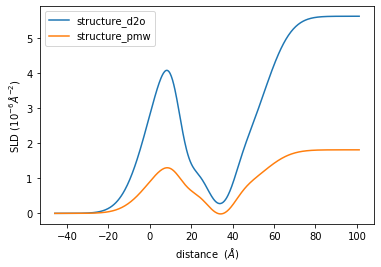

In [9]:
# structure_d2o
# structure_pmw
plt.plot(*structure_d2o.sld_profile(),label="structure_d2o")
# structure_d2o.plot()
# plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
# plt.xlabel('distance  $(\AA)$')

plt.plot(*structure_pmw.sld_profile(),label="structure_pmw")
# structure_pmw.plot()
plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
plt.xlabel('distance  $(\AA)$')
plt.legend()
plt.show();

layers [[ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]
 [ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]]
layers [[ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]
 [ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]]


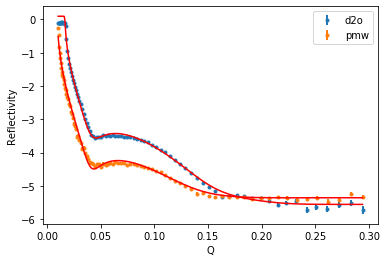

In [10]:
if choose==1:
    gobjective.plot(samples=300)
else:
    gobjective.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

layers [[ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]
 [ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]]


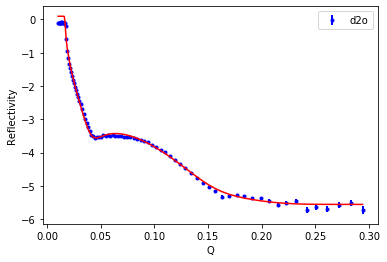

In [11]:
if choose==1:
    objective1.plot(samples=300)
else:
    objective1.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

layers [[ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]
 [ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]]


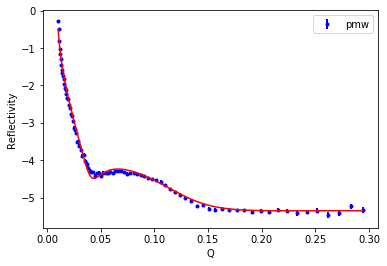

In [12]:
if choose==1:
    objective2.plot(samples=300)
else:
    objective2.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

In [13]:
print("model1: d2o", model1.scale, model1.bkg)
print("model2: pmw", model2.scale, model2.bkg)

model1: d2o <Parameter:    'scale'    , value=1.23916 (fixed)  , bounds=[-inf, inf]> <Parameter:     'bkg'     , value=2.67249e-06 +/- 2.4e-07, bounds=[3.72e-07, 3.348e-06]>
model2: pmw <Parameter:    'scale'    , value=1.84843 (fixed)  , bounds=[-inf, inf]> <Parameter:     'bkg'     , value=4.40998e-06 +/- 1.34e-07, bounds=[6.74e-07, 6.066e-06]>


In [14]:
print(structure_d2o)

________________________________________________________________________________
Structure:       d2o      
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:      'D2O'     
<Parameter:'thickness_solution', value=13.9308 +/- 1.33 , bounds=[6, 20]>
<Parameter:  'D2O - sld'  , value=5.62516 +/- 0.00265, bounds=[5.35, 6.35]>
<Parameter: 'D2O - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_preceding_solution', value=10.2259 +/- 0.655

In [15]:
print(structure_pmw)

________________________________________________________________________________
Structure: protein matched water
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Protein Matched Water'
<Parameter:'thickness_solution', value=13.9308 +/- 1.33 , bounds=[6, 20]>
<Parameter:'Protein Matched Water - sld', value=1.81281 +/- 0.00437, bounds=[1.35, 3.35]>
<Parameter:'Protein Matched Water - isld', value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_p

In [16]:
print(structure_d2o.slabs())

layers [[ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.11385111e+00
   5.68097646e-02]
 [ 1.41566216e+01  1.28276664e+00  8.64516557e-09  4.11385111e+00
   0.00000000e+00]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.39307936e+01 5.62515734e+00 0.00000000e+00 1.02258521e+01
  0.00000000e+00]
 [1.41566216e+01 1.28276664e+00 8.64516557e-09 4.11385111e+00
  0.00000000e+00]
 [6.47365927e+00 5.24771079e-02 0.00000000e+00 4.11385111e+00
  5.68097646e-02]
 [6.47365927e+00 5.24771079e-02 0.00000000e+00 4.11385111e+00
  5.68097646e-02]
 [1.41566216e+01 1.28276664e+00 8.64516557e-09 4.11385111e+00
  0.00000000e+00]
 [1.39307936e+01 5.62515734e+00 0.00000000e+00 1.02258521e+01
  0.00000000e+00]]


In [17]:
print(structure_pmw.slabs())

layers [[ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]
 [ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]]
layers [[ 6.47365927e+00 -2.83173793e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]
 [ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.39307936e+01  1.81280504e+00  0.00000000e+00  1.02258521e+01
   0.00000000e+00]
 [ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]
 [ 6.47365927e+00 -1.64101729e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]
 [ 6.47365927e+00 -1.64101729e-01  0.00000000e+00  4.60859796e+00
   5.68097646e-02]
 [ 1.41566216e+01  6.09038629e-01  8.64516557e-09  4.60859796e+00
   0.00000000e+00]
 [ 1.39307936e+01  1.81280504e+00  0.00000000e+00  1.02258521e+01
   0.00000000e+00]]


In [18]:
if choose==2:
    # span = [(0,5000),(0,1.5),(0,0.4),(-10**3,10**3)] #span=span
    fig, axes = dyplot.runplot(res1, color='black', mark_final_live=False,
                               logplot=False)

In [19]:
if choose==2:
    print(-min(res1["logvol"])) # ?

In [20]:
#gobjective.varying_parameters()
[[param.name,param.value] for param in gobjective.varying_parameters()]

[['bkg', 2.672488376477179e-06],
 ['thickness_solution', 13.930793641183966],
 ['D2O - sld', 5.625157340875958],
 ['rough_preceding_solution', 10.225852132016103],
 ['bilayer - area_per_molecule', 153.9824102523813],
 ['bilayer - thickness_heads', 14.156621552357368],
 ['bilayer - thickness_tails', 6.473659274213113],
 ['bilayer - rough_top', 4.113851106079473],
 ['bilayer - Waters Per Head', 3.080777626261049],
 ['bkg', 4.409976896100646e-06],
 ['Protein Matched Water - sld', 1.8128050435018617],
 ['bilayer - rough_bot', 4.608597957432904]]

I believe correct values, leaflet roughness between head and tail is the same as the roughness preceeding the leaflet\
class used is a modified version of the LipidLeaflet class native to refnx, its in the file\
"lipidBilayerAsGiven" and called "LipidLeaflet_WaterPer_builtOn2"\
volumes of head and tails are indirectly varied by changes in waters per head/tail\
so the tails do not change volume\
1 'scale',\
2 'bkg',\
3 'mono, dodab - area_per_molecule',\
4 'mono, dodab - thickness heads',\
5 'mono, dodab - thickness_tails',\
6 'mono, dodab - roughness',\
7 'mono, dodab - D2O in head - sld',\
8 'mono, dodab Waters Per Head',\
9 'D2O - sld',\
10 'bilayer - area_per_molecule',\
11 'bilayer - thickness_heads',\
12 'bilayer - thickness_tails',\
13 'bilayer - rough_top',\
14 'D2O in bilayer - sld',\
15 'bilayer Waters Per Head',\
16 'scale',\
17 'bkg',\
18 'mono, dodab - Protein Matched Water in head - sld',\
19 'Protein Matched Water - sld',\
20 'bilayer - rough_bot',\
21 'Protein Matched Water in bilayer - sld'

In [21]:
if choose==2:
    labels = [param.name for param in gobjective.varying_parameters()]

    fig, axes = dyplot.traceplot(res1, labels = labels, #truths=np.zeros(fitter.nDim()),
                                 show_titles=True, trace_cmap='plasma',
                                 quantiles=[0.025, 0.5, 0.975])
    fig.tight_layout()

In [22]:
if choose==2:
    labels = [param.name for param in gobjective.varying_parameters()]

    fig, axes = dyplot.cornerpoints(res1, labels = labels#, #truths=np.zeros(fitter.nDim()),
                                 #show_titles=True,
                                 #trace_cmap='plasma',
                                 #quantiles=[0.025, 0.5, 0.975]
                                   )
    fig.tight_layout()